<a href="https://colab.research.google.com/github/pen1064/Toronto_House_Market/blob/main/Data_Exploration_And_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [187]:
house_data = pd.read_excel("house_detail_clean1.xlsx")
house_data.head(3)

,address,final_price,list_price,bedrooms,bathrooms,sqft,parking,description,mls,type,full_link,full_address,lat,long,city_district,mean_district_income,district_code,Line,Station,Dist,final_price_persqft
0,"1303 - 38 Grenville St, Toronto (C4461599) | Z...",855000,870000,3,2,849.5,1,"Luxurious And Spacious Murano Tower. 2+1, 2 Ba...",C4461599,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"38 Grenville St, Toronto , Ontario, Canada",43.661896,-79.385748,Bay Street Corridor,56526,76,Yonge-University-Spadina,College,0.224219,1006.474397
1,"1504 - 30 Roehampton Ave, Toronto (C4511330) |...",550000,549900,1,1,549.5,0,Bright Sunfilled Spacious 1 Bdr Unit; Floor To...,C4511330,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"30 Roehampton Ave, Toronto , Ontario, Canada",43.708472,-79.397498,Mount Pleasant West,57039,104,Yonge-University-Spadina,Eglinton,0.407749,1000.909918
2,"514 - 65 East Liberty St, Toronto (C4515763) |...",665000,600000,2,1,649.5,1,Rare Loft-Like Condo In Liberty Village W/ 18'...,C4515763,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"65 East Liberty St, Toronto , Ontario, Canada",43.638399,-79.414448,Niagara,70623,82,Yonge-University-Spadina,St. Andrew,2.597742,1023.864511


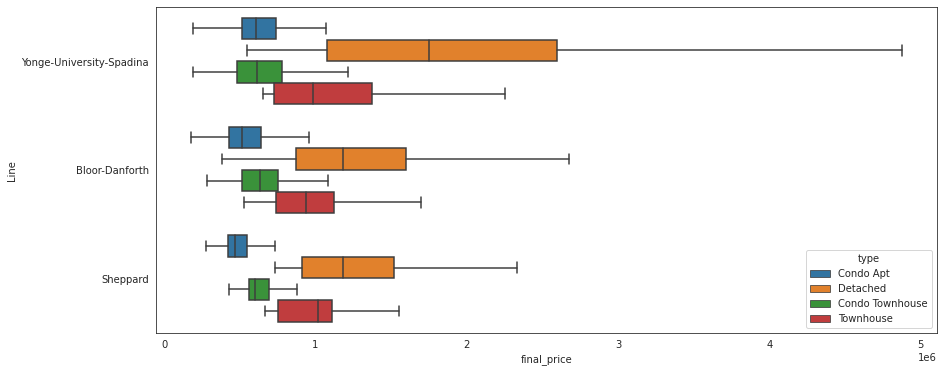

In [188]:
median = []
tar_type = ["Condo Apt", "Condo Townhouse", "Detached", "Townhouse"]
kpi = "final_price"
house_dataf = house_data[house_data.type.isin(tar_type)]
fig, ax = plt.subplots(figsize = [14,6])
bx = sns.boxplot(y = "Line", x=kpi, data = house_dataf, hue = "type", showfliers = False)
plt.show()

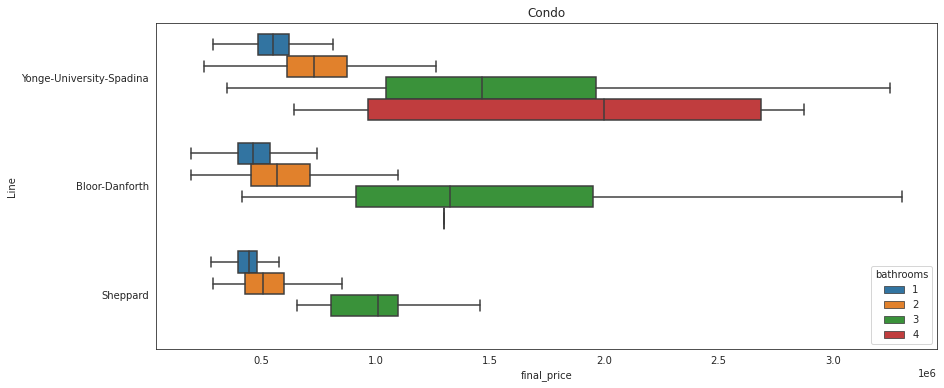

In [189]:
median = []
tar_type = ["Condo Apt"]
kpi = "final_price"
house_dataf = house_data[house_data.type.isin(tar_type)]
fig, ax = plt.subplots(figsize = [14,6])
bx = sns.boxplot(y = "Line", x=kpi, data = house_dataf, hue = "bathrooms", showfliers = False)
bx.set(title="Condo")
plt.show()

In [194]:
import plotly.express as px
fig = px.scatter(house_data, x="Dist", y="final_price", 
                 hover_data=['Dist', 'final_price', 'address', 'sqft'],
                 color="type", title="TTC Transport")

fig.write_html("Listing_TTC.html")
fig.show()

In [195]:
fig = px.scatter(house_data[house_data["type"]=="Condo Apt"], x="Dist", y="final_price", 
                 hover_data=['Dist', 'final_price', 'address', 'sqft'],color="Line", title="TTC Transport")
fig.write_html("Condo_TTC.html")
fig.show()

   

In [5]:
house_df = house_data
house_df.drop(["full_link", "full_address", "mls", "description", "district_code", "lat", "long"], axis=1, inplace=True)
#house_df = pd.get_dummies(house_df)
#predictors = house_data_d.drop(["final_price"], axis = 1).columns
#print(predictors)

In [46]:
need_columns = ["final_price","bedrooms", "bathrooms", "parking", "sqft", "type", "Line", "Dist", "mean_district_income"] #temporaily only these two 
houses_dummies = pd.get_dummies(house_df[need_columns])
houses_dummies.head(3)

,final_price,bedrooms,bathrooms,parking,sqft,Dist,mean_district_income,type_Co-Op Apt,type_Condo Apt,type_Condo Townhouse,type_Detached,type_Plex,type_Semi-Detached,type_Townhouse,Line_Bloor-Danforth,Line_Sheppard,Line_Yonge-University-Spadina
0,855000,3,2,1,849.5,0.224219,56526,0,1,0,0,0,0,0,0,0,1
1,550000,1,1,0,549.5,0.407749,57039,0,1,0,0,0,0,0,0,0,1
2,665000,2,1,1,649.5,2.597742,70623,0,1,0,0,0,0,0,0,0,1


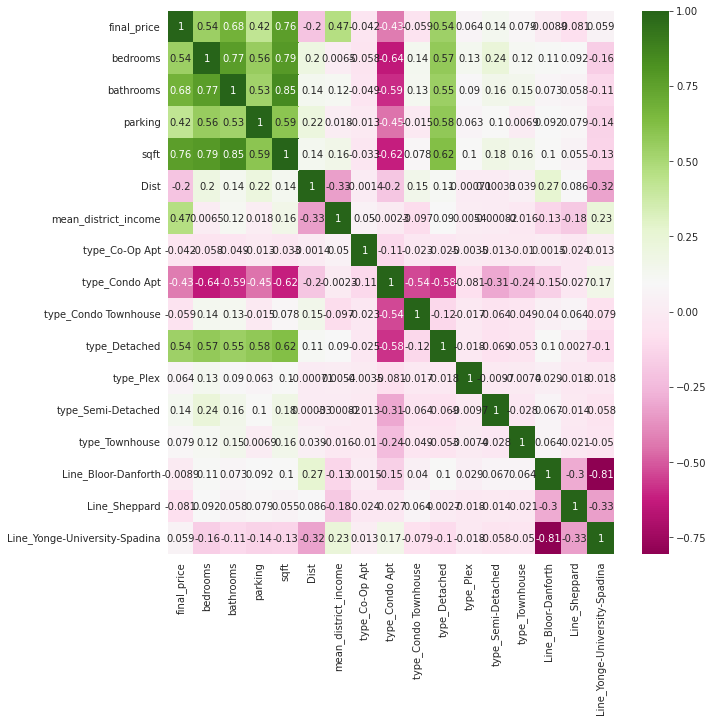

In [47]:
fig, ax = plt.subplots(figsize=[10, 10])
ax = sns.heatmap(houses_dummies.corr(), annot=True,cmap="PiYG")

In [21]:
#need_columns = ["final_price","bedrooms", "bathrooms", "parking", "sqft", "type", "Line", "mean_district_income", "city_district"] #temporaily only these two 
#houses_dummies = pd.get_dummies(house_df[need_columns])


,final_price,bedrooms,bathrooms,parking,sqft,mean_district_income,type_Co-Op Apt,type_Condo Apt,type_Condo Townhouse,type_Detached,type_Plex,type_Semi-Detached,type_Townhouse,Line_Bloor-Danforth,Line_Sheppard,Line_Yonge-University-Spadina,city_district_Agincourt North,city_district_Agincourt South-Malvern West,city_district_Alderwood,city_district_Annex,city_district_Banbury-Don Mills,city_district_Bathurst Manor,city_district_Bay Street Corridor,city_district_Bayview Village,city_district_Bayview Woods-Steeles,city_district_Bedford Park-Nortown,city_district_Beechborough-Greenbrook,city_district_Bendale,city_district_Birchcliffe-Cliffside,city_district_Black Creek,city_district_Blake-Jones,city_district_Briar Hill-Belgravia,city_district_Bridle Path-Sunnybrook-York Mills,city_district_Broadview North,city_district_Brookhaven-Amesbury,city_district_Cabbagetown-South St. James Town,city_district_Caledonia-Fairbank,city_district_Casa Loma,city_district_Centennial Scarborough,city_district_Church-Yonge Corridor,...,city_district_Regent Park,city_district_Rexdale-Kipling,city_district_Rockcliffe-Smythe,city_district_Roncesvalles,city_district_Rosedale-Moore Park,city_district_Rouge,city_district_Runnymede-Bloor West Village,city_district_Rustic,city_district_Scarborough Village,city_district_South Parkdale,city_district_South Riverdale,city_district_St.Andrew-Windfields,city_district_Steeles,city_district_Stonegate-Queensway,city_district_Tam O'Shanter-Sullivan,city_district_Taylor-Massey,city_district_The Beaches,city_district_Thistletown-Beaumond Heights,city_district_Thorncliffe Park,city_district_Trinity-Bellwoods,city_district_University,city_district_Victoria Village,city_district_Waterfront Communities-The Island,city_district_West Hill,city_district_West Humber-Clairville,city_district_Westminster-Branson,city_district_Weston,city_district_Weston-Pelham Park,city_district_Wexford/Maryvale,city_district_Willowdale East,city_district_Willowdale West,city_district_Willowridge-Martingrove-Richview,city_district_Woburn,city_district_Woodbine Corridor,city_district_Woodbine-Lumsden,city_district_Wychwood,city_district_Yonge-Eglinton,city_district_Yonge-St.Clair,city_district_York University Heights,city_district_Yorkdale-Glen Park
0,855000,3,2,1,849.5,56526,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,550000,1,1,0,549.5,57039,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,665000,2,1,1,649.5,70623,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
predictors = houses_dummies.drop('final_price', axis=1).columns
houses_dummies.head(3)

,final_price,bedrooms,bathrooms,parking,sqft,Dist,mean_district_income,type_Co-Op Apt,type_Condo Apt,type_Condo Townhouse,type_Detached,type_Plex,type_Semi-Detached,type_Townhouse,Line_Bloor-Danforth,Line_Sheppard,Line_Yonge-University-Spadina
0,855000,3,2,1,849.5,0.224219,56526,0,1,0,0,0,0,0,0,0,1
1,550000,1,1,0,549.5,0.407749,57039,0,1,0,0,0,0,0,0,0,1
2,665000,2,1,1,649.5,2.597742,70623,0,1,0,0,0,0,0,0,0,1


In [63]:
from sklearn.ensemble import ExtraTreesRegressor

sns.set_style("white")
plt.figure
model = ExtraTreesRegressor(n_estimators = 10)
model.fit(houses_dummies[predictors], houses_dummies.final_price)

ExtraTreesRegressor(n_estimators=10)

['type_Co-Op Apt', 'type_Plex', 'Line_Sheppard', 'type_Townhouse', 'type_Condo Townhouse', 'Line_Bloor-Danforth', 'type_Semi-Detached', 'type_Condo Apt', 'Line_Yonge-University-Spadina', 'parking', 'bedrooms', 'bathrooms', 'Dist', 'type_Detached', 'mean_district_income', 'sqft']


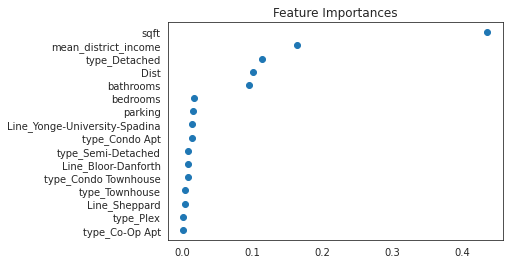

In [64]:
m = zip(model.feature_importances_, houses_dummies[predictors].columns)
sorted_feature_importance = sorted(m)

x = [a[0] for a in sorted_feature_importance]
y = [a[1] for a in sorted_feature_importance]

print(y)
plt.scatter(x,y)
plt.title('Feature Importances')
plt.show()

In [162]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
numeric_feats = ['sqft', 'mean_district_income', 'final_price']
houses = houses_dummies.copy()
predictors = houses.drop(["final_price"], axis=1).columns

yeo_johnson_lambdas = [] 
houses["final_price"] = houses["final_price"] /100
houses["mean_district_income"] = houses["mean_district_income"] /10
for numeric_feat in numeric_feats:
  houses[numeric_feat] = pt.fit_transform(houses[[numeric_feat]])
  yeo_johnson_lambdas.append(pt.lambdas_[0])

In [91]:
from sklearn.metrics import make_scorer, mean_absolute_error
def mae_transform(y, y_pred, **kwargs):
    y_pred[y_pred > 5] = 5
    y = pt.inverse_transform(pd.DataFrame(y)) * 100
    y_pred = pt.inverse_transform(pd.DataFrame(y_pred))  * 100
    return mean_absolute_error(y, y_pred)

custom_mae = make_scorer(mae_transform, greater_is_better=False)

In [92]:
houses.head(3)

,final_price,bedrooms,bathrooms,parking,sqft,Dist,mean_district_income,type_Co-Op Apt,type_Condo Apt,type_Condo Townhouse,type_Detached,type_Plex,type_Semi-Detached,type_Townhouse,Line_Bloor-Danforth,Line_Sheppard,Line_Yonge-University-Spadina
0,0.646832,3,2,1,-0.217721,0.224219,0.381280,0,1,0,0,0,0,0,0,0,1
1,-0.317657,1,1,0,-1.055213,0.407749,0.402931,0,1,0,0,0,0,0,0,0,1
2,0.125399,2,1,1,-0.730228,2.597742,0.876545,0,1,0,0,0,0,0,0,0,1


In [93]:
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
alg = xgb.XGBRegressor(objective='reg:squarederror')
cv_split = KFold(n_splits = 4, shuffle=True, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(houses[predictors], houses["final_price"], test_size=0.33, random_state=42)
cv_scores = cross_validate(alg, X_train, y_train, cv = cv_split, return_train_score=True, scoring = custom_mae)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  "X does not h

In [95]:
print("train score", -1*cv_scores["train_score"].mean())
print("test score", -1*cv_scores["test_score"].mean())

train score 100293.49779592328
test score 106007.17452114112


In [103]:
houses.to_csv("houses_model_xgb.csv")

In [110]:
houses_dummies.head(3)

,final_price,bedrooms,bathrooms,parking,sqft,Dist,mean_district_income,type_Co-Op Apt,type_Condo Apt,type_Condo Townhouse,type_Detached,type_Plex,type_Semi-Detached,type_Townhouse,Line_Bloor-Danforth,Line_Sheppard,Line_Yonge-University-Spadina
0,855000,3,2,1,849.5,0.224219,56526,0,1,0,0,0,0,0,0,0,1
1,550000,1,1,0,549.5,0.407749,57039,0,1,0,0,0,0,0,0,0,1
2,665000,2,1,1,649.5,2.597742,70623,0,1,0,0,0,0,0,0,0,1


Hyperparameter Tuning

In [ ]:
! pip install optuna

In [166]:
import optuna

def objective(trial):
  houses = pd.read_csv("houses_model_xgb.csv")
  predictors = houses.drop(["final_price"], axis=1).columns
  train_x, test_x, train_y, test_y = train_test_split(houses[predictors], houses["final_price"], test_size=0.33, random_state=33)
  dtrain = xgb.DMatrix(train_x, label=train_y)
  dtest = xgb.DMatrix(test_x, label=test_y)

  param = {
      "verbosity": 3,  
      "objective": "reg:squarederror",
      "n_estimators": 1000,
      "n_splits": 4,
      "max_depth": trial.suggest_int("max_depth", 4, 12),
      "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
      "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
      "subsample": trial.suggest_loguniform("subsample", 0.4, 0.8),
      "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
      "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
      "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
      "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
  }
  # Add a callback for pruning.
  #pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
  bst = xgb.train(param, dtrain, evals=[(dtest, "validation")])
  preds = bst.predict(dtest)
  testy = pt.inverse_transform(pd.DataFrame(test_y, columns=["final_price"])) * 100
  ypreds = pt.inverse_transform(pd.DataFrame(preds, columns=["final_price"]))  * 100
  accuracy = mean_absolute_error(ypreds, testy)
  return accuracy

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)
print(study.best_trial)

[I 2022-02-17 05:52:37,927] A new study created in memory with name: no-name-beb88161-8603-4bb7-be69-c7b774aeafcf


[05:52:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.11493
[05:52:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.10171
[05:52:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.08472
[05:52:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[3]	validation-rmse:1.07224
[05:52:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[4]	validation-rmse:1.06029
[05:52:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[5]	validation-rmse:1.04839
[05:52:38] INFO: /workspace/src/tree/updater_prune.cc:74: 

[I 2022-02-17 05:52:38,213] Trial 0 finished with value: 298439.64215509745 and parameters: {'max_depth': 5, 'learning_rate': 0.019787617966750087, 'colsample_bytree': 0.23953280785461614, 'subsample': 0.7903954105693808, 'alpha': 0.03748995030742426, 'lambda': 3.202780118835151e-08, 'min_child_weight': 32.23865786219866}. Best is trial 0 with value: 298439.64215509745.


[05:52:38] ======== Monitor: Learner ========
[05:52:38] EvalOneIter: 0.0133683s, 10 calls @ 1336us
[05:52:38] GetGradient: 0.00631381s, 10 calls @ 631us
[05:52:38] PredictRaw: 0.00130946s, 10 calls @ 130us
[05:52:38] UpdateOneIter: 0.106635s, 10 calls @ 10663us
[05:52:38] ======== Monitor: GBTree ========
[05:52:38] BoostNewTrees: 0.0738013s, 10 calls @ 7380us
[05:52:38] CommitModel: 0.0249977s, 10 calls @ 2499us
[05:52:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.10202
[05:52:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.0747
[05:52:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.05015
[05:52:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nod

[I 2022-02-17 05:52:38,496] Trial 1 finished with value: 271398.038180443 and parameters: {'max_depth': 5, 'learning_rate': 0.042046406544402413, 'colsample_bytree': 0.21712997698182204, 'subsample': 0.44122729973945546, 'alpha': 0.2960270898118958, 'lambda': 0.005562424808770453, 'min_child_weight': 34.55696361891522}. Best is trial 1 with value: 271398.038180443.


[05:52:38] ======== Monitor: Learner ========
[05:52:38] EvalOneIter: 0.013654s, 10 calls @ 1365us
[05:52:38] GetGradient: 0.00688798s, 10 calls @ 688us
[05:52:38] PredictRaw: 0.00131089s, 10 calls @ 131us
[05:52:38] UpdateOneIter: 0.108123s, 10 calls @ 10812us
[05:52:38] ======== Monitor: GBTree ========
[05:52:38] BoostNewTrees: 0.0736174s, 10 calls @ 7361us
[05:52:38] CommitModel: 0.0261719s, 10 calls @ 2617us
[05:52:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.10664
[05:52:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.08847
[05:52:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.06542
[05:52:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pru

[I 2022-02-17 05:52:38,883] Trial 2 finished with value: 279986.6754032253 and parameters: {'max_depth': 11, 'learning_rate': 0.026475927816376695, 'colsample_bytree': 0.4533993168672113, 'subsample': 0.4518104803922136, 'alpha': 0.1704801466234396, 'lambda': 3.273115231701061e-08, 'min_child_weight': 16.9029002605314}. Best is trial 1 with value: 271398.038180443.


[05:52:38] ======== Monitor: Learner ========
[05:52:38] EvalOneIter: 0.0145344s, 10 calls @ 1453us
[05:52:38] GetGradient: 0.00622026s, 10 calls @ 622us
[05:52:38] PredictRaw: 0.00147813s, 10 calls @ 147us
[05:52:38] UpdateOneIter: 0.197334s, 10 calls @ 19733us
[05:52:38] ======== Monitor: GBTree ========
[05:52:38] BoostNewTrees: 0.157471s, 10 calls @ 15747us
[05:52:38] CommitModel: 0.0320313s, 10 calls @ 3203us
[05:52:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.11669
[05:52:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.10593
[05:52:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.09235
[05:52:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned 

[I 2022-02-17 05:52:39,203] Trial 3 finished with value: 305200.29995319655 and parameters: {'max_depth': 7, 'learning_rate': 0.015707243883579927, 'colsample_bytree': 0.3143367718136207, 'subsample': 0.41941583566464957, 'alpha': 0.014948348181136599, 'lambda': 2.3526895570951767e-05, 'min_child_weight': 25.323534034370194}. Best is trial 1 with value: 271398.038180443.


[05:52:39] ======== Monitor: Learner ========
[05:52:39] EvalOneIter: 0.0126741s, 10 calls @ 1267us
[05:52:39] GetGradient: 0.00625397s, 10 calls @ 625us
[05:52:39] PredictRaw: 0.00125224s, 10 calls @ 125us
[05:52:39] UpdateOneIter: 0.145316s, 10 calls @ 14531us
[05:52:39] ======== Monitor: GBTree ========
[05:52:39] BoostNewTrees: 0.108217s, 10 calls @ 10821us
[05:52:39] CommitModel: 0.0294703s, 10 calls @ 2947us
[05:52:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.11432
[05:52:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.10282
[05:52:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.09085
[05:52:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned n

[I 2022-02-17 05:52:39,576] Trial 4 finished with value: 304202.56930443505 and parameters: {'max_depth': 8, 'learning_rate': 0.013927289453201042, 'colsample_bytree': 0.5508906232359058, 'subsample': 0.7829381289768038, 'alpha': 0.0773576442325475, 'lambda': 0.021845178449978183, 'min_child_weight': 76.14787329383682}. Best is trial 1 with value: 271398.038180443.


[05:52:39] ======== Monitor: Learner ========
[05:52:39] EvalOneIter: 0.0126622s, 10 calls @ 1266us
[05:52:39] GetGradient: 0.00597607s, 10 calls @ 597us
[05:52:39] PredictRaw: 0.00129413s, 10 calls @ 129us
[05:52:39] UpdateOneIter: 0.197685s, 10 calls @ 19768us
[05:52:39] ======== Monitor: GBTree ========
[05:52:39] BoostNewTrees: 0.155338s, 10 calls @ 15533us
[05:52:39] CommitModel: 0.0349314s, 10 calls @ 3493us
[05:52:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.1047
[05:52:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.08004
[05:52:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.0576
[05:52:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned node

[I 2022-02-17 05:52:39,870] Trial 5 finished with value: 276237.24364559277 and parameters: {'max_depth': 9, 'learning_rate': 0.038108021809197264, 'colsample_bytree': 0.21376098148519707, 'subsample': 0.4749771459495549, 'alpha': 0.26564271591565847, 'lambda': 1.897511472355197e-05, 'min_child_weight': 76.38469831904231}. Best is trial 1 with value: 271398.038180443.


[05:52:39] ======== Monitor: Learner ========
[05:52:39] EvalOneIter: 0.0218321s, 10 calls @ 2183us
[05:52:39] GetGradient: 0.0060857s, 10 calls @ 608us
[05:52:39] PredictRaw: 0.00122606s, 10 calls @ 122us
[05:52:39] UpdateOneIter: 0.134076s, 10 calls @ 13407us
[05:52:39] ======== Monitor: GBTree ========
[05:52:39] BoostNewTrees: 0.0990367s, 10 calls @ 9903us
[05:52:39] CommitModel: 0.0276094s, 10 calls @ 2760us
[05:52:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.09291
[05:52:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.06263
[05:52:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.02599
[05:52:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned no

[I 2022-02-17 05:52:40,161] Trial 6 finished with value: 248251.38185843846 and parameters: {'max_depth': 5, 'learning_rate': 0.04864378880487466, 'colsample_bytree': 0.5144954212042844, 'subsample': 0.576281955068696, 'alpha': 9.49227557125786, 'lambda': 1.2842067078244534e-08, 'min_child_weight': 23.023142071788932}. Best is trial 6 with value: 248251.38185843846.


[05:52:40] ======== Monitor: Learner ========
[05:52:40] EvalOneIter: 0.0137624s, 10 calls @ 1376us
[05:52:40] GetGradient: 0.00925574s, 10 calls @ 925us
[05:52:40] PredictRaw: 0.00130731s, 10 calls @ 130us
[05:52:40] UpdateOneIter: 0.146224s, 10 calls @ 14622us
[05:52:40] ======== Monitor: GBTree ========
[05:52:40] BoostNewTrees: 0.109885s, 10 calls @ 10988us
[05:52:40] CommitModel: 0.0256609s, 10 calls @ 2566us
[05:52:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.0954
[05:52:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.06666
[05:52:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.03721
[05:52:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned no

[I 2022-02-17 05:52:40,457] Trial 7 finished with value: 259354.80956581165 and parameters: {'max_depth': 5, 'learning_rate': 0.03683407882421829, 'colsample_bytree': 0.5732448887745291, 'subsample': 0.500995081239082, 'alpha': 1.9659600413406715, 'lambda': 7.222996291422681e-06, 'min_child_weight': 20.303074913369205}. Best is trial 6 with value: 248251.38185843846.


[05:52:40] ======== Monitor: Learner ========
[05:52:40] EvalOneIter: 0.0130872s, 10 calls @ 1308us
[05:52:40] GetGradient: 0.00610525s, 10 calls @ 610us
[05:52:40] PredictRaw: 0.00136208s, 10 calls @ 136us
[05:52:40] UpdateOneIter: 0.1596s, 10 calls @ 15960us
[05:52:40] ======== Monitor: GBTree ========
[05:52:40] BoostNewTrees: 0.125435s, 10 calls @ 12543us
[05:52:40] CommitModel: 0.0265786s, 10 calls @ 2657us
[05:52:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09575
[05:52:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.06788
[05:52:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.03896
[05:52:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned

[I 2022-02-17 05:52:40,801] Trial 8 finished with value: 260717.63952692924 and parameters: {'max_depth': 8, 'learning_rate': 0.03436449794280283, 'colsample_bytree': 0.559591069974094, 'subsample': 0.49097824004869467, 'alpha': 0.05194251890614512, 'lambda': 0.00022018699942368905, 'min_child_weight': 23.253143390121583}. Best is trial 6 with value: 248251.38185843846.


[05:52:40] ======== Monitor: Learner ========
[05:52:40] EvalOneIter: 0.0156545s, 10 calls @ 1565us
[05:52:40] GetGradient: 0.00601328s, 10 calls @ 601us
[05:52:40] PredictRaw: 0.00129184s, 10 calls @ 129us
[05:52:40] UpdateOneIter: 0.203835s, 10 calls @ 20383us
[05:52:40] ======== Monitor: GBTree ========
[05:52:40] BoostNewTrees: 0.165288s, 10 calls @ 16528us
[05:52:40] CommitModel: 0.0311226s, 10 calls @ 3112us
[05:52:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.1167
[05:52:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.10733
[05:52:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.0955
[05:52:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned

[I 2022-02-17 05:52:41,181] Trial 9 finished with value: 307110.9509108578 and parameters: {'max_depth': 9, 'learning_rate': 0.013563119699298087, 'colsample_bytree': 0.47585903784757133, 'subsample': 0.4616929593797607, 'alpha': 0.5219212420184268, 'lambda': 0.0011813500320046874, 'min_child_weight': 22.086095005054617}. Best is trial 6 with value: 248251.38185843846.


[05:52:41] ======== Monitor: Learner ========
[05:52:41] EvalOneIter: 0.0186275s, 10 calls @ 1862us
[05:52:41] GetGradient: 0.0060549s, 10 calls @ 605us
[05:52:41] PredictRaw: 0.0012649s, 10 calls @ 126us
[05:52:41] UpdateOneIter: 0.228577s, 10 calls @ 22857us
[05:52:41] ======== Monitor: GBTree ========
[05:52:41] BoostNewTrees: 0.188261s, 10 calls @ 18826us
[05:52:41] CommitModel: 0.0328658s, 10 calls @ 3286us
[05:52:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation-rmse:1.12366
[05:52:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation-rmse:1.11983
[05:52:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[2]	validation-rmse:1.11504
[05:52:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, 

[I 2022-02-17 05:52:41,436] Trial 10 finished with value: 327380.25525633595 and parameters: {'max_depth': 4, 'learning_rate': 0.006922816780471365, 'colsample_bytree': 0.3434398551998099, 'subsample': 0.6379741195588449, 'alpha': 9.415151820315426, 'lambda': 6.680430970532889, 'min_child_weight': 875.7829889683886}. Best is trial 6 with value: 248251.38185843846.


[05:52:41] ======== Monitor: Learner ========
[05:52:41] EvalOneIter: 0.0130302s, 10 calls @ 1303us
[05:52:41] GetGradient: 0.00608415s, 10 calls @ 608us
[05:52:41] PredictRaw: 0.00130501s, 10 calls @ 130us
[05:52:41] UpdateOneIter: 0.111204s, 10 calls @ 11120us
[05:52:41] ======== Monitor: GBTree ========
[05:52:41] BoostNewTrees: 0.0789961s, 10 calls @ 7899us
[05:52:41] CommitModel: 0.0247069s, 10 calls @ 2470us
[05:52:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09201
[05:52:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.06055
[05:52:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.02258
[05:52:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned n

[I 2022-02-17 05:52:41,751] Trial 11 finished with value: 246681.832679291 and parameters: {'max_depth': 6, 'learning_rate': 0.049206406528143, 'colsample_bytree': 0.4283096824078301, 'subsample': 0.5683550156074787, 'alpha': 7.552121422149674, 'lambda': 5.205955926338758e-07, 'min_child_weight': 10.9106607616308}. Best is trial 11 with value: 246681.832679291.


[05:52:41] ======== Monitor: Learner ========
[05:52:41] EvalOneIter: 0.0133141s, 10 calls @ 1331us
[05:52:41] GetGradient: 0.00682091s, 10 calls @ 682us
[05:52:41] PredictRaw: 0.00137385s, 10 calls @ 137us
[05:52:41] UpdateOneIter: 0.171417s, 10 calls @ 17141us
[05:52:41] ======== Monitor: GBTree ========
[05:52:41] BoostNewTrees: 0.135339s, 10 calls @ 13533us
[05:52:41] CommitModel: 0.0277728s, 10 calls @ 2777us
[05:52:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09362
[05:52:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.06345
[05:52:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.02702
[05:52:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned n

[I 2022-02-17 05:52:42,111] Trial 12 finished with value: 250924.8416078624 and parameters: {'max_depth': 6, 'learning_rate': 0.04753466037877075, 'colsample_bytree': 0.4083082815000891, 'subsample': 0.6073411475992646, 'alpha': 8.763550659956138, 'lambda': 3.1912216384402505e-07, 'min_child_weight': 10.294277750188238}. Best is trial 11 with value: 246681.832679291.


[05:52:42] ======== Monitor: Learner ========
[05:52:42] EvalOneIter: 0.0205975s, 10 calls @ 2059us
[05:52:42] GetGradient: 0.00858197s, 10 calls @ 858us
[05:52:42] PredictRaw: 0.00138258s, 10 calls @ 138us
[05:52:42] UpdateOneIter: 0.151018s, 10 calls @ 15101us
[05:52:42] ======== Monitor: GBTree ========
[05:52:42] BoostNewTrees: 0.107884s, 10 calls @ 10788us
[05:52:42] CommitModel: 0.033032s, 10 calls @ 3303us
[05:52:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation-rmse:1.11127
[05:52:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation-rmse:1.09565
[05:52:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation-rmse:1.07711
[05:52:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned no

[I 2022-02-17 05:52:42,428] Trial 13 finished with value: 289369.5562716009 and parameters: {'max_depth': 4, 'learning_rate': 0.024707735785729743, 'colsample_bytree': 0.399528544425233, 'subsample': 0.5599565021065807, 'alpha': 2.217185931987179, 'lambda': 5.178843243319365e-07, 'min_child_weight': 316.23373299062627}. Best is trial 11 with value: 246681.832679291.


[05:52:42] ======== Monitor: Learner ========
[05:52:42] EvalOneIter: 0.0142619s, 10 calls @ 1426us
[05:52:42] GetGradient: 0.0111764s, 10 calls @ 1117us
[05:52:42] PredictRaw: 0.00128471s, 10 calls @ 128us
[05:52:42] UpdateOneIter: 0.12667s, 10 calls @ 12667us
[05:52:42] ======== Monitor: GBTree ========
[05:52:42] BoostNewTrees: 0.0844879s, 10 calls @ 8448us
[05:52:42] CommitModel: 0.0295821s, 10 calls @ 2958us
[05:52:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.1237
[05:52:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.12028
[05:52:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.11591
[05:52:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nod

[I 2022-02-17 05:52:42,769] Trial 14 finished with value: 328377.50230414706 and parameters: {'max_depth': 6, 'learning_rate': 0.00503747475493476, 'colsample_bytree': 0.29531272699218336, 'subsample': 0.6893103331136153, 'alpha': 2.712935348908069, 'lambda': 1.2082460258350483e-08, 'min_child_weight': 10.318019978200587}. Best is trial 11 with value: 246681.832679291.


[05:52:42] UpdateOneIter: 0.137891s, 10 calls @ 13789us
[05:52:42] ======== Monitor: GBTree ========
[05:52:42] BoostNewTrees: 0.100867s, 10 calls @ 10086us
[05:52:42] CommitModel: 0.0282268s, 10 calls @ 2822us
[05:52:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.12047
[05:52:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.11442
[05:52:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.10673
[05:52:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation-rmse:1.09964
[05:52:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[4]	validation-rmse:1.0938
[05:5

[I 2022-02-17 05:52:43,149] Trial 15 finished with value: 318146.352444556 and parameters: {'max_depth': 7, 'learning_rate': 0.009173357854636655, 'colsample_bytree': 0.47281737966585513, 'subsample': 0.5453723169609174, 'alpha': 0.7948839441133914, 'lambda': 5.146565927035585e-07, 'min_child_weight': 159.79825906546296}. Best is trial 11 with value: 246681.832679291.


[05:52:43] ======== Monitor: Learner ========
[05:52:43] EvalOneIter: 0.0255231s, 10 calls @ 2552us
[05:52:43] GetGradient: 0.014135s, 10 calls @ 1413us
[05:52:43] PredictRaw: 0.00129928s, 10 calls @ 129us
[05:52:43] UpdateOneIter: 0.174158s, 10 calls @ 17415us
[05:52:43] ======== Monitor: GBTree ========
[05:52:43] BoostNewTrees: 0.11561s, 10 calls @ 11561us
[05:52:43] CommitModel: 0.0429718s, 10 calls @ 4297us
[05:52:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.10613
[05:52:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.08755
[05:52:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.06457
[05:52:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nod

[I 2022-02-17 05:52:43,484] Trial 16 finished with value: 279717.81401209626 and parameters: {'max_depth': 12, 'learning_rate': 0.02853828321527216, 'colsample_bytree': 0.3986179957552815, 'subsample': 0.6161550226427812, 'alpha': 4.5521266342993645, 'lambda': 1.7904570718615573e-06, 'min_child_weight': 50.566152617426695}. Best is trial 11 with value: 246681.832679291.


[05:52:43] PredictRaw: 0.00126429s, 10 calls @ 126us
[05:52:43] UpdateOneIter: 0.160263s, 10 calls @ 16026us
[05:52:43] ======== Monitor: GBTree ========
[05:52:43] BoostNewTrees: 0.107994s, 10 calls @ 10799us
[05:52:43] CommitModel: 0.0386541s, 10 calls @ 3865us
[05:52:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09228
[05:52:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.06106
[05:52:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.02302
[05:52:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation-rmse:0.989413
[05:52:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 prun

[I 2022-02-17 05:52:43,770] Trial 17 finished with value: 247140.05864775294 and parameters: {'max_depth': 6, 'learning_rate': 0.04946155730731072, 'colsample_bytree': 0.4973483079492694, 'subsample': 0.5308117877706422, 'alpha': 0.9935749782677583, 'lambda': 0.20044311421298966, 'min_child_weight': 151.1889888197356}. Best is trial 11 with value: 246681.832679291.


[05:52:43] ======== Monitor: Learner ========
[05:52:43] EvalOneIter: 0.0119972s, 10 calls @ 1199us
[05:52:43] GetGradient: 0.00557711s, 10 calls @ 557us
[05:52:43] PredictRaw: 0.00133159s, 10 calls @ 133us
[05:52:43] UpdateOneIter: 0.135697s, 10 calls @ 13569us
[05:52:43] ======== Monitor: GBTree ========
[05:52:43] BoostNewTrees: 0.107269s, 10 calls @ 10726us
[05:52:43] CommitModel: 0.0214114s, 10 calls @ 2141us
[05:52:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.11252
[05:52:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.09929
[05:52:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.08294
[05:52:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned n

[I 2022-02-17 05:52:43,974] Trial 18 finished with value: 295304.2827080929 and parameters: {'max_depth': 7, 'learning_rate': 0.020557238482739493, 'colsample_bytree': 0.3537155714154443, 'subsample': 0.5241742207285193, 'alpha': 1.1067596816581398, 'lambda': 0.2491417028334363, 'min_child_weight': 187.2923222487499}. Best is trial 11 with value: 246681.832679291.


[05:52:43] ======== Monitor: Learner ========
[05:52:43] EvalOneIter: 0.0103317s, 10 calls @ 1033us
[05:52:43] GetGradient: 0.00655093s, 10 calls @ 655us
[05:52:43] PredictRaw: 0.000997222s, 10 calls @ 99us
[05:52:43] UpdateOneIter: 0.0965102s, 10 calls @ 9651us
[05:52:43] ======== Monitor: GBTree ========
[05:52:43] BoostNewTrees: 0.0649764s, 10 calls @ 6497us
[05:52:43] CommitModel: 0.0238873s, 10 calls @ 2388us
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[0]	validation-rmse:1.10952
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation-rmse:1.08995
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.06653
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned n

[I 2022-02-17 05:52:44,167] Trial 19 finished with value: 284297.1421010939 and parameters: {'max_depth': 10, 'learning_rate': 0.03170738202894539, 'colsample_bytree': 0.2817843959069214, 'subsample': 0.6822996353870329, 'alpha': 4.324431280725697, 'lambda': 3.7545031718763178, 'min_child_weight': 422.55173835225975}. Best is trial 11 with value: 246681.832679291.


[05:52:44] ======== Monitor: Learner ========
[05:52:44] EvalOneIter: 0.0121943s, 10 calls @ 1219us
[05:52:44] GetGradient: 0.00604229s, 10 calls @ 604us
[05:52:44] PredictRaw: 0.000966545s, 10 calls @ 96us
[05:52:44] UpdateOneIter: 0.0888809s, 10 calls @ 8888us
[05:52:44] ======== Monitor: GBTree ========
[05:52:44] BoostNewTrees: 0.0607758s, 10 calls @ 6077us
[05:52:44] CommitModel: 0.0210036s, 10 calls @ 2100us
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.11198
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.09818
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.08088
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned n

[I 2022-02-17 05:52:44,386] Trial 20 finished with value: 292962.6817936344 and parameters: {'max_depth': 6, 'learning_rate': 0.021088393329133294, 'colsample_bytree': 0.4256310783635657, 'subsample': 0.5188700035989852, 'alpha': 1.1356525061993354, 'lambda': 0.42031893640104045, 'min_child_weight': 133.54922704902103}. Best is trial 11 with value: 246681.832679291.


[05:52:44] ======== Monitor: Learner ========
[05:52:44] EvalOneIter: 0.0118784s, 10 calls @ 1187us
[05:52:44] GetGradient: 0.00630245s, 10 calls @ 630us
[05:52:44] PredictRaw: 0.000963931s, 10 calls @ 96us
[05:52:44] UpdateOneIter: 0.107202s, 10 calls @ 10720us
[05:52:44] ======== Monitor: GBTree ========
[05:52:44] BoostNewTrees: 0.0764684s, 10 calls @ 7646us
[05:52:44] CommitModel: 0.0233631s, 10 calls @ 2336us
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.09347
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.06358
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.02688
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned n

[I 2022-02-17 05:52:44,606] Trial 21 finished with value: 249225.89960757436 and parameters: {'max_depth': 5, 'learning_rate': 0.04709073225708071, 'colsample_bytree': 0.5167718592228391, 'subsample': 0.5646337472881884, 'alpha': 5.405111833769151, 'lambda': 1.610771476329002e-07, 'min_child_weight': 13.4816368179849}. Best is trial 11 with value: 246681.832679291.


[05:52:44] ======== Monitor: Learner ========
[05:52:44] EvalOneIter: 0.0119136s, 10 calls @ 1191us
[05:52:44] GetGradient: 0.00730891s, 10 calls @ 730us
[05:52:44] PredictRaw: 0.000930251s, 10 calls @ 93us
[05:52:44] UpdateOneIter: 0.11508s, 10 calls @ 11507us
[05:52:44] ======== Monitor: GBTree ========
[05:52:44] BoostNewTrees: 0.083003s, 10 calls @ 8300us
[05:52:44] CommitModel: 0.0237137s, 10 calls @ 2371us
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.0927
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.06213
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.02505
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned node

[I 2022-02-17 05:52:44,826] Trial 22 finished with value: 247818.31748631864 and parameters: {'max_depth': 6, 'learning_rate': 0.04911483520958646, 'colsample_bytree': 0.5182652573542589, 'subsample': 0.5947945638003153, 'alpha': 9.36950068511363, 'lambda': 0.00012626601301468982, 'min_child_weight': 47.388453044654035}. Best is trial 11 with value: 246681.832679291.


[05:52:44] ======== Monitor: Learner ========
[05:52:44] EvalOneIter: 0.0154353s, 10 calls @ 1543us
[05:52:44] GetGradient: 0.00710199s, 10 calls @ 710us
[05:52:44] PredictRaw: 0.000984384s, 10 calls @ 98us
[05:52:44] UpdateOneIter: 0.11396s, 10 calls @ 11395us
[05:52:44] ======== Monitor: GBTree ========
[05:52:44] BoostNewTrees: 0.0828516s, 10 calls @ 8285us
[05:52:44] CommitModel: 0.0226371s, 10 calls @ 2263us
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.09299
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.06223
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.0307
[05:52:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nod

[I 2022-02-17 05:52:45,069] Trial 23 finished with value: 253890.51404089812 and parameters: {'max_depth': 7, 'learning_rate': 0.039179582161766036, 'colsample_bytree': 0.5940496300935683, 'subsample': 0.5924012272419596, 'alpha': 3.428838651657, 'lambda': 0.00021545414714052767, 'min_child_weight': 47.45515428096032}. Best is trial 11 with value: 246681.832679291.


[05:52:45] ======== Monitor: Learner ========
[05:52:45] EvalOneIter: 0.0110485s, 10 calls @ 1104us
[05:52:45] GetGradient: 0.0067141s, 10 calls @ 671us
[05:52:45] PredictRaw: 0.000982979s, 10 calls @ 98us
[05:52:45] UpdateOneIter: 0.140723s, 10 calls @ 14072us
[05:52:45] ======== Monitor: GBTree ========
[05:52:45] BoostNewTrees: 0.109655s, 10 calls @ 10965us
[05:52:45] CommitModel: 0.0232641s, 10 calls @ 2326us
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.10559
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.08581
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.06164
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned no

[I 2022-02-17 05:52:45,304] Trial 24 finished with value: 275876.2402613762 and parameters: {'max_depth': 6, 'learning_rate': 0.03125427876611931, 'colsample_bytree': 0.5107237044209537, 'subsample': 0.6551465252227421, 'alpha': 1.5947334590741806, 'lambda': 0.024409828917466417, 'min_child_weight': 287.25859955955497}. Best is trial 11 with value: 246681.832679291.


[05:52:45] ======== Monitor: Learner ========
[05:52:45] EvalOneIter: 0.0102875s, 10 calls @ 1028us
[05:52:45] GetGradient: 0.00595767s, 10 calls @ 595us
[05:52:45] PredictRaw: 0.0010268s, 10 calls @ 102us
[05:52:45] UpdateOneIter: 0.116349s, 10 calls @ 11634us
[05:52:45] ======== Monitor: GBTree ========
[05:52:45] BoostNewTrees: 0.0880213s, 10 calls @ 8802us
[05:52:45] CommitModel: 0.0212381s, 10 calls @ 2123us
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation-rmse:1.09342
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation-rmse:1.06251
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation-rmse:1.02511
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned no

[I 2022-02-17 05:52:45,507] Trial 25 finished with value: 247776.6654665894 and parameters: {'max_depth': 4, 'learning_rate': 0.04878800140193299, 'colsample_bytree': 0.44555724750947745, 'subsample': 0.5372355312671221, 'alpha': 0.5571543438766011, 'lambda': 5.733437731064344e-05, 'min_child_weight': 85.66932580778303}. Best is trial 11 with value: 246681.832679291.



[05:52:45] EvalOneIter: 0.0126829s, 10 calls @ 1268us
[05:52:45] GetGradient: 0.0067292s, 10 calls @ 672us
[05:52:45] PredictRaw: 0.000979629s, 10 calls @ 97us
[05:52:45] UpdateOneIter: 0.0955223s, 10 calls @ 9552us
[05:52:45] ======== Monitor: GBTree ========
[05:52:45] BoostNewTrees: 0.064055s, 10 calls @ 6405us
[05:52:45] CommitModel: 0.023625s, 10 calls @ 2362us
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation-rmse:1.12114
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation-rmse:1.11484
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[2]	validation-rmse:1.10735
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation-rmse:1.10152
[05:52

[I 2022-02-17 05:52:45,701] Trial 26 finished with value: 318736.559241791 and parameters: {'max_depth': 4, 'learning_rate': 0.01077614270097383, 'colsample_bytree': 0.35670069536221527, 'subsample': 0.528817676504307, 'alpha': 0.583453869687542, 'lambda': 0.0012599333312615136, 'min_child_weight': 643.382511972078}. Best is trial 11 with value: 246681.832679291.


[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation-rmse:1.10085
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation-rmse:1.07605
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation-rmse:1.04627
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation-rmse:1.01911
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation-rmse:0.998052
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[5]	validation-rmse:0.974014
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74

[I 2022-02-17 05:52:45,916] Trial 27 finished with value: 263601.51924323104 and parameters: {'max_depth': 4, 'learning_rate': 0.039420395772529544, 'colsample_bytree': 0.44012381763919456, 'subsample': 0.49216977296858155, 'alpha': 0.15814544491363217, 'lambda': 2.6756202351820105e-06, 'min_child_weight': 238.20658649887312}. Best is trial 11 with value: 246681.832679291.


[05:52:45] ======== Monitor: Learner ========
[05:52:45] EvalOneIter: 0.0122524s, 10 calls @ 1225us
[05:52:45] GetGradient: 0.00642706s, 10 calls @ 642us
[05:52:45] PredictRaw: 0.00094711s, 10 calls @ 94us
[05:52:45] UpdateOneIter: 0.0892034s, 10 calls @ 8920us
[05:52:45] ======== Monitor: GBTree ========
[05:52:45] BoostNewTrees: 0.0582228s, 10 calls @ 5822us
[05:52:45] CommitModel: 0.0235037s, 10 calls @ 2350us
[05:52:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.11017
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.09475
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.07552
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned no

[I 2022-02-17 05:52:46,148] Trial 28 finished with value: 288691.30688364006 and parameters: {'max_depth': 9, 'learning_rate': 0.023555725684166064, 'colsample_bytree': 0.38761297597204797, 'subsample': 0.40266197302569157, 'alpha': 0.43952112155820855, 'lambda': 2.9960124820898576e-05, 'min_child_weight': 99.5352446856304}. Best is trial 11 with value: 246681.832679291.


[05:52:46] ======== Monitor: Learner ========
[05:52:46] EvalOneIter: 0.0121811s, 10 calls @ 1218us
[05:52:46] GetGradient: 0.00580081s, 10 calls @ 580us
[05:52:46] PredictRaw: 0.000950397s, 10 calls @ 95us
[05:52:46] UpdateOneIter: 0.117356s, 10 calls @ 11735us
[05:52:46] ======== Monitor: GBTree ========
[05:52:46] BoostNewTrees: 0.0860369s, 10 calls @ 8603us
[05:52:46] CommitModel: 0.0244508s, 10 calls @ 2445us
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.10393
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.08302
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.05683
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned n

[I 2022-02-17 05:52:46,386] Trial 29 finished with value: 271913.1393649188 and parameters: {'max_depth': 5, 'learning_rate': 0.03235773208252737, 'colsample_bytree': 0.4774571297149503, 'subsample': 0.5471152087194014, 'alpha': 0.08870681248229098, 'lambda': 0.09942785575869537, 'min_child_weight': 113.16333244225672}. Best is trial 11 with value: 246681.832679291.


[05:52:46] ======== Monitor: Learner ========
[05:52:46] EvalOneIter: 0.012858s, 10 calls @ 1285us
[05:52:46] GetGradient: 0.00571653s, 10 calls @ 571us
[05:52:46] PredictRaw: 0.00095225s, 10 calls @ 95us
[05:52:46] UpdateOneIter: 0.113005s, 10 calls @ 11300us
[05:52:46] ======== Monitor: GBTree ========
[05:52:46] BoostNewTrees: 0.0831277s, 10 calls @ 8312us
[05:52:46] CommitModel: 0.0231012s, 10 calls @ 2310us
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation-rmse:1.12101
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation-rmse:1.11066
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation-rmse:1.09739
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes

[I 2022-02-17 05:52:46,606] Trial 30 finished with value: 308541.6498055871 and parameters: {'max_depth': 4, 'learning_rate': 0.01779495847765661, 'colsample_bytree': 0.25636253766607126, 'subsample': 0.5167564042402305, 'alpha': 1.0699825452629221, 'lambda': 0.005585363854009562, 'min_child_weight': 437.0187239803179}. Best is trial 11 with value: 246681.832679291.


[05:52:46] ======== Monitor: Learner ========
[05:52:46] EvalOneIter: 0.0110351s, 10 calls @ 1103us
[05:52:46] GetGradient: 0.0125389s, 10 calls @ 1253us
[05:52:46] PredictRaw: 0.000965658s, 10 calls @ 96us
[05:52:46] UpdateOneIter: 0.0893836s, 10 calls @ 8938us
[05:52:46] ======== Monitor: GBTree ========
[05:52:46] BoostNewTrees: 0.0502339s, 10 calls @ 5023us
[05:52:46] CommitModel: 0.0255397s, 10 calls @ 2553us
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.0916
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.06029
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.02219
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned no

[I 2022-02-17 05:52:46,840] Trial 31 finished with value: 245867.8904809903 and parameters: {'max_depth': 6, 'learning_rate': 0.04985007613226767, 'colsample_bytree': 0.5263047011709633, 'subsample': 0.5898903137398221, 'alpha': 5.839179107508548, 'lambda': 4.490631296282444e-05, 'min_child_weight': 59.580394863074275}. Best is trial 31 with value: 245867.8904809903.


[05:52:46] ======== Monitor: Learner ========
[05:52:46] EvalOneIter: 0.0110815s, 10 calls @ 1108us
[05:52:46] GetGradient: 0.00626833s, 10 calls @ 626us
[05:52:46] PredictRaw: 0.000944076s, 10 calls @ 94us
[05:52:46] UpdateOneIter: 0.122667s, 10 calls @ 12266us
[05:52:46] ======== Monitor: GBTree ========
[05:52:46] BoostNewTrees: 0.0915349s, 10 calls @ 9153us
[05:52:46] CommitModel: 0.0238199s, 10 calls @ 2381us
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.09544
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.06709
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.03251
[05:52:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned n

[I 2022-02-17 05:52:47,068] Trial 32 finished with value: 253541.2563544062 and parameters: {'max_depth': 7, 'learning_rate': 0.04428105527602485, 'colsample_bytree': 0.44281646355022714, 'subsample': 0.5770169202847617, 'alpha': 4.814333386584101, 'lambda': 5.48738613148211e-05, 'min_child_weight': 77.9360547114397}. Best is trial 31 with value: 245867.8904809903.


[05:52:47] ======== Monitor: Learner ========
[05:52:47] EvalOneIter: 0.0122715s, 10 calls @ 1227us
[05:52:47] GetGradient: 0.00762318s, 10 calls @ 762us
[05:52:47] PredictRaw: 0.000934138s, 10 calls @ 93us
[05:52:47] UpdateOneIter: 0.113505s, 10 calls @ 11350us
[05:52:47] ======== Monitor: GBTree ========
[05:52:47] BoostNewTrees: 0.080956s, 10 calls @ 8095us
[05:52:47] CommitModel: 0.0238897s, 10 calls @ 2388us
[05:52:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09485
[05:52:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.06698
[05:52:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.03197
[05:52:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned no

[I 2022-02-17 05:52:47,307] Trial 33 finished with value: 255044.95695924485 and parameters: {'max_depth': 6, 'learning_rate': 0.0426822780122818, 'colsample_bytree': 0.3738125223834138, 'subsample': 0.6398450648551142, 'alpha': 0.286136569261828, 'lambda': 0.001431300014962158, 'min_child_weight': 35.568794016654145}. Best is trial 31 with value: 245867.8904809903.


[05:52:47] ======== Monitor: Learner ========
[05:52:47] EvalOneIter: 0.0126716s, 10 calls @ 1267us
[05:52:47] GetGradient: 0.00546588s, 10 calls @ 546us
[05:52:47] PredictRaw: 0.000973204s, 10 calls @ 97us
[05:52:47] UpdateOneIter: 0.123238s, 10 calls @ 12323us
[05:52:47] ======== Monitor: GBTree ========
[05:52:47] BoostNewTrees: 0.0902981s, 10 calls @ 9029us
[05:52:47] CommitModel: 0.0254974s, 10 calls @ 2549us
[05:52:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.0964
[05:52:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.06967
[05:52:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.03625
[05:52:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned no

[I 2022-02-17 05:52:47,522] Trial 34 finished with value: 256220.18485383008 and parameters: {'max_depth': 5, 'learning_rate': 0.04189368704615464, 'colsample_bytree': 0.49390430615287, 'subsample': 0.5430829764514472, 'alpha': 1.3896896066347793, 'lambda': 6.932984228411674e-08, 'min_child_weight': 59.29049206607301}. Best is trial 31 with value: 245867.8904809903.


[05:52:47] ======== Monitor: Learner ========
[05:52:47] EvalOneIter: 0.0112837s, 10 calls @ 1128us
[05:52:47] GetGradient: 0.00571193s, 10 calls @ 571us
[05:52:47] PredictRaw: 0.000950927s, 10 calls @ 95us
[05:52:47] UpdateOneIter: 0.104697s, 10 calls @ 10469us
[05:52:47] ======== Monitor: GBTree ========
[05:52:47] BoostNewTrees: 0.0740341s, 10 calls @ 7403us
[05:52:47] CommitModel: 0.0238837s, 10 calls @ 2388us
[05:52:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.10695
[05:52:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation-rmse:1.08885
[05:52:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.0663
[05:52:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned no

[I 2022-02-17 05:52:47,745] Trial 35 finished with value: 279981.6520377299 and parameters: {'max_depth': 8, 'learning_rate': 0.028247597699943817, 'colsample_bytree': 0.45190298739617824, 'subsample': 0.732000899258398, 'alpha': 6.329887725686965, 'lambda': 4.693744030269749e-06, 'min_child_weight': 187.421904325363}. Best is trial 31 with value: 245867.8904809903.


[05:52:47] ======== Monitor: Learner ========
[05:52:47] EvalOneIter: 0.0120445s, 10 calls @ 1204us
[05:52:47] GetGradient: 0.00595802s, 10 calls @ 595us
[05:52:47] PredictRaw: 0.000975689s, 10 calls @ 97us
[05:52:47] UpdateOneIter: 0.111106s, 10 calls @ 11110us
[05:52:47] ======== Monitor: GBTree ========
[05:52:47] BoostNewTrees: 0.0797592s, 10 calls @ 7975us
[05:52:47] CommitModel: 0.024307s, 10 calls @ 2430us
[05:52:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.09544
[05:52:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.06717
[05:52:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.03793
[05:52:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned no

[I 2022-02-17 05:52:47,977] Trial 36 finished with value: 260096.76555299485 and parameters: {'max_depth': 5, 'learning_rate': 0.03597101357816398, 'colsample_bytree': 0.5458365042268964, 'subsample': 0.43829221422112635, 'alpha': 0.017698953100364807, 'lambda': 1.017037232663795e-05, 'min_child_weight': 32.85275974096574}. Best is trial 31 with value: 245867.8904809903.


[05:52:47] ======== Monitor: Learner ========
[05:52:47] EvalOneIter: 0.0110567s, 10 calls @ 1105us
[05:52:47] GetGradient: 0.00686828s, 10 calls @ 686us
[05:52:47] PredictRaw: 0.0012381s, 10 calls @ 123us
[05:52:47] UpdateOneIter: 0.125544s, 10 calls @ 12554us
[05:52:47] ======== Monitor: GBTree ========
[05:52:47] BoostNewTrees: 0.0899113s, 10 calls @ 8991us
[05:52:47] CommitModel: 0.0274149s, 10 calls @ 2741us
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.09902
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.06828
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation-rmse:1.04041
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nod

[I 2022-02-17 05:52:48,180] Trial 37 finished with value: 264676.8185123843 and parameters: {'max_depth': 7, 'learning_rate': 0.0490428402883284, 'colsample_bytree': 0.20239510157333326, 'subsample': 0.4755408902348566, 'alpha': 2.4512636595981916, 'lambda': 8.49208742145138e-05, 'min_child_weight': 125.80321522003672}. Best is trial 31 with value: 245867.8904809903.


[05:52:48] ======== Monitor: Learner ========
[05:52:48] EvalOneIter: 0.011856s, 10 calls @ 1185us
[05:52:48] GetGradient: 0.00780723s, 10 calls @ 780us
[05:52:48] PredictRaw: 0.00119322s, 10 calls @ 119us
[05:52:48] UpdateOneIter: 0.0863119s, 10 calls @ 8631us
[05:52:48] ======== Monitor: GBTree ========
[05:52:48] BoostNewTrees: 0.0514223s, 10 calls @ 5142us
[05:52:48] CommitModel: 0.0257626s, 10 calls @ 2576us
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.0971
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.07019
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.03708
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nod

[I 2022-02-17 05:52:48,428] Trial 38 finished with value: 256996.87833021264 and parameters: {'max_depth': 8, 'learning_rate': 0.04118981620499452, 'colsample_bytree': 0.42795868028143597, 'subsample': 0.5811706520572968, 'alpha': 0.2010326011217353, 'lambda': 1.3340897319234715e-06, 'min_child_weight': 88.89999511913145}. Best is trial 31 with value: 245867.8904809903.


[05:52:48] ======== Monitor: Learner ========
[05:52:48] EvalOneIter: 0.0130328s, 10 calls @ 1303us
[05:52:48] GetGradient: 0.00588479s, 10 calls @ 588us
[05:52:48] PredictRaw: 0.000993413s, 10 calls @ 99us
[05:52:48] UpdateOneIter: 0.128984s, 10 calls @ 12898us
[05:52:48] ======== Monitor: GBTree ========
[05:52:48] BoostNewTrees: 0.0946215s, 10 calls @ 9462us
[05:52:48] CommitModel: 0.0273733s, 10 calls @ 2737us
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.09656
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.06957
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.04167
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned n

[I 2022-02-17 05:52:48,654] Trial 39 finished with value: 262478.38238047186 and parameters: {'max_depth': 5, 'learning_rate': 0.03488909964029661, 'colsample_bytree': 0.5369502412606707, 'subsample': 0.6305565641201728, 'alpha': 0.7437738890070977, 'lambda': 0.000635322895835907, 'min_child_weight': 66.02270144888014}. Best is trial 31 with value: 245867.8904809903.


[05:52:48] ======== Monitor: Learner ========
[05:52:48] EvalOneIter: 0.0127983s, 10 calls @ 1279us
[05:52:48] GetGradient: 0.00555345s, 10 calls @ 555us
[05:52:48] PredictRaw: 0.00103997s, 10 calls @ 103us
[05:52:48] UpdateOneIter: 0.113042s, 10 calls @ 11304us
[05:52:48] ======== Monitor: GBTree ========
[05:52:48] BoostNewTrees: 0.0813843s, 10 calls @ 8138us
[05:52:48] CommitModel: 0.0249672s, 10 calls @ 2496us
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.10764
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.08805
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.06333
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned n

[I 2022-02-17 05:52:48,899] Trial 40 finished with value: 280019.8778801838 and parameters: {'max_depth': 6, 'learning_rate': 0.02917614086635474, 'colsample_bytree': 0.32055192864002513, 'subsample': 0.5050805538410339, 'alpha': 0.4320348281633079, 'lambda': 0.006545180072252246, 'min_child_weight': 15.954452296394162}. Best is trial 31 with value: 245867.8904809903.


[05:52:48] ======== Monitor: Learner ========
[05:52:48] EvalOneIter: 0.0112602s, 10 calls @ 1126us
[05:52:48] GetGradient: 0.00691447s, 10 calls @ 691us
[05:52:48] PredictRaw: 0.00130924s, 10 calls @ 130us
[05:52:48] UpdateOneIter: 0.112204s, 10 calls @ 11220us
[05:52:48] ======== Monitor: GBTree ========
[05:52:48] BoostNewTrees: 0.0804258s, 10 calls @ 8042us
[05:52:48] CommitModel: 0.0234599s, 10 calls @ 2345us
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09501
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.06655
[05:52:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.03176
[05:52:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned n

[I 2022-02-17 05:52:49,119] Trial 41 finished with value: 252217.5379644292 and parameters: {'max_depth': 6, 'learning_rate': 0.045283383913043235, 'colsample_bytree': 0.49350270982020444, 'subsample': 0.6005130960531851, 'alpha': 6.8545590293961025, 'lambda': 0.00010335406959291396, 'min_child_weight': 41.649113845208646}. Best is trial 31 with value: 245867.8904809903.


[05:52:49] ======== Monitor: Learner ========
[05:52:49] EvalOneIter: 0.0108826s, 10 calls @ 1088us
[05:52:49] GetGradient: 0.00742802s, 10 calls @ 742us
[05:52:49] PredictRaw: 0.00094734s, 10 calls @ 94us
[05:52:49] UpdateOneIter: 0.117407s, 10 calls @ 11740us
[05:52:49] ======== Monitor: GBTree ========
[05:52:49] BoostNewTrees: 0.0857607s, 10 calls @ 8576us
[05:52:49] CommitModel: 0.0231699s, 10 calls @ 2316us
[05:52:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08359
[05:52:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04529
[05:52:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00617
[05:52:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned no

[I 2022-02-17 05:52:49,371] Trial 42 finished with value: 236980.10451468846 and parameters: {'max_depth': 7, 'learning_rate': 0.049721884424857705, 'colsample_bytree': 0.5955274891529729, 'subsample': 0.5633768718089562, 'alpha': 3.3645767861099722, 'lambda': 0.00043719769122630445, 'min_child_weight': 28.639697364975643}. Best is trial 42 with value: 236980.10451468846.


[05:52:49] ======== Monitor: Learner ========
[05:52:49] EvalOneIter: 0.0102357s, 10 calls @ 1023us
[05:52:49] GetGradient: 0.00563367s, 10 calls @ 563us
[05:52:49] PredictRaw: 0.00122893s, 10 calls @ 122us
[05:52:49] UpdateOneIter: 0.151073s, 10 calls @ 15107us
[05:52:49] ======== Monitor: GBTree ========
[05:52:49] BoostNewTrees: 0.122561s, 10 calls @ 12256us
[05:52:49] CommitModel: 0.0215518s, 10 calls @ 2155us
[05:52:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 26 pruned nodes, max_depth=8
[0]	validation-rmse:1.08437
[05:52:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 18 pruned nodes, max_depth=7
[1]	validation-rmse:1.04649
[05:52:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 24 pruned nodes, max_depth=6
[2]	validation-rmse:1.0086
[05:52:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 20 prune

[I 2022-02-17 05:52:49,617] Trial 43 finished with value: 238713.86968965965 and parameters: {'max_depth': 8, 'learning_rate': 0.04986378889809038, 'colsample_bytree': 0.5802012579937351, 'subsample': 0.5561932354180498, 'alpha': 3.5709705709460344, 'lambda': 1.9087682962415997, 'min_child_weight': 27.39735823939527}. Best is trial 42 with value: 236980.10451468846.


[05:52:49] ======== Monitor: Learner ========
[05:52:49] EvalOneIter: 0.0109361s, 10 calls @ 1093us
[05:52:49] GetGradient: 0.00692616s, 10 calls @ 692us
[05:52:49] PredictRaw: 0.000954571s, 10 calls @ 95us
[05:52:49] UpdateOneIter: 0.144873s, 10 calls @ 14487us
[05:52:49] ======== Monitor: GBTree ========
[05:52:49] BoostNewTrees: 0.110349s, 10 calls @ 11034us
[05:52:49] CommitModel: 0.0265383s, 10 calls @ 2653us
[05:52:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 12 pruned nodes, max_depth=8
[0]	validation-rmse:1.09438
[05:52:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 14 pruned nodes, max_depth=7
[1]	validation-rmse:1.06521
[05:52:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 10 pruned nodes, max_depth=7
[2]	validation-rmse:1.03519
[05:52:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 14 prun

[I 2022-02-17 05:52:49,888] Trial 44 finished with value: 256784.93580789122 and parameters: {'max_depth': 8, 'learning_rate': 0.037465507600583176, 'colsample_bytree': 0.5978801525618579, 'subsample': 0.5648128763440233, 'alpha': 3.1901329665627363, 'lambda': 1.0977404277270273, 'min_child_weight': 30.36301298404792}. Best is trial 42 with value: 236980.10451468846.


[05:52:49] ======== Monitor: Learner ========
[05:52:49] EvalOneIter: 0.0120755s, 10 calls @ 1207us
[05:52:49] GetGradient: 0.00667733s, 10 calls @ 667us
[05:52:49] PredictRaw: 0.000980061s, 10 calls @ 98us
[05:52:49] UpdateOneIter: 0.149961s, 10 calls @ 14996us
[05:52:49] ======== Monitor: GBTree ========
[05:52:49] BoostNewTrees: 0.11811s, 10 calls @ 11811us
[05:52:49] CommitModel: 0.0240775s, 10 calls @ 2407us
[05:52:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 24 pruned nodes, max_depth=7
[0]	validation-rmse:1.08933
[05:52:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 22 pruned nodes, max_depth=7
[1]	validation-rmse:1.05565
[05:52:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 20 pruned nodes, max_depth=6
[2]	validation-rmse:1.02172
[05:52:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 20 prune

[I 2022-02-17 05:52:50,139] Trial 45 finished with value: 247776.53737039122 and parameters: {'max_depth': 7, 'learning_rate': 0.043838494967298074, 'colsample_bytree': 0.5738518819814837, 'subsample': 0.5532708760939504, 'alpha': 3.6561073422714814, 'lambda': 1.7687074148686275, 'min_child_weight': 14.170609134420362}. Best is trial 42 with value: 236980.10451468846.


[05:52:50] ======== Monitor: Learner ========
[05:52:50] EvalOneIter: 0.0117483s, 10 calls @ 1174us
[05:52:50] GetGradient: 0.00568081s, 10 calls @ 568us
[05:52:50] PredictRaw: 0.000976542s, 10 calls @ 97us
[05:52:50] UpdateOneIter: 0.143373s, 10 calls @ 14337us
[05:52:50] ======== Monitor: GBTree ========
[05:52:50] BoostNewTrees: 0.111802s, 10 calls @ 11180us
[05:52:50] CommitModel: 0.0247996s, 10 calls @ 2479us
[05:52:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.09055
[05:52:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.05894
[05:52:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.02637
[05:52:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 prun

[I 2022-02-17 05:52:50,413] Trial 46 finished with value: 251918.36022105368 and parameters: {'max_depth': 9, 'learning_rate': 0.040006976601154896, 'colsample_bytree': 0.563347791263514, 'subsample': 0.6659499359623046, 'alpha': 1.882647976786992, 'lambda': 0.03726269174213893, 'min_child_weight': 18.38084497043065}. Best is trial 42 with value: 236980.10451468846.


[05:52:50] ======== Monitor: Learner ========
[05:52:50] EvalOneIter: 0.0101069s, 10 calls @ 1010us
[05:52:50] GetGradient: 0.00569383s, 10 calls @ 569us
[05:52:50] PredictRaw: 0.000967045s, 10 calls @ 96us
[05:52:50] UpdateOneIter: 0.164096s, 10 calls @ 16409us
[05:52:50] ======== Monitor: GBTree ========
[05:52:50] BoostNewTrees: 0.133585s, 10 calls @ 13358us
[05:52:50] CommitModel: 0.0237407s, 10 calls @ 2374us
[05:52:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 12 pruned nodes, max_depth=6
[0]	validation-rmse:1.09917
[05:52:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 12 pruned nodes, max_depth=6
[1]	validation-rmse:1.07406
[05:52:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 12 pruned nodes, max_depth=5
[2]	validation-rmse:1.04842
[05:52:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 16 prun

[I 2022-02-17 05:52:50,659] Trial 47 finished with value: 266874.6109410997 and parameters: {'max_depth': 8, 'learning_rate': 0.03435116689064875, 'colsample_bytree': 0.548306647681214, 'subsample': 0.5827483148798306, 'alpha': 6.534632750693972, 'lambda': 9.047083966095409, 'min_child_weight': 64.74250724330827}. Best is trial 42 with value: 236980.10451468846.


[05:52:50] ======== Monitor: Learner ========
[05:52:50] EvalOneIter: 0.0118535s, 10 calls @ 1185us
[05:52:50] GetGradient: 0.00603025s, 10 calls @ 603us
[05:52:50] PredictRaw: 0.000948636s, 10 calls @ 94us
[05:52:50] UpdateOneIter: 0.134762s, 10 calls @ 13476us
[05:52:50] ======== Monitor: GBTree ========
[05:52:50] BoostNewTrees: 0.0989061s, 10 calls @ 9890us
[05:52:50] CommitModel: 0.0287738s, 10 calls @ 2877us
[05:52:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 4 pruned nodes, max_depth=7
[0]	validation-rmse:1.08801
[05:52:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 6 pruned nodes, max_depth=7
[1]	validation-rmse:1.05368
[05:52:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.0187
[05:52:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 8 pruned no

[I 2022-02-17 05:52:50,913] Trial 48 finished with value: 246249.1457373267 and parameters: {'max_depth': 7, 'learning_rate': 0.044245665478345644, 'colsample_bytree': 0.5303040512873142, 'subsample': 0.6166641078115801, 'alpha': 2.915856193699035, 'lambda': 0.2772391288471814, 'min_child_weight': 26.970283506316783}. Best is trial 42 with value: 236980.10451468846.


[05:52:50] ======== Monitor: Learner ========
[05:52:50] EvalOneIter: 0.0119202s, 10 calls @ 1192us
[05:52:50] GetGradient: 0.00569211s, 10 calls @ 569us
[05:52:50] PredictRaw: 0.000971586s, 10 calls @ 97us
[05:52:50] UpdateOneIter: 0.144711s, 10 calls @ 14471us
[05:52:50] ======== Monitor: GBTree ========
[05:52:50] BoostNewTrees: 0.112315s, 10 calls @ 11231us
[05:52:50] CommitModel: 0.0256247s, 10 calls @ 2562us
[05:52:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 10 pruned nodes, max_depth=7
[0]	validation-rmse:1.11439
[05:52:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 6 pruned nodes, max_depth=7
[1]	validation-rmse:1.1029
[05:52:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 4 pruned nodes, max_depth=7
[2]	validation-rmse:1.0909
[05:52:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 6 pruned no

[I 2022-02-17 05:52:51,160] Trial 49 finished with value: 303569.00117007445 and parameters: {'max_depth': 7, 'learning_rate': 0.01458709530353641, 'colsample_bytree': 0.530669045110595, 'subsample': 0.7139354708919663, 'alpha': 7.389355078301052, 'lambda': 0.8094544676040786, 'min_child_weight': 28.38310110506713}. Best is trial 42 with value: 236980.10451468846.


[05:52:51] ======== Monitor: Learner ========
[05:52:51] EvalOneIter: 0.0114511s, 10 calls @ 1145us
[05:52:51] GetGradient: 0.00553532s, 10 calls @ 553us
[05:52:51] PredictRaw: 0.00101389s, 10 calls @ 101us
[05:52:51] UpdateOneIter: 0.135641s, 10 calls @ 13564us
[05:52:51] ======== Monitor: GBTree ========
[05:52:51] BoostNewTrees: 0.106431s, 10 calls @ 10643us
[05:52:51] CommitModel: 0.0225628s, 10 calls @ 2256us
[05:52:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.10461
[05:52:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.0845
[05:52:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 4 pruned nodes, max_depth=9
[2]	validation-rmse:1.06356
[05:52:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 4 pruned 

[I 2022-02-17 05:52:51,429] Trial 50 finished with value: 279949.8677455352 and parameters: {'max_depth': 9, 'learning_rate': 0.025186035568023502, 'colsample_bytree': 0.5750543270006396, 'subsample': 0.6194564140129792, 'alpha': 2.7523631880539146, 'lambda': 0.06208672514356777, 'min_child_weight': 25.53777398196607}. Best is trial 42 with value: 236980.10451468846.


[05:52:51] ======== Monitor: Learner ========
[05:52:51] EvalOneIter: 0.0113978s, 10 calls @ 1139us
[05:52:51] GetGradient: 0.00641801s, 10 calls @ 641us
[05:52:51] PredictRaw: 0.000964087s, 10 calls @ 96us
[05:52:51] UpdateOneIter: 0.160924s, 10 calls @ 16092us
[05:52:51] ======== Monitor: GBTree ========
[05:52:51] BoostNewTrees: 0.130217s, 10 calls @ 13021us
[05:52:51] CommitModel: 0.0232198s, 10 calls @ 2321us
[05:52:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 2 pruned nodes, max_depth=7
[0]	validation-rmse:1.09108
[05:52:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 4 pruned nodes, max_depth=7
[1]	validation-rmse:1.05944
[05:52:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=7
[2]	validation-rmse:1.02072
[05:52:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 2 pruned n

[I 2022-02-17 05:52:51,665] Trial 51 finished with value: 245185.66465653753 and parameters: {'max_depth': 7, 'learning_rate': 0.04922475381876677, 'colsample_bytree': 0.4922468032091816, 'subsample': 0.610461280145479, 'alpha': 4.370339566220703, 'lambda': 0.21714901990528107, 'min_child_weight': 12.32539251721935}. Best is trial 42 with value: 236980.10451468846.


[05:52:51] ======== Monitor: Learner ========
[05:52:51] EvalOneIter: 0.011852s, 10 calls @ 1185us
[05:52:51] GetGradient: 0.00630173s, 10 calls @ 630us
[05:52:51] PredictRaw: 0.000925944s, 10 calls @ 92us
[05:52:51] UpdateOneIter: 0.129505s, 10 calls @ 12950us
[05:52:51] ======== Monitor: GBTree ========
[05:52:51] BoostNewTrees: 0.0982922s, 10 calls @ 9829us
[05:52:51] CommitModel: 0.0238892s, 10 calls @ 2388us
[05:52:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 18 pruned nodes, max_depth=8
[0]	validation-rmse:1.09448
[05:52:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 14 pruned nodes, max_depth=6
[1]	validation-rmse:1.06545
[05:52:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 34 pruned nodes, max_depth=6
[2]	validation-rmse:1.03047
[05:52:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 34 prune

[I 2022-02-17 05:52:51,924] Trial 52 finished with value: 251399.05457949257 and parameters: {'max_depth': 8, 'learning_rate': 0.045295348698799524, 'colsample_bytree': 0.4726068967873785, 'subsample': 0.6092181264226609, 'alpha': 3.8838585657532403, 'lambda': 2.6422859770253146, 'min_child_weight': 11.782980965968369}. Best is trial 42 with value: 236980.10451468846.


[05:52:51] ======== Monitor: Learner ========
[05:52:51] EvalOneIter: 0.0111886s, 10 calls @ 1118us
[05:52:51] GetGradient: 0.00965676s, 10 calls @ 965us
[05:52:51] PredictRaw: 0.000995783s, 10 calls @ 99us
[05:52:51] UpdateOneIter: 0.138813s, 10 calls @ 13881us
[05:52:51] ======== Monitor: GBTree ========
[05:52:51] BoostNewTrees: 0.104652s, 10 calls @ 10465us
[05:52:51] CommitModel: 0.023401s, 10 calls @ 2340us
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 8 pruned nodes, max_depth=7
[0]	validation-rmse:1.084
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 12 pruned nodes, max_depth=7
[1]	validation-rmse:1.04615
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 4 pruned nodes, max_depth=7
[2]	validation-rmse:1.00742
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 4 pruned nod

[I 2022-02-17 05:52:52,199] Trial 53 finished with value: 237182.3548387092 and parameters: {'max_depth': 7, 'learning_rate': 0.049949391833286845, 'colsample_bytree': 0.5883936858051271, 'subsample': 0.63295464798984, 'alpha': 5.233235427748234, 'lambda': 0.594943630935154, 'min_child_weight': 20.4528357499507}. Best is trial 42 with value: 236980.10451468846.


[05:52:52] ======== Monitor: Learner ========
[05:52:52] EvalOneIter: 0.0107201s, 10 calls @ 1072us
[05:52:52] GetGradient: 0.0066033s, 10 calls @ 660us
[05:52:52] PredictRaw: 0.000959154s, 10 calls @ 95us
[05:52:52] UpdateOneIter: 0.147365s, 10 calls @ 14736us
[05:52:52] ======== Monitor: GBTree ========
[05:52:52] BoostNewTrees: 0.118824s, 10 calls @ 11882us
[05:52:52] CommitModel: 0.020863s, 10 calls @ 2086us
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 10 pruned nodes, max_depth=9
[0]	validation-rmse:1.08949
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 14 pruned nodes, max_depth=10
[1]	validation-rmse:1.05676
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 10 pruned nodes, max_depth=9
[2]	validation-rmse:1.02279
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 26 pr

[I 2022-02-17 05:52:52,484] Trial 54 finished with value: 248129.31259000528 and parameters: {'max_depth': 10, 'learning_rate': 0.04142060475480566, 'colsample_bytree': 0.599906856901941, 'subsample': 0.649269837122512, 'alpha': 1.8960266668918018, 'lambda': 0.4841674218852348, 'min_child_weight': 20.1122187682925}. Best is trial 42 with value: 236980.10451468846.


[05:52:52] PredictRaw: 0.00102899s, 10 calls @ 102us
[05:52:52] UpdateOneIter: 0.173459s, 10 calls @ 17345us
[05:52:52] ======== Monitor: GBTree ========
[05:52:52] BoostNewTrees: 0.14155s, 10 calls @ 14155us
[05:52:52] CommitModel: 0.0249943s, 10 calls @ 2499us
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.09482
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.06604
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 2 pruned nodes, max_depth=7
[2]	validation-rmse:1.03671
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation-rmse:1.01026
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned

[I 2022-02-17 05:52:52,736] Trial 55 finished with value: 258663.11481134745 and parameters: {'max_depth': 7, 'learning_rate': 0.037237931110275825, 'colsample_bytree': 0.5675067135152276, 'subsample': 0.6226732071058185, 'alpha': 5.001909624172027, 'lambda': 0.010954837264857959, 'min_child_weight': 38.31953277045392}. Best is trial 42 with value: 236980.10451468846.


[05:52:52] ======== Monitor: Learner ========
[05:52:52] EvalOneIter: 0.0118166s, 10 calls @ 1181us
[05:52:52] GetGradient: 0.0062361s, 10 calls @ 623us
[05:52:52] PredictRaw: 0.000974371s, 10 calls @ 97us
[05:52:52] UpdateOneIter: 0.14197s, 10 calls @ 14196us
[05:52:52] ======== Monitor: GBTree ========
[05:52:52] BoostNewTrees: 0.108873s, 10 calls @ 10887us
[05:52:52] CommitModel: 0.025784s, 10 calls @ 2578us
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08289
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 2 pruned nodes, max_depth=7
[1]	validation-rmse:1.04439
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 2 pruned nodes, max_depth=7
[2]	validation-rmse:1.00529
[05:52:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 2 pruned node

[I 2022-02-17 05:52:52,990] Trial 56 finished with value: 237515.5345262092 and parameters: {'max_depth': 7, 'learning_rate': 0.04992780269325822, 'colsample_bytree': 0.5358080094224599, 'subsample': 0.6761250179633217, 'alpha': 3.201143964505698, 'lambda': 0.15394931753331478, 'min_child_weight': 25.05224990483424}. Best is trial 42 with value: 236980.10451468846.


[05:52:52] ======== Monitor: Learner ========
[05:52:52] EvalOneIter: 0.0110595s, 10 calls @ 1105us
[05:52:52] GetGradient: 0.00660894s, 10 calls @ 660us
[05:52:52] PredictRaw: 0.000939244s, 10 calls @ 93us
[05:52:52] UpdateOneIter: 0.137122s, 10 calls @ 13712us
[05:52:52] ======== Monitor: GBTree ========
[05:52:52] BoostNewTrees: 0.104363s, 10 calls @ 10436us
[05:52:52] CommitModel: 0.0245648s, 10 calls @ 2456us
[05:52:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 38 pruned nodes, max_depth=7
[0]	validation-rmse:1.08446
[05:52:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 38 pruned nodes, max_depth=7
[1]	validation-rmse:1.04712
[05:52:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 38 pruned nodes, max_depth=5
[2]	validation-rmse:1.01001
[05:52:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 22 prun

[I 2022-02-17 05:52:53,244] Trial 57 finished with value: 239842.6479154661 and parameters: {'max_depth': 8, 'learning_rate': 0.04991774843742317, 'colsample_bytree': 0.5762339375808435, 'subsample': 0.7543481577314533, 'alpha': 5.860776477559823, 'lambda': 5.066069905360529, 'min_child_weight': 16.437307333316593}. Best is trial 42 with value: 236980.10451468846.


[05:52:53] ======== Monitor: Learner ========
[05:52:53] EvalOneIter: 0.010675s, 10 calls @ 1067us
[05:52:53] GetGradient: 0.00722229s, 10 calls @ 722us
[05:52:53] PredictRaw: 0.000941377s, 10 calls @ 94us
[05:52:53] UpdateOneIter: 0.141374s, 10 calls @ 14137us
[05:52:53] ======== Monitor: GBTree ========
[05:52:53] BoostNewTrees: 0.110572s, 10 calls @ 11057us
[05:52:53] CommitModel: 0.0225282s, 10 calls @ 2252us
[05:52:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 16 pruned nodes, max_depth=7
[0]	validation-rmse:1.09871
[05:52:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 20 pruned nodes, max_depth=7
[1]	validation-rmse:1.07315
[05:52:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 20 pruned nodes, max_depth=5
[2]	validation-rmse:1.0475
[05:52:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 18 pruned

[I 2022-02-17 05:52:53,501] Trial 58 finished with value: 266489.4811347921 and parameters: {'max_depth': 8, 'learning_rate': 0.03351506842994039, 'colsample_bytree': 0.5792653289740317, 'subsample': 0.7635255094564117, 'alpha': 9.693599730144067, 'lambda': 4.002459887684653, 'min_child_weight': 16.57575138251323}. Best is trial 42 with value: 236980.10451468846.


[05:52:53] ======== Monitor: Learner ========
[05:52:53] EvalOneIter: 0.0137914s, 10 calls @ 1379us
[05:52:53] GetGradient: 0.00641161s, 10 calls @ 641us
[05:52:53] PredictRaw: 0.000940968s, 10 calls @ 94us
[05:52:53] UpdateOneIter: 0.147476s, 10 calls @ 14747us
[05:52:53] ======== Monitor: GBTree ========
[05:52:53] BoostNewTrees: 0.113971s, 10 calls @ 11397us
[05:52:53] CommitModel: 0.0260518s, 10 calls @ 2605us
[05:52:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.12189
[05:52:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.11735
[05:52:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.11147
[05:52:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 4 pruned n

[I 2022-02-17 05:52:53,755] Trial 59 finished with value: 323274.5308179719 and parameters: {'max_depth': 8, 'learning_rate': 0.006788090246133028, 'colsample_bytree': 0.5024214058032171, 'subsample': 0.7087400934832622, 'alpha': 4.025943350579232, 'lambda': 0.11951846331290128, 'min_child_weight': 21.94599309110834}. Best is trial 42 with value: 236980.10451468846.


[05:52:53] ======== Monitor: Learner ========
[05:52:53] EvalOneIter: 0.0110775s, 10 calls @ 1107us
[05:52:53] GetGradient: 0.00674961s, 10 calls @ 674us
[05:52:53] PredictRaw: 0.000950676s, 10 calls @ 95us
[05:52:53] UpdateOneIter: 0.136907s, 10 calls @ 13690us
[05:52:53] ======== Monitor: GBTree ========
[05:52:53] BoostNewTrees: 0.104802s, 10 calls @ 10480us
[05:52:53] CommitModel: 0.0242932s, 10 calls @ 2429us
[05:52:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 32 pruned nodes, max_depth=9
[0]	validation-rmse:1.09179
[05:52:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 28 pruned nodes, max_depth=9
[1]	validation-rmse:1.06099
[05:52:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 20 pruned nodes, max_depth=9
[2]	validation-rmse:1.02924
[05:52:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 22 

[I 2022-02-17 05:52:54,026] Trial 60 finished with value: 254057.376710109 and parameters: {'max_depth': 9, 'learning_rate': 0.03834091335366923, 'colsample_bytree': 0.5571862462847247, 'subsample': 0.7897720992900218, 'alpha': 1.4876455876343575, 'lambda': 0.6132198137817916, 'min_child_weight': 13.206404458124632}. Best is trial 42 with value: 236980.10451468846.


[05:52:54] ======== Monitor: Learner ========
[05:52:54] EvalOneIter: 0.0102443s, 10 calls @ 1024us
[05:52:54] GetGradient: 0.00578553s, 10 calls @ 578us
[05:52:54] PredictRaw: 0.000947638s, 10 calls @ 94us
[05:52:54] UpdateOneIter: 0.166128s, 10 calls @ 16612us
[05:52:54] ======== Monitor: GBTree ========
[05:52:54] BoostNewTrees: 0.134091s, 10 calls @ 13409us
[05:52:54] CommitModel: 0.0251945s, 10 calls @ 2519us
[05:52:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 12 pruned nodes, max_depth=7
[0]	validation-rmse:1.08402
[05:52:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 16 pruned nodes, max_depth=7
[1]	validation-rmse:1.04695
[05:52:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 16 pruned nodes, max_depth=7
[2]	validation-rmse:1.00964
[05:52:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 14 prun

[I 2022-02-17 05:52:54,279] Trial 61 finished with value: 239803.4754824304 and parameters: {'max_depth': 7, 'learning_rate': 0.049092605873643405, 'colsample_bytree': 0.5342888416809737, 'subsample': 0.7591657305870675, 'alpha': 6.17043438499763, 'lambda': 1.506327518903375, 'min_child_weight': 19.719703487384315}. Best is trial 42 with value: 236980.10451468846.


[05:52:54] ======== Monitor: Learner ========
[05:52:54] EvalOneIter: 0.0114601s, 10 calls @ 1146us
[05:52:54] GetGradient: 0.00699668s, 10 calls @ 699us
[05:52:54] PredictRaw: 0.00103137s, 10 calls @ 103us
[05:52:54] UpdateOneIter: 0.140886s, 10 calls @ 14088us
[05:52:54] ======== Monitor: GBTree ========
[05:52:54] BoostNewTrees: 0.108685s, 10 calls @ 10868us
[05:52:54] CommitModel: 0.0240713s, 10 calls @ 2407us
[05:52:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 18 pruned nodes, max_depth=7
[0]	validation-rmse:1.08553
[05:52:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 14 pruned nodes, max_depth=7
[1]	validation-rmse:1.04993
[05:52:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 22 pruned nodes, max_depth=7
[2]	validation-rmse:1.01389
[05:52:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 14 prun

[I 2022-02-17 05:52:54,544] Trial 62 finished with value: 243500.94432243615 and parameters: {'max_depth': 7, 'learning_rate': 0.04597371922586062, 'colsample_bytree': 0.5458614829163676, 'subsample': 0.7513691621654568, 'alpha': 2.2900907409738447, 'lambda': 1.5028017082187106, 'min_child_weight': 18.958086298503517}. Best is trial 42 with value: 236980.10451468846.


[05:52:54] ======== Monitor: Learner ========
[05:52:54] EvalOneIter: 0.0133349s, 10 calls @ 1333us
[05:52:54] GetGradient: 0.00592263s, 10 calls @ 592us
[05:52:54] PredictRaw: 0.00110199s, 10 calls @ 110us
[05:52:54] UpdateOneIter: 0.149684s, 10 calls @ 14968us
[05:52:54] ======== Monitor: GBTree ========
[05:52:54] BoostNewTrees: 0.116469s, 10 calls @ 11646us
[05:52:54] CommitModel: 0.0260826s, 10 calls @ 2608us
[05:52:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 12 pruned nodes, max_depth=7
[0]	validation-rmse:1.08662
[05:52:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 8 pruned nodes, max_depth=7
[1]	validation-rmse:1.05198
[05:52:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 18 pruned nodes, max_depth=7
[2]	validation-rmse:1.01685
[05:52:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 12 prune

[I 2022-02-17 05:52:54,819] Trial 63 finished with value: 245317.33285930252 and parameters: {'max_depth': 7, 'learning_rate': 0.04468902039272472, 'colsample_bytree': 0.5468848811324222, 'subsample': 0.7585880897960497, 'alpha': 2.675470747086363, 'lambda': 1.2058613006391674, 'min_child_weight': 18.21608407442311}. Best is trial 42 with value: 236980.10451468846.


[05:52:54] ======== Monitor: Learner ========
[05:52:54] EvalOneIter: 0.0126855s, 10 calls @ 1268us
[05:52:54] GetGradient: 0.00895428s, 10 calls @ 895us
[05:52:54] PredictRaw: 0.000957519s, 10 calls @ 95us
[05:52:54] UpdateOneIter: 0.153981s, 10 calls @ 15398us
[05:52:54] ======== Monitor: GBTree ========
[05:52:54] BoostNewTrees: 0.118932s, 10 calls @ 11893us
[05:52:54] CommitModel: 0.0250356s, 10 calls @ 2503us
[05:52:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 40 pruned nodes, max_depth=8
[0]	validation-rmse:1.08686
[05:52:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 30 pruned nodes, max_depth=8
[1]	validation-rmse:1.05181
[05:52:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 40 pruned nodes, max_depth=7
[2]	validation-rmse:1.01627
[05:52:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 32 prun

[I 2022-02-17 05:52:55,077] Trial 64 finished with value: 243990.61612543155 and parameters: {'max_depth': 8, 'learning_rate': 0.04598031765128503, 'colsample_bytree': 0.5839553981355775, 'subsample': 0.7461738681066754, 'alpha': 2.3050329678523274, 'lambda': 3.274503426293057, 'min_child_weight': 23.887382392327453}. Best is trial 42 with value: 236980.10451468846.


[05:52:55] ======== Monitor: Learner ========
[05:52:55] EvalOneIter: 0.0106561s, 10 calls @ 1065us
[05:52:55] GetGradient: 0.00667238s, 10 calls @ 667us
[05:52:55] PredictRaw: 0.000993497s, 10 calls @ 99us
[05:52:55] UpdateOneIter: 0.148498s, 10 calls @ 14849us
[05:52:55] ======== Monitor: GBTree ========
[05:52:55] BoostNewTrees: 0.117294s, 10 calls @ 11729us
[05:52:55] CommitModel: 0.0234317s, 10 calls @ 2343us
[05:52:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 18 pruned nodes, max_depth=6
[0]	validation-rmse:1.11724
[05:52:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 18 pruned nodes, max_depth=7
[1]	validation-rmse:1.1082
[05:52:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 22 pruned nodes, max_depth=5
[2]	validation-rmse:1.09891
[05:52:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 20 prune

[I 2022-02-17 05:52:55,319] Trial 65 finished with value: 311079.85449668736 and parameters: {'max_depth': 7, 'learning_rate': 0.011626664786910296, 'colsample_bytree': 0.5598312255027454, 'subsample': 0.6946073743581215, 'alpha': 7.787202830257447, 'lambda': 6.403063782232308, 'min_child_weight': 15.02069344712204}. Best is trial 42 with value: 236980.10451468846.


[05:52:55] ======== Monitor: Learner ========
[05:52:55] EvalOneIter: 0.0123788s, 10 calls @ 1237us
[05:52:55] GetGradient: 0.00623673s, 10 calls @ 623us
[05:52:55] PredictRaw: 0.000977925s, 10 calls @ 97us
[05:52:55] UpdateOneIter: 0.128291s, 10 calls @ 12829us
[05:52:55] ======== Monitor: GBTree ========
[05:52:55] BoostNewTrees: 0.0979788s, 10 calls @ 9797us
[05:52:55] CommitModel: 0.0229989s, 10 calls @ 2299us
[05:52:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 14 pruned nodes, max_depth=7
[0]	validation-rmse:1.09677
[05:52:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 8 pruned nodes, max_depth=7
[1]	validation-rmse:1.06975
[05:52:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 20 pruned nodes, max_depth=7
[2]	validation-rmse:1.03698
[05:52:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 16 prune

[I 2022-02-17 05:52:55,561] Trial 66 finished with value: 256845.293976814 and parameters: {'max_depth': 7, 'learning_rate': 0.04147078842720685, 'colsample_bytree': 0.46648510878675903, 'subsample': 0.7775354868651175, 'alpha': 5.050240796123973, 'lambda': 1.8484449050469016, 'min_child_weight': 22.299216924499326}. Best is trial 42 with value: 236980.10451468846.


[05:52:55] ======== Monitor: Learner ========
[05:52:55] EvalOneIter: 0.0116746s, 10 calls @ 1167us
[05:52:55] GetGradient: 0.00709327s, 10 calls @ 709us
[05:52:55] PredictRaw: 0.000953913s, 10 calls @ 95us
[05:52:55] UpdateOneIter: 0.124363s, 10 calls @ 12436us
[05:52:55] ======== Monitor: GBTree ========
[05:52:55] BoostNewTrees: 0.0911372s, 10 calls @ 9113us
[05:52:55] CommitModel: 0.0250783s, 10 calls @ 2507us
[05:52:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 28 pruned nodes, max_depth=8
[0]	validation-rmse:1.0928
[05:52:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 16 pruned nodes, max_depth=7
[1]	validation-rmse:1.06232
[05:52:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 36 pruned nodes, max_depth=6
[2]	validation-rmse:1.02544
[05:52:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 36 prune

[I 2022-02-17 05:52:55,813] Trial 67 finished with value: 248311.35080645114 and parameters: {'max_depth': 8, 'learning_rate': 0.047437586230552366, 'colsample_bytree': 0.5115409243320379, 'subsample': 0.7989524257910838, 'alpha': 3.412952549727457, 'lambda': 4.5012442819006875, 'min_child_weight': 20.261323259831993}. Best is trial 42 with value: 236980.10451468846.


[05:52:55] ======== Monitor: Learner ========
[05:52:55] EvalOneIter: 0.0103598s, 10 calls @ 1035us
[05:52:55] GetGradient: 0.0136694s, 10 calls @ 1366us
[05:52:55] PredictRaw: 0.000943796s, 10 calls @ 94us
[05:52:55] UpdateOneIter: 0.141335s, 10 calls @ 14133us
[05:52:55] ======== Monitor: GBTree ========
[05:52:55] BoostNewTrees: 0.101586s, 10 calls @ 10158us
[05:52:55] CommitModel: 0.0250208s, 10 calls @ 2502us
[05:52:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 2 pruned nodes, max_depth=9
[0]	validation-rmse:1.09797
[05:52:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.06648
[05:52:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 4 pruned nodes, max_depth=8
[2]	validation-rmse:1.02683
[05:52:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned n

[I 2022-02-17 05:52:56,029] Trial 68 finished with value: 254079.90135368612 and parameters: {'max_depth': 9, 'learning_rate': 0.049918632644172414, 'colsample_bytree': 0.2392092815134399, 'subsample': 0.7266071201579462, 'alpha': 5.751481553960103, 'lambda': 0.11587293921154208, 'min_child_weight': 30.254706342733307}. Best is trial 42 with value: 236980.10451468846.


[05:52:56] ======== Monitor: Learner ========
[05:52:56] EvalOneIter: 0.0130222s, 10 calls @ 1302us
[05:52:56] GetGradient: 0.00605897s, 10 calls @ 605us
[05:52:56] PredictRaw: 0.00095412s, 10 calls @ 95us
[05:52:56] UpdateOneIter: 0.101535s, 10 calls @ 10153us
[05:52:56] ======== Monitor: GBTree ========
[05:52:56] BoostNewTrees: 0.0691073s, 10 calls @ 6910us
[05:52:56] CommitModel: 0.0253171s, 10 calls @ 2531us
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 8 pruned nodes, max_depth=7
[0]	validation-rmse:1.09122
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 12 pruned nodes, max_depth=7
[1]	validation-rmse:1.06017
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 16 pruned nodes, max_depth=7
[2]	validation-rmse:1.02834
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 12 prun

[I 2022-02-17 05:52:56,317] Trial 69 finished with value: 253631.56409310148 and parameters: {'max_depth': 7, 'learning_rate': 0.039331484402873144, 'colsample_bytree': 0.5851101901028488, 'subsample': 0.6711276440794535, 'alpha': 2.0460842892945608, 'lambda': 0.398432292536675, 'min_child_weight': 10.117751383691274}. Best is trial 42 with value: 236980.10451468846.


[05:52:56] ======== Monitor: Learner ========
[05:52:56] EvalOneIter: 0.013424s, 10 calls @ 1342us
[05:52:56] GetGradient: 0.0076002s, 10 calls @ 760us
[05:52:56] PredictRaw: 0.00154672s, 10 calls @ 154us
[05:52:56] UpdateOneIter: 0.162281s, 10 calls @ 16228us
[05:52:56] ======== Monitor: GBTree ========
[05:52:56] BoostNewTrees: 0.127171s, 10 calls @ 12717us
[05:52:56] CommitModel: 0.0258307s, 10 calls @ 2583us
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 22 pruned nodes, max_depth=7
[0]	validation-rmse:1.08796
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 20 pruned nodes, max_depth=8
[1]	validation-rmse:1.05334
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 22 pruned nodes, max_depth=6
[2]	validation-rmse:1.01867
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 12 pruned

[I 2022-02-17 05:52:56,565] Trial 70 finished with value: 245409.09936635898 and parameters: {'max_depth': 8, 'learning_rate': 0.04582775977085986, 'colsample_bytree': 0.537598571894495, 'subsample': 0.7400967692813182, 'alpha': 8.434965093469847, 'lambda': 1.4489870181302789, 'min_child_weight': 17.062086284566796}. Best is trial 42 with value: 236980.10451468846.


[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 48 pruned nodes, max_depth=6
[0]	validation-rmse:1.08812
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 46 pruned nodes, max_depth=6
[1]	validation-rmse:1.05402
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 50 pruned nodes, max_depth=5
[2]	validation-rmse:1.01928
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 30 pruned nodes, max_depth=7
[3]	validation-rmse:0.988406
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 20 pruned nodes, max_depth=6
[4]	validation-rmse:0.964388
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 50 pruned nodes, max_depth=6
[5]	validation-rmse:0.93718
[05:52:56] INFO: /workspace/src/tree/updater_prune

[I 2022-02-17 05:52:56,834] Trial 71 finished with value: 245319.15264976915 and parameters: {'max_depth': 8, 'learning_rate': 0.04582325376002998, 'colsample_bytree': 0.5891105994384049, 'subsample': 0.7542202323851003, 'alpha': 2.324030455194695, 'lambda': 9.479520648562866, 'min_child_weight': 25.218810962558138}. Best is trial 42 with value: 236980.10451468846.


[05:52:56] ======== Monitor: Learner ========
[05:52:56] EvalOneIter: 0.0139412s, 10 calls @ 1394us
[05:52:56] GetGradient: 0.00651138s, 10 calls @ 651us
[05:52:56] PredictRaw: 0.000933826s, 10 calls @ 93us
[05:52:56] UpdateOneIter: 0.148005s, 10 calls @ 14800us
[05:52:56] ======== Monitor: GBTree ========
[05:52:56] BoostNewTrees: 0.118168s, 10 calls @ 11816us
[05:52:56] CommitModel: 0.0222615s, 10 calls @ 2226us
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 38 pruned nodes, max_depth=7
[0]	validation-rmse:1.08866
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 26 pruned nodes, max_depth=8
[1]	validation-rmse:1.05555
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 32 pruned nodes, max_depth=7
[2]	validation-rmse:1.02209
[05:52:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 32 prun

[I 2022-02-17 05:52:57,101] Trial 72 finished with value: 248610.47197220573 and parameters: {'max_depth': 8, 'learning_rate': 0.04275968151500259, 'colsample_bytree': 0.5609590908959092, 'subsample': 0.7727963342202224, 'alpha': 1.6559500278197437, 'lambda': 2.800611813405471, 'min_child_weight': 24.296797074806317}. Best is trial 42 with value: 236980.10451468846.


[05:52:57] ======== Monitor: Learner ========
[05:52:57] EvalOneIter: 0.0115771s, 10 calls @ 1157us
[05:52:57] GetGradient: 0.00609905s, 10 calls @ 609us
[05:52:57] PredictRaw: 0.000964925s, 10 calls @ 96us
[05:52:57] UpdateOneIter: 0.146725s, 10 calls @ 14672us
[05:52:57] ======== Monitor: GBTree ========
[05:52:57] BoostNewTrees: 0.115031s, 10 calls @ 11503us
[05:52:57] CommitModel: 0.0245208s, 10 calls @ 2452us
[05:52:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 10 pruned nodes, max_depth=8
[0]	validation-rmse:1.08632
[05:52:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=8
[1]	validation-rmse:1.05081
[05:52:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=7
[2]	validation-rmse:1.01384
[05:52:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 10 pruned

[I 2022-02-17 05:52:57,369] Trial 73 finished with value: 241595.35719686013 and parameters: {'max_depth': 8, 'learning_rate': 0.04630288198232996, 'colsample_bytree': 0.599580669320066, 'subsample': 0.7055518911424402, 'alpha': 3.1212485412068487, 'lambda': 0.5887887601287669, 'min_child_weight': 42.81045212123641}. Best is trial 42 with value: 236980.10451468846.


[05:52:57] ======== Monitor: Learner ========
[05:52:57] EvalOneIter: 0.0099711s, 10 calls @ 997us
[05:52:57] GetGradient: 0.00623971s, 10 calls @ 623us
[05:52:57] PredictRaw: 0.00110926s, 10 calls @ 110us
[05:52:57] UpdateOneIter: 0.153993s, 10 calls @ 15399us
[05:52:57] ======== Monitor: GBTree ========
[05:52:57] BoostNewTrees: 0.122972s, 10 calls @ 12297us
[05:52:57] CommitModel: 0.0235658s, 10 calls @ 2356us
[05:52:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.10007
[05:52:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 6 pruned nodes, max_depth=6
[1]	validation-rmse:1.0765
[05:52:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 4 pruned nodes, max_depth=7
[2]	validation-rmse:1.0469
[05:52:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 4 pruned node

[I 2022-02-17 05:52:57,619] Trial 74 finished with value: 264484.23680515506 and parameters: {'max_depth': 7, 'learning_rate': 0.03645942382655728, 'colsample_bytree': 0.5159544734040871, 'subsample': 0.701187871650219, 'alpha': 3.3697107469982743, 'lambda': 0.8235168880928901, 'min_child_weight': 42.40361185887572}. Best is trial 42 with value: 236980.10451468846.


[05:52:57] ======== Monitor: Learner ========
[05:52:57] EvalOneIter: 0.0112886s, 10 calls @ 1128us
[05:52:57] GetGradient: 0.00646437s, 10 calls @ 646us
[05:52:57] PredictRaw: 0.000954779s, 10 calls @ 95us
[05:52:57] UpdateOneIter: 0.123833s, 10 calls @ 12383us
[05:52:57] ======== Monitor: GBTree ========
[05:52:57] BoostNewTrees: 0.0932518s, 10 calls @ 9325us
[05:52:57] CommitModel: 0.023052s, 10 calls @ 2305us
[05:52:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 4 pruned nodes, max_depth=11
[0]	validation-rmse:1.09076
[05:52:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.05909
[05:52:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 2 pruned nodes, max_depth=9
[2]	validation-rmse:1.02664
[05:52:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 8 pruned

[I 2022-02-17 05:52:57,897] Trial 75 finished with value: 251447.1969686055 and parameters: {'max_depth': 12, 'learning_rate': 0.040844625559404366, 'colsample_bytree': 0.5464258622803332, 'subsample': 0.6815788157632378, 'alpha': 4.482239192836367, 'lambda': 0.04435332191485781, 'min_child_weight': 19.4198635282192}. Best is trial 42 with value: 236980.10451468846.


[05:52:57] ======== Monitor: Learner ========
[05:52:57] EvalOneIter: 0.0108688s, 10 calls @ 1086us
[05:52:57] GetGradient: 0.00563247s, 10 calls @ 563us
[05:52:57] PredictRaw: 0.000971177s, 10 calls @ 97us
[05:52:57] UpdateOneIter: 0.155967s, 10 calls @ 15596us
[05:52:57] ======== Monitor: GBTree ========
[05:52:57] BoostNewTrees: 0.125019s, 10 calls @ 12501us
[05:52:57] CommitModel: 0.0242458s, 10 calls @ 2424us
[05:52:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.11078
[05:52:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.09631
[05:52:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.08114
[05:52:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 p

[I 2022-02-17 05:52:58,177] Trial 76 finished with value: 295313.6481854834 and parameters: {'max_depth': 10, 'learning_rate': 0.0176935707672423, 'colsample_bytree': 0.5776796086152214, 'subsample': 0.718396656025937, 'alpha': 1.3074253484727467, 'lambda': 0.00231932469000006, 'min_child_weight': 34.993626231754114}. Best is trial 42 with value: 236980.10451468846.


[05:52:58] ======== Monitor: Learner ========
[05:52:58] EvalOneIter: 0.0107511s, 10 calls @ 1075us
[05:52:58] GetGradient: 0.00673691s, 10 calls @ 673us
[05:52:58] PredictRaw: 0.000975556s, 10 calls @ 97us
[05:52:58] UpdateOneIter: 0.174121s, 10 calls @ 17412us
[05:52:58] ======== Monitor: GBTree ========
[05:52:58] BoostNewTrees: 0.139725s, 10 calls @ 13972us
[05:52:58] CommitModel: 0.0265825s, 10 calls @ 2658us
[05:52:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 10 pruned nodes, max_depth=6
[0]	validation-rmse:1.08567
[05:52:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 4 pruned nodes, max_depth=6
[1]	validation-rmse:1.04985
[05:52:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 10 pruned nodes, max_depth=6
[2]	validation-rmse:1.01239
[05:52:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 6 pruned

[I 2022-02-17 05:52:58,446] Trial 77 finished with value: 241253.1801555295 and parameters: {'max_depth': 6, 'learning_rate': 0.0470661661269898, 'colsample_bytree': 0.5962448115929116, 'subsample': 0.7366024445838175, 'alpha': 5.715927249228674, 'lambda': 0.3840201701080724, 'min_child_weight': 15.067710960880591}. Best is trial 42 with value: 236980.10451468846.


[05:52:58] ======== Monitor: Learner ========
[05:52:58] EvalOneIter: 0.0114403s, 10 calls @ 1144us
[05:52:58] GetGradient: 0.00657944s, 10 calls @ 657us
[05:52:58] PredictRaw: 0.000972117s, 10 calls @ 97us
[05:52:58] UpdateOneIter: 0.149001s, 10 calls @ 14900us
[05:52:58] ======== Monitor: GBTree ========
[05:52:58] BoostNewTrees: 0.116462s, 10 calls @ 11646us
[05:52:58] CommitModel: 0.0248735s, 10 calls @ 2487us
[05:52:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 6 pruned nodes, max_depth=6
[0]	validation-rmse:1.08955
[05:52:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.0571
[05:52:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 2 pruned nodes, max_depth=6
[2]	validation-rmse:1.02285
[05:52:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 2 pruned no

[I 2022-02-17 05:52:58,708] Trial 78 finished with value: 248295.70013680827 and parameters: {'max_depth': 6, 'learning_rate': 0.04266539979944007, 'colsample_bytree': 0.5953745670212366, 'subsample': 0.7316676512518, 'alpha': 6.00336946662339, 'lambda': 0.16197842601795667, 'min_child_weight': 15.083756718271541}. Best is trial 42 with value: 236980.10451468846.


[05:52:58] ======== Monitor: Learner ========
[05:52:58] EvalOneIter: 0.0124367s, 10 calls @ 1243us
[05:52:58] GetGradient: 0.00547241s, 10 calls @ 547us
[05:52:58] PredictRaw: 0.000961987s, 10 calls @ 96us
[05:52:58] UpdateOneIter: 0.142752s, 10 calls @ 14275us
[05:52:58] ======== Monitor: GBTree ========
[05:52:58] BoostNewTrees: 0.110168s, 10 calls @ 11016us
[05:52:58] CommitModel: 0.0260366s, 10 calls @ 2603us
[05:52:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.09238
[05:52:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.0623
[05:52:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.02514
[05:52:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned no

[I 2022-02-17 05:52:58,974] Trial 79 finished with value: 247925.61842957902 and parameters: {'max_depth': 9, 'learning_rate': 0.04777798507854072, 'colsample_bytree': 0.5285275599238999, 'subsample': 0.6838017902702623, 'alpha': 7.141644374229819, 'lambda': 0.017089176510192497, 'min_child_weight': 31.890987564603677}. Best is trial 42 with value: 236980.10451468846.


[05:52:58] ======== Monitor: Learner ========
[05:52:58] EvalOneIter: 0.0110091s, 10 calls @ 1100us
[05:52:58] GetGradient: 0.00885043s, 10 calls @ 885us
[05:52:58] PredictRaw: 0.000956069s, 10 calls @ 95us
[05:52:58] UpdateOneIter: 0.139365s, 10 calls @ 13936us
[05:52:58] ======== Monitor: GBTree ========
[05:52:58] BoostNewTrees: 0.103228s, 10 calls @ 10322us
[05:52:58] CommitModel: 0.0262107s, 10 calls @ 2621us
[05:52:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 8 pruned nodes, max_depth=6
[0]	validation-rmse:1.09933
[05:52:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 4 pruned nodes, max_depth=6
[1]	validation-rmse:1.07488
[05:52:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 6 pruned nodes, max_depth=6
[2]	validation-rmse:1.04944
[05:52:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 2 pruned n

[I 2022-02-17 05:52:59,245] Trial 80 finished with value: 268470.1101670502 and parameters: {'max_depth': 6, 'learning_rate': 0.0316306529081509, 'colsample_bytree': 0.5676165255854725, 'subsample': 0.6621139667321688, 'alpha': 5.090913413269989, 'lambda': 0.49411716538152783, 'min_child_weight': 12.186933400438457}. Best is trial 42 with value: 236980.10451468846.


[05:52:59] ======== Monitor: Learner ========
[05:52:59] EvalOneIter: 0.0150665s, 10 calls @ 1506us
[05:52:59] GetGradient: 0.00567476s, 10 calls @ 567us
[05:52:59] PredictRaw: 0.000963529s, 10 calls @ 96us
[05:52:59] UpdateOneIter: 0.13827s, 10 calls @ 13826us
[05:52:59] ======== Monitor: GBTree ========
[05:52:59] BoostNewTrees: 0.104392s, 10 calls @ 10439us
[05:52:59] CommitModel: 0.0271339s, 10 calls @ 2713us
[05:52:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 2 pruned nodes, max_depth=7
[0]	validation-rmse:1.08454
[05:52:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 2 pruned nodes, max_depth=7
[1]	validation-rmse:1.04841
[05:52:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 2 pruned nodes, max_depth=7
[2]	validation-rmse:1.01166
[05:52:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 10 pruned n

[I 2022-02-17 05:52:59,501] Trial 81 finished with value: 242175.45154089812 and parameters: {'max_depth': 7, 'learning_rate': 0.04671936917590128, 'colsample_bytree': 0.5521013343116807, 'subsample': 0.7449778643624358, 'alpha': 3.05235302798394, 'lambda': 0.29143876962868337, 'min_child_weight': 22.043948264400207}. Best is trial 42 with value: 236980.10451468846.


[05:52:59] ======== Monitor: Learner ========
[05:52:59] EvalOneIter: 0.0112284s, 10 calls @ 1122us
[05:52:59] GetGradient: 0.00619691s, 10 calls @ 619us
[05:52:59] PredictRaw: 0.000954857s, 10 calls @ 95us
[05:52:59] UpdateOneIter: 0.145651s, 10 calls @ 14565us
[05:52:59] ======== Monitor: GBTree ========
[05:52:59] BoostNewTrees: 0.113366s, 10 calls @ 11336us
[05:52:59] CommitModel: 0.0249986s, 10 calls @ 2499us
[05:52:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 2 pruned nodes, max_depth=7
[0]	validation-rmse:1.08241
[05:52:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04428
[05:52:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.0048
[05:52:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 4 pruned no

[I 2022-02-17 05:52:59,765] Trial 82 finished with value: 236712.69853470573 and parameters: {'max_depth': 7, 'learning_rate': 0.04951494989770896, 'colsample_bytree': 0.5983909807450192, 'subsample': 0.7684426237291183, 'alpha': 3.885765308319026, 'lambda': 0.07264761335302458, 'min_child_weight': 27.327902741578313}. Best is trial 82 with value: 236712.69853470573.


[05:52:59] ======== Monitor: Learner ========
[05:52:59] EvalOneIter: 0.0113413s, 10 calls @ 1134us
[05:52:59] GetGradient: 0.00748487s, 10 calls @ 748us
[05:52:59] PredictRaw: 0.000999048s, 10 calls @ 99us
[05:52:59] UpdateOneIter: 0.150429s, 10 calls @ 15042us
[05:52:59] ======== Monitor: GBTree ========
[05:52:59] BoostNewTrees: 0.117167s, 10 calls @ 11716us
[05:52:59] CommitModel: 0.024092s, 10 calls @ 2409us
[05:52:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08233
[05:52:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04416
[05:52:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 2 pruned nodes, max_depth=6
[2]	validation-rmse:1.0048
[05:52:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nod

[I 2022-02-17 05:53:00,013] Trial 83 finished with value: 236661.48849726334 and parameters: {'max_depth': 6, 'learning_rate': 0.04978793166063476, 'colsample_bytree': 0.5987750269492105, 'subsample': 0.7731217316004755, 'alpha': 3.8727576839099354, 'lambda': 0.06927260679927343, 'min_child_weight': 28.51874240944817}. Best is trial 83 with value: 236661.48849726334.


[05:53:00] ======== Monitor: Learner ========
[05:53:00] EvalOneIter: 0.0132371s, 10 calls @ 1323us
[05:53:00] GetGradient: 0.00583659s, 10 calls @ 583us
[05:53:00] PredictRaw: 0.000961443s, 10 calls @ 96us
[05:53:00] UpdateOneIter: 0.130477s, 10 calls @ 13047us
[05:53:00] ======== Monitor: GBTree ========
[05:53:00] BoostNewTrees: 0.0990586s, 10 calls @ 9905us
[05:53:00] CommitModel: 0.0245153s, 10 calls @ 2451us
[05:53:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08223
[05:53:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04393
[05:53:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00526
[05:53:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned n

[I 2022-02-17 05:53:00,265] Trial 84 finished with value: 237969.90491791427 and parameters: {'max_depth': 6, 'learning_rate': 0.04998843393015428, 'colsample_bytree': 0.5773019085152064, 'subsample': 0.7696855187893235, 'alpha': 4.092085268500689, 'lambda': 0.07121641962256027, 'min_child_weight': 27.729880094157622}. Best is trial 83 with value: 236661.48849726334.


[05:53:00] ======== Monitor: Learner ========
[05:53:00] EvalOneIter: 0.0124586s, 10 calls @ 1245us
[05:53:00] GetGradient: 0.00636426s, 10 calls @ 636us
[05:53:00] PredictRaw: 0.000967944s, 10 calls @ 96us
[05:53:00] UpdateOneIter: 0.134618s, 10 calls @ 13461us
[05:53:00] ======== Monitor: GBTree ========
[05:53:00] BoostNewTrees: 0.100343s, 10 calls @ 10034us
[05:53:00] CommitModel: 0.0268239s, 10 calls @ 2682us
[05:53:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.0823
[05:53:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04409
[05:53:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00545
[05:53:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned no

[I 2022-02-17 05:53:00,514] Trial 85 finished with value: 237988.8955213129 and parameters: {'max_depth': 6, 'learning_rate': 0.04983307090062357, 'colsample_bytree': 0.5749001131879345, 'subsample': 0.777197598782812, 'alpha': 3.9774307419736075, 'lambda': 0.06172104986727596, 'min_child_weight': 27.904162358931927}. Best is trial 83 with value: 236661.48849726334.


[05:53:00] ======== Monitor: Learner ========
[05:53:00] EvalOneIter: 0.0121578s, 10 calls @ 1215us
[05:53:00] GetGradient: 0.00617308s, 10 calls @ 617us
[05:53:00] PredictRaw: 0.00111811s, 10 calls @ 111us
[05:53:00] UpdateOneIter: 0.129924s, 10 calls @ 12992us
[05:53:00] ======== Monitor: GBTree ========
[05:53:00] BoostNewTrees: 0.0981694s, 10 calls @ 9816us
[05:53:00] CommitModel: 0.0243511s, 10 calls @ 2435us
[05:53:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.09606
[05:53:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.06844
[05:53:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.03457
[05:53:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned n

[I 2022-02-17 05:53:00,748] Trial 86 finished with value: 255487.63481062735 and parameters: {'max_depth': 5, 'learning_rate': 0.04252202933870436, 'colsample_bytree': 0.5253829253286696, 'subsample': 0.7695944007842795, 'alpha': 3.867452142678337, 'lambda': 0.052754845243688446, 'min_child_weight': 28.37974496033277}. Best is trial 83 with value: 236661.48849726334.


[05:53:00] ======== Monitor: Learner ========
[05:53:00] EvalOneIter: 0.0127833s, 10 calls @ 1278us
[05:53:00] GetGradient: 0.00664138s, 10 calls @ 664us
[05:53:00] PredictRaw: 0.000993381s, 10 calls @ 99us
[05:53:00] UpdateOneIter: 0.109119s, 10 calls @ 10911us
[05:53:00] ======== Monitor: GBTree ========
[05:53:00] BoostNewTrees: 0.076526s, 10 calls @ 7652us
[05:53:00] CommitModel: 0.0248373s, 10 calls @ 2483us
[05:53:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09827
[05:53:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.07308
[05:53:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.04183
[05:53:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned no

[I 2022-02-17 05:53:01,007] Trial 87 finished with value: 260862.01733510898 and parameters: {'max_depth': 6, 'learning_rate': 0.03883805779101302, 'colsample_bytree': 0.48342813905315685, 'subsample': 0.7849654875815445, 'alpha': 4.2739993535113205, 'lambda': 0.10095265335394586, 'min_child_weight': 35.96163615892649}. Best is trial 83 with value: 236661.48849726334.


[05:53:01] ======== Monitor: Learner ========
[05:53:01] EvalOneIter: 0.0118984s, 10 calls @ 1189us
[05:53:01] GetGradient: 0.00567736s, 10 calls @ 567us
[05:53:01] PredictRaw: 0.000976015s, 10 calls @ 97us
[05:53:01] UpdateOneIter: 0.127017s, 10 calls @ 12701us
[05:53:01] ======== Monitor: GBTree ========
[05:53:01] BoostNewTrees: 0.0950268s, 10 calls @ 9502us
[05:53:01] CommitModel: 0.0252375s, 10 calls @ 2523us
[05:53:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09364
[05:53:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.06469
[05:53:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.02877
[05:53:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned

[I 2022-02-17 05:53:01,270] Trial 88 finished with value: 251321.24596774142 and parameters: {'max_depth': 6, 'learning_rate': 0.043623500727539476, 'colsample_bytree': 0.5071210833669794, 'subsample': 0.7874276928160823, 'alpha': 0.0514775674582891, 'lambda': 0.021038100005705298, 'min_child_weight': 26.676436307308155}. Best is trial 83 with value: 236661.48849726334.


[05:53:01] ======== Monitor: Learner ========
[05:53:01] EvalOneIter: 0.0138103s, 10 calls @ 1381us
[05:53:01] GetGradient: 0.00667705s, 10 calls @ 667us
[05:53:01] PredictRaw: 0.000998979s, 10 calls @ 99us
[05:53:01] UpdateOneIter: 0.124301s, 10 calls @ 12430us
[05:53:01] ======== Monitor: GBTree ========
[05:53:01] BoostNewTrees: 0.0909229s, 10 calls @ 9092us
[05:53:01] CommitModel: 0.0255943s, 10 calls @ 2559us
[05:53:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09213
[05:53:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.06142
[05:53:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 2 pruned nodes, max_depth=6
[2]	validation-rmse:1.03021
[05:53:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned n

[I 2022-02-17 05:53:01,530] Trial 89 finished with value: 254012.90864415275 and parameters: {'max_depth': 6, 'learning_rate': 0.040311935604493, 'colsample_bytree': 0.5786357087243366, 'subsample': 0.799012238929398, 'alpha': 8.32309676874229, 'lambda': 0.010732955379458191, 'min_child_weight': 50.419952388709284}. Best is trial 83 with value: 236661.48849726334.


[05:53:01] ======== Monitor: Learner ========
[05:53:01] EvalOneIter: 0.0118365s, 10 calls @ 1183us
[05:53:01] GetGradient: 0.00678597s, 10 calls @ 678us
[05:53:01] PredictRaw: 0.00113691s, 10 calls @ 113us
[05:53:01] UpdateOneIter: 0.129802s, 10 calls @ 12980us
[05:53:01] ======== Monitor: GBTree ========
[05:53:01] BoostNewTrees: 0.0974107s, 10 calls @ 9741us
[05:53:01] CommitModel: 0.0243481s, 10 calls @ 2434us
[05:53:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08153
[05:53:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 2 pruned nodes, max_depth=6
[1]	validation-rmse:1.04245
[05:53:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00279
[05:53:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned

[I 2022-02-17 05:53:01,784] Trial 90 finished with value: 236328.5580717161 and parameters: {'max_depth': 6, 'learning_rate': 0.04965439241591703, 'colsample_bytree': 0.541164147036479, 'subsample': 0.7702160377680943, 'alpha': 0.02097622052574476, 'lambda': 0.05819862671095516, 'min_child_weight': 31.483965066697824}. Best is trial 90 with value: 236328.5580717161.


[05:53:01] ======== Monitor: Learner ========
[05:53:01] EvalOneIter: 0.0120097s, 10 calls @ 1200us
[05:53:01] GetGradient: 0.00574276s, 10 calls @ 574us
[05:53:01] PredictRaw: 0.00147215s, 10 calls @ 147us
[05:53:01] UpdateOneIter: 0.125825s, 10 calls @ 12582us
[05:53:01] ======== Monitor: GBTree ========
[05:53:01] BoostNewTrees: 0.0943403s, 10 calls @ 9434us
[05:53:01] CommitModel: 0.0241631s, 10 calls @ 2416us
[05:53:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.0815
[05:53:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04248
[05:53:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.0028
[05:53:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned no

[I 2022-02-17 05:53:02,034] Trial 91 finished with value: 236148.3783122115 and parameters: {'max_depth': 6, 'learning_rate': 0.04987138502909597, 'colsample_bytree': 0.5651116463893026, 'subsample': 0.7682080287980169, 'alpha': 0.02405678808305131, 'lambda': 0.038344798093403645, 'min_child_weight': 39.021361809506836}. Best is trial 91 with value: 236148.3783122115.


[05:53:02] ======== Monitor: Learner ========
[05:53:02] EvalOneIter: 0.0120021s, 10 calls @ 1200us
[05:53:02] GetGradient: 0.00605212s, 10 calls @ 605us
[05:53:02] PredictRaw: 0.000976127s, 10 calls @ 97us
[05:53:02] UpdateOneIter: 0.13199s, 10 calls @ 13199us
[05:53:02] ======== Monitor: GBTree ========
[05:53:02] BoostNewTrees: 0.0999745s, 10 calls @ 9997us
[05:53:02] CommitModel: 0.0248793s, 10 calls @ 2487us
[05:53:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08147
[05:53:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04221
[05:53:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.0024
[05:53:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned 

[I 2022-02-17 05:53:02,294] Trial 92 finished with value: 236021.30929579446 and parameters: {'max_depth': 6, 'learning_rate': 0.049781959598411536, 'colsample_bytree': 0.5603865571312057, 'subsample': 0.7748041167891967, 'alpha': 0.02078067056503969, 'lambda': 0.02812144486302042, 'min_child_weight': 31.537615054623917}. Best is trial 92 with value: 236021.30929579446.


[05:53:02] ======== Monitor: Learner ========
[05:53:02] EvalOneIter: 0.0122418s, 10 calls @ 1224us
[05:53:02] GetGradient: 0.00587531s, 10 calls @ 587us
[05:53:02] PredictRaw: 0.00140428s, 10 calls @ 140us
[05:53:02] UpdateOneIter: 0.133559s, 10 calls @ 13355us
[05:53:02] ======== Monitor: GBTree ========
[05:53:02] BoostNewTrees: 0.101806s, 10 calls @ 10180us
[05:53:02] CommitModel: 0.0243637s, 10 calls @ 2436us
[05:53:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.0878
[05:53:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.0532
[05:53:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.01801
[05:53:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nod

[I 2022-02-17 05:53:02,532] Trial 93 finished with value: 246088.9770125283 and parameters: {'max_depth': 5, 'learning_rate': 0.04419288248280426, 'colsample_bytree': 0.5595411287253542, 'subsample': 0.7741366847636452, 'alpha': 0.015522775555280841, 'lambda': 0.07211720719417435, 'min_child_weight': 37.78926107598194}. Best is trial 92 with value: 236021.30929579446.


[05:53:02] ======== Monitor: Learner ========
[05:53:02] EvalOneIter: 0.0130715s, 10 calls @ 1307us
[05:53:02] GetGradient: 0.00653267s, 10 calls @ 653us
[05:53:02] PredictRaw: 0.00140668s, 10 calls @ 140us
[05:53:02] UpdateOneIter: 0.115635s, 10 calls @ 11563us
[05:53:02] ======== Monitor: GBTree ========
[05:53:02] BoostNewTrees: 0.0804012s, 10 calls @ 8040us
[05:53:02] CommitModel: 0.0271755s, 10 calls @ 2717us
[05:53:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08353
[05:53:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04647
[05:53:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00833
[05:53:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned

[I 2022-02-17 05:53:02,798] Trial 94 finished with value: 239726.61229118615 and parameters: {'max_depth': 6, 'learning_rate': 0.04751113110397417, 'colsample_bytree': 0.5661311362362269, 'subsample': 0.7264755063572857, 'alpha': 0.01103730998605708, 'lambda': 0.0030963700904376706, 'min_child_weight': 33.04836924153093}. Best is trial 92 with value: 236021.30929579446.


[05:53:02] ======== Monitor: Learner ========
[05:53:02] EvalOneIter: 0.0114916s, 10 calls @ 1149us
[05:53:02] GetGradient: 0.00675837s, 10 calls @ 675us
[05:53:02] PredictRaw: 0.00105808s, 10 calls @ 105us
[05:53:02] UpdateOneIter: 0.129059s, 10 calls @ 12905us
[05:53:02] ======== Monitor: GBTree ========
[05:53:02] BoostNewTrees: 0.0968783s, 10 calls @ 9687us
[05:53:02] CommitModel: 0.0242278s, 10 calls @ 2422us
[05:53:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09958
[05:53:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.07564
[05:53:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.04552
[05:53:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned n

[I 2022-02-17 05:53:03,064] Trial 95 finished with value: 263589.0519153221 and parameters: {'max_depth': 6, 'learning_rate': 0.036058417895898115, 'colsample_bytree': 0.519441182812051, 'subsample': 0.7805852994293161, 'alpha': 0.011444682961771556, 'lambda': 0.02535191665782661, 'min_child_weight': 40.37535999788913}. Best is trial 92 with value: 236021.30929579446.


[05:53:03] ======== Monitor: Learner ========
[05:53:03] EvalOneIter: 0.0106569s, 10 calls @ 1065us
[05:53:03] GetGradient: 0.00855302s, 10 calls @ 855us
[05:53:03] PredictRaw: 0.000977357s, 10 calls @ 97us
[05:53:03] UpdateOneIter: 0.127168s, 10 calls @ 12716us
[05:53:03] ======== Monitor: GBTree ========
[05:53:03] BoostNewTrees: 0.0950227s, 10 calls @ 9502us
[05:53:03] CommitModel: 0.0224973s, 10 calls @ 2249us
[05:53:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.08889
[05:53:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.05516
[05:53:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.02066
[05:53:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned n

[I 2022-02-17 05:53:03,316] Trial 96 finished with value: 247815.5167770732 and parameters: {'max_depth': 5, 'learning_rate': 0.043122428165644794, 'colsample_bytree': 0.5372850773015333, 'subsample': 0.7651352767381115, 'alpha': 0.02160162560777259, 'lambda': 0.035887702552210916, 'min_child_weight': 47.13548876471584}. Best is trial 92 with value: 236021.30929579446.


[05:53:03] ======== Monitor: Learner ========
[05:53:03] EvalOneIter: 0.0131093s, 10 calls @ 1310us
[05:53:03] GetGradient: 0.00581456s, 10 calls @ 581us
[05:53:03] PredictRaw: 0.000943203s, 10 calls @ 94us
[05:53:03] UpdateOneIter: 0.125751s, 10 calls @ 12575us
[05:53:03] ======== Monitor: GBTree ========
[05:53:03] BoostNewTrees: 0.0944358s, 10 calls @ 9443us
[05:53:03] CommitModel: 0.0244443s, 10 calls @ 2444us
[05:53:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.10221
[05:53:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.07555
[05:53:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.04158
[05:53:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned 

[I 2022-02-17 05:53:03,550] Trial 97 finished with value: 264221.5589897748 and parameters: {'max_depth': 6, 'learning_rate': 0.04068853913971559, 'colsample_bytree': 0.2844074289427615, 'subsample': 0.7188358298696681, 'alpha': 0.022256099251235405, 'lambda': 0.011293015073812453, 'min_child_weight': 30.581103561671846}. Best is trial 92 with value: 236021.30929579446.


[05:53:03] ======== Monitor: Learner ========
[05:53:03] EvalOneIter: 0.0144109s, 10 calls @ 1441us
[05:53:03] GetGradient: 0.00586828s, 10 calls @ 586us
[05:53:03] PredictRaw: 0.00105881s, 10 calls @ 105us
[05:53:03] UpdateOneIter: 0.110485s, 10 calls @ 11048us
[05:53:03] ======== Monitor: GBTree ========
[05:53:03] BoostNewTrees: 0.0752184s, 10 calls @ 7521us
[05:53:03] CommitModel: 0.0276676s, 10 calls @ 2766us
[05:53:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08127
[05:53:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04217
[05:53:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00263
[05:53:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned n

[I 2022-02-17 05:53:03,823] Trial 98 finished with value: 236332.9720622115 and parameters: {'max_depth': 6, 'learning_rate': 0.04991600039921032, 'colsample_bytree': 0.5561313394506847, 'subsample': 0.7922452309558377, 'alpha': 0.031120800173686822, 'lambda': 0.07399945575489052, 'min_child_weight': 55.98729967889668}. Best is trial 92 with value: 236021.30929579446.


[05:53:03] ======== Monitor: Learner ========
[05:53:03] EvalOneIter: 0.0120965s, 10 calls @ 1209us
[05:53:03] GetGradient: 0.00544878s, 10 calls @ 544us
[05:53:03] PredictRaw: 0.000966327s, 10 calls @ 96us
[05:53:03] UpdateOneIter: 0.142749s, 10 calls @ 14274us
[05:53:03] ======== Monitor: GBTree ========
[05:53:03] BoostNewTrees: 0.106505s, 10 calls @ 10650us
[05:53:03] CommitModel: 0.0296935s, 10 calls @ 2969us
[05:53:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.12104
[05:53:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.11559
[05:53:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.10986
[05:53:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned n

[I 2022-02-17 05:53:04,080] Trial 99 finished with value: 322488.89960757445 and parameters: {'max_depth': 5, 'learning_rate': 0.006667627286604, 'colsample_bytree': 0.5525202489674279, 'subsample': 0.7425640388978327, 'alpha': 0.02648035932359256, 'lambda': 0.16572350311821704, 'min_child_weight': 56.04838726741344}. Best is trial 92 with value: 236021.30929579446.


[05:53:04] ======== Monitor: Learner ========
[05:53:04] EvalOneIter: 0.013724s, 10 calls @ 1372us
[05:53:04] GetGradient: 0.00603963s, 10 calls @ 603us
[05:53:04] PredictRaw: 0.00134746s, 10 calls @ 134us
[05:53:04] UpdateOneIter: 0.120649s, 10 calls @ 12064us
[05:53:04] ======== Monitor: GBTree ========
[05:53:04] BoostNewTrees: 0.0878643s, 10 calls @ 8786us
[05:53:04] CommitModel: 0.025289s, 10 calls @ 2528us
[05:53:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.11877
[05:53:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.11138
[05:53:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.10356
[05:53:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nod

[I 2022-02-17 05:53:04,320] Trial 100 finished with value: 316328.9294354834 and parameters: {'max_depth': 6, 'learning_rate': 0.00895110488535203, 'colsample_bytree': 0.5868355657918788, 'subsample': 0.7888060452768584, 'alpha': 0.03596108001115893, 'lambda': 0.0003078131133593891, 'min_child_weight': 47.28057337374332}. Best is trial 92 with value: 236021.30929579446.


[05:53:04] ======== Monitor: Learner ========
[05:53:04] EvalOneIter: 0.0112758s, 10 calls @ 1127us
[05:53:04] GetGradient: 0.00654944s, 10 calls @ 654us
[05:53:04] PredictRaw: 0.000974241s, 10 calls @ 97us
[05:53:04] UpdateOneIter: 0.134682s, 10 calls @ 13468us
[05:53:04] ======== Monitor: GBTree ========
[05:53:04] BoostNewTrees: 0.100383s, 10 calls @ 10038us
[05:53:04] CommitModel: 0.0266759s, 10 calls @ 2667us
[05:53:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08153
[05:53:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 2 pruned nodes, max_depth=6
[1]	validation-rmse:1.04225
[05:53:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00192
[05:53:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 prune

[I 2022-02-17 05:53:04,586] Trial 101 finished with value: 235796.33208525297 and parameters: {'max_depth': 6, 'learning_rate': 0.049913429286433754, 'colsample_bytree': 0.5731774151612975, 'subsample': 0.7996187710206893, 'alpha': 0.03372734689703478, 'lambda': 0.09308296847925412, 'min_child_weight': 29.303359994630956}. Best is trial 101 with value: 235796.33208525297.


[05:53:04] ======== Monitor: Learner ========
[05:53:04] EvalOneIter: 0.0120069s, 10 calls @ 1200us
[05:53:04] GetGradient: 0.00650172s, 10 calls @ 650us
[05:53:04] PredictRaw: 0.000939526s, 10 calls @ 93us
[05:53:04] UpdateOneIter: 0.140887s, 10 calls @ 14088us
[05:53:04] ======== Monitor: GBTree ========
[05:53:04] BoostNewTrees: 0.104278s, 10 calls @ 10427us
[05:53:04] CommitModel: 0.0290511s, 10 calls @ 2905us
[05:53:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08382
[05:53:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 2 pruned nodes, max_depth=6
[1]	validation-rmse:1.04662
[05:53:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00851
[05:53:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 2 pruned

[I 2022-02-17 05:53:04,861] Trial 102 finished with value: 239901.06424611123 and parameters: {'max_depth': 6, 'learning_rate': 0.04729796132451454, 'colsample_bytree': 0.5419259577185828, 'subsample': 0.7993804421096744, 'alpha': 0.03414053815578409, 'lambda': 0.09691464261545912, 'min_child_weight': 34.053159995174}. Best is trial 101 with value: 235796.33208525297.


[05:53:04] ======== Monitor: Learner ========
[05:53:04] EvalOneIter: 0.0135542s, 10 calls @ 1355us
[05:53:04] GetGradient: 0.00577348s, 10 calls @ 577us
[05:53:04] PredictRaw: 0.000961054s, 10 calls @ 96us
[05:53:04] UpdateOneIter: 0.154236s, 10 calls @ 15423us
[05:53:04] ======== Monitor: GBTree ========
[05:53:04] BoostNewTrees: 0.117429s, 10 calls @ 11742us
[05:53:04] CommitModel: 0.0299631s, 10 calls @ 2996us
[05:53:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08626
[05:53:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.05101
[05:53:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01495
[05:53:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 prune

[I 2022-02-17 05:53:05,136] Trial 103 finished with value: 244310.62716013778 and parameters: {'max_depth': 6, 'learning_rate': 0.04450516317186421, 'colsample_bytree': 0.5647949372872598, 'subsample': 0.7666574241881702, 'alpha': 0.04407633798521013, 'lambda': 0.03327348842534598, 'min_child_weight': 30.522492072740526}. Best is trial 101 with value: 235796.33208525297.


[05:53:05] ======== Monitor: Learner ========
[05:53:05] EvalOneIter: 0.0124911s, 10 calls @ 1249us
[05:53:05] GetGradient: 0.00600878s, 10 calls @ 600us
[05:53:05] PredictRaw: 0.0013872s, 10 calls @ 138us
[05:53:05] UpdateOneIter: 0.144319s, 10 calls @ 14431us
[05:53:05] ======== Monitor: GBTree ========
[05:53:05] BoostNewTrees: 0.1101s, 10 calls @ 11009us
[05:53:05] CommitModel: 0.0267142s, 10 calls @ 2671us
[05:53:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08289
[05:53:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04494
[05:53:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00617
[05:53:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned 

[I 2022-02-17 05:53:05,400] Trial 104 finished with value: 239042.99976598454 and parameters: {'max_depth': 6, 'learning_rate': 0.04779051937150885, 'colsample_bytree': 0.553821618789411, 'subsample': 0.7541703762959457, 'alpha': 0.031349853206903235, 'lambda': 0.015961028560493567, 'min_child_weight': 23.155815002329582}. Best is trial 101 with value: 235796.33208525297.


[05:53:05] ======== Monitor: Learner ========
[05:53:05] EvalOneIter: 0.0182543s, 10 calls @ 1825us
[05:53:05] GetGradient: 0.00666102s, 10 calls @ 666us
[05:53:05] PredictRaw: 0.000968952s, 10 calls @ 96us
[05:53:05] UpdateOneIter: 0.134453s, 10 calls @ 13445us
[05:53:05] ======== Monitor: GBTree ========
[05:53:05] BoostNewTrees: 0.101614s, 10 calls @ 10161us
[05:53:05] CommitModel: 0.0250875s, 10 calls @ 2508us
[05:53:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08569
[05:53:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.05042
[05:53:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.0142
[05:53:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 prune

[I 2022-02-17 05:53:05,674] Trial 105 finished with value: 243689.30508352487 and parameters: {'max_depth': 7, 'learning_rate': 0.044433068634808025, 'colsample_bytree': 0.5862067289539621, 'subsample': 0.7850476630804888, 'alpha': 0.07593530015148939, 'lambda': 0.00674304528665891, 'min_child_weight': 37.16381287573444}. Best is trial 101 with value: 235796.33208525297.


[05:53:05] ======== Monitor: Learner ========
[05:53:05] EvalOneIter: 0.0123395s, 10 calls @ 1233us
[05:53:05] GetGradient: 0.00611182s, 10 calls @ 611us
[05:53:05] PredictRaw: 0.000956944s, 10 calls @ 95us
[05:53:05] UpdateOneIter: 0.149652s, 10 calls @ 14965us
[05:53:05] ======== Monitor: GBTree ========
[05:53:05] BoostNewTrees: 0.117199s, 10 calls @ 11719us
[05:53:05] CommitModel: 0.0252746s, 10 calls @ 2527us
[05:53:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.09352
[05:53:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.06376
[05:53:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.03295
[05:53:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned n

[I 2022-02-17 05:53:05,928] Trial 106 finished with value: 255609.56352606512 and parameters: {'max_depth': 5, 'learning_rate': 0.037638836596523347, 'colsample_bytree': 0.5984112288265705, 'subsample': 0.7621541631519779, 'alpha': 0.020819142892590712, 'lambda': 0.20881513723773273, 'min_child_weight': 26.11185195906357}. Best is trial 101 with value: 235796.33208525297.


[05:53:05] ======== Monitor: Learner ========
[05:53:05] EvalOneIter: 0.0121659s, 10 calls @ 1216us
[05:53:05] GetGradient: 0.00625312s, 10 calls @ 625us
[05:53:05] PredictRaw: 0.000972447s, 10 calls @ 97us
[05:53:05] UpdateOneIter: 0.122091s, 10 calls @ 12209us
[05:53:05] ======== Monitor: GBTree ========
[05:53:05] BoostNewTrees: 0.0869679s, 10 calls @ 8696us
[05:53:05] CommitModel: 0.0277908s, 10 calls @ 2779us
[05:53:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.0892
[05:53:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 2 pruned nodes, max_depth=6
[1]	validation-rmse:1.05659
[05:53:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01624
[05:53:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 2 pruned no

[I 2022-02-17 05:53:06,189] Trial 107 finished with value: 242539.7688652069 and parameters: {'max_depth': 6, 'learning_rate': 0.04998403422897366, 'colsample_bytree': 0.5226217756524459, 'subsample': 0.7973651318758853, 'alpha': 0.02664236794099633, 'lambda': 0.08691374478792424, 'min_child_weight': 54.42317996788031}. Best is trial 101 with value: 235796.33208525297.


[05:53:06] ======== Monitor: Learner ========
[05:53:06] EvalOneIter: 0.01364s, 10 calls @ 1364us
[05:53:06] GetGradient: 0.00583162s, 10 calls @ 583us
[05:53:06] PredictRaw: 0.000969276s, 10 calls @ 96us
[05:53:06] UpdateOneIter: 0.128145s, 10 calls @ 12814us
[05:53:06] ======== Monitor: GBTree ========
[05:53:06] BoostNewTrees: 0.0968175s, 10 calls @ 9681us
[05:53:06] CommitModel: 0.0244046s, 10 calls @ 2440us
[05:53:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.10689
[05:53:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.08864
[05:53:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.06981
[05:53:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nod

[I 2022-02-17 05:53:06,472] Trial 108 finished with value: 285503.03452620923 and parameters: {'max_depth': 7, 'learning_rate': 0.022449738478435732, 'colsample_bytree': 0.5645129133516632, 'subsample': 0.5727693842666243, 'alpha': 0.01348373989333164, 'lambda': 0.029447673541909716, 'min_child_weight': 69.9263913055515}. Best is trial 101 with value: 235796.33208525297.


[05:53:06] ======== Monitor: Learner ========
[05:53:06] EvalOneIter: 0.0125946s, 10 calls @ 1259us
[05:53:06] GetGradient: 0.00557275s, 10 calls @ 557us
[05:53:06] PredictRaw: 0.000983897s, 10 calls @ 98us
[05:53:06] UpdateOneIter: 0.143158s, 10 calls @ 14315us
[05:53:06] ======== Monitor: GBTree ========
[05:53:06] BoostNewTrees: 0.10958s, 10 calls @ 10958us
[05:53:06] CommitModel: 0.0268966s, 10 calls @ 2689us
[05:53:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08899
[05:53:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.05611
[05:53:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.02231
[05:53:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned no

[I 2022-02-17 05:53:06,736] Trial 109 finished with value: 249273.46961405475 and parameters: {'max_depth': 6, 'learning_rate': 0.04163943677475359, 'colsample_bytree': 0.5390762220709149, 'subsample': 0.7740393295645509, 'alpha': 0.018144176531428274, 'lambda': 0.1297518032978194, 'min_child_weight': 44.21980392235568}. Best is trial 101 with value: 235796.33208525297.


[05:53:06] ======== Monitor: Learner ========
[05:53:06] EvalOneIter: 0.0147273s, 10 calls @ 1472us
[05:53:06] GetGradient: 0.00574774s, 10 calls @ 574us
[05:53:06] PredictRaw: 0.000956053s, 10 calls @ 95us
[05:53:06] UpdateOneIter: 0.134687s, 10 calls @ 13468us
[05:53:06] ======== Monitor: GBTree ========
[05:53:06] BoostNewTrees: 0.102571s, 10 calls @ 10257us
[05:53:06] CommitModel: 0.0252834s, 10 calls @ 2528us
[05:53:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 2 pruned nodes, max_depth=7
[0]	validation-rmse:1.09093
[05:53:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 10 pruned nodes, max_depth=7
[1]	validation-rmse:1.05951
[05:53:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.0207
[05:53:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 prune

[I 2022-02-17 05:53:07,030] Trial 110 finished with value: 245522.9650417622 and parameters: {'max_depth': 7, 'learning_rate': 0.04749909094591396, 'colsample_bytree': 0.5007981476352584, 'subsample': 0.7494733907502339, 'alpha': 0.06409074891261299, 'lambda': 0.05219250362656274, 'min_child_weight': 39.05937475910516}. Best is trial 101 with value: 235796.33208525297.


[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08138
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 2 pruned nodes, max_depth=6
[1]	validation-rmse:1.04221
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 2 pruned nodes, max_depth=6
[2]	validation-rmse:1.00228
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation-rmse:0.967067
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation-rmse:0.94018
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 2 pruned nodes, max_depth=6
[5]	validation-rmse:0.908835
[05:53:07] INFO: /workspace/src/tree/updater_prune.c

[I 2022-02-17 05:53:07,279] Trial 111 finished with value: 235991.5923999131 and parameters: {'max_depth': 6, 'learning_rate': 0.04987667463057483, 'colsample_bytree': 0.5735822163959677, 'subsample': 0.7793132613572641, 'alpha': 0.026027829371702407, 'lambda': 0.05162107634065235, 'min_child_weight': 28.251563037057643}. Best is trial 101 with value: 235796.33208525297.


[05:53:07] ======== Monitor: Learner ========
[05:53:07] EvalOneIter: 0.0124394s, 10 calls @ 1243us
[05:53:07] GetGradient: 0.00599728s, 10 calls @ 599us
[05:53:07] PredictRaw: 0.000982273s, 10 calls @ 98us
[05:53:07] UpdateOneIter: 0.123188s, 10 calls @ 12318us
[05:53:07] ======== Monitor: GBTree ========
[05:53:07] BoostNewTrees: 0.0909643s, 10 calls @ 9096us
[05:53:07] CommitModel: 0.0251309s, 10 calls @ 2513us
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 2 pruned nodes, max_depth=6
[0]	validation-rmse:1.08556
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 8 pruned nodes, max_depth=6
[1]	validation-rmse:1.04981
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 2 pruned nodes, max_depth=6
[2]	validation-rmse:1.01318
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 6 pruned 

[I 2022-02-17 05:53:07,529] Trial 112 finished with value: 243044.88515264928 and parameters: {'max_depth': 6, 'learning_rate': 0.045414802402238885, 'colsample_bytree': 0.5730748060393632, 'subsample': 0.7829688188193065, 'alpha': 0.04279510676801383, 'lambda': 0.29128223662490543, 'min_child_weight': 29.0120032091328}. Best is trial 101 with value: 235796.33208525297.


[05:53:07] ======== Monitor: Learner ========
[05:53:07] EvalOneIter: 0.0121329s, 10 calls @ 1213us
[05:53:07] GetGradient: 0.00559115s, 10 calls @ 559us
[05:53:07] PredictRaw: 0.00102845s, 10 calls @ 102us
[05:53:07] UpdateOneIter: 0.12662s, 10 calls @ 12661us
[05:53:07] ======== Monitor: GBTree ========
[05:53:07] BoostNewTrees: 0.0915193s, 10 calls @ 9151us
[05:53:07] CommitModel: 0.0283666s, 10 calls @ 2836us
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08277
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04497
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00628
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 prune

[I 2022-02-17 05:53:07,793] Trial 113 finished with value: 238892.21003744192 and parameters: {'max_depth': 6, 'learning_rate': 0.047788630046133304, 'colsample_bytree': 0.5832274348914708, 'subsample': 0.7639367985305812, 'alpha': 0.026897560682324052, 'lambda': 0.06435449153265008, 'min_child_weight': 21.38391998634128}. Best is trial 101 with value: 235796.33208525297.


[05:53:07] ======== Monitor: Learner ========
[05:53:07] EvalOneIter: 0.0122611s, 10 calls @ 1226us
[05:53:07] GetGradient: 0.00642376s, 10 calls @ 642us
[05:53:07] PredictRaw: 0.000970381s, 10 calls @ 97us
[05:53:07] UpdateOneIter: 0.143135s, 10 calls @ 14313us
[05:53:07] ======== Monitor: GBTree ========
[05:53:07] BoostNewTrees: 0.110827s, 10 calls @ 11082us
[05:53:07] CommitModel: 0.0247949s, 10 calls @ 2479us
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09864
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.07015
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.03415
[05:53:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned 

[I 2022-02-17 05:53:08,035] Trial 114 finished with value: 258434.71255760317 and parameters: {'max_depth': 6, 'learning_rate': 0.04311098341024633, 'colsample_bytree': 0.31912082147684667, 'subsample': 0.7293972543476693, 'alpha': 0.029669463086082818, 'lambda': 0.0036917069756106087, 'min_child_weight': 24.279778532273085}. Best is trial 101 with value: 235796.33208525297.


[05:53:08] ======== Monitor: Learner ========
[05:53:08] EvalOneIter: 0.0133375s, 10 calls @ 1333us
[05:53:08] GetGradient: 0.00578407s, 10 calls @ 578us
[05:53:08] PredictRaw: 0.00138695s, 10 calls @ 138us
[05:53:08] UpdateOneIter: 0.116218s, 10 calls @ 11621us
[05:53:08] ======== Monitor: GBTree ========
[05:53:08] BoostNewTrees: 0.0814963s, 10 calls @ 8149us
[05:53:08] CommitModel: 0.0274402s, 10 calls @ 2744us
[05:53:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.08575
[05:53:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.04966
[05:53:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.01325
[05:53:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned n

[I 2022-02-17 05:53:08,300] Trial 115 finished with value: 243188.0661362322 and parameters: {'max_depth': 5, 'learning_rate': 0.04603659230294586, 'colsample_bytree': 0.5545092543333187, 'subsample': 0.7902375745017951, 'alpha': 0.14868002436942312, 'lambda': 0.147614365352327, 'min_child_weight': 32.63672182308868}. Best is trial 101 with value: 235796.33208525297.


[05:53:08] ======== Monitor: Learner ========
[05:53:08] EvalOneIter: 0.0134397s, 10 calls @ 1343us
[05:53:08] GetGradient: 0.00584286s, 10 calls @ 584us
[05:53:08] PredictRaw: 0.000956336s, 10 calls @ 95us
[05:53:08] UpdateOneIter: 0.120006s, 10 calls @ 12000us
[05:53:08] ======== Monitor: GBTree ========
[05:53:08] BoostNewTrees: 0.0880267s, 10 calls @ 8802us
[05:53:08] CommitModel: 0.0250735s, 10 calls @ 2507us
[05:53:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 2 pruned nodes, max_depth=7
[0]	validation-rmse:1.08039
[05:53:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04059
[05:53:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 2 pruned nodes, max_depth=7
[2]	validation-rmse:0.99985
[05:53:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 prun

[I 2022-02-17 05:53:08,598] Trial 116 finished with value: 233224.06080789125 and parameters: {'max_depth': 7, 'learning_rate': 0.049959258164173785, 'colsample_bytree': 0.5891340205785578, 'subsample': 0.7430859558125504, 'alpha': 0.018834531990035562, 'lambda': 0.01598212422680275, 'min_child_weight': 25.143773304494143}. Best is trial 116 with value: 233224.06080789125.


[05:53:08] ======== Monitor: Learner ========
[05:53:08] EvalOneIter: 0.0144285s, 10 calls @ 1442us
[05:53:08] GetGradient: 0.00589954s, 10 calls @ 589us
[05:53:08] PredictRaw: 0.000935138s, 10 calls @ 93us
[05:53:08] UpdateOneIter: 0.159239s, 10 calls @ 15923us
[05:53:08] ======== Monitor: GBTree ========
[05:53:08] BoostNewTrees: 0.126701s, 10 calls @ 12670us
[05:53:08] CommitModel: 0.0255621s, 10 calls @ 2556us
[05:53:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.09016
[05:53:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.05826
[05:53:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.02524
[05:53:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 prun

[I 2022-02-17 05:53:08,879] Trial 117 finished with value: 250289.7583885364 and parameters: {'max_depth': 7, 'learning_rate': 0.03949880174303141, 'colsample_bytree': 0.5932018296537219, 'subsample': 0.7401297279821104, 'alpha': 0.018310309382420217, 'lambda': 0.009266067187821253, 'min_child_weight': 25.581781433384204}. Best is trial 116 with value: 233224.06080789125.


[05:53:08] ======== Monitor: Learner ========
[05:53:08] EvalOneIter: 0.0109469s, 10 calls @ 1094us
[05:53:08] GetGradient: 0.00598381s, 10 calls @ 598us
[05:53:08] PredictRaw: 0.000977958s, 10 calls @ 97us
[05:53:08] UpdateOneIter: 0.158197s, 10 calls @ 15819us
[05:53:08] ======== Monitor: GBTree ========
[05:53:08] BoostNewTrees: 0.12595s, 10 calls @ 12594us
[05:53:08] CommitModel: 0.0251688s, 10 calls @ 2516us
[05:53:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08622
[05:53:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.05036
[05:53:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.01384
[05:53:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 prune

[I 2022-02-17 05:53:09,161] Trial 118 finished with value: 243279.90212773564 and parameters: {'max_depth': 7, 'learning_rate': 0.04475197894552997, 'colsample_bytree': 0.5668472045555422, 'subsample': 0.6338513740826481, 'alpha': 0.014664115799583429, 'lambda': 0.01711249619887764, 'min_child_weight': 34.52966406419195}. Best is trial 116 with value: 233224.06080789125.


[05:53:09] ======== Monitor: Learner ========
[05:53:09] EvalOneIter: 0.0118203s, 10 calls @ 1182us
[05:53:09] GetGradient: 0.00584099s, 10 calls @ 584us
[05:53:09] PredictRaw: 0.00126262s, 10 calls @ 126us
[05:53:09] UpdateOneIter: 0.158829s, 10 calls @ 15882us
[05:53:09] ======== Monitor: GBTree ========
[05:53:09] BoostNewTrees: 0.126941s, 10 calls @ 12694us
[05:53:09] CommitModel: 0.024675s, 10 calls @ 2467us
[05:53:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08
[05:53:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04004
[05:53:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:0.999314
[05:53:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned 

[I 2022-02-17 05:53:09,446] Trial 119 finished with value: 234769.50604838663 and parameters: {'max_depth': 7, 'learning_rate': 0.04994930553908604, 'colsample_bytree': 0.5435354144387549, 'subsample': 0.7530372271553749, 'alpha': 0.025254654282189374, 'lambda': 0.0006669115808790694, 'min_child_weight': 23.770748428586113}. Best is trial 116 with value: 233224.06080789125.


[05:53:09] ======== Monitor: Learner ========
[05:53:09] EvalOneIter: 0.0119507s, 10 calls @ 1195us
[05:53:09] GetGradient: 0.00579681s, 10 calls @ 579us
[05:53:09] PredictRaw: 0.000936254s, 10 calls @ 93us
[05:53:09] UpdateOneIter: 0.161167s, 10 calls @ 16116us
[05:53:09] ======== Monitor: GBTree ========
[05:53:09] BoostNewTrees: 0.128039s, 10 calls @ 12803us
[05:53:09] CommitModel: 0.0262905s, 10 calls @ 2629us
[05:53:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08161
[05:53:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04295
[05:53:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00363
[05:53:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 prun

[I 2022-02-17 05:53:09,739] Trial 120 finished with value: 237812.92655529905 and parameters: {'max_depth': 7, 'learning_rate': 0.04782534975586808, 'colsample_bytree': 0.5479210032895678, 'subsample': 0.7533992908897986, 'alpha': 0.023251938688450696, 'lambda': 0.00026916509789390867, 'min_child_weight': 17.700250748179588}. Best is trial 116 with value: 233224.06080789125.


[05:53:09] CommitModel: 0.0290735s, 10 calls @ 2907us
[05:53:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08266
[05:53:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04462
[05:53:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00596
[05:53:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation-rmse:0.97136
[05:53:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=7
[4]	validation-rmse:0.944794
[05:53:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 2 pruned nodes, max_depth=7
[5]	validation-rmse:0.914

[I 2022-02-17 05:53:10,017] Trial 121 finished with value: 238518.24454565044 and parameters: {'max_depth': 7, 'learning_rate': 0.04752669380203405, 'colsample_bytree': 0.5340536386956227, 'subsample': 0.719109575080067, 'alpha': 0.02436675440741374, 'lambda': 0.001350582562392921, 'min_child_weight': 21.449515418053902}. Best is trial 116 with value: 233224.06080789125.


[05:53:10] ======== Monitor: Learner ========
[05:53:10] EvalOneIter: 0.0121196s, 10 calls @ 1211us
[05:53:10] GetGradient: 0.00592555s, 10 calls @ 592us
[05:53:10] PredictRaw: 0.000957338s, 10 calls @ 95us
[05:53:10] UpdateOneIter: 0.145642s, 10 calls @ 14564us
[05:53:10] ======== Monitor: GBTree ========
[05:53:10] BoostNewTrees: 0.112471s, 10 calls @ 11247us
[05:53:10] CommitModel: 0.0261768s, 10 calls @ 2617us
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08727
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.05316
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.01821
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 prun

[I 2022-02-17 05:53:10,318] Trial 122 finished with value: 247046.7175439223 and parameters: {'max_depth': 7, 'learning_rate': 0.042192794939609625, 'colsample_bytree': 0.5848894427147631, 'subsample': 0.7802513690829894, 'alpha': 0.03964269165748145, 'lambda': 0.0009195056976126147, 'min_child_weight': 24.555339367805086}. Best is trial 116 with value: 233224.06080789125.


[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08075
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04114
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00104
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 2 pruned nodes, max_depth=7
[3]	validation-rmse:0.965371
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[4]	validation-rmse:0.938475
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[5]	validation-rmse:0.906933
[05:53:10] INFO: /workspace/src/tree/updater_prun

[I 2022-02-17 05:53:10,586] Trial 123 finished with value: 235249.40324380712 and parameters: {'max_depth': 7, 'learning_rate': 0.049700792641477115, 'colsample_bytree': 0.5589888456502089, 'subsample': 0.7576977863740185, 'alpha': 0.017583486693910265, 'lambda': 0.021137995294157993, 'min_child_weight': 29.060842862920587}. Best is trial 116 with value: 233224.06080789125.


[05:53:10] ======== Monitor: Learner ========
[05:53:10] EvalOneIter: 0.0120105s, 10 calls @ 1201us
[05:53:10] GetGradient: 0.00697487s, 10 calls @ 697us
[05:53:10] PredictRaw: 0.000986747s, 10 calls @ 98us
[05:53:10] UpdateOneIter: 0.146076s, 10 calls @ 14607us
[05:53:10] ======== Monitor: GBTree ========
[05:53:10] BoostNewTrees: 0.112912s, 10 calls @ 11291us
[05:53:10] CommitModel: 0.0250896s, 10 calls @ 2508us
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.0845
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04805
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.01087
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 prune

[I 2022-02-17 05:53:10,874] Trial 124 finished with value: 241721.6416150629 and parameters: {'max_depth': 7, 'learning_rate': 0.04565423106333334, 'colsample_bytree': 0.5678237542181354, 'subsample': 0.7440238010719715, 'alpha': 0.016461965977135437, 'lambda': 0.0042763706991749365, 'min_child_weight': 30.821618064148502}. Best is trial 116 with value: 233224.06080789125.


[05:53:10] ======== Monitor: Learner ========
[05:53:10] EvalOneIter: 0.0143999s, 10 calls @ 1439us
[05:53:10] GetGradient: 0.00681275s, 10 calls @ 681us
[05:53:10] PredictRaw: 0.000980311s, 10 calls @ 98us
[05:53:10] UpdateOneIter: 0.151124s, 10 calls @ 15112us
[05:53:10] ======== Monitor: GBTree ========
[05:53:10] BoostNewTrees: 0.117104s, 10 calls @ 11710us
[05:53:10] CommitModel: 0.0261116s, 10 calls @ 2611us
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation-rmse:1.09219
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation-rmse:1.06021
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[2]	validation-rmse:1.02929
[05:53:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes

[I 2022-02-17 05:53:11,098] Trial 125 finished with value: 255371.13146241312 and parameters: {'max_depth': 6, 'learning_rate': 0.04978584857943461, 'colsample_bytree': 0.557207323294672, 'subsample': 0.7586464889826409, 'alpha': 0.012940061416427371, 'lambda': 0.00014540248400097793, 'min_child_weight': 855.5414435673733}. Best is trial 116 with value: 233224.06080789125.


[05:53:11] ======== Monitor: Learner ========
[05:53:11] EvalOneIter: 0.0127375s, 10 calls @ 1273us
[05:53:11] GetGradient: 0.0063654s, 10 calls @ 636us
[05:53:11] PredictRaw: 0.000958616s, 10 calls @ 95us
[05:53:11] UpdateOneIter: 0.0996485s, 10 calls @ 9964us
[05:53:11] ======== Monitor: GBTree ========
[05:53:11] BoostNewTrees: 0.068438s, 10 calls @ 6843us
[05:53:11] CommitModel: 0.0237779s, 10 calls @ 2377us
[05:53:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08663
[05:53:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.05136
[05:53:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.01476
[05:53:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned

[I 2022-02-17 05:53:11,415] Trial 126 finished with value: 243138.49611175066 and parameters: {'max_depth': 7, 'learning_rate': 0.0437903310875724, 'colsample_bytree': 0.5900122251782668, 'subsample': 0.5385553056089067, 'alpha': 0.03005150055157626, 'lambda': 0.0005175753116601088, 'min_child_weight': 22.763900886452404}. Best is trial 116 with value: 233224.06080789125.


[05:53:11] ======== Monitor: Learner ========
[05:53:11] EvalOneIter: 0.011084s, 10 calls @ 1108us
[05:53:11] GetGradient: 0.00619083s, 10 calls @ 619us
[05:53:11] PredictRaw: 0.00136828s, 10 calls @ 136us
[05:53:11] UpdateOneIter: 0.185201s, 10 calls @ 18520us
[05:53:11] ======== Monitor: GBTree ========
[05:53:11] BoostNewTrees: 0.150394s, 10 calls @ 15039us
[05:53:11] CommitModel: 0.0271125s, 10 calls @ 2711us
[05:53:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 2 pruned nodes, max_depth=6
[0]	validation-rmse:1.09196
[05:53:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 4 pruned nodes, max_depth=6
[1]	validation-rmse:1.06145
[05:53:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.02374
[05:53:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned n

[I 2022-02-17 05:53:11,661] Trial 127 finished with value: 247547.67853542572 and parameters: {'max_depth': 6, 'learning_rate': 0.046166817394804265, 'colsample_bytree': 0.5189482326402064, 'subsample': 0.772119606883584, 'alpha': 0.016968706857490124, 'lambda': 0.04158400120718885, 'min_child_weight': 28.255740401802868}. Best is trial 116 with value: 233224.06080789125.


[05:53:11] ======== Monitor: Learner ========
[05:53:11] EvalOneIter: 0.0120855s, 10 calls @ 1208us
[05:53:11] GetGradient: 0.00551919s, 10 calls @ 551us
[05:53:11] PredictRaw: 0.000955544s, 10 calls @ 95us
[05:53:11] UpdateOneIter: 0.119282s, 10 calls @ 11928us
[05:53:11] ======== Monitor: GBTree ========
[05:53:11] BoostNewTrees: 0.0872337s, 10 calls @ 8723us
[05:53:11] CommitModel: 0.025463s, 10 calls @ 2546us
[05:53:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08255
[05:53:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.0447
[05:53:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.0053
[05:53:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned 

[I 2022-02-17 05:53:11,951] Trial 128 finished with value: 236729.91798675066 and parameters: {'max_depth': 7, 'learning_rate': 0.04779558962331448, 'colsample_bytree': 0.5978211026552728, 'subsample': 0.7866739993649604, 'alpha': 0.019941482510964805, 'lambda': 0.01580596700928873, 'min_child_weight': 33.39786726779507}. Best is trial 116 with value: 233224.06080789125.


[05:53:11] ======== Monitor: Learner ========
[05:53:11] EvalOneIter: 0.0116146s, 10 calls @ 1161us
[05:53:11] GetGradient: 0.00551341s, 10 calls @ 551us
[05:53:11] PredictRaw: 0.000938606s, 10 calls @ 93us
[05:53:11] UpdateOneIter: 0.161992s, 10 calls @ 16199us
[05:53:11] ======== Monitor: GBTree ========
[05:53:11] BoostNewTrees: 0.127001s, 10 calls @ 12700us
[05:53:11] CommitModel: 0.0284417s, 10 calls @ 2844us
[05:53:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09938
[05:53:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.07159
[05:53:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.03669
[05:53:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 2 pruned n

[I 2022-02-17 05:53:12,189] Trial 129 finished with value: 260477.67059691768 and parameters: {'max_depth': 6, 'learning_rate': 0.041783290470343404, 'colsample_bytree': 0.3424054786353759, 'subsample': 0.7881806462552787, 'alpha': 0.019423266660869343, 'lambda': 0.023109568846260958, 'min_child_weight': 39.83910345838777}. Best is trial 116 with value: 233224.06080789125.


[05:53:12] ======== Monitor: Learner ========
[05:53:12] EvalOneIter: 0.0127171s, 10 calls @ 1271us
[05:53:12] GetGradient: 0.00641351s, 10 calls @ 641us
[05:53:12] PredictRaw: 0.000950632s, 10 calls @ 95us
[05:53:12] UpdateOneIter: 0.118027s, 10 calls @ 11802us
[05:53:12] ======== Monitor: GBTree ========
[05:53:12] BoostNewTrees: 0.0851526s, 10 calls @ 8515us
[05:53:12] CommitModel: 0.0254108s, 10 calls @ 2541us
[05:53:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08256
[05:53:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04473
[05:53:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00536
[05:53:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 prun

[I 2022-02-17 05:53:12,481] Trial 130 finished with value: 236797.28821644536 and parameters: {'max_depth': 7, 'learning_rate': 0.047718930685397516, 'colsample_bytree': 0.598141106136164, 'subsample': 0.7990676044684395, 'alpha': 0.020373480550426034, 'lambda': 0.002188059092014726, 'min_child_weight': 34.592087080517985}. Best is trial 116 with value: 233224.06080789125.


[05:53:12] ======== Monitor: Learner ========
[05:53:12] EvalOneIter: 0.0106659s, 10 calls @ 1066us
[05:53:12] GetGradient: 0.00580351s, 10 calls @ 580us
[05:53:12] PredictRaw: 0.000978302s, 10 calls @ 97us
[05:53:12] UpdateOneIter: 0.153311s, 10 calls @ 15331us
[05:53:12] ======== Monitor: GBTree ========
[05:53:12] BoostNewTrees: 0.1213s, 10 calls @ 12129us
[05:53:12] CommitModel: 0.0251314s, 10 calls @ 2513us
[05:53:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.0823
[05:53:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.0443
[05:53:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00479
[05:53:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned n

[I 2022-02-17 05:53:12,770] Trial 131 finished with value: 236570.4987759212 and parameters: {'max_depth': 7, 'learning_rate': 0.04787917668012251, 'colsample_bytree': 0.5997205263727613, 'subsample': 0.7937182078770467, 'alpha': 0.01982178644306877, 'lambda': 0.0004998691197163218, 'min_child_weight': 35.29460990110318}. Best is trial 116 with value: 233224.06080789125.


[05:53:12] ======== Monitor: Learner ========
[05:53:12] EvalOneIter: 0.0128789s, 10 calls @ 1287us
[05:53:12] GetGradient: 0.00593343s, 10 calls @ 593us
[05:53:12] PredictRaw: 0.00112477s, 10 calls @ 112us
[05:53:12] UpdateOneIter: 0.160496s, 10 calls @ 16049us
[05:53:12] ======== Monitor: GBTree ========
[05:53:12] BoostNewTrees: 0.126262s, 10 calls @ 12626us
[05:53:12] CommitModel: 0.0270516s, 10 calls @ 2705us
[05:53:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.09063
[05:53:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.05886
[05:53:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.01937
[05:53:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 prune

[I 2022-02-17 05:53:13,021] Trial 132 finished with value: 244881.3262168774 and parameters: {'max_depth': 7, 'learning_rate': 0.04783836440511738, 'colsample_bytree': 0.414935653027442, 'subsample': 0.7996589808664396, 'alpha': 0.013169951113554342, 'lambda': 0.0020246269961947273, 'min_child_weight': 35.097323278017534}. Best is trial 116 with value: 233224.06080789125.


[05:53:13] ======== Monitor: Learner ========
[05:53:13] EvalOneIter: 0.0123781s, 10 calls @ 1237us
[05:53:13] GetGradient: 0.00578904s, 10 calls @ 578us
[05:53:13] PredictRaw: 0.000942162s, 10 calls @ 94us
[05:53:13] UpdateOneIter: 0.125487s, 10 calls @ 12548us
[05:53:13] ======== Monitor: GBTree ========
[05:53:13] BoostNewTrees: 0.0919797s, 10 calls @ 9197us
[05:53:13] CommitModel: 0.026677s, 10 calls @ 2667us
[05:53:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08598
[05:53:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.05045
[05:53:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01418
[05:53:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned

[I 2022-02-17 05:53:13,303] Trial 133 finished with value: 243723.5189372115 and parameters: {'max_depth': 6, 'learning_rate': 0.04480809657576465, 'colsample_bytree': 0.5744819323993529, 'subsample': 0.7795812837234414, 'alpha': 0.020737673998798715, 'lambda': 0.005491865138406982, 'min_child_weight': 32.34464796297208}. Best is trial 116 with value: 233224.06080789125.


[05:53:13] ======== Monitor: Learner ========
[05:53:13] EvalOneIter: 0.0136239s, 10 calls @ 1362us
[05:53:13] GetGradient: 0.0057257s, 10 calls @ 572us
[05:53:13] PredictRaw: 0.000984052s, 10 calls @ 98us
[05:53:13] UpdateOneIter: 0.140975s, 10 calls @ 14097us
[05:53:13] ======== Monitor: GBTree ========
[05:53:13] BoostNewTrees: 0.108736s, 10 calls @ 10873us
[05:53:13] CommitModel: 0.0254196s, 10 calls @ 2541us
[05:53:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08271
[05:53:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04478
[05:53:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00535
[05:53:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 prune

[I 2022-02-17 05:53:13,581] Trial 134 finished with value: 236737.11722350182 and parameters: {'max_depth': 7, 'learning_rate': 0.047828473868341013, 'colsample_bytree': 0.5991054014181388, 'subsample': 0.765776657643219, 'alpha': 0.024705165747629466, 'lambda': 0.015238368271585161, 'min_child_weight': 36.11753175528317}. Best is trial 116 with value: 233224.06080789125.


[05:53:13] ======== Monitor: Learner ========
[05:53:13] EvalOneIter: 0.0119867s, 10 calls @ 1198us
[05:53:13] GetGradient: 0.00571219s, 10 calls @ 571us
[05:53:13] PredictRaw: 0.000995246s, 10 calls @ 99us
[05:53:13] UpdateOneIter: 0.14748s, 10 calls @ 14747us
[05:53:13] ======== Monitor: GBTree ========
[05:53:13] BoostNewTrees: 0.114962s, 10 calls @ 11496us
[05:53:13] CommitModel: 0.0256983s, 10 calls @ 2569us
[05:53:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.09005
[05:53:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.05803
[05:53:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.02432
[05:53:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 prune

[I 2022-02-17 05:53:13,884] Trial 135 finished with value: 249528.48556307555 and parameters: {'max_depth': 7, 'learning_rate': 0.04015335299282812, 'colsample_bytree': 0.5986745997991645, 'subsample': 0.7638425329743682, 'alpha': 0.02457920352040582, 'lambda': 0.012963264437504122, 'min_child_weight': 44.524198663751996}. Best is trial 116 with value: 233224.06080789125.


[05:53:13] ======== Monitor: Learner ========
[05:53:13] EvalOneIter: 0.0121965s, 10 calls @ 1219us
[05:53:13] GetGradient: 0.00550407s, 10 calls @ 550us
[05:53:13] PredictRaw: 0.000969559s, 10 calls @ 96us
[05:53:13] UpdateOneIter: 0.161318s, 10 calls @ 16131us
[05:53:13] ======== Monitor: GBTree ========
[05:53:13] BoostNewTrees: 0.12786s, 10 calls @ 12786us
[05:53:13] CommitModel: 0.0268463s, 10 calls @ 2684us
[05:53:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08765
[05:53:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.05369
[05:53:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01872
[05:53:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned no

[I 2022-02-17 05:53:14,146] Trial 136 finished with value: 246646.3386736746 and parameters: {'max_depth': 6, 'learning_rate': 0.04323900286738312, 'colsample_bytree': 0.5743285006393807, 'subsample': 0.7347493783893891, 'alpha': 0.010115126890738898, 'lambda': 0.007880103601752106, 'min_child_weight': 37.981046875563855}. Best is trial 116 with value: 233224.06080789125.


[05:53:14] ======== Monitor: Learner ========
[05:53:14] EvalOneIter: 0.0131516s, 10 calls @ 1315us
[05:53:14] GetGradient: 0.00588642s, 10 calls @ 588us
[05:53:14] PredictRaw: 0.000980029s, 10 calls @ 98us
[05:53:14] UpdateOneIter: 0.137928s, 10 calls @ 13792us
[05:53:14] ======== Monitor: GBTree ========
[05:53:14] BoostNewTrees: 0.103223s, 10 calls @ 10322us
[05:53:14] CommitModel: 0.0277274s, 10 calls @ 2772us
[05:53:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08414
[05:53:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04741
[05:53:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 4 pruned nodes, max_depth=7
[2]	validation-rmse:1.01008
[05:53:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 prun

[I 2022-02-17 05:53:14,433] Trial 137 finished with value: 241188.1052527357 and parameters: {'max_depth': 7, 'learning_rate': 0.04590955890708503, 'colsample_bytree': 0.5443030527462872, 'subsample': 0.7497055907567977, 'alpha': 0.03236794112666611, 'lambda': 0.034163636695777, 'min_child_weight': 30.558489954256064}. Best is trial 116 with value: 233224.06080789125.


[05:53:14] ======== Monitor: Learner ========
[05:53:14] EvalOneIter: 0.015625s, 10 calls @ 1562us
[05:53:14] GetGradient: 0.00564006s, 10 calls @ 564us
[05:53:14] PredictRaw: 0.00107853s, 10 calls @ 107us
[05:53:14] UpdateOneIter: 0.152042s, 10 calls @ 15204us
[05:53:14] ======== Monitor: GBTree ========
[05:53:14] BoostNewTrees: 0.118515s, 10 calls @ 11851us
[05:53:14] CommitModel: 0.0266818s, 10 calls @ 2668us
[05:53:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08127
[05:53:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04178
[05:53:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00155
[05:53:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 prune

[I 2022-02-17 05:53:14,705] Trial 138 finished with value: 235687.3948372691 and parameters: {'max_depth': 6, 'learning_rate': 0.04993653439907461, 'colsample_bytree': 0.5581465128506168, 'subsample': 0.772026342435109, 'alpha': 0.01532699943593601, 'lambda': 0.024311540469288653, 'min_child_weight': 26.87954446740151}. Best is trial 116 with value: 233224.06080789125.


[05:53:14] ======== Monitor: Learner ========
[05:53:14] EvalOneIter: 0.0129762s, 10 calls @ 1297us
[05:53:14] GetGradient: 0.00725417s, 10 calls @ 725us
[05:53:14] PredictRaw: 0.00101895s, 10 calls @ 101us
[05:53:14] UpdateOneIter: 0.146369s, 10 calls @ 14636us
[05:53:14] ======== Monitor: GBTree ========
[05:53:14] BoostNewTrees: 0.111167s, 10 calls @ 11116us
[05:53:14] CommitModel: 0.0267937s, 10 calls @ 2679us
[05:53:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08635
[05:53:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.05096
[05:53:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01468
[05:53:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 prun

[I 2022-02-17 05:53:14,976] Trial 139 finished with value: 244322.97328628984 and parameters: {'max_depth': 6, 'learning_rate': 0.04440348569504837, 'colsample_bytree': 0.5539455508472498, 'subsample': 0.7792046894632552, 'alpha': 0.014428968535099446, 'lambda': 0.043677336253616764, 'min_child_weight': 26.547122633175615}. Best is trial 116 with value: 233224.06080789125.


[05:53:14] ======== Monitor: Learner ========
[05:53:14] EvalOneIter: 0.0122421s, 10 calls @ 1224us
[05:53:14] GetGradient: 0.00814945s, 10 calls @ 814us
[05:53:14] PredictRaw: 0.000945971s, 10 calls @ 94us
[05:53:14] UpdateOneIter: 0.136272s, 10 calls @ 13627us
[05:53:14] ======== Monitor: GBTree ========
[05:53:14] BoostNewTrees: 0.100524s, 10 calls @ 10052us
[05:53:14] CommitModel: 0.0265234s, 10 calls @ 2652us
[05:53:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08151
[05:53:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04236
[05:53:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00254
[05:53:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 prune

[I 2022-02-17 05:53:15,248] Trial 140 finished with value: 236220.18872407786 and parameters: {'max_depth': 6, 'learning_rate': 0.0497183051704273, 'colsample_bytree': 0.5634698426457301, 'subsample': 0.7871878041836464, 'alpha': 0.015995366195359684, 'lambda': 0.02409789948145665, 'min_child_weight': 29.52176118291607}. Best is trial 116 with value: 233224.06080789125.


[05:53:15] ======== Monitor: Learner ========
[05:53:15] EvalOneIter: 0.0126576s, 10 calls @ 1265us
[05:53:15] GetGradient: 0.00602479s, 10 calls @ 602us
[05:53:15] PredictRaw: 0.00105108s, 10 calls @ 105us
[05:53:15] UpdateOneIter: 0.138805s, 10 calls @ 13880us
[05:53:15] ======== Monitor: GBTree ========
[05:53:15] BoostNewTrees: 0.106477s, 10 calls @ 10647us
[05:53:15] CommitModel: 0.0251388s, 10 calls @ 2513us
[05:53:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08175
[05:53:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04274
[05:53:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00315
[05:53:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 prune

[I 2022-02-17 05:53:15,508] Trial 141 finished with value: 236580.28315812163 and parameters: {'max_depth': 6, 'learning_rate': 0.0494405701760021, 'colsample_bytree': 0.5633194796011857, 'subsample': 0.7745330318186522, 'alpha': 0.01769131204724147, 'lambda': 0.022558842490056664, 'min_child_weight': 29.01523799776516}. Best is trial 116 with value: 233224.06080789125.


[05:53:15] ======== Monitor: Learner ========
[05:53:15] EvalOneIter: 0.0125671s, 10 calls @ 1256us
[05:53:15] GetGradient: 0.00668895s, 10 calls @ 668us
[05:53:15] PredictRaw: 0.00136305s, 10 calls @ 136us
[05:53:15] UpdateOneIter: 0.135472s, 10 calls @ 13547us
[05:53:15] ======== Monitor: GBTree ========
[05:53:15] BoostNewTrees: 0.102593s, 10 calls @ 10259us
[05:53:15] CommitModel: 0.0246963s, 10 calls @ 2469us
[05:53:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.08279
[05:53:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.04394
[05:53:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.00487
[05:53:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned n

[I 2022-02-17 05:53:15,776] Trial 142 finished with value: 237418.99780385898 and parameters: {'max_depth': 5, 'learning_rate': 0.049796974914077516, 'colsample_bytree': 0.5311175847342503, 'subsample': 0.7724303073678473, 'alpha': 0.017352895835910744, 'lambda': 0.022772558911860072, 'min_child_weight': 29.331581944625796}. Best is trial 116 with value: 233224.06080789125.


[05:53:15] ======== Monitor: Learner ========
[05:53:15] EvalOneIter: 0.01545s, 10 calls @ 1545us
[05:53:15] GetGradient: 0.00575144s, 10 calls @ 575us
[05:53:15] PredictRaw: 0.00101108s, 10 calls @ 101us
[05:53:15] UpdateOneIter: 0.125246s, 10 calls @ 12524us
[05:53:15] ======== Monitor: GBTree ========
[05:53:15] BoostNewTrees: 0.0948103s, 10 calls @ 9481us
[05:53:15] CommitModel: 0.0235532s, 10 calls @ 2355us
[05:53:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08087
[05:53:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.0413
[05:53:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 2 pruned nodes, max_depth=6
[2]	validation-rmse:1.00093
[05:53:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 2 pruned 

[I 2022-02-17 05:53:16,060] Trial 143 finished with value: 235663.90146169308 and parameters: {'max_depth': 6, 'learning_rate': 0.04997810287954635, 'colsample_bytree': 0.5607433390077377, 'subsample': 0.7577414224707778, 'alpha': 0.012086594454129304, 'lambda': 0.09252985673808496, 'min_child_weight': 23.853185205812796}. Best is trial 116 with value: 233224.06080789125.


[05:53:16] ======== Monitor: Learner ========
[05:53:16] EvalOneIter: 0.0129146s, 10 calls @ 1291us
[05:53:16] GetGradient: 0.00649431s, 10 calls @ 649us
[05:53:16] PredictRaw: 0.00133989s, 10 calls @ 133us
[05:53:16] UpdateOneIter: 0.144504s, 10 calls @ 14450us
[05:53:16] ======== Monitor: GBTree ========
[05:53:16] BoostNewTrees: 0.108704s, 10 calls @ 10870us
[05:53:16] CommitModel: 0.0278541s, 10 calls @ 2785us
[05:53:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08458
[05:53:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.048
[05:53:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01056
[05:53:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned

[I 2022-02-17 05:53:16,336] Trial 144 finished with value: 241909.9488407253 and parameters: {'max_depth': 6, 'learning_rate': 0.04593675629034111, 'colsample_bytree': 0.5584309702228621, 'subsample': 0.7556267778019531, 'alpha': 0.012408801462961902, 'lambda': 0.027120004962832508, 'min_child_weight': 23.72362028012459}. Best is trial 116 with value: 233224.06080789125.


[05:53:16] ======== Monitor: Learner ========
[05:53:16] EvalOneIter: 0.0124314s, 10 calls @ 1243us
[05:53:16] GetGradient: 0.00595732s, 10 calls @ 595us
[05:53:16] PredictRaw: 0.000944948s, 10 calls @ 94us
[05:53:16] UpdateOneIter: 0.141709s, 10 calls @ 14170us
[05:53:16] ======== Monitor: GBTree ========
[05:53:16] BoostNewTrees: 0.106456s, 10 calls @ 10645us
[05:53:16] CommitModel: 0.0282399s, 10 calls @ 2823us
[05:53:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08406
[05:53:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04748
[05:53:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01017
[05:53:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 prun

[I 2022-02-17 05:53:16,615] Trial 145 finished with value: 241429.50180011467 and parameters: {'max_depth': 6, 'learning_rate': 0.046075663542045404, 'colsample_bytree': 0.5450409751710514, 'subsample': 0.7929766131380468, 'alpha': 0.015580300979911638, 'lambda': 0.053963373985704305, 'min_child_weight': 20.567493148258727}. Best is trial 116 with value: 233224.06080789125.


[05:53:16] ======== Monitor: Learner ========
[05:53:16] EvalOneIter: 0.0119696s, 10 calls @ 1196us
[05:53:16] GetGradient: 0.00645866s, 10 calls @ 645us
[05:53:16] PredictRaw: 0.000946797s, 10 calls @ 94us
[05:53:16] UpdateOneIter: 0.153395s, 10 calls @ 15339us
[05:53:16] ======== Monitor: GBTree ========
[05:53:16] BoostNewTrees: 0.11869s, 10 calls @ 11868us
[05:53:16] CommitModel: 0.0271889s, 10 calls @ 2718us
[05:53:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08891
[05:53:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 6 pruned nodes, max_depth=6
[1]	validation-rmse:1.05605
[05:53:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 4 pruned nodes, max_depth=6
[2]	validation-rmse:1.01551
[05:53:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned n

[I 2022-02-17 05:53:16,877] Trial 146 finished with value: 242135.53240207327 and parameters: {'max_depth': 6, 'learning_rate': 0.04996258612816751, 'colsample_bytree': 0.5066992988074307, 'subsample': 0.7472479121288111, 'alpha': 0.01108894028513453, 'lambda': 0.10297348022685018, 'min_child_weight': 25.742020852510276}. Best is trial 116 with value: 233224.06080789125.


[05:53:16] ======== Monitor: Learner ========
[05:53:16] EvalOneIter: 0.0132323s, 10 calls @ 1323us
[05:53:16] GetGradient: 0.0055458s, 10 calls @ 554us
[05:53:16] PredictRaw: 0.000970486s, 10 calls @ 97us
[05:53:16] UpdateOneIter: 0.138224s, 10 calls @ 13822us
[05:53:16] ======== Monitor: GBTree ========
[05:53:16] BoostNewTrees: 0.101125s, 10 calls @ 10112us
[05:53:16] CommitModel: 0.0304714s, 10 calls @ 3047us
[05:53:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.08926
[05:53:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.05527
[05:53:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.02069
[05:53:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned no

[I 2022-02-17 05:53:17,139] Trial 147 finished with value: 247898.87689012045 and parameters: {'max_depth': 5, 'learning_rate': 0.04319291430176255, 'colsample_bytree': 0.5663440431373931, 'subsample': 0.42822189795019827, 'alpha': 0.027853077518753218, 'lambda': 0.0008457355558358097, 'min_child_weight': 31.05893162504597}. Best is trial 116 with value: 233224.06080789125.


[05:53:17] ======== Monitor: Learner ========
[05:53:17] EvalOneIter: 0.0123212s, 10 calls @ 1232us
[05:53:17] GetGradient: 0.00668544s, 10 calls @ 668us
[05:53:17] PredictRaw: 0.00108677s, 10 calls @ 108us
[05:53:17] UpdateOneIter: 0.123416s, 10 calls @ 12341us
[05:53:17] ======== Monitor: GBTree ========
[05:53:17] BoostNewTrees: 0.0894175s, 10 calls @ 8941us
[05:53:17] CommitModel: 0.0260985s, 10 calls @ 2609us
[05:53:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08868
[05:53:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.0558
[05:53:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01523
[05:53:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned

[I 2022-02-17 05:53:17,391] Trial 148 finished with value: 241913.88416258592 and parameters: {'max_depth': 6, 'learning_rate': 0.0499641483332164, 'colsample_bytree': 0.5258023274708439, 'subsample': 0.7748641365691805, 'alpha': 0.015408505884909026, 'lambda': 0.033522544876538635, 'min_child_weight': 23.261914754822318}. Best is trial 116 with value: 233224.06080789125.


[05:53:17] ======== Monitor: Learner ========
[05:53:17] EvalOneIter: 0.0125754s, 10 calls @ 1257us
[05:53:17] GetGradient: 0.00560976s, 10 calls @ 560us
[05:53:17] PredictRaw: 0.000980936s, 10 calls @ 98us
[05:53:17] UpdateOneIter: 0.123616s, 10 calls @ 12361us
[05:53:17] ======== Monitor: GBTree ========
[05:53:17] BoostNewTrees: 0.0895052s, 10 calls @ 8950us
[05:53:17] CommitModel: 0.0274044s, 10 calls @ 2740us
[05:53:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08435
[05:53:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 2 pruned nodes, max_depth=6
[1]	validation-rmse:1.04731
[05:53:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00964
[05:53:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned

[I 2022-02-17 05:53:17,677] Trial 149 finished with value: 240863.70213493615 and parameters: {'max_depth': 6, 'learning_rate': 0.04672228651475612, 'colsample_bytree': 0.5411013550252475, 'subsample': 0.758328534912817, 'alpha': 0.01801655348716347, 'lambda': 0.08242183849859436, 'min_child_weight': 28.338519542838913}. Best is trial 116 with value: 233224.06080789125.


[05:53:17] ======== Monitor: Learner ========
[05:53:17] EvalOneIter: 0.0164798s, 10 calls @ 1647us
[05:53:17] GetGradient: 0.00584207s, 10 calls @ 584us
[05:53:17] PredictRaw: 0.000977623s, 10 calls @ 97us
[05:53:17] UpdateOneIter: 0.142601s, 10 calls @ 14260us
[05:53:17] ======== Monitor: GBTree ========
[05:53:17] BoostNewTrees: 0.107256s, 10 calls @ 10725us
[05:53:17] CommitModel: 0.0283603s, 10 calls @ 2836us
[05:53:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.09011
[05:53:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.05747
[05:53:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.02431
[05:53:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned n

[I 2022-02-17 05:53:17,943] Trial 150 finished with value: 250390.6073228681 and parameters: {'max_depth': 5, 'learning_rate': 0.04146520270789477, 'colsample_bytree': 0.5741779616043737, 'subsample': 0.7889088947950705, 'alpha': 0.022783668177212852, 'lambda': 2.3841762557415847e-05, 'min_child_weight': 42.21359498244482}. Best is trial 116 with value: 233224.06080789125.


[05:53:17] ======== Monitor: Learner ========
[05:53:17] EvalOneIter: 0.0142848s, 10 calls @ 1428us
[05:53:17] GetGradient: 0.00566978s, 10 calls @ 566us
[05:53:17] PredictRaw: 0.00119655s, 10 calls @ 119us
[05:53:17] UpdateOneIter: 0.120477s, 10 calls @ 12047us
[05:53:17] ======== Monitor: GBTree ========
[05:53:17] BoostNewTrees: 0.088633s, 10 calls @ 8863us
[05:53:17] CommitModel: 0.0248614s, 10 calls @ 2486us
[05:53:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08289
[05:53:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 2 pruned nodes, max_depth=6
[1]	validation-rmse:1.04488
[05:53:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 2 pruned nodes, max_depth=6
[2]	validation-rmse:1.00617
[05:53:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 2 prune

[I 2022-02-17 05:53:18,224] Trial 151 finished with value: 238536.7419714857 and parameters: {'max_depth': 6, 'learning_rate': 0.048194192975184215, 'colsample_bytree': 0.5816642620559506, 'subsample': 0.7676378524822279, 'alpha': 0.03744272461732239, 'lambda': 0.06880913909407961, 'min_child_weight': 27.79569318569517}. Best is trial 116 with value: 233224.06080789125.


[05:53:18] ======== Monitor: Learner ========
[05:53:18] EvalOneIter: 0.0128487s, 10 calls @ 1284us
[05:53:18] GetGradient: 0.00686321s, 10 calls @ 686us
[05:53:18] PredictRaw: 0.000983082s, 10 calls @ 98us
[05:53:18] UpdateOneIter: 0.146244s, 10 calls @ 14624us
[05:53:18] ======== Monitor: GBTree ========
[05:53:18] BoostNewTrees: 0.111893s, 10 calls @ 11189us
[05:53:18] CommitModel: 0.0264035s, 10 calls @ 2640us
[05:53:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08252
[05:53:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04448
[05:53:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00548
[05:53:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 prun

[I 2022-02-17 05:53:18,480] Trial 152 finished with value: 238395.69189228056 and parameters: {'max_depth': 6, 'learning_rate': 0.04818259260805352, 'colsample_bytree': 0.558135290069735, 'subsample': 0.7795373874760563, 'alpha': 0.014297361825452309, 'lambda': 0.042948044964388525, 'min_child_weight': 25.66335954103343}. Best is trial 116 with value: 233224.06080789125.


[05:53:18] ======== Monitor: Learner ========
[05:53:18] EvalOneIter: 0.0136453s, 10 calls @ 1364us
[05:53:18] GetGradient: 0.00562436s, 10 calls @ 562us
[05:53:18] PredictRaw: 0.000969736s, 10 calls @ 96us
[05:53:18] UpdateOneIter: 0.130736s, 10 calls @ 13073us
[05:53:18] ======== Monitor: GBTree ========
[05:53:18] BoostNewTrees: 0.0981686s, 10 calls @ 9816us
[05:53:18] CommitModel: 0.0258527s, 10 calls @ 2585us
[05:53:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 8 pruned nodes, max_depth=6
[0]	validation-rmse:1.08114
[05:53:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 6 pruned nodes, max_depth=6
[1]	validation-rmse:1.04204
[05:53:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 4 pruned nodes, max_depth=6
[2]	validation-rmse:1.00207
[05:53:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 6 prun

[I 2022-02-17 05:53:18,772] Trial 153 finished with value: 236130.42692432264 and parameters: {'max_depth': 6, 'learning_rate': 0.04994756333437598, 'colsample_bytree': 0.5833537333219492, 'subsample': 0.7354735766165125, 'alpha': 0.23424770264726857, 'lambda': 0.21461300278268894, 'min_child_weight': 19.006189535161703}. Best is trial 116 with value: 233224.06080789125.


[05:53:18] ======== Monitor: Learner ========
[05:53:18] EvalOneIter: 0.0126635s, 10 calls @ 1266us
[05:53:18] GetGradient: 0.0059939s, 10 calls @ 599us
[05:53:18] PredictRaw: 0.0012706s, 10 calls @ 127us
[05:53:18] UpdateOneIter: 0.144491s, 10 calls @ 14449us
[05:53:18] ======== Monitor: GBTree ========
[05:53:18] BoostNewTrees: 0.11152s, 10 calls @ 11151us
[05:53:18] CommitModel: 0.0255806s, 10 calls @ 2558us
[05:53:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 8 pruned nodes, max_depth=6
[0]	validation-rmse:1.12194
[05:53:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 6 pruned nodes, max_depth=6
[1]	validation-rmse:1.11741
[05:53:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 4 pruned nodes, max_depth=6
[2]	validation-rmse:1.11265
[05:53:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 10 pruned 

[I 2022-02-17 05:53:19,057] Trial 154 finished with value: 325378.35755688325 and parameters: {'max_depth': 6, 'learning_rate': 0.005446173091239167, 'colsample_bytree': 0.5672156819932694, 'subsample': 0.73367314969954, 'alpha': 0.22839421843840296, 'lambda': 0.2450950723826624, 'min_child_weight': 19.576501900393122}. Best is trial 116 with value: 233224.06080789125.


[05:53:19] ======== Monitor: Learner ========
[05:53:19] EvalOneIter: 0.0130336s, 10 calls @ 1303us
[05:53:19] GetGradient: 0.00654432s, 10 calls @ 654us
[05:53:19] PredictRaw: 0.000931954s, 10 calls @ 93us
[05:53:19] UpdateOneIter: 0.152177s, 10 calls @ 15217us
[05:53:19] ======== Monitor: GBTree ========
[05:53:19] BoostNewTrees: 0.114607s, 10 calls @ 11460us
[05:53:19] CommitModel: 0.0299695s, 10 calls @ 2996us
[05:53:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 4 pruned nodes, max_depth=6
[0]	validation-rmse:1.10007
[05:53:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 4 pruned nodes, max_depth=6
[1]	validation-rmse:1.07085
[05:53:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 2 pruned nodes, max_depth=6
[2]	validation-rmse:1.03364
[05:53:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 2 pruned n

[I 2022-02-17 05:53:19,304] Trial 155 finished with value: 258731.87003168152 and parameters: {'max_depth': 6, 'learning_rate': 0.04492319445662866, 'colsample_bytree': 0.24631361028142668, 'subsample': 0.7440026275551854, 'alpha': 0.730656702094616, 'lambda': 0.16752310564441206, 'min_child_weight': 18.187796545285643}. Best is trial 116 with value: 233224.06080789125.


[05:53:19] ======== Monitor: Learner ========
[05:53:19] EvalOneIter: 0.0123499s, 10 calls @ 1234us
[05:53:19] GetGradient: 0.00567886s, 10 calls @ 567us
[05:53:19] PredictRaw: 0.00159003s, 10 calls @ 159us
[05:53:19] UpdateOneIter: 0.106747s, 10 calls @ 10674us
[05:53:19] ======== Monitor: GBTree ========
[05:53:19] BoostNewTrees: 0.0715944s, 10 calls @ 7159us
[05:53:19] CommitModel: 0.0277818s, 10 calls @ 2778us
[05:53:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08105
[05:53:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04182
[05:53:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00162
[05:53:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 prun

[I 2022-02-17 05:53:19,583] Trial 156 finished with value: 236089.33761160666 and parameters: {'max_depth': 6, 'learning_rate': 0.04991684175438961, 'colsample_bytree': 0.5495016063308767, 'subsample': 0.7602647397916501, 'alpha': 0.3417551534217274, 'lambda': 0.02363058108036515, 'min_child_weight': 22.42221871087659}. Best is trial 116 with value: 233224.06080789125.


[05:53:19] ======== Monitor: Learner ========
[05:53:19] EvalOneIter: 0.0120713s, 10 calls @ 1207us
[05:53:19] GetGradient: 0.00565575s, 10 calls @ 565us
[05:53:19] PredictRaw: 0.000951405s, 10 calls @ 95us
[05:53:19] UpdateOneIter: 0.139927s, 10 calls @ 13992us
[05:53:19] ======== Monitor: GBTree ========
[05:53:19] BoostNewTrees: 0.108568s, 10 calls @ 10856us
[05:53:19] CommitModel: 0.0246426s, 10 calls @ 2464us
[05:53:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08706
[05:53:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 2 pruned nodes, max_depth=6
[1]	validation-rmse:1.05074
[05:53:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01386
[05:53:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned n

[I 2022-02-17 05:53:19,861] Trial 157 finished with value: 242763.9886592737 and parameters: {'max_depth': 6, 'learning_rate': 0.045876728992278674, 'colsample_bytree': 0.5430118923708317, 'subsample': 0.46799603782025223, 'alpha': 0.4445126481318324, 'lambda': 0.023347579694430992, 'min_child_weight': 21.995794162364987}. Best is trial 116 with value: 233224.06080789125.


[05:53:19] ======== Monitor: Learner ========
[05:53:19] EvalOneIter: 0.0128883s, 10 calls @ 1288us
[05:53:19] GetGradient: 0.00648526s, 10 calls @ 648us
[05:53:19] PredictRaw: 0.000987029s, 10 calls @ 98us
[05:53:19] UpdateOneIter: 0.146515s, 10 calls @ 14651us
[05:53:19] ======== Monitor: GBTree ========
[05:53:19] BoostNewTrees: 0.113554s, 10 calls @ 11355us
[05:53:19] CommitModel: 0.0253852s, 10 calls @ 2538us
[05:53:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09323
[05:53:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.06419
[05:53:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.02773
[05:53:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned

[I 2022-02-17 05:53:20,126] Trial 158 finished with value: 250492.09544210782 and parameters: {'max_depth': 6, 'learning_rate': 0.04413256006105416, 'colsample_bytree': 0.5160580834237022, 'subsample': 0.7245208865696788, 'alpha': 0.049369089485640796, 'lambda': 0.007766782313340124, 'min_child_weight': 23.386154048862515}. Best is trial 116 with value: 233224.06080789125.


[05:53:20] ======== Monitor: Learner ========
[05:53:20] EvalOneIter: 0.0124236s, 10 calls @ 1242us
[05:53:20] GetGradient: 0.00606481s, 10 calls @ 606us
[05:53:20] PredictRaw: 0.000947117s, 10 calls @ 94us
[05:53:20] UpdateOneIter: 0.13741s, 10 calls @ 13741us
[05:53:20] ======== Monitor: GBTree ========
[05:53:20] BoostNewTrees: 0.100852s, 10 calls @ 10085us
[05:53:20] CommitModel: 0.0294401s, 10 calls @ 2944us
[05:53:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08431
[05:53:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04726
[05:53:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00999
[05:53:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned no

[I 2022-02-17 05:53:20,406] Trial 159 finished with value: 240816.27241143386 and parameters: {'max_depth': 11, 'learning_rate': 0.04748482405286763, 'colsample_bytree': 0.5548293094894976, 'subsample': 0.7578321678294961, 'alpha': 0.31824681820394773, 'lambda': 1.2758828052605044e-05, 'min_child_weight': 96.24290739693558}. Best is trial 116 with value: 233224.06080789125.


[05:53:20] ======== Monitor: Learner ========
[05:53:20] EvalOneIter: 0.0116024s, 10 calls @ 1160us
[05:53:20] GetGradient: 0.00599338s, 10 calls @ 599us
[05:53:20] PredictRaw: 0.000991931s, 10 calls @ 99us
[05:53:20] UpdateOneIter: 0.168311s, 10 calls @ 16831us
[05:53:20] ======== Monitor: GBTree ========
[05:53:20] BoostNewTrees: 0.130425s, 10 calls @ 13042us
[05:53:20] CommitModel: 0.0277263s, 10 calls @ 2772us
[05:53:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08081
[05:53:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04142
[05:53:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00154
[05:53:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 prun

[I 2022-02-17 05:53:20,669] Trial 160 finished with value: 235609.6520827328 and parameters: {'max_depth': 6, 'learning_rate': 0.04999921242379315, 'colsample_bytree': 0.5345923433977479, 'subsample': 0.7421033353065178, 'alpha': 0.01217221161165869, 'lambda': 0.010700614512576727, 'min_child_weight': 21.08105198002932}. Best is trial 116 with value: 233224.06080789125.


[05:53:20] ======== Monitor: Learner ========
[05:53:20] EvalOneIter: 0.0116897s, 10 calls @ 1168us
[05:53:20] GetGradient: 0.00615875s, 10 calls @ 615us
[05:53:20] PredictRaw: 0.000940647s, 10 calls @ 94us
[05:53:20] UpdateOneIter: 0.138327s, 10 calls @ 13832us
[05:53:20] ======== Monitor: GBTree ========
[05:53:20] BoostNewTrees: 0.103201s, 10 calls @ 10320us
[05:53:20] CommitModel: 0.0279196s, 10 calls @ 2791us
[05:53:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08897
[05:53:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.0562
[05:53:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01573
[05:53:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 2 pruned n

[I 2022-02-17 05:53:20,955] Trial 161 finished with value: 242383.31766633017 and parameters: {'max_depth': 6, 'learning_rate': 0.04985443201444322, 'colsample_bytree': 0.5250343097213429, 'subsample': 0.7398724407131708, 'alpha': 0.33497094198893823, 'lambda': 0.015605850521226775, 'min_child_weight': 18.777118837875463}. Best is trial 116 with value: 233224.06080789125.


[05:53:20] ======== Monitor: Learner ========
[05:53:20] EvalOneIter: 0.0141586s, 10 calls @ 1415us
[05:53:20] GetGradient: 0.0059301s, 10 calls @ 593us
[05:53:20] PredictRaw: 0.000962842s, 10 calls @ 96us
[05:53:20] UpdateOneIter: 0.141816s, 10 calls @ 14181us
[05:53:20] ======== Monitor: GBTree ========
[05:53:20] BoostNewTrees: 0.105664s, 10 calls @ 10566us
[05:53:20] CommitModel: 0.0291381s, 10 calls @ 2913us
[05:53:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08362
[05:53:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04575
[05:53:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00723
[05:53:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 prune

[I 2022-02-17 05:53:21,231] Trial 162 finished with value: 239540.11722350182 and parameters: {'max_depth': 6, 'learning_rate': 0.04724426210959835, 'colsample_bytree': 0.5504256287451823, 'subsample': 0.7567783801649288, 'alpha': 0.01235986897376925, 'lambda': 0.011632020245478594, 'min_child_weight': 16.525059396758092}. Best is trial 116 with value: 233224.06080789125.


[05:53:21] ======== Monitor: Learner ========
[05:53:21] EvalOneIter: 0.0127229s, 10 calls @ 1272us
[05:53:21] GetGradient: 0.00619387s, 10 calls @ 619us
[05:53:21] PredictRaw: 0.000963492s, 10 calls @ 96us
[05:53:21] UpdateOneIter: 0.140957s, 10 calls @ 14095us
[05:53:21] ======== Monitor: GBTree ========
[05:53:21] BoostNewTrees: 0.109041s, 10 calls @ 10904us
[05:53:21] CommitModel: 0.0246431s, 10 calls @ 2464us
[05:53:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08426
[05:53:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04773
[05:53:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01043
[05:53:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 prun

[I 2022-02-17 05:53:21,496] Trial 163 finished with value: 241536.2175799246 and parameters: {'max_depth': 6, 'learning_rate': 0.046060486695717356, 'colsample_bytree': 0.5314635309201251, 'subsample': 0.7902042348111062, 'alpha': 0.01834125368391136, 'lambda': 0.027513516194524294, 'min_child_weight': 20.385089798212032}. Best is trial 116 with value: 233224.06080789125.


[05:53:21] ======== Monitor: Learner ========
[05:53:21] EvalOneIter: 0.0129643s, 10 calls @ 1296us
[05:53:21] GetGradient: 0.00558364s, 10 calls @ 558us
[05:53:21] PredictRaw: 0.000954737s, 10 calls @ 95us
[05:53:21] UpdateOneIter: 0.135319s, 10 calls @ 13531us
[05:53:21] ======== Monitor: GBTree ========
[05:53:21] BoostNewTrees: 0.101s, 10 calls @ 10099us
[05:53:21] CommitModel: 0.0276794s, 10 calls @ 2767us
[05:53:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08134
[05:53:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04186
[05:53:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00212
[05:53:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 2 pruned 

[I 2022-02-17 05:53:21,786] Trial 164 finished with value: 235929.74488767234 and parameters: {'max_depth': 6, 'learning_rate': 0.049949114154550375, 'colsample_bytree': 0.5796384907965305, 'subsample': 0.7484538425027535, 'alpha': 0.010203285512585336, 'lambda': 0.11025498282330001, 'min_child_weight': 25.10444174622297}. Best is trial 116 with value: 233224.06080789125.


[05:53:21] ======== Monitor: Learner ========
[05:53:21] EvalOneIter: 0.0130878s, 10 calls @ 1308us
[05:53:21] GetGradient: 0.00653687s, 10 calls @ 653us
[05:53:21] PredictRaw: 0.0012834s, 10 calls @ 128us
[05:53:21] UpdateOneIter: 0.150414s, 10 calls @ 15041us
[05:53:21] ======== Monitor: GBTree ========
[05:53:21] BoostNewTrees: 0.113582s, 10 calls @ 11358us
[05:53:21] CommitModel: 0.0288981s, 10 calls @ 2889us
[05:53:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08784
[05:53:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.05374
[05:53:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.0185
[05:53:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 2 pruned

[I 2022-02-17 05:53:22,086] Trial 165 finished with value: 247021.5844434039 and parameters: {'max_depth': 6, 'learning_rate': 0.042971238736080955, 'colsample_bytree': 0.5823149346298495, 'subsample': 0.7356151527281736, 'alpha': 0.12782854977825256, 'lambda': 0.11086587562634664, 'min_child_weight': 21.993671305188503}. Best is trial 116 with value: 233224.06080789125.


[05:53:22] ======== Monitor: Learner ========
[05:53:22] EvalOneIter: 0.0131812s, 10 calls @ 1318us
[05:53:22] GetGradient: 0.00628376s, 10 calls @ 628us
[05:53:22] PredictRaw: 0.000950912s, 10 calls @ 95us
[05:53:22] UpdateOneIter: 0.143247s, 10 calls @ 14324us
[05:53:22] ======== Monitor: GBTree ========
[05:53:22] BoostNewTrees: 0.109765s, 10 calls @ 10976us
[05:53:22] CommitModel: 0.0261289s, 10 calls @ 2612us
[05:53:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.11085
[05:53:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 2 pruned nodes, max_depth=6
[1]	validation-rmse:1.09639
[05:53:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.08113
[05:53:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 prun

[I 2022-02-17 05:53:22,364] Trial 166 finished with value: 295425.6200316816 and parameters: {'max_depth': 6, 'learning_rate': 0.017652822266587067, 'colsample_bytree': 0.5723325762851599, 'subsample': 0.7064426601239923, 'alpha': 0.012393141808759684, 'lambda': 0.05547977111999725, 'min_child_weight': 24.846893527757413}. Best is trial 116 with value: 233224.06080789125.


[05:53:22] ======== Monitor: Learner ========
[05:53:22] EvalOneIter: 0.0137722s, 10 calls @ 1377us
[05:53:22] GetGradient: 0.00589861s, 10 calls @ 589us
[05:53:22] PredictRaw: 0.00116215s, 10 calls @ 116us
[05:53:22] UpdateOneIter: 0.143478s, 10 calls @ 14347us
[05:53:22] ======== Monitor: GBTree ========
[05:53:22] BoostNewTrees: 0.109754s, 10 calls @ 10975us
[05:53:22] CommitModel: 0.026554s, 10 calls @ 2655us
[05:53:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.08475
[05:53:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.04747
[05:53:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.01001
[05:53:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned no

[I 2022-02-17 05:53:22,613] Trial 167 finished with value: 240671.63198444652 and parameters: {'max_depth': 5, 'learning_rate': 0.04772573998751232, 'colsample_bytree': 0.5388683510536417, 'subsample': 0.7537650345176042, 'alpha': 0.010215511442673294, 'lambda': 0.19468184031255772, 'min_child_weight': 32.233292561467}. Best is trial 116 with value: 233224.06080789125.


[05:53:22] ======== Monitor: Learner ========
[05:53:22] EvalOneIter: 0.0140379s, 10 calls @ 1403us
[05:53:22] GetGradient: 0.00571669s, 10 calls @ 571us
[05:53:22] PredictRaw: 0.000944453s, 10 calls @ 94us
[05:53:22] UpdateOneIter: 0.121106s, 10 calls @ 12110us
[05:53:22] ======== Monitor: GBTree ========
[05:53:22] BoostNewTrees: 0.0877396s, 10 calls @ 8773us
[05:53:22] CommitModel: 0.0266036s, 10 calls @ 2660us
[05:53:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.11642
[05:53:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.10693
[05:53:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.09688
[05:53:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 prun

[I 2022-02-17 05:53:22,927] Trial 168 finished with value: 309893.4146205352 and parameters: {'max_depth': 6, 'learning_rate': 0.011497856369566534, 'colsample_bytree': 0.5837033619370675, 'subsample': 0.7225127302649067, 'alpha': 0.015724320770343594, 'lambda': 0.0415831154301886, 'min_child_weight': 24.81222935813233}. Best is trial 116 with value: 233224.06080789125.



[05:53:22] BoostNewTrees: 0.119876s, 10 calls @ 11987us
[05:53:22] CommitModel: 0.0267355s, 10 calls @ 2673us
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 2 pruned nodes, max_depth=6
[0]	validation-rmse:1.0858
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 2 pruned nodes, max_depth=6
[1]	validation-rmse:1.05062
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 2 pruned nodes, max_depth=6
[2]	validation-rmse:1.01431
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 6 pruned nodes, max_depth=6
[3]	validation-rmse:0.982351
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 4 pruned nodes, max_depth=6
[4]	validation-rmse:0.957565
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes

[I 2022-02-17 05:53:23,207] Trial 169 finished with value: 244330.91865279328 and parameters: {'max_depth': 6, 'learning_rate': 0.04462307313713245, 'colsample_bytree': 0.5538050614102922, 'subsample': 0.7464449846142095, 'alpha': 0.022650602343382672, 'lambda': 0.3368610698395205, 'min_child_weight': 21.35414572225515}. Best is trial 116 with value: 233224.06080789125.


[05:53:23] ======== Monitor: Learner ========
[05:53:23] EvalOneIter: 0.0127548s, 10 calls @ 1275us
[05:53:23] GetGradient: 0.00619666s, 10 calls @ 619us
[05:53:23] PredictRaw: 0.000974528s, 10 calls @ 97us
[05:53:23] UpdateOneIter: 0.140219s, 10 calls @ 14021us
[05:53:23] ======== Monitor: GBTree ========
[05:53:23] BoostNewTrees: 0.107099s, 10 calls @ 10709us
[05:53:23] CommitModel: 0.0258467s, 10 calls @ 2584us
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08301
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04472
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.0058
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 prune

[I 2022-02-17 05:53:23,477] Trial 170 finished with value: 238541.88210145402 and parameters: {'max_depth': 6, 'learning_rate': 0.04798276021758222, 'colsample_bytree': 0.5664787881042532, 'subsample': 0.7681317425498344, 'alpha': 0.011407698275455529, 'lambda': 0.12049585775283923, 'min_child_weight': 17.592859736827844}. Best is trial 116 with value: 233224.06080789125.


[05:53:23] ======== Monitor: Learner ========
[05:53:23] EvalOneIter: 0.0125034s, 10 calls @ 1250us
[05:53:23] GetGradient: 0.00566489s, 10 calls @ 566us
[05:53:23] PredictRaw: 0.000967107s, 10 calls @ 96us
[05:53:23] UpdateOneIter: 0.13872s, 10 calls @ 13871us
[05:53:23] ======== Monitor: GBTree ========
[05:53:23] BoostNewTrees: 0.105044s, 10 calls @ 10504us
[05:53:23] CommitModel: 0.0263123s, 10 calls @ 2631us
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08213
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04343
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.0041
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned n

[I 2022-02-17 05:53:23,765] Trial 171 finished with value: 237273.5501512092 and parameters: {'max_depth': 6, 'learning_rate': 0.04920538607963389, 'colsample_bytree': 0.5638641576329118, 'subsample': 0.7871758621480721, 'alpha': 0.37537564916156346, 'lambda': 0.018177263266519847, 'min_child_weight': 30.028281441036967}. Best is trial 116 with value: 233224.06080789125.


[05:53:23] ======== Monitor: Learner ========
[05:53:23] EvalOneIter: 0.0140198s, 10 calls @ 1401us
[05:53:23] GetGradient: 0.00608595s, 10 calls @ 608us
[05:53:23] PredictRaw: 0.00140412s, 10 calls @ 140us
[05:53:23] UpdateOneIter: 0.14832s, 10 calls @ 14832us
[05:53:23] ======== Monitor: GBTree ========
[05:53:23] BoostNewTrees: 0.113679s, 10 calls @ 11367us
[05:53:23] CommitModel: 0.0270316s, 10 calls @ 2703us
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08145
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04196
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00181
[05:53:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 prune

[I 2022-02-17 05:53:24,052] Trial 172 finished with value: 235941.04039458476 and parameters: {'max_depth': 6, 'learning_rate': 0.04977260766505647, 'colsample_bytree': 0.5818546316880893, 'subsample': 0.7786202198353807, 'alpha': 0.01386943267839799, 'lambda': 0.00016020929442646603, 'min_child_weight': 26.76990173400057}. Best is trial 116 with value: 233224.06080789125.


[05:53:24] ======== Monitor: Learner ========
[05:53:24] EvalOneIter: 0.0127171s, 10 calls @ 1271us
[05:53:24] GetGradient: 0.00773872s, 10 calls @ 773us
[05:53:24] PredictRaw: 0.00133608s, 10 calls @ 133us
[05:53:24] UpdateOneIter: 0.142012s, 10 calls @ 14201us
[05:53:24] ======== Monitor: GBTree ========
[05:53:24] BoostNewTrees: 0.105352s, 10 calls @ 10535us
[05:53:24] CommitModel: 0.0274794s, 10 calls @ 2747us
[05:53:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08466
[05:53:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04794
[05:53:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01038
[05:53:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 prun

[I 2022-02-17 05:53:24,322] Trial 173 finished with value: 241534.0944340433 and parameters: {'max_depth': 6, 'learning_rate': 0.04618830469509438, 'colsample_bytree': 0.5821827567104004, 'subsample': 0.7648028568703009, 'alpha': 0.014842193581692626, 'lambda': 0.0001959127315840583, 'min_child_weight': 26.535965969153352}. Best is trial 116 with value: 233224.06080789125.


[05:53:24] ======== Monitor: Learner ========
[05:53:24] EvalOneIter: 0.011953s, 10 calls @ 1195us
[05:53:24] GetGradient: 0.00560127s, 10 calls @ 560us
[05:53:24] PredictRaw: 0.000963279s, 10 calls @ 96us
[05:53:24] UpdateOneIter: 0.144105s, 10 calls @ 14410us
[05:53:24] ======== Monitor: GBTree ========
[05:53:24] BoostNewTrees: 0.104764s, 10 calls @ 10476us
[05:53:24] CommitModel: 0.0326625s, 10 calls @ 3266us
[05:53:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.0903
[05:53:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.05865
[05:53:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01906
[05:53:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned no

[I 2022-02-17 05:53:24,567] Trial 174 finished with value: 246901.83858366887 and parameters: {'max_depth': 6, 'learning_rate': 0.04789517538372553, 'colsample_bytree': 0.37373585435202084, 'subsample': 0.7991606335735395, 'alpha': 0.028487485978464046, 'lambda': 4.4236655830516096e-05, 'min_child_weight': 23.593033396218363}. Best is trial 116 with value: 233224.06080789125.


[05:53:24] ======== Monitor: Learner ========
[05:53:24] EvalOneIter: 0.0118536s, 10 calls @ 1185us
[05:53:24] GetGradient: 0.00573151s, 10 calls @ 573us
[05:53:24] PredictRaw: 0.00123674s, 10 calls @ 123us
[05:53:24] UpdateOneIter: 0.116055s, 10 calls @ 11605us
[05:53:24] ======== Monitor: GBTree ========
[05:53:24] BoostNewTrees: 0.0815434s, 10 calls @ 8154us
[05:53:24] CommitModel: 0.0274317s, 10 calls @ 2743us
[05:53:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08136
[05:53:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04217
[05:53:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00231
[05:53:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned

[I 2022-02-17 05:53:24,882] Trial 175 finished with value: 235977.93847206174 and parameters: {'max_depth': 6, 'learning_rate': 0.049952883739284165, 'colsample_bytree': 0.5497317424114078, 'subsample': 0.7801120574947843, 'alpha': 0.24741347590115417, 'lambda': 0.00017801234326615277, 'min_child_weight': 32.08590141020965}. Best is trial 116 with value: 233224.06080789125.


[05:53:24] ======== Monitor: Learner ========
[05:53:24] EvalOneIter: 0.0137762s, 10 calls @ 1377us
[05:53:24] GetGradient: 0.00573852s, 10 calls @ 573us
[05:53:24] PredictRaw: 0.00140484s, 10 calls @ 140us
[05:53:24] UpdateOneIter: 0.154642s, 10 calls @ 15464us
[05:53:24] ======== Monitor: GBTree ========
[05:53:24] BoostNewTrees: 0.120103s, 10 calls @ 12010us
[05:53:24] CommitModel: 0.0272776s, 10 calls @ 2727us
[05:53:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.08312
[05:53:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.04435
[05:53:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.00554
[05:53:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned n

[I 2022-02-17 05:53:25,141] Trial 176 finished with value: 237773.90407186004 and parameters: {'max_depth': 5, 'learning_rate': 0.04968088053500968, 'colsample_bytree': 0.5394737278151108, 'subsample': 0.7501015805197677, 'alpha': 0.2211772554456687, 'lambda': 0.0002228823502373577, 'min_child_weight': 26.70448242552428}. Best is trial 116 with value: 233224.06080789125.


[05:53:25] ======== Monitor: Learner ========
[05:53:25] EvalOneIter: 0.0123443s, 10 calls @ 1234us
[05:53:25] GetGradient: 0.00720443s, 10 calls @ 720us
[05:53:25] PredictRaw: 0.000967343s, 10 calls @ 96us
[05:53:25] UpdateOneIter: 0.117184s, 10 calls @ 11718us
[05:53:25] ======== Monitor: GBTree ========
[05:53:25] BoostNewTrees: 0.0822171s, 10 calls @ 8221us
[05:53:25] CommitModel: 0.0266805s, 10 calls @ 2668us
[05:53:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08536
[05:53:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04951
[05:53:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01307
[05:53:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 prun

[I 2022-02-17 05:53:25,447] Trial 177 finished with value: 243793.51054867465 and parameters: {'max_depth': 6, 'learning_rate': 0.04469521380472961, 'colsample_bytree': 0.5490925544499591, 'subsample': 0.779604949232416, 'alpha': 0.10827880076769074, 'lambda': 0.00015688766713544005, 'min_child_weight': 19.727374681080835}. Best is trial 116 with value: 233224.06080789125.


[05:53:25] ======== Monitor: Learner ========
[05:53:25] EvalOneIter: 0.0123383s, 10 calls @ 1233us
[05:53:25] GetGradient: 0.00702711s, 10 calls @ 702us
[05:53:25] PredictRaw: 0.00149441s, 10 calls @ 149us
[05:53:25] UpdateOneIter: 0.163526s, 10 calls @ 16352us
[05:53:25] ======== Monitor: GBTree ========
[05:53:25] BoostNewTrees: 0.122488s, 10 calls @ 12248us
[05:53:25] CommitModel: 0.0323887s, 10 calls @ 3238us
[05:53:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08133
[05:53:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04189
[05:53:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00199
[05:53:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 prune

[I 2022-02-17 05:53:25,728] Trial 178 finished with value: 235787.55391344998 and parameters: {'max_depth': 6, 'learning_rate': 0.049945571383580634, 'colsample_bytree': 0.5713452988744799, 'subsample': 0.7645056722277973, 'alpha': 0.01377586542940811, 'lambda': 8.417992125667547e-05, 'min_child_weight': 31.793663026379807}. Best is trial 116 with value: 233224.06080789125.


[05:53:25] ======== Monitor: Learner ========
[05:53:25] EvalOneIter: 0.0133357s, 10 calls @ 1333us
[05:53:25] GetGradient: 0.00545202s, 10 calls @ 545us
[05:53:25] PredictRaw: 0.000995132s, 10 calls @ 99us
[05:53:25] UpdateOneIter: 0.140104s, 10 calls @ 14010us
[05:53:25] ======== Monitor: GBTree ========
[05:53:25] BoostNewTrees: 0.108304s, 10 calls @ 10830us
[05:53:25] CommitModel: 0.0252376s, 10 calls @ 2523us
[05:53:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08501
[05:53:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04889
[05:53:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01189
[05:53:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned 

[I 2022-02-17 05:53:26,004] Trial 179 finished with value: 242065.1368447575 and parameters: {'max_depth': 6, 'learning_rate': 0.04615878413182674, 'colsample_bytree': 0.5742357925292452, 'subsample': 0.7340118838224495, 'alpha': 0.26309251103389486, 'lambda': 8.357841508641852e-05, 'min_child_weight': 30.780789097691358}. Best is trial 116 with value: 233224.06080789125.


[05:53:25] ======== Monitor: Learner ========
[05:53:25] EvalOneIter: 0.0155321s, 10 calls @ 1553us
[05:53:26] GetGradient: 0.00616614s, 10 calls @ 616us
[05:53:26] PredictRaw: 0.000977904s, 10 calls @ 97us
[05:53:26] UpdateOneIter: 0.149118s, 10 calls @ 14911us
[05:53:26] ======== Monitor: GBTree ========
[05:53:26] BoostNewTrees: 0.111422s, 10 calls @ 11142us
[05:53:26] CommitModel: 0.0304308s, 10 calls @ 3043us
[05:53:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08743
[05:53:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.05309
[05:53:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01802
[05:53:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned

[I 2022-02-17 05:53:26,298] Trial 180 finished with value: 246349.1942324304 and parameters: {'max_depth': 6, 'learning_rate': 0.04336828039839604, 'colsample_bytree': 0.5338361975675276, 'subsample': 0.7591823236546785, 'alpha': 0.17618509083898115, 'lambda': 6.863785072681845e-05, 'min_child_weight': 32.71550241139187}. Best is trial 116 with value: 233224.06080789125.


[05:53:26] ======== Monitor: Learner ========
[05:53:26] EvalOneIter: 0.0139702s, 10 calls @ 1397us
[05:53:26] GetGradient: 0.00627057s, 10 calls @ 627us
[05:53:26] PredictRaw: 0.00148812s, 10 calls @ 148us
[05:53:26] UpdateOneIter: 0.140921s, 10 calls @ 14092us
[05:53:26] ======== Monitor: GBTree ========
[05:53:26] BoostNewTrees: 0.107281s, 10 calls @ 10728us
[05:53:26] CommitModel: 0.0257685s, 10 calls @ 2576us
[05:53:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09692
[05:53:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.06472
[05:53:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.03635
[05:53:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned n

[I 2022-02-17 05:53:26,525] Trial 181 finished with value: 262534.8989775341 and parameters: {'max_depth': 6, 'learning_rate': 0.04933990323476521, 'colsample_bytree': 0.21995141140379676, 'subsample': 0.7796944168131333, 'alpha': 0.01304921622442785, 'lambda': 9.516372958602478e-05, 'min_child_weight': 26.470957674429975}. Best is trial 116 with value: 233224.06080789125.


[05:53:26] ======== Monitor: Learner ========
[05:53:26] EvalOneIter: 0.0134777s, 10 calls @ 1347us
[05:53:26] GetGradient: 0.00610113s, 10 calls @ 610us
[05:53:26] PredictRaw: 0.000939042s, 10 calls @ 93us
[05:53:26] UpdateOneIter: 0.0881296s, 10 calls @ 8812us
[05:53:26] ======== Monitor: GBTree ========
[05:53:26] BoostNewTrees: 0.0558074s, 10 calls @ 5580us
[05:53:26] CommitModel: 0.0251865s, 10 calls @ 2518us
[05:53:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08164
[05:53:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04275
[05:53:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00314
[05:53:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned

[I 2022-02-17 05:53:26,823] Trial 182 finished with value: 236371.70501512047 and parameters: {'max_depth': 6, 'learning_rate': 0.04969306210379975, 'colsample_bytree': 0.5583161253933531, 'subsample': 0.7680817775235481, 'alpha': 0.010048583775681836, 'lambda': 4.767064306705081e-05, 'min_child_weight': 38.33906946641557}. Best is trial 116 with value: 233224.06080789125.


[05:53:26] ======== Monitor: Learner ========
[05:53:26] EvalOneIter: 0.0122328s, 10 calls @ 1223us
[05:53:26] GetGradient: 0.00578258s, 10 calls @ 578us
[05:53:26] PredictRaw: 0.00159448s, 10 calls @ 159us
[05:53:26] UpdateOneIter: 0.148017s, 10 calls @ 14801us
[05:53:26] ======== Monitor: GBTree ========
[05:53:26] BoostNewTrees: 0.113893s, 10 calls @ 11389us
[05:53:26] CommitModel: 0.0266367s, 10 calls @ 2663us
[05:53:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08211
[05:53:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04227
[05:53:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00242
[05:53:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned n

[I 2022-02-17 05:53:27,116] Trial 183 finished with value: 236085.1057747691 and parameters: {'max_depth': 6, 'learning_rate': 0.04995354282836463, 'colsample_bytree': 0.549451539192777, 'subsample': 0.40311326142078174, 'alpha': 0.014185360949082543, 'lambda': 0.00012097056443612872, 'min_child_weight': 22.97042352309224}. Best is trial 116 with value: 233224.06080789125.


[05:53:27] ======== Monitor: Learner ========
[05:53:27] EvalOneIter: 0.0175551s, 10 calls @ 1755us
[05:53:27] GetGradient: 0.00704051s, 10 calls @ 704us
[05:53:27] PredictRaw: 0.000958096s, 10 calls @ 95us
[05:53:27] UpdateOneIter: 0.13747s, 10 calls @ 13747us
[05:53:27] ======== Monitor: GBTree ========
[05:53:27] BoostNewTrees: 0.104463s, 10 calls @ 10446us
[05:53:27] CommitModel: 0.0248998s, 10 calls @ 2489us
[05:53:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.0844
[05:53:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04757
[05:53:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01016
[05:53:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned

[I 2022-02-17 05:53:27,374] Trial 184 finished with value: 241021.0995823728 and parameters: {'max_depth': 6, 'learning_rate': 0.04651955118532668, 'colsample_bytree': 0.5460021056516859, 'subsample': 0.7461325537432252, 'alpha': 0.013676152513474614, 'lambda': 0.00014879430538046077, 'min_child_weight': 23.889021694227775}. Best is trial 116 with value: 233224.06080789125.


[05:53:27] ======== Monitor: Learner ========
[05:53:27] EvalOneIter: 0.0121035s, 10 calls @ 1210us
[05:53:27] GetGradient: 0.00608669s, 10 calls @ 608us
[05:53:27] PredictRaw: 0.000937773s, 10 calls @ 93us
[05:53:27] UpdateOneIter: 0.130488s, 10 calls @ 13048us
[05:53:27] ======== Monitor: GBTree ========
[05:53:27] BoostNewTrees: 0.0977008s, 10 calls @ 9770us
[05:53:27] CommitModel: 0.0256106s, 10 calls @ 2561us
[05:53:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08354
[05:53:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04622
[05:53:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00807
[05:53:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 prun

[I 2022-02-17 05:53:27,686] Trial 185 finished with value: 240231.37051771264 and parameters: {'max_depth': 6, 'learning_rate': 0.04692913595258667, 'colsample_bytree': 0.57324113011363, 'subsample': 0.7622528224408679, 'alpha': 0.016131820289576174, 'lambda': 0.0003092464126277981, 'min_child_weight': 21.195605962967758}. Best is trial 116 with value: 233224.06080789125.


[05:53:27] ======== Monitor: Learner ========
[05:53:27] EvalOneIter: 0.0121656s, 10 calls @ 1216us
[05:53:27] GetGradient: 0.00591332s, 10 calls @ 591us
[05:53:27] PredictRaw: 0.00128561s, 10 calls @ 128us
[05:53:27] UpdateOneIter: 0.144599s, 10 calls @ 14459us
[05:53:27] ======== Monitor: GBTree ========
[05:53:27] BoostNewTrees: 0.11116s, 10 calls @ 11116us
[05:53:27] CommitModel: 0.0261291s, 10 calls @ 2612us
[05:53:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08598
[05:53:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.05032
[05:53:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01397
[05:53:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned n

[I 2022-02-17 05:53:27,957] Trial 186 finished with value: 243683.22915466537 and parameters: {'max_depth': 6, 'learning_rate': 0.04503282496306851, 'colsample_bytree': 0.5821615408472244, 'subsample': 0.7523800653903598, 'alpha': 0.25546316309631506, 'lambda': 0.00011883577769294689, 'min_child_weight': 29.03083577219422}. Best is trial 116 with value: 233224.06080789125.


[05:53:27] ======== Monitor: Learner ========
[05:53:27] EvalOneIter: 0.0130949s, 10 calls @ 1309us
[05:53:27] GetGradient: 0.00593001s, 10 calls @ 593us
[05:53:27] PredictRaw: 0.000956898s, 10 calls @ 95us
[05:53:27] UpdateOneIter: 0.135179s, 10 calls @ 13517us
[05:53:27] ======== Monitor: GBTree ========
[05:53:27] BoostNewTrees: 0.10175s, 10 calls @ 10175us
[05:53:27] CommitModel: 0.0264365s, 10 calls @ 2643us
[05:53:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.0905
[05:53:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.05911
[05:53:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.02027
[05:53:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned 

[I 2022-02-17 05:53:28,235] Trial 187 finished with value: 245343.47283626103 and parameters: {'max_depth': 6, 'learning_rate': 0.04753896350200781, 'colsample_bytree': 0.5185071384665023, 'subsample': 0.7744369844302641, 'alpha': 0.011725900186354657, 'lambda': 0.0003569789645593381, 'min_child_weight': 23.735404743236316}. Best is trial 116 with value: 233224.06080789125.


[05:53:28] ======== Monitor: Learner ========
[05:53:28] EvalOneIter: 0.0122617s, 10 calls @ 1226us
[05:53:28] GetGradient: 0.00649758s, 10 calls @ 649us
[05:53:28] PredictRaw: 0.00128223s, 10 calls @ 128us
[05:53:28] UpdateOneIter: 0.13582s, 10 calls @ 13582us
[05:53:28] ======== Monitor: GBTree ========
[05:53:28] BoostNewTrees: 0.0996956s, 10 calls @ 9969us
[05:53:28] CommitModel: 0.0282358s, 10 calls @ 2823us
[05:53:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08239
[05:53:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04305
[05:53:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00331
[05:53:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned no

[I 2022-02-17 05:53:28,511] Trial 188 finished with value: 236181.76783914122 and parameters: {'max_depth': 6, 'learning_rate': 0.049935131291413304, 'colsample_bytree': 0.5661954011658323, 'subsample': 0.41927335147014394, 'alpha': 0.013812877842554269, 'lambda': 0.010071047351666676, 'min_child_weight': 26.194472282538793}. Best is trial 116 with value: 233224.06080789125.


[05:53:28] ======== Monitor: Learner ========
[05:53:28] EvalOneIter: 0.011943s, 10 calls @ 1194us
[05:53:28] GetGradient: 0.00556828s, 10 calls @ 556us
[05:53:28] PredictRaw: 0.000940525s, 10 calls @ 94us
[05:53:28] UpdateOneIter: 0.134629s, 10 calls @ 13462us
[05:53:28] ======== Monitor: GBTree ========
[05:53:28] BoostNewTrees: 0.100642s, 10 calls @ 10064us
[05:53:28] CommitModel: 0.0273616s, 10 calls @ 2736us
[05:53:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08892
[05:53:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.05511
[05:53:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.02068
[05:53:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned no

[I 2022-02-17 05:53:28,817] Trial 189 finished with value: 247916.02968389925 and parameters: {'max_depth': 6, 'learning_rate': 0.04228932380288453, 'colsample_bytree': 0.5676440966994513, 'subsample': 0.4083574999960375, 'alpha': 0.01381412814110861, 'lambda': 3.0180153273628065e-05, 'min_child_weight': 21.63098997919913}. Best is trial 116 with value: 233224.06080789125.


[05:53:28] ======== Monitor: Learner ========
[05:53:28] EvalOneIter: 0.0160029s, 10 calls @ 1600us
[05:53:28] GetGradient: 0.00630018s, 10 calls @ 630us
[05:53:28] PredictRaw: 0.00134443s, 10 calls @ 134us
[05:53:28] UpdateOneIter: 0.152614s, 10 calls @ 15261us
[05:53:28] ======== Monitor: GBTree ========
[05:53:28] BoostNewTrees: 0.117256s, 10 calls @ 11725us
[05:53:28] CommitModel: 0.027596s, 10 calls @ 2759us
[05:53:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.11852
[05:53:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.11073
[05:53:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.10258
[05:53:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned no

[I 2022-02-17 05:53:29,103] Trial 190 finished with value: 315320.3369275629 and parameters: {'max_depth': 6, 'learning_rate': 0.009388622212246081, 'colsample_bytree': 0.5848735057992657, 'subsample': 0.40358587755426245, 'alpha': 0.011323390185928322, 'lambda': 0.011069318503764629, 'min_child_weight': 27.22667326433656}. Best is trial 116 with value: 233224.06080789125.


[05:53:29] ======== Monitor: Learner ========
[05:53:29] EvalOneIter: 0.0119094s, 10 calls @ 1190us
[05:53:29] GetGradient: 0.00868285s, 10 calls @ 868us
[05:53:29] PredictRaw: 0.000990384s, 10 calls @ 99us
[05:53:29] UpdateOneIter: 0.146463s, 10 calls @ 14646us
[05:53:29] ======== Monitor: GBTree ========
[05:53:29] BoostNewTrees: 0.111947s, 10 calls @ 11194us
[05:53:29] CommitModel: 0.0247289s, 10 calls @ 2472us
[05:53:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08419
[05:53:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04613
[05:53:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00797
[05:53:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned n

[I 2022-02-17 05:53:29,383] Trial 191 finished with value: 239367.55783770114 and parameters: {'max_depth': 6, 'learning_rate': 0.04795562060626974, 'colsample_bytree': 0.553538668971992, 'subsample': 0.41617225282842474, 'alpha': 0.016063734095488683, 'lambda': 0.00688437612571927, 'min_child_weight': 31.949505483388652}. Best is trial 116 with value: 233224.06080789125.


[05:53:29] ======== Monitor: Learner ========
[05:53:29] EvalOneIter: 0.0143902s, 10 calls @ 1439us
[05:53:29] GetGradient: 0.00705665s, 10 calls @ 705us
[05:53:29] PredictRaw: 0.00099732s, 10 calls @ 99us
[05:53:29] UpdateOneIter: 0.143649s, 10 calls @ 14364us
[05:53:29] ======== Monitor: GBTree ========
[05:53:29] BoostNewTrees: 0.104788s, 10 calls @ 10478us
[05:53:29] CommitModel: 0.0306961s, 10 calls @ 3069us
[05:53:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08252
[05:53:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.0432
[05:53:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00312
[05:53:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nod

[I 2022-02-17 05:53:29,680] Trial 192 finished with value: 236083.20960541427 and parameters: {'max_depth': 6, 'learning_rate': 0.04995560213025648, 'colsample_bytree': 0.5636702232992646, 'subsample': 0.48362815467817644, 'alpha': 0.020917578123099922, 'lambda': 0.03604472934557643, 'min_child_weight': 24.192865888611674}. Best is trial 116 with value: 233224.06080789125.


[05:53:29] ======== Monitor: Learner ========
[05:53:29] EvalOneIter: 0.0122266s, 10 calls @ 1222us
[05:53:29] GetGradient: 0.00602297s, 10 calls @ 602us
[05:53:29] PredictRaw: 0.00136454s, 10 calls @ 136us
[05:53:29] UpdateOneIter: 0.152227s, 10 calls @ 15222us
[05:53:29] ======== Monitor: GBTree ========
[05:53:29] BoostNewTrees: 0.119305s, 10 calls @ 11930us
[05:53:29] CommitModel: 0.0254135s, 10 calls @ 2541us
[05:53:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08257
[05:53:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04312
[05:53:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00364
[05:53:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned n

[I 2022-02-17 05:53:29,966] Trial 193 finished with value: 236491.60015840965 and parameters: {'max_depth': 6, 'learning_rate': 0.04950631040358936, 'colsample_bytree': 0.5628261364293271, 'subsample': 0.44649414426232825, 'alpha': 0.01868943425323731, 'lambda': 0.004750050634775013, 'min_child_weight': 25.72452469509529}. Best is trial 116 with value: 233224.06080789125.


[05:53:29] ======== Monitor: Learner ========
[05:53:29] EvalOneIter: 0.0115354s, 10 calls @ 1153us
[05:53:29] GetGradient: 0.0133933s, 10 calls @ 1339us
[05:53:29] PredictRaw: 0.000944993s, 10 calls @ 94us
[05:53:29] UpdateOneIter: 0.140928s, 10 calls @ 14092us
[05:53:29] ======== Monitor: GBTree ========
[05:53:29] BoostNewTrees: 0.101248s, 10 calls @ 10124us
[05:53:29] CommitModel: 0.0252421s, 10 calls @ 2524us
[05:53:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08157
[05:53:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.0419
[05:53:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00173
[05:53:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 2 pruned n

[I 2022-02-17 05:53:30,257] Trial 194 finished with value: 235626.62445996495 and parameters: {'max_depth': 6, 'learning_rate': 0.04999588015766473, 'colsample_bytree': 0.5730185869187128, 'subsample': 0.432062302650135, 'alpha': 0.013346175344088527, 'lambda': 0.03115859870877089, 'min_child_weight': 19.254282765940694}. Best is trial 116 with value: 233224.06080789125.


[05:53:30] ======== Monitor: Learner ========
[05:53:30] EvalOneIter: 0.0121531s, 10 calls @ 1215us
[05:53:30] GetGradient: 0.00579092s, 10 calls @ 579us
[05:53:30] PredictRaw: 0.000950241s, 10 calls @ 95us
[05:53:30] UpdateOneIter: 0.155528s, 10 calls @ 15552us
[05:53:30] ======== Monitor: GBTree ========
[05:53:30] BoostNewTrees: 0.1224s, 10 calls @ 12239us
[05:53:30] CommitModel: 0.0262792s, 10 calls @ 2627us
[05:53:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08519
[05:53:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 2 pruned nodes, max_depth=6
[1]	validation-rmse:1.04855
[05:53:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 2 pruned nodes, max_depth=6
[2]	validation-rmse:1.0113
[05:53:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 2 pruned nod

[I 2022-02-17 05:53:30,573] Trial 195 finished with value: 241676.786398329 and parameters: {'max_depth': 6, 'learning_rate': 0.04610817160030711, 'colsample_bytree': 0.5755364200539328, 'subsample': 0.41102636237914003, 'alpha': 0.013044929087524432, 'lambda': 0.0354671706875667, 'min_child_weight': 19.381515318003004}. Best is trial 116 with value: 233224.06080789125.



[05:53:30] BoostNewTrees: 0.119201s, 10 calls @ 11920us
[05:53:30] CommitModel: 0.0364176s, 10 calls @ 3641us
[05:53:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08167
[05:53:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04226
[05:53:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00214
[05:53:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation-rmse:0.967118
[05:53:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation-rmse:0.940169
[05:53:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra node

[I 2022-02-17 05:53:30,873] Trial 196 finished with value: 235753.7891075024 and parameters: {'max_depth': 6, 'learning_rate': 0.04984562355014489, 'colsample_bytree': 0.5861022269878355, 'subsample': 0.43626606994346667, 'alpha': 0.023902137371890654, 'lambda': 0.00977872427649769, 'min_child_weight': 16.277491105011023}. Best is trial 116 with value: 233224.06080789125.


[05:53:30] ======== Monitor: Learner ========
[05:53:30] EvalOneIter: 0.0119896s, 10 calls @ 1198us
[05:53:30] GetGradient: 0.0061521s, 10 calls @ 615us
[05:53:30] PredictRaw: 0.000956167s, 10 calls @ 95us
[05:53:30] UpdateOneIter: 0.143556s, 10 calls @ 14355us
[05:53:30] ======== Monitor: GBTree ========
[05:53:30] BoostNewTrees: 0.111061s, 10 calls @ 11106us
[05:53:30] CommitModel: 0.025245s, 10 calls @ 2524us
[05:53:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08488
[05:53:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04721
[05:53:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00915
[05:53:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned 

[I 2022-02-17 05:53:31,157] Trial 197 finished with value: 240142.9797307023 and parameters: {'max_depth': 6, 'learning_rate': 0.04719827775905369, 'colsample_bytree': 0.5840659038090709, 'subsample': 0.48491154673182996, 'alpha': 0.020796405489881195, 'lambda': 0.03559139411091742, 'min_child_weight': 16.082718228649014}. Best is trial 116 with value: 233224.06080789125.


[05:53:31] ======== Monitor: Learner ========
[05:53:31] EvalOneIter: 0.0133874s, 10 calls @ 1338us
[05:53:31] GetGradient: 0.00630857s, 10 calls @ 630us
[05:53:31] PredictRaw: 0.000970939s, 10 calls @ 97us
[05:53:31] UpdateOneIter: 0.143929s, 10 calls @ 14392us
[05:53:31] ======== Monitor: GBTree ========
[05:53:31] BoostNewTrees: 0.110608s, 10 calls @ 11060us
[05:53:31] CommitModel: 0.0259316s, 10 calls @ 2593us
[05:53:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08147
[05:53:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04127
[05:53:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00105
[05:53:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 prun

[I 2022-02-17 05:53:31,439] Trial 198 finished with value: 235315.31249099894 and parameters: {'max_depth': 6, 'learning_rate': 0.049999988782278314, 'colsample_bytree': 0.5874204651010809, 'subsample': 0.4370409301061672, 'alpha': 0.025374866297699427, 'lambda': 7.084383776321888e-05, 'min_child_weight': 14.866521046795928}. Best is trial 116 with value: 233224.06080789125.


[05:53:31] ======== Monitor: Learner ========
[05:53:31] EvalOneIter: 0.0128348s, 10 calls @ 1283us
[05:53:31] GetGradient: 0.00721592s, 10 calls @ 721us
[05:53:31] PredictRaw: 0.00100339s, 10 calls @ 100us
[05:53:31] UpdateOneIter: 0.13998s, 10 calls @ 13998us
[05:53:31] ======== Monitor: GBTree ========
[05:53:31] BoostNewTrees: 0.105847s, 10 calls @ 10584us
[05:53:31] CommitModel: 0.0257975s, 10 calls @ 2579us
[05:53:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.09816
[05:53:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.06886
[05:53:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.032
[05:53:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned node

[I 2022-02-17 05:53:31,716] Trial 199 finished with value: 256677.49801987276 and parameters: {'max_depth': 5, 'learning_rate': 0.045023235791918595, 'colsample_bytree': 0.30403736426708955, 'subsample': 0.4276542950752719, 'alpha': 0.025636459129239102, 'lambda': 0.00011267540731169541, 'min_child_weight': 13.660191063705616}. Best is trial 116 with value: 233224.06080789125.


[05:53:31] ======== Monitor: Learner ========
[05:53:31] EvalOneIter: 0.01212s, 10 calls @ 1212us
[05:53:31] GetGradient: 0.00636986s, 10 calls @ 636us
[05:53:31] PredictRaw: 0.000957512s, 10 calls @ 95us
[05:53:31] UpdateOneIter: 0.107151s, 10 calls @ 10715us
[05:53:31] ======== Monitor: GBTree ========
[05:53:31] BoostNewTrees: 0.0721015s, 10 calls @ 7210us
[05:53:31] CommitModel: 0.0276145s, 10 calls @ 2761us
[05:53:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08379
[05:53:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04561
[05:53:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00729
[05:53:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned 

[I 2022-02-17 05:53:32,003] Trial 200 finished with value: 239479.5920578912 and parameters: {'max_depth': 6, 'learning_rate': 0.04734942289018562, 'colsample_bytree': 0.5869739117454826, 'subsample': 0.43477058947275304, 'alpha': 0.010104418093515762, 'lambda': 8.485290355009788e-05, 'min_child_weight': 14.135219886026903}. Best is trial 116 with value: 233224.06080789125.


[05:53:31] ======== Monitor: Learner ========
[05:53:31] EvalOneIter: 0.0122951s, 10 calls @ 1229us
[05:53:31] GetGradient: 0.0085702s, 10 calls @ 857us
[05:53:31] PredictRaw: 0.000959929s, 10 calls @ 95us
[05:53:31] UpdateOneIter: 0.139781s, 10 calls @ 13978us
[05:53:31] ======== Monitor: GBTree ========
[05:53:31] BoostNewTrees: 0.103785s, 10 calls @ 10378us
[05:53:31] CommitModel: 0.0263535s, 10 calls @ 2635us
[05:53:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08507
[05:53:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04636
[05:53:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00778
[05:53:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned

[I 2022-02-17 05:53:32,315] Trial 201 finished with value: 238928.02325748798 and parameters: {'max_depth': 6, 'learning_rate': 0.04787665917580043, 'colsample_bytree': 0.5747208255638633, 'subsample': 0.45846363691914727, 'alpha': 0.02531307940836793, 'lambda': 6.847588887751539e-05, 'min_child_weight': 17.472328880704232}. Best is trial 116 with value: 233224.06080789125.


[05:53:32] ======== Monitor: Learner ========
[05:53:32] EvalOneIter: 0.012671s, 10 calls @ 1267us
[05:53:32] GetGradient: 0.00543534s, 10 calls @ 543us
[05:53:32] PredictRaw: 0.000970388s, 10 calls @ 97us
[05:53:32] UpdateOneIter: 0.152491s, 10 calls @ 15249us
[05:53:32] ======== Monitor: GBTree ========
[05:53:32] BoostNewTrees: 0.117102s, 10 calls @ 11710us
[05:53:32] CommitModel: 0.02887s, 10 calls @ 2886us
[05:53:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.0817
[05:53:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04185
[05:53:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00188
[05:53:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned n

[I 2022-02-17 05:53:32,608] Trial 202 finished with value: 235965.45186491887 and parameters: {'max_depth': 6, 'learning_rate': 0.049674595892175724, 'colsample_bytree': 0.5509578814509977, 'subsample': 0.4360918534226799, 'alpha': 0.018335998001500504, 'lambda': 3.1642386338749516e-08, 'min_child_weight': 14.660384527925967}. Best is trial 116 with value: 233224.06080789125.


[05:53:32] ======== Monitor: Learner ========
[05:53:32] EvalOneIter: 0.0129438s, 10 calls @ 1294us
[05:53:32] GetGradient: 0.00631004s, 10 calls @ 631us
[05:53:32] PredictRaw: 0.000965643s, 10 calls @ 96us
[05:53:32] UpdateOneIter: 0.139098s, 10 calls @ 13909us
[05:53:32] ======== Monitor: GBTree ========
[05:53:32] BoostNewTrees: 0.106292s, 10 calls @ 10629us
[05:53:32] CommitModel: 0.0254171s, 10 calls @ 2541us
[05:53:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08218
[05:53:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04173
[05:53:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00149
[05:53:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 prune

[I 2022-02-17 05:53:32,910] Trial 203 finished with value: 235682.57979910666 and parameters: {'max_depth': 6, 'learning_rate': 0.04996289312337284, 'colsample_bytree': 0.5492566466503677, 'subsample': 0.43158085889542164, 'alpha': 0.017944539539024064, 'lambda': 1.0959877880252502e-06, 'min_child_weight': 13.192476136242801}. Best is trial 116 with value: 233224.06080789125.


[05:53:32] ======== Monitor: Learner ========
[05:53:32] EvalOneIter: 0.0121117s, 10 calls @ 1211us
[05:53:32] GetGradient: 0.00643904s, 10 calls @ 643us
[05:53:32] PredictRaw: 0.00140185s, 10 calls @ 140us
[05:53:32] UpdateOneIter: 0.144135s, 10 calls @ 14413us
[05:53:32] ======== Monitor: GBTree ========
[05:53:32] BoostNewTrees: 0.11127s, 10 calls @ 11126us
[05:53:32] CommitModel: 0.0249109s, 10 calls @ 2491us
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08555
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04904
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01254
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned

[I 2022-02-17 05:53:33,217] Trial 204 finished with value: 243096.73114379268 and parameters: {'max_depth': 6, 'learning_rate': 0.04515659290812437, 'colsample_bytree': 0.5489122173452158, 'subsample': 0.4398979572494965, 'alpha': 0.017781901004546345, 'lambda': 1.8124610564513046e-07, 'min_child_weight': 11.095155373122692}. Best is trial 116 with value: 233224.06080789125.


[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08199
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04161
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00145
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation-rmse:0.966281
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation-rmse:0.939042
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation-rmse:0.908359
[05:53:33] INFO: /workspace/src/tree/updater_prune.

[I 2022-02-17 05:53:33,498] Trial 205 finished with value: 235610.87214681692 and parameters: {'max_depth': 6, 'learning_rate': 0.049981786378066655, 'colsample_bytree': 0.5336069205060786, 'subsample': 0.4314083399649476, 'alpha': 0.021357560200619706, 'lambda': 4.3068147410842494e-08, 'min_child_weight': 12.38835699331361}. Best is trial 116 with value: 233224.06080789125.


[05:53:33] ======== Monitor: Learner ========
[05:53:33] EvalOneIter: 0.0125704s, 10 calls @ 1257us
[05:53:33] GetGradient: 0.00586437s, 10 calls @ 586us
[05:53:33] PredictRaw: 0.0009505s, 10 calls @ 95us
[05:53:33] UpdateOneIter: 0.138886s, 10 calls @ 13888us
[05:53:33] ======== Monitor: GBTree ========
[05:53:33] BoostNewTrees: 0.104931s, 10 calls @ 10493us
[05:53:33] CommitModel: 0.0270297s, 10 calls @ 2702us
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09195
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.06096
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.02225
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned no

[I 2022-02-17 05:53:33,771] Trial 206 finished with value: 246097.940992223 and parameters: {'max_depth': 6, 'learning_rate': 0.04697911631015734, 'colsample_bytree': 0.5293800723540144, 'subsample': 0.43038141686000125, 'alpha': 0.02271918306782284, 'lambda': 1.1623463419821282e-08, 'min_child_weight': 12.527025619658065}. Best is trial 116 with value: 233224.06080789125.


[05:53:33] ======== Monitor: Learner ========
[05:53:33] EvalOneIter: 0.0122146s, 10 calls @ 1221us
[05:53:33] GetGradient: 0.00558823s, 10 calls @ 558us
[05:53:33] PredictRaw: 0.000953087s, 10 calls @ 95us
[05:53:33] UpdateOneIter: 0.12608s, 10 calls @ 12607us
[05:53:33] ======== Monitor: GBTree ========
[05:53:33] BoostNewTrees: 0.0941409s, 10 calls @ 9414us
[05:53:33] CommitModel: 0.0252893s, 10 calls @ 2528us
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08683
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.0511
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01529
[05:53:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned

[I 2022-02-17 05:53:34,046] Trial 207 finished with value: 244771.95379104212 and parameters: {'max_depth': 6, 'learning_rate': 0.04404985626516054, 'colsample_bytree': 0.539575872298385, 'subsample': 0.45081067419563686, 'alpha': 0.020893978550619398, 'lambda': 2.455996925524286e-08, 'min_child_weight': 15.036850182212442}. Best is trial 116 with value: 233224.06080789125.


[05:53:34] ======== Monitor: Learner ========
[05:53:34] EvalOneIter: 0.012105s, 10 calls @ 1210us
[05:53:34] GetGradient: 0.00790441s, 10 calls @ 790us
[05:53:34] PredictRaw: 0.000977587s, 10 calls @ 97us
[05:53:34] UpdateOneIter: 0.132477s, 10 calls @ 13247us
[05:53:34] ======== Monitor: GBTree ========
[05:53:34] BoostNewTrees: 0.0981976s, 10 calls @ 9819us
[05:53:34] CommitModel: 0.0252753s, 10 calls @ 2527us
[05:53:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08152
[05:53:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04143
[05:53:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00127
[05:53:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned

[I 2022-02-17 05:53:34,358] Trial 208 finished with value: 235548.25952260898 and parameters: {'max_depth': 6, 'learning_rate': 0.04997785247625539, 'colsample_bytree': 0.5563990881847088, 'subsample': 0.43614527326746694, 'alpha': 0.01868606490758545, 'lambda': 4.8348424365801396e-08, 'min_child_weight': 12.029470294259298}. Best is trial 116 with value: 233224.06080789125.


[05:53:34] ======== Monitor: Learner ========
[05:53:34] EvalOneIter: 0.0115444s, 10 calls @ 1154us
[05:53:34] GetGradient: 0.00571175s, 10 calls @ 571us
[05:53:34] PredictRaw: 0.0016009s, 10 calls @ 160us
[05:53:34] UpdateOneIter: 0.145952s, 10 calls @ 14595us
[05:53:34] ======== Monitor: GBTree ========
[05:53:34] BoostNewTrees: 0.109491s, 10 calls @ 10949us
[05:53:34] CommitModel: 0.0290325s, 10 calls @ 2903us
[05:53:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.08506
[05:53:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.048
[05:53:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.01048
[05:53:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned node

[I 2022-02-17 05:53:34,631] Trial 209 finished with value: 241363.55253636185 and parameters: {'max_depth': 5, 'learning_rate': 0.04694392350873774, 'colsample_bytree': 0.5596994886026914, 'subsample': 0.4334709577192256, 'alpha': 0.018877270252077857, 'lambda': 6.999849223673359e-08, 'min_child_weight': 11.245118356139361}. Best is trial 116 with value: 233224.06080789125.


[05:53:34] ======== Monitor: Learner ========
[05:53:34] EvalOneIter: 0.0141188s, 10 calls @ 1411us
[05:53:34] GetGradient: 0.0065772s, 10 calls @ 657us
[05:53:34] PredictRaw: 0.00136924s, 10 calls @ 136us
[05:53:34] UpdateOneIter: 0.127109s, 10 calls @ 12710us
[05:53:34] ======== Monitor: GBTree ========
[05:53:34] BoostNewTrees: 0.0945359s, 10 calls @ 9453us
[05:53:34] CommitModel: 0.024518s, 10 calls @ 2451us
[05:53:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09786
[05:53:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.06635
[05:53:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.02679
[05:53:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned no

[I 2022-02-17 05:53:34,898] Trial 210 finished with value: 254161.33959173333 and parameters: {'max_depth': 6, 'learning_rate': 0.04785440464412655, 'colsample_bytree': 0.26828434387897543, 'subsample': 0.44444980671800793, 'alpha': 0.03228380303193108, 'lambda': 8.873662748216063e-08, 'min_child_weight': 13.021121021227831}. Best is trial 116 with value: 233224.06080789125.


[05:53:34] ======== Monitor: Learner ========
[05:53:34] EvalOneIter: 0.012927s, 10 calls @ 1292us
[05:53:34] GetGradient: 0.00579732s, 10 calls @ 579us
[05:53:34] PredictRaw: 0.00114468s, 10 calls @ 114us
[05:53:34] UpdateOneIter: 0.112733s, 10 calls @ 11273us
[05:53:34] ======== Monitor: GBTree ========
[05:53:34] BoostNewTrees: 0.0777706s, 10 calls @ 7777us
[05:53:34] CommitModel: 0.0279108s, 10 calls @ 2791us
[05:53:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08173
[05:53:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04134
[05:53:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00121
[05:53:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned

[I 2022-02-17 05:53:35,212] Trial 211 finished with value: 235502.65376584048 and parameters: {'max_depth': 6, 'learning_rate': 0.04995722825874822, 'colsample_bytree': 0.5527408900305982, 'subsample': 0.42651215415862076, 'alpha': 0.01670832190747411, 'lambda': 5.271098708700676e-06, 'min_child_weight': 12.247867407808174}. Best is trial 116 with value: 233224.06080789125.


[05:53:35] ======== Monitor: Learner ========
[05:53:35] EvalOneIter: 0.0129175s, 10 calls @ 1291us
[05:53:35] GetGradient: 0.00902458s, 10 calls @ 902us
[05:53:35] PredictRaw: 0.00100102s, 10 calls @ 100us
[05:53:35] UpdateOneIter: 0.15386s, 10 calls @ 15385us
[05:53:35] ======== Monitor: GBTree ========
[05:53:35] BoostNewTrees: 0.116689s, 10 calls @ 11668us
[05:53:35] CommitModel: 0.027018s, 10 calls @ 2701us
[05:53:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.1145
[05:53:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.10296
[05:53:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.09109
[05:53:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned n

[I 2022-02-17 05:53:35,513] Trial 212 finished with value: 304760.68611391087 and parameters: {'max_depth': 6, 'learning_rate': 0.013576606703870132, 'colsample_bytree': 0.5704816128150697, 'subsample': 0.4234118455074486, 'alpha': 0.016819709218963995, 'lambda': 1.0651376641657116e-06, 'min_child_weight': 11.999421873051391}. Best is trial 116 with value: 233224.06080789125.


[05:53:35] ======== Monitor: Learner ========
[05:53:35] EvalOneIter: 0.0160262s, 10 calls @ 1602us
[05:53:35] GetGradient: 0.00923654s, 10 calls @ 923us
[05:53:35] PredictRaw: 0.000936821s, 10 calls @ 93us
[05:53:35] UpdateOneIter: 0.157983s, 10 calls @ 15798us
[05:53:35] ======== Monitor: GBTree ========
[05:53:35] BoostNewTrees: 0.119852s, 10 calls @ 11985us
[05:53:35] CommitModel: 0.0278492s, 10 calls @ 2784us
[05:53:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08989
[05:53:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.05704
[05:53:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01645
[05:53:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned 

[I 2022-02-17 05:53:35,792] Trial 213 finished with value: 241938.9300295214 and parameters: {'max_depth': 6, 'learning_rate': 0.049974674970485494, 'colsample_bytree': 0.528851195505608, 'subsample': 0.4241525921040259, 'alpha': 0.022931865573061396, 'lambda': 2.5433717027108774e-08, 'min_child_weight': 10.58236493873131}. Best is trial 116 with value: 233224.06080789125.


[05:53:35] ======== Monitor: Learner ========
[05:53:35] EvalOneIter: 0.012543s, 10 calls @ 1254us
[05:53:35] GetGradient: 0.00632587s, 10 calls @ 632us
[05:53:35] PredictRaw: 0.000971666s, 10 calls @ 97us
[05:53:35] UpdateOneIter: 0.128577s, 10 calls @ 12857us
[05:53:35] ======== Monitor: GBTree ========
[05:53:35] BoostNewTrees: 0.094852s, 10 calls @ 9485us
[05:53:35] CommitModel: 0.0263229s, 10 calls @ 2632us
[05:53:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08581
[05:53:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04878
[05:53:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01122
[05:53:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned

[I 2022-02-17 05:53:36,105] Trial 214 finished with value: 241666.38874387913 and parameters: {'max_depth': 6, 'learning_rate': 0.046053801200630066, 'colsample_bytree': 0.5530718952936694, 'subsample': 0.5051371370041421, 'alpha': 0.019929719709499638, 'lambda': 5.2533009393735084e-08, 'min_child_weight': 13.603175908295185}. Best is trial 116 with value: 233224.06080789125.


[05:53:36] ======== Monitor: Learner ========
[05:53:36] EvalOneIter: 0.0116742s, 10 calls @ 1167us
[05:53:36] GetGradient: 0.00531997s, 10 calls @ 531us
[05:53:36] PredictRaw: 0.00103188s, 10 calls @ 103us
[05:53:36] UpdateOneIter: 0.139914s, 10 calls @ 13991us
[05:53:36] ======== Monitor: GBTree ========
[05:53:36] BoostNewTrees: 0.108639s, 10 calls @ 10863us
[05:53:36] CommitModel: 0.0248057s, 10 calls @ 2480us
[05:53:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08313
[05:53:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04479
[05:53:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00594
[05:53:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 prun

[I 2022-02-17 05:53:36,382] Trial 215 finished with value: 237627.51177275297 and parameters: {'max_depth': 6, 'learning_rate': 0.047683149497260005, 'colsample_bytree': 0.5891373771943774, 'subsample': 0.438736926249788, 'alpha': 0.028135850028693007, 'lambda': 2.2758353839651716e-06, 'min_child_weight': 10.064598264252592}. Best is trial 116 with value: 233224.06080789125.


[05:53:36] ======== Monitor: Learner ========
[05:53:36] EvalOneIter: 0.0120026s, 10 calls @ 1200us
[05:53:36] GetGradient: 0.00596695s, 10 calls @ 596us
[05:53:36] PredictRaw: 0.00106723s, 10 calls @ 106us
[05:53:36] UpdateOneIter: 0.137982s, 10 calls @ 13798us
[05:53:36] ======== Monitor: GBTree ========
[05:53:36] BoostNewTrees: 0.106084s, 10 calls @ 10608us
[05:53:36] CommitModel: 0.0247507s, 10 calls @ 2475us
[05:53:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08346
[05:53:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04503
[05:53:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00647
[05:53:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 prun

[I 2022-02-17 05:53:36,696] Trial 216 finished with value: 238780.8183953768 and parameters: {'max_depth': 6, 'learning_rate': 0.047767873871157676, 'colsample_bytree': 0.5726747103975197, 'subsample': 0.43850337640616616, 'alpha': 0.015415834554572261, 'lambda': 6.167327449633372e-07, 'min_child_weight': 14.167761451923242}. Best is trial 116 with value: 233224.06080789125.


[05:53:36] ======== Monitor: Learner ========
[05:53:36] EvalOneIter: 0.0128756s, 10 calls @ 1287us
[05:53:36] GetGradient: 0.00563968s, 10 calls @ 563us
[05:53:36] PredictRaw: 0.00137022s, 10 calls @ 137us
[05:53:36] UpdateOneIter: 0.153504s, 10 calls @ 15350us
[05:53:36] ======== Monitor: GBTree ========
[05:53:36] BoostNewTrees: 0.120851s, 10 calls @ 12085us
[05:53:36] CommitModel: 0.0255349s, 10 calls @ 2553us
[05:53:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08143
[05:53:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04134
[05:53:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00128
[05:53:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 prun

[I 2022-02-17 05:53:36,995] Trial 217 finished with value: 235354.5939030093 and parameters: {'max_depth': 6, 'learning_rate': 0.049984352227716716, 'colsample_bytree': 0.5587736385923454, 'subsample': 0.45451053294080895, 'alpha': 0.017077175891202213, 'lambda': 3.939614470576194e-06, 'min_child_weight': 15.268260193796202}. Best is trial 116 with value: 233224.06080789125.


[05:53:36] ======== Monitor: Learner ========
[05:53:36] EvalOneIter: 0.0132757s, 10 calls @ 1327us
[05:53:36] GetGradient: 0.00883152s, 10 calls @ 883us
[05:53:36] PredictRaw: 0.000989415s, 10 calls @ 98us
[05:53:36] UpdateOneIter: 0.158274s, 10 calls @ 15827us
[05:53:36] ======== Monitor: GBTree ========
[05:53:36] BoostNewTrees: 0.122211s, 10 calls @ 12221us
[05:53:36] CommitModel: 0.0260938s, 10 calls @ 2609us
[05:53:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08601
[05:53:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04968
[05:53:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.0132
[05:53:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 prune

[I 2022-02-17 05:53:37,289] Trial 218 finished with value: 243239.8162622403 and parameters: {'max_depth': 6, 'learning_rate': 0.04498704237237694, 'colsample_bytree': 0.5379860519681985, 'subsample': 0.4541645868637832, 'alpha': 0.012041790592892414, 'lambda': 7.140387928511863e-06, 'min_child_weight': 15.719508541584991}. Best is trial 116 with value: 233224.06080789125.


[05:53:37] ======== Monitor: Learner ========
[05:53:37] EvalOneIter: 0.0131346s, 10 calls @ 1313us
[05:53:37] GetGradient: 0.00585062s, 10 calls @ 585us
[05:53:37] PredictRaw: 0.000958932s, 10 calls @ 95us
[05:53:37] UpdateOneIter: 0.148066s, 10 calls @ 14806us
[05:53:37] ======== Monitor: GBTree ========
[05:53:37] BoostNewTrees: 0.115672s, 10 calls @ 11567us
[05:53:37] CommitModel: 0.0254722s, 10 calls @ 2547us
[05:53:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08343
[05:53:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04483
[05:53:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00623
[05:53:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 prune

[I 2022-02-17 05:53:37,590] Trial 219 finished with value: 238836.95409706165 and parameters: {'max_depth': 6, 'learning_rate': 0.047771949795114406, 'colsample_bytree': 0.5576489161132028, 'subsample': 0.4332873753988587, 'alpha': 0.017190990129498013, 'lambda': 4.331226974811655e-06, 'min_child_weight': 12.418062295600087}. Best is trial 116 with value: 233224.06080789125.


[05:53:37] ======== Monitor: Learner ========
[05:53:37] EvalOneIter: 0.0122777s, 10 calls @ 1227us
[05:53:37] GetGradient: 0.0059325s, 10 calls @ 593us
[05:53:37] PredictRaw: 0.000970446s, 10 calls @ 97us
[05:53:37] UpdateOneIter: 0.149585s, 10 calls @ 14958us
[05:53:37] ======== Monitor: GBTree ========
[05:53:37] BoostNewTrees: 0.116844s, 10 calls @ 11684us
[05:53:37] CommitModel: 0.0257075s, 10 calls @ 2570us
[05:53:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.1019
[05:53:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.07914
[05:53:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.05587
[05:53:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned

[I 2022-02-17 05:53:37,872] Trial 220 finished with value: 274478.44968677947 and parameters: {'max_depth': 6, 'learning_rate': 0.027475779967498486, 'colsample_bytree': 0.5423546508212119, 'subsample': 0.4448971846092871, 'alpha': 0.015304404540601262, 'lambda': 1.6182009802003827e-08, 'min_child_weight': 15.325801931364595}. Best is trial 116 with value: 233224.06080789125.


[05:53:37] ======== Monitor: Learner ========
[05:53:37] EvalOneIter: 0.0117159s, 10 calls @ 1171us
[05:53:37] GetGradient: 0.006136s, 10 calls @ 613us
[05:53:37] PredictRaw: 0.00142577s, 10 calls @ 142us
[05:53:37] UpdateOneIter: 0.136915s, 10 calls @ 13691us
[05:53:37] ======== Monitor: GBTree ========
[05:53:37] BoostNewTrees: 0.104008s, 10 calls @ 10400us
[05:53:37] CommitModel: 0.0250278s, 10 calls @ 2502us
[05:53:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08164
[05:53:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.0415
[05:53:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00146
[05:53:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned n

[I 2022-02-17 05:53:38,163] Trial 221 finished with value: 235933.285696284 and parameters: {'max_depth': 6, 'learning_rate': 0.04965560718944076, 'colsample_bytree': 0.5613567854302528, 'subsample': 0.4258587037556055, 'alpha': 0.01973359952775397, 'lambda': 1.4081704321671272e-07, 'min_child_weight': 11.730185697844185}. Best is trial 116 with value: 233224.06080789125.


[05:53:38] ======== Monitor: Learner ========
[05:53:38] EvalOneIter: 0.0150746s, 10 calls @ 1507us
[05:53:38] GetGradient: 0.00571992s, 10 calls @ 571us
[05:53:38] PredictRaw: 0.000949491s, 10 calls @ 94us
[05:53:38] UpdateOneIter: 0.144445s, 10 calls @ 14444us
[05:53:38] ======== Monitor: GBTree ========
[05:53:38] BoostNewTrees: 0.111757s, 10 calls @ 11175us
[05:53:38] CommitModel: 0.0258797s, 10 calls @ 2587us
[05:53:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08318
[05:53:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04439
[05:53:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00566
[05:53:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 prune

[I 2022-02-17 05:53:38,483] Trial 222 finished with value: 238632.34113983242 and parameters: {'max_depth': 6, 'learning_rate': 0.047862038678038746, 'colsample_bytree': 0.575739817410898, 'subsample': 0.42407268109347734, 'alpha': 0.018639806463753288, 'lambda': 3.4835238576339723e-08, 'min_child_weight': 11.372857199521667}. Best is trial 116 with value: 233224.06080789125.


[05:53:38] ======== Monitor: Learner ========
[05:53:38] EvalOneIter: 0.0152318s, 10 calls @ 1523us
[05:53:38] GetGradient: 0.00612455s, 10 calls @ 612us
[05:53:38] PredictRaw: 0.00139429s, 10 calls @ 139us
[05:53:38] UpdateOneIter: 0.162036s, 10 calls @ 16203us
[05:53:38] ======== Monitor: GBTree ========
[05:53:38] BoostNewTrees: 0.120896s, 10 calls @ 12089us
[05:53:38] CommitModel: 0.0334892s, 10 calls @ 3348us
[05:53:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08144
[05:53:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.0409
[05:53:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00081
[05:53:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned

[I 2022-02-17 05:53:38,783] Trial 223 finished with value: 235517.75935159798 and parameters: {'max_depth': 6, 'learning_rate': 0.049973973643975406, 'colsample_bytree': 0.5564775706630778, 'subsample': 0.41458446208941585, 'alpha': 0.024251716562164422, 'lambda': 1.4516013513718985e-07, 'min_child_weight': 13.010096022079768}. Best is trial 116 with value: 233224.06080789125.


[05:53:38] ======== Monitor: Learner ========
[05:53:38] EvalOneIter: 0.0116827s, 10 calls @ 1168us
[05:53:38] GetGradient: 0.0055007s, 10 calls @ 550us
[05:53:38] PredictRaw: 0.00105216s, 10 calls @ 105us
[05:53:38] UpdateOneIter: 0.137384s, 10 calls @ 13738us
[05:53:38] ======== Monitor: GBTree ========
[05:53:38] BoostNewTrees: 0.106281s, 10 calls @ 10628us
[05:53:38] CommitModel: 0.0244451s, 10 calls @ 2444us
[05:53:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08165
[05:53:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04128
[05:53:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00113
[05:53:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 prune

[I 2022-02-17 05:53:39,058] Trial 224 finished with value: 235520.89534130134 and parameters: {'max_depth': 6, 'learning_rate': 0.049931501242566165, 'colsample_bytree': 0.5500822242189783, 'subsample': 0.41608436280068983, 'alpha': 0.025142138028523796, 'lambda': 2.999130365396709e-07, 'min_child_weight': 12.812223431904135}. Best is trial 116 with value: 233224.06080789125.


[05:53:39] ======== Monitor: Learner ========
[05:53:39] EvalOneIter: 0.0120066s, 10 calls @ 1200us
[05:53:39] GetGradient: 0.00555875s, 10 calls @ 555us
[05:53:39] PredictRaw: 0.000971186s, 10 calls @ 97us
[05:53:39] UpdateOneIter: 0.141028s, 10 calls @ 14102us
[05:53:39] ======== Monitor: GBTree ========
[05:53:39] BoostNewTrees: 0.109329s, 10 calls @ 10932us
[05:53:39] CommitModel: 0.0250533s, 10 calls @ 2505us
[05:53:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08163
[05:53:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04119
[05:53:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00109
[05:53:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 prune

[I 2022-02-17 05:53:39,358] Trial 225 finished with value: 235484.5749207944 and parameters: {'max_depth': 6, 'learning_rate': 0.04993537950028615, 'colsample_bytree': 0.5458638427223269, 'subsample': 0.4172409684220059, 'alpha': 0.02284551840880837, 'lambda': 2.2333369829262322e-07, 'min_child_weight': 12.515615786787874}. Best is trial 116 with value: 233224.06080789125.


[05:53:39] ======== Monitor: Learner ========
[05:53:39] EvalOneIter: 0.0128306s, 10 calls @ 1283us
[05:53:39] GetGradient: 0.00724703s, 10 calls @ 724us
[05:53:39] PredictRaw: 0.000967128s, 10 calls @ 96us
[05:53:39] UpdateOneIter: 0.148968s, 10 calls @ 14896us
[05:53:39] ======== Monitor: GBTree ========
[05:53:39] BoostNewTrees: 0.115645s, 10 calls @ 11564us
[05:53:39] CommitModel: 0.0249959s, 10 calls @ 2499us
[05:53:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09295
[05:53:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.06271
[05:53:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.02521
[05:53:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned

[I 2022-02-17 05:53:39,654] Trial 226 finished with value: 247955.13085037394 and parameters: {'max_depth': 6, 'learning_rate': 0.045897066970785425, 'colsample_bytree': 0.5270774643233994, 'subsample': 0.4157597154330174, 'alpha': 0.023962654765868594, 'lambda': 2.3595252771701024e-07, 'min_child_weight': 12.317775993125833}. Best is trial 116 with value: 233224.06080789125.


[05:53:39] ======== Monitor: Learner ========
[05:53:39] EvalOneIter: 0.0165792s, 10 calls @ 1657us
[05:53:39] GetGradient: 0.00668149s, 10 calls @ 668us
[05:53:39] PredictRaw: 0.00137029s, 10 calls @ 137us
[05:53:39] UpdateOneIter: 0.139172s, 10 calls @ 13917us
[05:53:39] ======== Monitor: GBTree ========
[05:53:39] BoostNewTrees: 0.104545s, 10 calls @ 10454us
[05:53:39] CommitModel: 0.0264589s, 10 calls @ 2645us
[05:53:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.0814
[05:53:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04128
[05:53:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00119
[05:53:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned

[I 2022-02-17 05:53:39,997] Trial 227 finished with value: 235579.62893325122 and parameters: {'max_depth': 6, 'learning_rate': 0.0499718903882438, 'colsample_bytree': 0.5457670095403225, 'subsample': 0.4116902342587516, 'alpha': 0.01692895888005107, 'lambda': 6.202720695886789e-07, 'min_child_weight': 13.431243130005607}. Best is trial 116 with value: 233224.06080789125.


[05:53:39] BoostNewTrees: 0.129814s, 10 calls @ 12981us
[05:53:39] CommitModel: 0.0319125s, 10 calls @ 3191us
[05:53:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09311
[05:53:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.06319
[05:53:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.0258
[05:53:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation-rmse:0.9923
[05:53:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation-rmse:0.966791
[05:53:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 

[I 2022-02-17 05:53:40,278] Trial 228 finished with value: 248274.68701396842 and parameters: {'max_depth': 6, 'learning_rate': 0.04578494722642813, 'colsample_bytree': 0.5107028667237044, 'subsample': 0.4131488973364476, 'alpha': 0.014236819545136076, 'lambda': 3.205984265698709e-07, 'min_child_weight': 13.235045064788961}. Best is trial 116 with value: 233224.06080789125.


[05:53:40] ======== Monitor: Learner ========
[05:53:40] EvalOneIter: 0.0132923s, 10 calls @ 1329us
[05:53:40] GetGradient: 0.00577232s, 10 calls @ 577us
[05:53:40] PredictRaw: 0.0010378s, 10 calls @ 103us
[05:53:40] UpdateOneIter: 0.132334s, 10 calls @ 13233us
[05:53:40] ======== Monitor: GBTree ========
[05:53:40] BoostNewTrees: 0.0996114s, 10 calls @ 9961us
[05:53:40] CommitModel: 0.0258018s, 10 calls @ 2580us
[05:53:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08337
[05:53:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04457
[05:53:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00601
[05:53:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned

[I 2022-02-17 05:53:40,581] Trial 229 finished with value: 238943.713430659 and parameters: {'max_depth': 6, 'learning_rate': 0.04766108473508083, 'colsample_bytree': 0.5368689751425217, 'subsample': 0.4214916162974882, 'alpha': 0.011887205242750318, 'lambda': 3.392516237076887e-07, 'min_child_weight': 11.593162721399008}. Best is trial 116 with value: 233224.06080789125.


[05:53:40] ======== Monitor: Learner ========
[05:53:40] EvalOneIter: 0.0117184s, 10 calls @ 1171us
[05:53:40] GetGradient: 0.00576659s, 10 calls @ 576us
[05:53:40] PredictRaw: 0.00191476s, 10 calls @ 191us
[05:53:40] UpdateOneIter: 0.148084s, 10 calls @ 14808us
[05:53:40] ======== Monitor: GBTree ========
[05:53:40] BoostNewTrees: 0.115838s, 10 calls @ 11583us
[05:53:40] CommitModel: 0.0244485s, 10 calls @ 2444us
[05:53:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.0872
[05:53:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.05181
[05:53:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01552
[05:53:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned

[I 2022-02-17 05:53:40,912] Trial 230 finished with value: 244069.66677167287 and parameters: {'max_depth': 6, 'learning_rate': 0.043673267489675704, 'colsample_bytree': 0.5886692185395728, 'subsample': 0.40766357530702146, 'alpha': 0.027834773287469996, 'lambda': 1.1284993519089684e-06, 'min_child_weight': 13.057379588081755}. Best is trial 116 with value: 233224.06080789125.


[05:53:40] UpdateOneIter: 0.149537s, 10 calls @ 14953us
[05:53:40] ======== Monitor: GBTree ========
[05:53:40] BoostNewTrees: 0.116663s, 10 calls @ 11666us
[05:53:40] CommitModel: 0.0257325s, 10 calls @ 2573us
[05:53:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08213
[05:53:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04161
[05:53:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00133
[05:53:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation-rmse:0.966268
[05:53:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation-rmse:0.939168

[I 2022-02-17 05:53:41,227] Trial 231 finished with value: 235618.63813183995 and parameters: {'max_depth': 6, 'learning_rate': 0.04993736557254777, 'colsample_bytree': 0.5518365332368623, 'subsample': 0.4294918734645348, 'alpha': 0.0176267336612325, 'lambda': 1.1906651998576367e-07, 'min_child_weight': 13.848193059093658}. Best is trial 116 with value: 233224.06080789125.


[05:53:41] GetGradient: 0.00594601s, 10 calls @ 594us
[05:53:41] PredictRaw: 0.00101185s, 10 calls @ 101us
[05:53:41] UpdateOneIter: 0.15785s, 10 calls @ 15785us
[05:53:41] ======== Monitor: GBTree ========
[05:53:41] BoostNewTrees: 0.123016s, 10 calls @ 12301us
[05:53:41] CommitModel: 0.0277553s, 10 calls @ 2775us
[05:53:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08337
[05:53:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04436
[05:53:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00555
[05:53:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation-rmse:0.971537
[05:53:41] INFO: /workspace/src/tree/updater_prune

[I 2022-02-17 05:53:41,522] Trial 232 finished with value: 238380.87125575988 and parameters: {'max_depth': 6, 'learning_rate': 0.04802073445251479, 'colsample_bytree': 0.5616349931106761, 'subsample': 0.4187228491610552, 'alpha': 0.016744586947682983, 'lambda': 9.366386423116426e-08, 'min_child_weight': 14.393480671629701}. Best is trial 116 with value: 233224.06080789125.


[05:53:41] ======== Monitor: Learner ========
[05:53:41] EvalOneIter: 0.0142618s, 10 calls @ 1426us
[05:53:41] GetGradient: 0.00591229s, 10 calls @ 591us
[05:53:41] PredictRaw: 0.000983566s, 10 calls @ 98us
[05:53:41] UpdateOneIter: 0.138916s, 10 calls @ 13891us
[05:53:41] ======== Monitor: GBTree ========
[05:53:41] BoostNewTrees: 0.10644s, 10 calls @ 10644us
[05:53:41] CommitModel: 0.0254553s, 10 calls @ 2545us
[05:53:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.0815
[05:53:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.0412
[05:53:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00101
[05:53:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned n

[I 2022-02-17 05:53:41,851] Trial 233 finished with value: 235635.18037154328 and parameters: {'max_depth': 6, 'learning_rate': 0.04987924330550342, 'colsample_bytree': 0.5439530693008608, 'subsample': 0.4282255537748299, 'alpha': 0.021472612768972905, 'lambda': 1.202245568756296e-07, 'min_child_weight': 11.212421158686581}. Best is trial 116 with value: 233224.06080789125.


[05:53:41] ======== Monitor: Learner ========
[05:53:41] EvalOneIter: 0.0129744s, 10 calls @ 1297us
[05:53:41] GetGradient: 0.00587149s, 10 calls @ 587us
[05:53:41] PredictRaw: 0.00121876s, 10 calls @ 121us
[05:53:41] UpdateOneIter: 0.160693s, 10 calls @ 16069us
[05:53:41] ======== Monitor: GBTree ========
[05:53:41] BoostNewTrees: 0.125758s, 10 calls @ 12575us
[05:53:41] CommitModel: 0.0277351s, 10 calls @ 2773us
[05:53:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08391
[05:53:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04557
[05:53:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.0076
[05:53:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned

[I 2022-02-17 05:53:42,157] Trial 234 finished with value: 239766.98631012338 and parameters: {'max_depth': 6, 'learning_rate': 0.04725269828189526, 'colsample_bytree': 0.5404175862934301, 'subsample': 0.4269525655323515, 'alpha': 0.022306529122238156, 'lambda': 5.858013180901643e-07, 'min_child_weight': 10.80091333588864}. Best is trial 116 with value: 233224.06080789125.


[05:53:42] ======== Monitor: Learner ========
[05:53:42] EvalOneIter: 0.0125871s, 10 calls @ 1258us
[05:53:42] GetGradient: 0.00574243s, 10 calls @ 574us
[05:53:42] PredictRaw: 0.000958744s, 10 calls @ 95us
[05:53:42] UpdateOneIter: 0.149666s, 10 calls @ 14966us
[05:53:42] ======== Monitor: GBTree ========
[05:53:42] BoostNewTrees: 0.113941s, 10 calls @ 11394us
[05:53:42] CommitModel: 0.0288947s, 10 calls @ 2889us
[05:53:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08973
[05:53:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.05687
[05:53:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01591
[05:53:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned 

[I 2022-02-17 05:53:42,444] Trial 235 finished with value: 241716.73383496495 and parameters: {'max_depth': 6, 'learning_rate': 0.04997791284284159, 'colsample_bytree': 0.521242648268459, 'subsample': 0.4306954942120218, 'alpha': 0.01989431441173219, 'lambda': 1.5825111261779437e-07, 'min_child_weight': 12.094492560840525}. Best is trial 116 with value: 233224.06080789125.


[05:53:42] ======== Monitor: Learner ========
[05:53:42] EvalOneIter: 0.0129869s, 10 calls @ 1298us
[05:53:42] GetGradient: 0.00674604s, 10 calls @ 674us
[05:53:42] PredictRaw: 0.00157453s, 10 calls @ 157us
[05:53:42] UpdateOneIter: 0.138587s, 10 calls @ 13858us
[05:53:42] ======== Monitor: GBTree ========
[05:53:42] BoostNewTrees: 0.103785s, 10 calls @ 10378us
[05:53:42] CommitModel: 0.0263589s, 10 calls @ 2635us
[05:53:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08508
[05:53:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04755
[05:53:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.0101
[05:53:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 prune

[I 2022-02-17 05:53:42,777] Trial 236 finished with value: 241430.34365999376 and parameters: {'max_depth': 6, 'learning_rate': 0.04612251181640225, 'colsample_bytree': 0.544316564262749, 'subsample': 0.41948394164797714, 'alpha': 0.02345434927514007, 'lambda': 1.9565101946573267e-07, 'min_child_weight': 13.341443400299957}. Best is trial 116 with value: 233224.06080789125.


[05:53:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08386
[05:53:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04503
[05:53:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00655
[05:53:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation-rmse:0.97262
[05:53:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation-rmse:0.946176
[05:53:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation-rmse:0.916367
[05:53:43] INFO: /workspace/src/tree/updater_prune.c

[I 2022-02-17 05:53:43,100] Trial 237 finished with value: 238902.2958849361 and parameters: {'max_depth': 6, 'learning_rate': 0.047917381748688696, 'colsample_bytree': 0.5303390229359463, 'subsample': 0.43021286868120223, 'alpha': 0.03463472338715626, 'lambda': 1.529425175914401e-07, 'min_child_weight': 10.020108820844424}. Best is trial 116 with value: 233224.06080789125.


[05:53:43] ======== Monitor: Learner ========
[05:53:43] EvalOneIter: 0.0122946s, 10 calls @ 1229us
[05:53:43] GetGradient: 0.00574369s, 10 calls @ 574us
[05:53:43] PredictRaw: 0.0012101s, 10 calls @ 121us
[05:53:43] UpdateOneIter: 0.156847s, 10 calls @ 15684us
[05:53:43] ======== Monitor: GBTree ========
[05:53:43] BoostNewTrees: 0.122012s, 10 calls @ 12201us
[05:53:43] CommitModel: 0.0277753s, 10 calls @ 2777us
[05:53:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.0829
[05:53:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04433
[05:53:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00571
[05:53:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned 

[I 2022-02-17 05:53:43,403] Trial 238 finished with value: 238445.57735995052 and parameters: {'max_depth': 6, 'learning_rate': 0.04798603535167905, 'colsample_bytree': 0.5546886997018322, 'subsample': 0.4108744672842578, 'alpha': 0.016827574319628717, 'lambda': 3.9419562841754986e-07, 'min_child_weight': 11.565373412570633}. Best is trial 116 with value: 233224.06080789125.


[05:53:43] ======== Monitor: Learner ========
[05:53:43] EvalOneIter: 0.0138885s, 10 calls @ 1388us
[05:53:43] GetGradient: 0.00548961s, 10 calls @ 548us
[05:53:43] PredictRaw: 0.000961485s, 10 calls @ 96us
[05:53:43] UpdateOneIter: 0.143166s, 10 calls @ 14316us
[05:53:43] ======== Monitor: GBTree ========
[05:53:43] BoostNewTrees: 0.109255s, 10 calls @ 10925us
[05:53:43] CommitModel: 0.0273486s, 10 calls @ 2734us
[05:53:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08177
[05:53:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04181
[05:53:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00166
[05:53:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 prun

[I 2022-02-17 05:53:43,697] Trial 239 finished with value: 235532.23313292 and parameters: {'max_depth': 6, 'learning_rate': 0.049910706882536675, 'colsample_bytree': 0.5638198337432115, 'subsample': 0.4248252442679051, 'alpha': 0.025411028562769725, 'lambda': 5.692226183348961e-08, 'min_child_weight': 16.466675862820164}. Best is trial 116 with value: 233224.06080789125.


[05:53:43] ======== Monitor: Learner ========
[05:53:43] EvalOneIter: 0.0135911s, 10 calls @ 1359us
[05:53:43] GetGradient: 0.00663077s, 10 calls @ 663us
[05:53:43] PredictRaw: 0.00098775s, 10 calls @ 98us
[05:53:43] UpdateOneIter: 0.141191s, 10 calls @ 14119us
[05:53:43] ======== Monitor: GBTree ========
[05:53:43] BoostNewTrees: 0.104514s, 10 calls @ 10451us
[05:53:43] CommitModel: 0.0289578s, 10 calls @ 2895us
[05:53:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08575
[05:53:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.0493
[05:53:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01233
[05:53:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned 

[I 2022-02-17 05:53:44,012] Trial 240 finished with value: 242553.6383928566 and parameters: {'max_depth': 6, 'learning_rate': 0.045534655792744586, 'colsample_bytree': 0.5409569390880625, 'subsample': 0.41620303769339134, 'alpha': 0.027689609712909735, 'lambda': 7.132283304162113e-08, 'min_child_weight': 16.489020502802635}. Best is trial 116 with value: 233224.06080789125.


[05:53:44] ======== Monitor: Learner ========
[05:53:44] EvalOneIter: 0.0134991s, 10 calls @ 1349us
[05:53:44] GetGradient: 0.00618387s, 10 calls @ 618us
[05:53:44] PredictRaw: 0.00134527s, 10 calls @ 134us
[05:53:44] UpdateOneIter: 0.145735s, 10 calls @ 14573us
[05:53:44] ======== Monitor: GBTree ========
[05:53:44] BoostNewTrees: 0.11055s, 10 calls @ 11054us
[05:53:44] CommitModel: 0.0273712s, 10 calls @ 2737us
[05:53:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.1097
[05:53:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.09368
[05:53:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.07729
[05:53:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned

[I 2022-02-17 05:53:44,320] Trial 241 finished with value: 292363.1882740491 and parameters: {'max_depth': 6, 'learning_rate': 0.018962774709093876, 'colsample_bytree': 0.5580851380747145, 'subsample': 0.42505642416395545, 'alpha': 0.024194042505472316, 'lambda': 4.596496085675475e-08, 'min_child_weight': 14.769057705765123}. Best is trial 116 with value: 233224.06080789125.


[05:53:44] ======== Monitor: Learner ========
[05:53:44] EvalOneIter: 0.0126229s, 10 calls @ 1262us
[05:53:44] GetGradient: 0.005923s, 10 calls @ 592us
[05:53:44] PredictRaw: 0.00137984s, 10 calls @ 137us
[05:53:44] UpdateOneIter: 0.150023s, 10 calls @ 15002us
[05:53:44] ======== Monitor: GBTree ========
[05:53:44] BoostNewTrees: 0.116192s, 10 calls @ 11619us
[05:53:44] CommitModel: 0.0264136s, 10 calls @ 2641us
[05:53:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09532
[05:53:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.0633
[05:53:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.02388
[05:53:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned node

[I 2022-02-17 05:53:44,592] Trial 242 finished with value: 251303.09013176794 and parameters: {'max_depth': 6, 'learning_rate': 0.04822691400916495, 'colsample_bytree': 0.33641265178311147, 'subsample': 0.43291236391382865, 'alpha': 0.019949769495109276, 'lambda': 1.1940579055144908e-07, 'min_child_weight': 12.826667384950543}. Best is trial 116 with value: 233224.06080789125.


[05:53:44] ======== Monitor: Learner ========
[05:53:44] EvalOneIter: 0.0139008s, 10 calls @ 1390us
[05:53:44] GetGradient: 0.00574538s, 10 calls @ 574us
[05:53:44] PredictRaw: 0.00101804s, 10 calls @ 101us
[05:53:44] UpdateOneIter: 0.112156s, 10 calls @ 11215us
[05:53:44] ======== Monitor: GBTree ========
[05:53:44] BoostNewTrees: 0.0790853s, 10 calls @ 7908us
[05:53:44] CommitModel: 0.0261963s, 10 calls @ 2619us
[05:53:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.0817
[05:53:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04106
[05:53:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00082
[05:53:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 prune

[I 2022-02-17 05:53:44,929] Trial 243 finished with value: 235444.74177347295 and parameters: {'max_depth': 6, 'learning_rate': 0.04998824184368422, 'colsample_bytree': 0.5671879178461579, 'subsample': 0.4228697153290159, 'alpha': 0.022551510018280603, 'lambda': 1.1377589913956773e-07, 'min_child_weight': 13.911631013892341}. Best is trial 116 with value: 233224.06080789125.


[05:53:44] ======== Monitor: Learner ========
[05:53:44] EvalOneIter: 0.0182343s, 10 calls @ 1823us
[05:53:44] GetGradient: 0.00598984s, 10 calls @ 598us
[05:53:44] PredictRaw: 0.00136231s, 10 calls @ 136us
[05:53:44] UpdateOneIter: 0.16277s, 10 calls @ 16277us
[05:53:44] ======== Monitor: GBTree ========
[05:53:44] BoostNewTrees: 0.130188s, 10 calls @ 13018us
[05:53:44] CommitModel: 0.0251229s, 10 calls @ 2512us
[05:53:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08184
[05:53:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04179
[05:53:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00175
[05:53:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 prune

[I 2022-02-17 05:53:45,218] Trial 244 finished with value: 235675.74777685723 and parameters: {'max_depth': 6, 'learning_rate': 0.04979659535546999, 'colsample_bytree': 0.5729702862409225, 'subsample': 0.4209784519438973, 'alpha': 0.030160053572783146, 'lambda': 8.182058954263827e-07, 'min_child_weight': 15.668444231835087}. Best is trial 116 with value: 233224.06080789125.


[05:53:45] ======== Monitor: Learner ========
[05:53:45] EvalOneIter: 0.0125638s, 10 calls @ 1256us
[05:53:45] GetGradient: 0.00564382s, 10 calls @ 564us
[05:53:45] PredictRaw: 0.000983472s, 10 calls @ 98us
[05:53:45] UpdateOneIter: 0.140969s, 10 calls @ 14096us
[05:53:45] ======== Monitor: GBTree ========
[05:53:45] BoostNewTrees: 0.10747s, 10 calls @ 10747us
[05:53:45] CommitModel: 0.0267555s, 10 calls @ 2675us
[05:53:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08393
[05:53:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04582
[05:53:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00739
[05:53:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 prune

[I 2022-02-17 05:53:45,533] Trial 245 finished with value: 239285.74252952138 and parameters: {'max_depth': 6, 'learning_rate': 0.047538457851341684, 'colsample_bytree': 0.5698481442644495, 'subsample': 0.4200993501872754, 'alpha': 0.031072800654848815, 'lambda': 1.5660917456535803e-06, 'min_child_weight': 16.025632962752184}. Best is trial 116 with value: 233224.06080789125.


[05:53:45] ======== Monitor: Learner ========
[05:53:45] EvalOneIter: 0.0125262s, 10 calls @ 1252us
[05:53:45] GetGradient: 0.00594366s, 10 calls @ 594us
[05:53:45] PredictRaw: 0.00097651s, 10 calls @ 97us
[05:53:45] UpdateOneIter: 0.147744s, 10 calls @ 14774us
[05:53:45] ======== Monitor: GBTree ========
[05:53:45] BoostNewTrees: 0.113977s, 10 calls @ 11397us
[05:53:45] CommitModel: 0.0267398s, 10 calls @ 2673us
[05:53:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08538
[05:53:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.048
[05:53:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01078
[05:53:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned 

[I 2022-02-17 05:53:45,838] Trial 246 finished with value: 241996.69689660092 and parameters: {'max_depth': 6, 'learning_rate': 0.04581921112413506, 'colsample_bytree': 0.5506633912142103, 'subsample': 0.41505448658631, 'alpha': 0.025937956658588567, 'lambda': 2.482640051385852e-07, 'min_child_weight': 14.215500747233126}. Best is trial 116 with value: 233224.06080789125.


[05:53:45] ======== Monitor: Learner ========
[05:53:45] EvalOneIter: 0.0122752s, 10 calls @ 1227us
[05:53:45] GetGradient: 0.00580057s, 10 calls @ 580us
[05:53:45] PredictRaw: 0.0014649s, 10 calls @ 146us
[05:53:45] UpdateOneIter: 0.146887s, 10 calls @ 14688us
[05:53:45] ======== Monitor: GBTree ========
[05:53:45] BoostNewTrees: 0.113651s, 10 calls @ 11365us
[05:53:45] CommitModel: 0.0258374s, 10 calls @ 2583us
[05:53:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08162
[05:53:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04177
[05:53:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00171
[05:53:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 prune

[I 2022-02-17 05:53:46,151] Trial 247 finished with value: 235702.67201000816 and parameters: {'max_depth': 6, 'learning_rate': 0.04979353336384134, 'colsample_bytree': 0.5651722200648296, 'subsample': 0.43836466887751696, 'alpha': 0.023052866988193758, 'lambda': 5.738353851330592e-07, 'min_child_weight': 13.6380885609017}. Best is trial 116 with value: 233224.06080789125.


[05:53:46] ======== Monitor: Learner ========
[05:53:46] EvalOneIter: 0.0134841s, 10 calls @ 1348us
[05:53:46] GetGradient: 0.00554097s, 10 calls @ 554us
[05:53:46] PredictRaw: 0.00135133s, 10 calls @ 135us
[05:53:46] UpdateOneIter: 0.146743s, 10 calls @ 14674us
[05:53:46] ======== Monitor: GBTree ========
[05:53:46] BoostNewTrees: 0.110525s, 10 calls @ 11052us
[05:53:46] CommitModel: 0.0292163s, 10 calls @ 2921us
[05:53:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08315
[05:53:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04419
[05:53:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00533
[05:53:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 prun

[I 2022-02-17 05:53:46,442] Trial 248 finished with value: 238206.2514040894 and parameters: {'max_depth': 6, 'learning_rate': 0.048119000863894396, 'colsample_bytree': 0.5346860603374659, 'subsample': 0.4415849912414766, 'alpha': 0.02233460544865429, 'lambda': 4.3047802513901305e-07, 'min_child_weight': 13.620276026086048}. Best is trial 116 with value: 233224.06080789125.


[05:53:46] ======== Monitor: Learner ========
[05:53:46] EvalOneIter: 0.0120041s, 10 calls @ 1200us
[05:53:46] GetGradient: 0.00581558s, 10 calls @ 581us
[05:53:46] PredictRaw: 0.00150573s, 10 calls @ 150us
[05:53:46] UpdateOneIter: 0.146711s, 10 calls @ 14671us
[05:53:46] ======== Monitor: GBTree ========
[05:53:46] BoostNewTrees: 0.113831s, 10 calls @ 11383us
[05:53:46] CommitModel: 0.025447s, 10 calls @ 2544us
[05:53:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08188
[05:53:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04196
[05:53:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00177
[05:53:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 prune

[I 2022-02-17 05:53:46,750] Trial 249 finished with value: 235766.5947670646 and parameters: {'max_depth': 6, 'learning_rate': 0.04983467924565391, 'colsample_bytree': 0.5501704244558888, 'subsample': 0.42871654846992285, 'alpha': 0.02458406282444564, 'lambda': 6.651221836703969e-07, 'min_child_weight': 16.632367992425625}. Best is trial 116 with value: 233224.06080789125.


[05:53:46] ======== Monitor: Learner ========
[05:53:46] EvalOneIter: 0.0120911s, 10 calls @ 1209us
[05:53:46] GetGradient: 0.00595094s, 10 calls @ 595us
[05:53:46] PredictRaw: 0.000953827s, 10 calls @ 95us
[05:53:46] UpdateOneIter: 0.135296s, 10 calls @ 13529us
[05:53:46] ======== Monitor: GBTree ========
[05:53:46] BoostNewTrees: 0.102838s, 10 calls @ 10283us
[05:53:46] CommitModel: 0.0253872s, 10 calls @ 2538us
[05:53:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08154
[05:53:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04205
[05:53:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.00188
[05:53:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 prune

[I 2022-02-17 05:53:47,074] Trial 250 finished with value: 235625.60501872073 and parameters: {'max_depth': 6, 'learning_rate': 0.04991704434610809, 'colsample_bytree': 0.5461663300856026, 'subsample': 0.43570652898319406, 'alpha': 0.029019430574306965, 'lambda': 6.072147241048359e-07, 'min_child_weight': 16.85485275819075}. Best is trial 116 with value: 233224.06080789125.


[05:53:47] ======== Monitor: Learner ========
[05:53:47] EvalOneIter: 0.0136549s, 10 calls @ 1365us
[05:53:47] GetGradient: 0.00580552s, 10 calls @ 580us
[05:53:47] PredictRaw: 0.000981775s, 10 calls @ 98us
[05:53:47] UpdateOneIter: 0.154156s, 10 calls @ 15415us
[05:53:47] ======== Monitor: GBTree ========
[05:53:47] BoostNewTrees: 0.119257s, 10 calls @ 11925us
[05:53:47] CommitModel: 0.0280024s, 10 calls @ 2800us
[05:53:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08993
[05:53:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.05732
[05:53:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01649
[05:53:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned

[I 2022-02-17 05:53:47,383] Trial 251 finished with value: 241925.21095550066 and parameters: {'max_depth': 6, 'learning_rate': 0.049998570293102514, 'colsample_bytree': 0.5232853570000502, 'subsample': 0.44998870743611064, 'alpha': 0.02814399977510273, 'lambda': 8.390746690072101e-07, 'min_child_weight': 15.223033146311058}. Best is trial 116 with value: 233224.06080789125.


[05:53:47] ======== Monitor: Learner ========
[05:53:47] EvalOneIter: 0.0125178s, 10 calls @ 1251us
[05:53:47] GetGradient: 0.00602303s, 10 calls @ 602us
[05:53:47] PredictRaw: 0.00148844s, 10 calls @ 148us
[05:53:47] UpdateOneIter: 0.151678s, 10 calls @ 15167us
[05:53:47] ======== Monitor: GBTree ========
[05:53:47] BoostNewTrees: 0.116744s, 10 calls @ 11674us
[05:53:47] CommitModel: 0.0273148s, 10 calls @ 2731us
[05:53:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation-rmse:1.0876
[05:53:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation-rmse:1.05218
[05:53:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation-rmse:1.01653
[05:53:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned no

[I 2022-02-17 05:53:47,650] Trial 252 finished with value: 245231.58876368034 and parameters: {'max_depth': 4, 'learning_rate': 0.04612695471485395, 'colsample_bytree': 0.543655869295901, 'subsample': 0.4397592332984386, 'alpha': 0.03025727779902023, 'lambda': 5.05812615438645e-08, 'min_child_weight': 17.873270386368056}. Best is trial 116 with value: 233224.06080789125.


[05:53:47] ======== Monitor: Learner ========
[05:53:47] EvalOneIter: 0.012142s, 10 calls @ 1214us
[05:53:47] GetGradient: 0.00609496s, 10 calls @ 609us
[05:53:47] PredictRaw: 0.00137834s, 10 calls @ 137us
[05:53:47] UpdateOneIter: 0.110557s, 10 calls @ 11055us
[05:53:47] ======== Monitor: GBTree ========
[05:53:47] BoostNewTrees: 0.0796303s, 10 calls @ 7963us
[05:53:47] CommitModel: 0.0233083s, 10 calls @ 2330us
[05:53:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.0868
[05:53:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.0511
[05:53:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01523
[05:53:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned n

[I 2022-02-17 05:53:47,956] Trial 253 finished with value: 244716.9920974937 and parameters: {'max_depth': 6, 'learning_rate': 0.0440821398971708, 'colsample_bytree': 0.561346182651805, 'subsample': 0.4352699831194935, 'alpha': 0.021973493179902912, 'lambda': 1.211042846289033e-07, 'min_child_weight': 12.898594457312946}. Best is trial 116 with value: 233224.06080789125.


[05:53:47] ======== Monitor: Learner ========
[05:53:47] EvalOneIter: 0.0135227s, 10 calls @ 1352us
[05:53:47] GetGradient: 0.00601193s, 10 calls @ 601us
[05:53:47] PredictRaw: 0.00136099s, 10 calls @ 136us
[05:53:47] UpdateOneIter: 0.160245s, 10 calls @ 16024us
[05:53:47] ======== Monitor: GBTree ========
[05:53:47] BoostNewTrees: 0.126556s, 10 calls @ 12655us
[05:53:47] CommitModel: 0.0262082s, 10 calls @ 2620us
[05:53:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.11346
[05:53:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.10097
[05:53:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.08803
[05:53:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 prun

[I 2022-02-17 05:53:48,305] Trial 254 finished with value: 301840.176663306 and parameters: {'max_depth': 6, 'learning_rate': 0.014841250278508402, 'colsample_bytree': 0.5341701828963517, 'subsample': 0.42042174558443285, 'alpha': 0.01838662807324179, 'lambda': 2.666822135644072e-07, 'min_child_weight': 15.258498903139673}. Best is trial 116 with value: 233224.06080789125.


[05:53:48] ======== Monitor: Learner ========
[05:53:48] EvalOneIter: 0.0127139s, 10 calls @ 1271us
[05:53:48] GetGradient: 0.0122949s, 10 calls @ 1229us
[05:53:48] PredictRaw: 0.00136622s, 10 calls @ 136us
[05:53:48] UpdateOneIter: 0.179589s, 10 calls @ 17958us
[05:53:48] ======== Monitor: GBTree ========
[05:53:48] BoostNewTrees: 0.139508s, 10 calls @ 13950us
[05:53:48] CommitModel: 0.0263022s, 10 calls @ 2630us
[05:53:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08302
[05:53:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04414
[05:53:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00559
[05:53:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 prun

[I 2022-02-17 05:53:48,612] Trial 255 finished with value: 238739.97486139066 and parameters: {'max_depth': 7, 'learning_rate': 0.04723545441988438, 'colsample_bytree': 0.5510093244934061, 'subsample': 0.43177293103180214, 'alpha': 0.02620294609487688, 'lambda': 4.157127425826007e-06, 'min_child_weight': 13.987019558652023}. Best is trial 116 with value: 233224.06080789125.


[05:53:48] ======== Monitor: Learner ========
[05:53:48] EvalOneIter: 0.012215s, 10 calls @ 1221us
[05:53:48] GetGradient: 0.00615499s, 10 calls @ 615us
[05:53:48] PredictRaw: 0.000938932s, 10 calls @ 93us
[05:53:48] UpdateOneIter: 0.164698s, 10 calls @ 16469us
[05:53:48] ======== Monitor: GBTree ========
[05:53:48] BoostNewTrees: 0.130346s, 10 calls @ 13034us
[05:53:48] CommitModel: 0.0271554s, 10 calls @ 2715us
[05:53:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.09177
[05:53:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.06064
[05:53:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.02159
[05:53:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned n

[I 2022-02-17 05:53:48,893] Trial 256 finished with value: 245616.82501080018 and parameters: {'max_depth': 6, 'learning_rate': 0.04772730315731276, 'colsample_bytree': 0.5123095981065929, 'subsample': 0.4069047780739658, 'alpha': 0.0371222583239433, 'lambda': 2.6207183168338676e-06, 'min_child_weight': 17.033738204855425}. Best is trial 116 with value: 233224.06080789125.


[05:53:48] ======== Monitor: Learner ========
[05:53:48] EvalOneIter: 0.0121476s, 10 calls @ 1214us
[05:53:48] GetGradient: 0.0088807s, 10 calls @ 888us
[05:53:48] PredictRaw: 0.000959174s, 10 calls @ 95us
[05:53:48] UpdateOneIter: 0.135094s, 10 calls @ 13509us
[05:53:48] ======== Monitor: GBTree ========
[05:53:48] BoostNewTrees: 0.0996805s, 10 calls @ 9968us
[05:53:48] CommitModel: 0.0254652s, 10 calls @ 2546us
[05:53:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.0854
[05:53:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.04826
[05:53:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01117
[05:53:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned 

[I 2022-02-17 05:53:49,218] Trial 257 finished with value: 241974.18452980937 and parameters: {'max_depth': 6, 'learning_rate': 0.045726387655209845, 'colsample_bytree': 0.5619860158799234, 'subsample': 0.42415753027680736, 'alpha': 0.02229305964909221, 'lambda': 8.167187037636161e-07, 'min_child_weight': 12.763371596117821}. Best is trial 116 with value: 233224.06080789125.


[05:53:49] ======== Monitor: Learner ========
[05:53:49] EvalOneIter: 0.0124815s, 10 calls @ 1248us
[05:53:49] GetGradient: 0.00585435s, 10 calls @ 585us
[05:53:49] PredictRaw: 0.00135173s, 10 calls @ 135us
[05:53:49] UpdateOneIter: 0.163274s, 10 calls @ 16327us
[05:53:49] ======== Monitor: GBTree ========
[05:53:49] BoostNewTrees: 0.127969s, 10 calls @ 12796us
[05:53:49] CommitModel: 0.0279912s, 10 calls @ 2799us
[05:53:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08056
[05:53:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.03983
[05:53:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:0.99925
[05:53:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 prun

[I 2022-02-17 05:53:49,570] Trial 258 finished with value: 234436.29952116887 and parameters: {'max_depth': 7, 'learning_rate': 0.04991841600458624, 'colsample_bytree': 0.5444637341089832, 'subsample': 0.44135051592609, 'alpha': 0.017050346021157806, 'lambda': 9.76724011261867e-08, 'min_child_weight': 15.89755124535207}. Best is trial 116 with value: 233224.06080789125.



[05:53:49] EvalOneIter: 0.0130761s, 10 calls @ 1307us
[05:53:49] GetGradient: 0.00617119s, 10 calls @ 617us
[05:53:49] PredictRaw: 0.000968427s, 10 calls @ 96us
[05:53:49] UpdateOneIter: 0.176175s, 10 calls @ 17617us
[05:53:49] ======== Monitor: GBTree ========
[05:53:49] BoostNewTrees: 0.142186s, 10 calls @ 14218us
[05:53:49] CommitModel: 0.0267453s, 10 calls @ 2674us
[05:53:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08241
[05:53:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04347
[05:53:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00523
[05:53:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation-rmse:0.9

[I 2022-02-17 05:53:49,903] Trial 259 finished with value: 238400.29088061588 and parameters: {'max_depth': 7, 'learning_rate': 0.04742849424834944, 'colsample_bytree': 0.5307636137351623, 'subsample': 0.4002294097628042, 'alpha': 0.016957330929489152, 'lambda': 7.937128824613413e-08, 'min_child_weight': 10.970496035344675}. Best is trial 116 with value: 233224.06080789125.


[05:53:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08563
[05:53:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04918
[05:53:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.01275
[05:53:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation-rmse:0.98071
[05:53:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[4]	validation-rmse:0.955672
[05:53:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[5]	validation-rmse:0.927023
[05:53:50] INFO: /workspace/src/tree/updater_prune

[I 2022-02-17 05:53:50,248] Trial 260 finished with value: 243376.59538810435 and parameters: {'max_depth': 7, 'learning_rate': 0.0443622921219061, 'colsample_bytree': 0.5417306091172618, 'subsample': 0.4440045715871535, 'alpha': 0.01911042899305987, 'lambda': 1.0467491603907174e-07, 'min_child_weight': 13.969313432517307}. Best is trial 116 with value: 233224.06080789125.


[05:53:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08307
[05:53:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04371
[05:53:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00473
[05:53:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation-rmse:0.970371
[05:53:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[4]	validation-rmse:0.943703
[05:53:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[5]	validation-rmse:0.913193
[05:53:50] INFO: /workspace/src/tree/updater_prun

[I 2022-02-17 05:53:50,548] Trial 261 finished with value: 237675.88877088085 and parameters: {'max_depth': 7, 'learning_rate': 0.04788873545187447, 'colsample_bytree': 0.54849309462291, 'subsample': 0.4289350189596458, 'alpha': 0.015343619168346825, 'lambda': 5.583579787752951e-07, 'min_child_weight': 12.051867128808471}. Best is trial 116 with value: 233224.06080789125.


[05:53:50] ======== Monitor: Learner ========
[05:53:50] EvalOneIter: 0.0124621s, 10 calls @ 1246us
[05:53:50] GetGradient: 0.0056924s, 10 calls @ 569us
[05:53:50] PredictRaw: 0.00126247s, 10 calls @ 126us
[05:53:50] UpdateOneIter: 0.149627s, 10 calls @ 14962us
[05:53:50] ======== Monitor: GBTree ========
[05:53:50] BoostNewTrees: 0.11455s, 10 calls @ 11454us
[05:53:50] CommitModel: 0.028017s, 10 calls @ 2801us
[05:53:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.1046
[05:53:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.08447
[05:53:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.05904
[05:53:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned n

[I 2022-02-17 05:53:50,884] Trial 262 finished with value: 274217.05988983245 and parameters: {'max_depth': 7, 'learning_rate': 0.029676401114276916, 'colsample_bytree': 0.5252467976179995, 'subsample': 0.4210789212321652, 'alpha': 0.02092686580365869, 'lambda': 4.291328627564622e-07, 'min_child_weight': 14.988557249806492}. Best is trial 116 with value: 233224.06080789125.


[05:53:50] ======== Monitor: Learner ========
[05:53:50] EvalOneIter: 0.0125802s, 10 calls @ 1258us
[05:53:50] GetGradient: 0.00606331s, 10 calls @ 606us
[05:53:50] PredictRaw: 0.00136284s, 10 calls @ 136us
[05:53:50] UpdateOneIter: 0.162056s, 10 calls @ 16205us
[05:53:50] ======== Monitor: GBTree ========
[05:53:50] BoostNewTrees: 0.127503s, 10 calls @ 12750us
[05:53:50] CommitModel: 0.0270157s, 10 calls @ 2701us
[05:53:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08039
[05:53:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.0395
[05:53:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:0.999014
[05:53:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 prun

[I 2022-02-17 05:53:51,218] Trial 263 finished with value: 234634.50677743327 and parameters: {'max_depth': 7, 'learning_rate': 0.04992802286901314, 'colsample_bytree': 0.5574986618747487, 'subsample': 0.41070214707746283, 'alpha': 0.017124207772733376, 'lambda': 1.5675404843530932e-06, 'min_child_weight': 13.273338846672196}. Best is trial 116 with value: 233224.06080789125.


[05:53:51] ======== Monitor: Learner ========
[05:53:51] EvalOneIter: 0.0123544s, 10 calls @ 1235us
[05:53:51] GetGradient: 0.00567454s, 10 calls @ 567us
[05:53:51] PredictRaw: 0.000961785s, 10 calls @ 96us
[05:53:51] UpdateOneIter: 0.16398s, 10 calls @ 16397us
[05:53:51] ======== Monitor: GBTree ========
[05:53:51] BoostNewTrees: 0.129875s, 10 calls @ 12987us
[05:53:51] CommitModel: 0.0273504s, 10 calls @ 2735us
[05:53:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08029
[05:53:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.03925
[05:53:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:0.998707
[05:53:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 prun

[I 2022-02-17 05:53:51,523] Trial 264 finished with value: 234473.87451396842 and parameters: {'max_depth': 7, 'learning_rate': 0.049990686933212, 'colsample_bytree': 0.544204876788746, 'subsample': 0.413046127954768, 'alpha': 0.01602214113427872, 'lambda': 4.230807574686457e-08, 'min_child_weight': 12.233903234932397}. Best is trial 116 with value: 233224.06080789125.


[05:53:51] ======== Monitor: Learner ========
[05:53:51] EvalOneIter: 0.0117848s, 10 calls @ 1178us
[05:53:51] GetGradient: 0.00569256s, 10 calls @ 569us
[05:53:51] PredictRaw: 0.00135053s, 10 calls @ 135us
[05:53:51] UpdateOneIter: 0.156819s, 10 calls @ 15681us
[05:53:51] ======== Monitor: GBTree ========
[05:53:51] BoostNewTrees: 0.123447s, 10 calls @ 12344us
[05:53:51] CommitModel: 0.0262138s, 10 calls @ 2621us
[05:53:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08368
[05:53:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04596
[05:53:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00843
[05:53:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 prun

[I 2022-02-17 05:53:51,849] Trial 265 finished with value: 240745.79948516656 and parameters: {'max_depth': 7, 'learning_rate': 0.04601196936389512, 'colsample_bytree': 0.5368105910668116, 'subsample': 0.4119522784031795, 'alpha': 0.018196561510801377, 'lambda': 1.0787768872766112e-06, 'min_child_weight': 11.271293383077316}. Best is trial 116 with value: 233224.06080789125.



[05:53:51] GetGradient: 0.0060897s, 10 calls @ 608us
[05:53:51] PredictRaw: 0.000941471s, 10 calls @ 94us
[05:53:51] UpdateOneIter: 0.157765s, 10 calls @ 15776us
[05:53:51] ======== Monitor: GBTree ========
[05:53:51] BoostNewTrees: 0.123884s, 10 calls @ 12388us
[05:53:51] CommitModel: 0.0267371s, 10 calls @ 2673us
[05:53:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08234
[05:53:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.0432
[05:53:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00425
[05:53:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation-rmse:0.969712
[05:53:52] INFO: /workspace/src/tree/updater_prune

[I 2022-02-17 05:53:52,176] Trial 266 finished with value: 237691.33776461644 and parameters: {'max_depth': 7, 'learning_rate': 0.047813511267564994, 'colsample_bytree': 0.5460132069024055, 'subsample': 0.41136290252154706, 'alpha': 0.01672028224578761, 'lambda': 7.169090869641193e-08, 'min_child_weight': 12.278876254692364}. Best is trial 116 with value: 233224.06080789125.


[05:53:52] ======== Monitor: Learner ========
[05:53:52] EvalOneIter: 0.0124919s, 10 calls @ 1249us
[05:53:52] GetGradient: 0.00739878s, 10 calls @ 739us
[05:53:52] PredictRaw: 0.000963014s, 10 calls @ 96us
[05:53:52] UpdateOneIter: 0.167272s, 10 calls @ 16727us
[05:53:52] ======== Monitor: GBTree ========
[05:53:52] BoostNewTrees: 0.132039s, 10 calls @ 13203us
[05:53:52] CommitModel: 0.0267473s, 10 calls @ 2674us
[05:53:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.09457
[05:53:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.06583
[05:53:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.02983
[05:53:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 prun

[I 2022-02-17 05:53:52,482] Trial 267 finished with value: 251534.5905457944 and parameters: {'max_depth': 7, 'learning_rate': 0.04329763090883499, 'colsample_bytree': 0.5175415505982612, 'subsample': 0.4163248706821351, 'alpha': 0.015709022711164665, 'lambda': 1.8812377525715268e-06, 'min_child_weight': 15.60312854069362}. Best is trial 116 with value: 233224.06080789125.


[05:53:52] ======== Monitor: Learner ========
[05:53:52] EvalOneIter: 0.0125519s, 10 calls @ 1255us
[05:53:52] GetGradient: 0.00616365s, 10 calls @ 616us
[05:53:52] PredictRaw: 0.00103412s, 10 calls @ 103us
[05:53:52] UpdateOneIter: 0.144952s, 10 calls @ 14495us
[05:53:52] ======== Monitor: GBTree ========
[05:53:52] BoostNewTrees: 0.111346s, 10 calls @ 11134us
[05:53:52] CommitModel: 0.0263046s, 10 calls @ 2630us
[05:53:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.10834
[05:53:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.09153
[05:53:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.07015
[05:53:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned

[I 2022-02-17 05:53:52,793] Trial 268 finished with value: 284855.5207373267 and parameters: {'max_depth': 7, 'learning_rate': 0.02460109931258261, 'colsample_bytree': 0.3933423830007313, 'subsample': 0.42461884516440906, 'alpha': 0.01953587988487464, 'lambda': 4.7562200065821524e-08, 'min_child_weight': 17.433997502762}. Best is trial 116 with value: 233224.06080789125.


[05:53:52] ======== Monitor: Learner ========
[05:53:52] EvalOneIter: 0.0155167s, 10 calls @ 1551us
[05:53:52] GetGradient: 0.00598806s, 10 calls @ 598us
[05:53:52] PredictRaw: 0.00163176s, 10 calls @ 163us
[05:53:52] UpdateOneIter: 0.140021s, 10 calls @ 14002us
[05:53:52] ======== Monitor: GBTree ========
[05:53:52] BoostNewTrees: 0.103248s, 10 calls @ 10324us
[05:53:52] CommitModel: 0.0290562s, 10 calls @ 2905us
[05:53:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.09191
[05:53:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.06066
[05:53:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.02245
[05:53:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 prun

[I 2022-02-17 05:53:53,105] Trial 269 finished with value: 246432.02410354215 and parameters: {'max_depth': 7, 'learning_rate': 0.04651923956547048, 'colsample_bytree': 0.4570475707306204, 'subsample': 0.4070996805051885, 'alpha': 0.01303583553771806, 'lambda': 2.2262998420007495e-07, 'min_child_weight': 12.870761681911572}. Best is trial 116 with value: 233224.06080789125.


[05:53:53] ======== Monitor: Learner ========
[05:53:53] EvalOneIter: 0.014063s, 10 calls @ 1406us
[05:53:53] GetGradient: 0.00784977s, 10 calls @ 784us
[05:53:53] PredictRaw: 0.000938231s, 10 calls @ 93us
[05:53:53] UpdateOneIter: 0.152282s, 10 calls @ 15228us
[05:53:53] ======== Monitor: GBTree ========
[05:53:53] BoostNewTrees: 0.116539s, 10 calls @ 11653us
[05:53:53] CommitModel: 0.0268542s, 10 calls @ 2685us
[05:53:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08175
[05:53:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04208
[05:53:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00301
[05:53:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 prune

[I 2022-02-17 05:53:53,452] Trial 270 finished with value: 237433.7550763244 and parameters: {'max_depth': 7, 'learning_rate': 0.04811045702487086, 'colsample_bytree': 0.5330477229263373, 'subsample': 0.41447280081294235, 'alpha': 0.02923308333259885, 'lambda': 4.223979322275044e-08, 'min_child_weight': 11.053612550062034}. Best is trial 116 with value: 233224.06080789125.



[05:53:53] EvalOneIter: 0.0125565s, 10 calls @ 1255us
[05:53:53] GetGradient: 0.00623145s, 10 calls @ 623us
[05:53:53] PredictRaw: 0.00132915s, 10 calls @ 132us
[05:53:53] UpdateOneIter: 0.171873s, 10 calls @ 17187us
[05:53:53] ======== Monitor: GBTree ========
[05:53:53] BoostNewTrees: 0.136788s, 10 calls @ 13678us
[05:53:53] CommitModel: 0.0274168s, 10 calls @ 2741us
[05:53:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation-rmse:1.09611
[05:53:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation-rmse:1.06603
[05:53:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation-rmse:1.03739
[05:53:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation-rmse:1.01158
[0

[I 2022-02-17 05:53:53,712] Trial 271 finished with value: 259766.8397177415 and parameters: {'max_depth': 7, 'learning_rate': 0.04457296445360356, 'colsample_bytree': 0.5556564300552254, 'subsample': 0.41966256984473205, 'alpha': 0.017656376643324527, 'lambda': 1.5309130153220804e-06, 'min_child_weight': 416.90008278627226}. Best is trial 116 with value: 233224.06080789125.


[05:53:53] ======== Monitor: Learner ========
[05:53:53] EvalOneIter: 0.0126034s, 10 calls @ 1260us
[05:53:53] GetGradient: 0.00573402s, 10 calls @ 573us
[05:53:53] PredictRaw: 0.000951679s, 10 calls @ 95us
[05:53:53] UpdateOneIter: 0.101392s, 10 calls @ 10139us
[05:53:53] ======== Monitor: GBTree ========
[05:53:53] BoostNewTrees: 0.0719067s, 10 calls @ 7190us
[05:53:53] CommitModel: 0.0227008s, 10 calls @ 2270us
[05:53:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08928
[05:53:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.05616
[05:53:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.01496
[05:53:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 prun

[I 2022-02-17 05:53:54,036] Trial 272 finished with value: 241352.4545290894 and parameters: {'max_depth': 7, 'learning_rate': 0.049882540663986646, 'colsample_bytree': 0.5064317093349983, 'subsample': 0.4310210865241961, 'alpha': 0.014800613450106645, 'lambda': 1.8671264910054843e-08, 'min_child_weight': 14.478523523396355}. Best is trial 116 with value: 233224.06080789125.


[05:53:54] ======== Monitor: Learner ========
[05:53:54] EvalOneIter: 0.0148519s, 10 calls @ 1485us
[05:53:54] GetGradient: 0.00635423s, 10 calls @ 635us
[05:53:54] PredictRaw: 0.00138954s, 10 calls @ 138us
[05:53:54] UpdateOneIter: 0.162374s, 10 calls @ 16237us
[05:53:54] ======== Monitor: GBTree ========
[05:53:54] BoostNewTrees: 0.12643s, 10 calls @ 12643us
[05:53:54] CommitModel: 0.028094s, 10 calls @ 2809us
[05:53:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08075
[05:53:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.03975
[05:53:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:0.999315
[05:53:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 prune

[I 2022-02-17 05:53:54,372] Trial 273 finished with value: 234606.11030205878 and parameters: {'max_depth': 7, 'learning_rate': 0.049899861380149506, 'colsample_bytree': 0.5448752896776469, 'subsample': 0.424665352394723, 'alpha': 0.020623861009787612, 'lambda': 1.4302653052890134e-07, 'min_child_weight': 12.193268218346512}. Best is trial 116 with value: 233224.06080789125.



[05:53:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.09215
[05:53:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.06158
[05:53:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.02349
[05:53:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation-rmse:0.989514
[05:53:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[4]	validation-rmse:0.963326
[05:53:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[5]	validation-rmse:0.932991
[05:53:54] INFO: /workspace/src/tree/updater_pru

[I 2022-02-17 05:53:54,705] Trial 274 finished with value: 247137.231116791 and parameters: {'max_depth': 7, 'learning_rate': 0.04599783899241511, 'colsample_bytree': 0.521650557007264, 'subsample': 0.42414246823162716, 'alpha': 0.020826573769695926, 'lambda': 1.1152946280327998e-07, 'min_child_weight': 10.652109264868486}. Best is trial 116 with value: 233224.06080789125.



[05:53:54] BoostNewTrees: 0.133227s, 10 calls @ 13322us
[05:53:54] CommitModel: 0.0290697s, 10 calls @ 2906us
[05:53:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08273
[05:53:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04409
[05:53:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00513
[05:53:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation-rmse:0.970563
[05:53:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[4]	validation-rmse:0.944098
[05:53:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra no

[I 2022-02-17 05:53:55,050] Trial 275 finished with value: 237875.82358870917 and parameters: {'max_depth': 7, 'learning_rate': 0.04787094313989911, 'colsample_bytree': 0.5693276627696131, 'subsample': 0.40842818245619417, 'alpha': 0.025842480486188413, 'lambda': 1.5184344880971784e-07, 'min_child_weight': 18.614678099605037}. Best is trial 116 with value: 233224.06080789125.


[05:53:55] ======== Monitor: Learner ========
[05:53:55] EvalOneIter: 0.0127696s, 10 calls @ 1276us
[05:53:55] GetGradient: 0.00615855s, 10 calls @ 615us
[05:53:55] PredictRaw: 0.00134645s, 10 calls @ 134us
[05:53:55] UpdateOneIter: 0.172905s, 10 calls @ 17290us
[05:53:55] ======== Monitor: GBTree ========
[05:53:55] BoostNewTrees: 0.137147s, 10 calls @ 13714us
[05:53:55] CommitModel: 0.0281357s, 10 calls @ 2813us
[05:53:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.08587
[05:53:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.04974
[05:53:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01346
[05:53:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned n

[I 2022-02-17 05:53:55,317] Trial 276 finished with value: 243174.02320348454 and parameters: {'max_depth': 7, 'learning_rate': 0.049991122965675414, 'colsample_bytree': 0.5414892657890493, 'subsample': 0.4149180219329513, 'alpha': 0.03244477554258426, 'lambda': 1.2421899260729197e-05, 'min_child_weight': 172.05113801701418}. Best is trial 116 with value: 233224.06080789125.


[05:53:55] ======== Monitor: Learner ========
[05:53:55] EvalOneIter: 0.0123051s, 10 calls @ 1230us
[05:53:55] GetGradient: 0.00591743s, 10 calls @ 591us
[05:53:55] PredictRaw: 0.00119283s, 10 calls @ 119us
[05:53:55] UpdateOneIter: 0.114527s, 10 calls @ 11452us
[05:53:55] ======== Monitor: GBTree ========
[05:53:55] BoostNewTrees: 0.0823865s, 10 calls @ 8238us
[05:53:55] CommitModel: 0.0249282s, 10 calls @ 2492us
[05:53:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08395
[05:53:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04594
[05:53:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00812
[05:53:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 prun

[I 2022-02-17 05:53:55,659] Trial 277 finished with value: 240551.50839753696 and parameters: {'max_depth': 7, 'learning_rate': 0.04610900340979873, 'colsample_bytree': 0.5581508599415947, 'subsample': 0.4261493315591407, 'alpha': 0.02226088969104846, 'lambda': 2.911913757632368e-07, 'min_child_weight': 11.916552017905806}. Best is trial 116 with value: 233224.06080789125.


[05:53:55] ======== Monitor: Learner ========
[05:53:55] EvalOneIter: 0.0142502s, 10 calls @ 1425us
[05:53:55] GetGradient: 0.00590845s, 10 calls @ 590us
[05:53:55] PredictRaw: 0.00145444s, 10 calls @ 145us
[05:53:55] UpdateOneIter: 0.165156s, 10 calls @ 16515us
[05:53:55] ======== Monitor: GBTree ========
[05:53:55] BoostNewTrees: 0.130281s, 10 calls @ 13028us
[05:53:55] CommitModel: 0.0274024s, 10 calls @ 2740us
[05:53:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.09212
[05:53:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.06166
[05:53:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.03103
[05:53:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned n

[I 2022-02-17 05:53:55,934] Trial 278 finished with value: 254964.34479406627 and parameters: {'max_depth': 7, 'learning_rate': 0.042644602599732497, 'colsample_bytree': 0.530285351603419, 'subsample': 0.4055199047189865, 'alpha': 0.026097274533574293, 'lambda': 5.7436028319694826e-08, 'min_child_weight': 228.81237720124693}. Best is trial 116 with value: 233224.06080789125.


[05:53:55] ======== Monitor: Learner ========
[05:53:55] EvalOneIter: 0.0122087s, 10 calls @ 1220us
[05:53:55] GetGradient: 0.00599712s, 10 calls @ 599us
[05:53:55] PredictRaw: 0.00133322s, 10 calls @ 133us
[05:53:55] UpdateOneIter: 0.129539s, 10 calls @ 12953us
[05:53:55] ======== Monitor: GBTree ========
[05:53:55] BoostNewTrees: 0.0917066s, 10 calls @ 9170us
[05:53:55] CommitModel: 0.0304002s, 10 calls @ 3040us
[05:53:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08074
[05:53:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04037
[05:53:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:0.999736
[05:53:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pru

[I 2022-02-17 05:53:56,260] Trial 279 finished with value: 234478.59486607095 and parameters: {'max_depth': 7, 'learning_rate': 0.049962685247084734, 'colsample_bytree': 0.5710648920480647, 'subsample': 0.41877865318260227, 'alpha': 0.01934506281321309, 'lambda': 8.176852289714779e-08, 'min_child_weight': 15.553824846100465}. Best is trial 116 with value: 233224.06080789125.


[05:53:56] ======== Monitor: Learner ========
[05:53:56] EvalOneIter: 0.0129088s, 10 calls @ 1290us
[05:53:56] GetGradient: 0.00592283s, 10 calls @ 592us
[05:53:56] PredictRaw: 0.00133709s, 10 calls @ 133us
[05:53:56] UpdateOneIter: 0.170699s, 10 calls @ 17069us
[05:53:56] ======== Monitor: GBTree ========
[05:53:56] BoostNewTrees: 0.135344s, 10 calls @ 13534us
[05:53:56] CommitModel: 0.0279764s, 10 calls @ 2797us
[05:53:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08258
[05:53:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.0435
[05:53:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00461
[05:53:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 prune

[I 2022-02-17 05:53:56,614] Trial 280 finished with value: 237915.98683215678 and parameters: {'max_depth': 7, 'learning_rate': 0.047744339867127394, 'colsample_bytree': 0.5460247410829103, 'subsample': 0.4476081010978309, 'alpha': 0.015825112852114263, 'lambda': 9.483728424971016e-08, 'min_child_weight': 14.029622698962752}. Best is trial 116 with value: 233224.06080789125.


[05:53:56] ======== Monitor: Learner ========
[05:53:56] EvalOneIter: 0.013825s, 10 calls @ 1382us
[05:53:56] GetGradient: 0.00985278s, 10 calls @ 985us
[05:53:56] PredictRaw: 0.00167172s, 10 calls @ 167us
[05:53:56] UpdateOneIter: 0.18937s, 10 calls @ 18936us
[05:53:56] ======== Monitor: GBTree ========
[05:53:56] BoostNewTrees: 0.14585s, 10 calls @ 14585us
[05:53:56] CommitModel: 0.0318757s, 10 calls @ 3187us
[05:53:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08514
[05:53:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04839
[05:53:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01165
[05:53:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned 

[I 2022-02-17 05:53:56,989] Trial 281 finished with value: 242619.25050403178 and parameters: {'max_depth': 8, 'learning_rate': 0.04446101679073198, 'colsample_bytree': 0.5564093609704327, 'subsample': 0.41280489604316, 'alpha': 0.019707700086101627, 'lambda': 3.434115715263051e-08, 'min_child_weight': 12.33914172487242}. Best is trial 116 with value: 233224.06080789125.


[05:53:56] ======== Monitor: Learner ========
[05:53:56] EvalOneIter: 0.0123731s, 10 calls @ 1237us
[05:53:56] GetGradient: 0.00674822s, 10 calls @ 674us
[05:53:56] PredictRaw: 0.00125403s, 10 calls @ 125us
[05:53:56] UpdateOneIter: 0.189487s, 10 calls @ 18948us
[05:53:56] ======== Monitor: GBTree ========
[05:53:56] BoostNewTrees: 0.152687s, 10 calls @ 15268us
[05:53:56] CommitModel: 0.0286683s, 10 calls @ 2866us
[05:53:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.09122
[05:53:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.0599
[05:53:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.02076
[05:53:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 prune

[I 2022-02-17 05:53:57,312] Trial 282 finished with value: 245173.94615855362 and parameters: {'max_depth': 7, 'learning_rate': 0.047332328149699086, 'colsample_bytree': 0.49330736809496395, 'subsample': 0.4375402506762853, 'alpha': 0.012566933209990177, 'lambda': 1.8458302365906928e-07, 'min_child_weight': 16.57517865272576}. Best is trial 116 with value: 233224.06080789125.


[05:53:57] ======== Monitor: Learner ========
[05:53:57] EvalOneIter: 0.01768s, 10 calls @ 1767us
[05:53:57] GetGradient: 0.00562398s, 10 calls @ 562us
[05:53:57] PredictRaw: 0.000954564s, 10 calls @ 95us
[05:53:57] UpdateOneIter: 0.164613s, 10 calls @ 16461us
[05:53:57] ======== Monitor: GBTree ========
[05:53:57] BoostNewTrees: 0.126638s, 10 calls @ 12663us
[05:53:57] CommitModel: 0.0312916s, 10 calls @ 3129us
[05:53:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08226
[05:53:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.0431
[05:53:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00433
[05:53:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned 

[I 2022-02-17 05:53:57,633] Trial 283 finished with value: 237717.07750395976 and parameters: {'max_depth': 7, 'learning_rate': 0.04788546962800141, 'colsample_bytree': 0.5362554167397435, 'subsample': 0.40033839468599774, 'alpha': 0.01747388022383003, 'lambda': 1.1128743444330729e-07, 'min_child_weight': 13.198853307771145}. Best is trial 116 with value: 233224.06080789125.


[05:53:57] ======== Monitor: Learner ========
[05:53:57] EvalOneIter: 0.0114319s, 10 calls @ 1143us
[05:53:57] GetGradient: 0.00667321s, 10 calls @ 667us
[05:53:57] PredictRaw: 0.00100828s, 10 calls @ 100us
[05:53:57] UpdateOneIter: 0.160255s, 10 calls @ 16025us
[05:53:57] ======== Monitor: GBTree ========
[05:53:57] BoostNewTrees: 0.124282s, 10 calls @ 12428us
[05:53:57] CommitModel: 0.0281402s, 10 calls @ 2814us
[05:53:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08432
[05:53:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04656
[05:53:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00915
[05:53:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 prun

[I 2022-02-17 05:53:57,961] Trial 284 finished with value: 241192.56685627828 and parameters: {'max_depth': 7, 'learning_rate': 0.04564095521316513, 'colsample_bytree': 0.5741151699507617, 'subsample': 0.4187169264309283, 'alpha': 0.014479537942145302, 'lambda': 6.139363307464423e-06, 'min_child_weight': 10.377981744658337}. Best is trial 116 with value: 233224.06080789125.


[05:53:57] EvalOneIter: 0.0124303s, 10 calls @ 1243us
[05:53:57] GetGradient: 0.00584901s, 10 calls @ 584us
[05:53:57] PredictRaw: 0.00163088s, 10 calls @ 163us
[05:53:57] UpdateOneIter: 0.163966s, 10 calls @ 16396us
[05:53:57] ======== Monitor: GBTree ========
[05:53:57] BoostNewTrees: 0.126965s, 10 calls @ 12696us
[05:53:57] CommitModel: 0.0294081s, 10 calls @ 2940us
[05:53:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08201
[05:53:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.0429
[05:53:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.00351
[05:53:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation-rmse:0

[I 2022-02-17 05:53:58,327] Trial 285 finished with value: 236654.05276137625 and parameters: {'max_depth': 11, 'learning_rate': 0.04803304755330631, 'colsample_bytree': 0.5620904955928038, 'subsample': 0.44227407725865564, 'alpha': 0.021111580110489768, 'lambda': 6.032631146102186e-08, 'min_child_weight': 18.186623925482234}. Best is trial 116 with value: 233224.06080789125.


[05:53:58] ======== Monitor: Learner ========
[05:53:58] EvalOneIter: 0.0117015s, 10 calls @ 1170us
[05:53:58] GetGradient: 0.00654727s, 10 calls @ 654us
[05:53:58] PredictRaw: 0.000978345s, 10 calls @ 97us
[05:53:58] UpdateOneIter: 0.204896s, 10 calls @ 20489us
[05:53:58] ======== Monitor: GBTree ========
[05:53:58] BoostNewTrees: 0.1693s, 10 calls @ 16930us
[05:53:58] CommitModel: 0.0279613s, 10 calls @ 2796us
[05:53:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08079
[05:53:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.03974
[05:53:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:0.998739
[05:53:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 prune

[I 2022-02-17 05:53:58,660] Trial 286 finished with value: 234049.21915502544 and parameters: {'max_depth': 8, 'learning_rate': 0.04988932645875609, 'colsample_bytree': 0.5477410388896342, 'subsample': 0.42904280629228947, 'alpha': 0.019069576131413198, 'lambda': 2.34948522070799e-08, 'min_child_weight': 11.653457799926164}. Best is trial 116 with value: 233224.06080789125.



[05:53:58] EvalOneIter: 0.0132775s, 10 calls @ 1327us
[05:53:58] GetGradient: 0.00599432s, 10 calls @ 599us
[05:53:58] PredictRaw: 0.0010435s, 10 calls @ 104us
[05:53:58] UpdateOneIter: 0.17827s, 10 calls @ 17826us
[05:53:58] ======== Monitor: GBTree ========
[05:53:58] BoostNewTrees: 0.143383s, 10 calls @ 14338us
[05:53:58] CommitModel: 0.0277508s, 10 calls @ 2775us
[05:53:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.12111
[05:53:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.11582
[05:53:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.10904
[05:53:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:1.102

[I 2022-02-17 05:53:58,982] Trial 287 finished with value: 320918.11799755145 and parameters: {'max_depth': 8, 'learning_rate': 0.007515243830251959, 'colsample_bytree': 0.5231312895987792, 'subsample': 0.45770211882522005, 'alpha': 0.01935066981916485, 'lambda': 3.9080645956122725e-08, 'min_child_weight': 11.559719664026101}. Best is trial 116 with value: 233224.06080789125.


[05:53:58] ======== Monitor: Learner ========
[05:53:58] EvalOneIter: 0.01239s, 10 calls @ 1238us
[05:53:58] GetGradient: 0.0057741s, 10 calls @ 577us
[05:53:58] PredictRaw: 0.00151127s, 10 calls @ 151us
[05:53:58] UpdateOneIter: 0.172854s, 10 calls @ 17285us
[05:53:58] ======== Monitor: GBTree ========
[05:53:58] BoostNewTrees: 0.137111s, 10 calls @ 13711us
[05:53:58] CommitModel: 0.0283426s, 10 calls @ 2834us
[05:53:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08425
[05:53:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04634
[05:53:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00865
[05:53:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned 

[I 2022-02-17 05:53:59,346] Trial 288 finished with value: 240794.03251008017 and parameters: {'max_depth': 8, 'learning_rate': 0.04560378664101227, 'colsample_bytree': 0.5451332871443556, 'subsample': 0.42821547274062305, 'alpha': 0.024199613020904613, 'lambda': 2.481346792117171e-08, 'min_child_weight': 14.86965589347544}. Best is trial 116 with value: 233224.06080789125.


[05:53:59] ======== Monitor: Learner ========
[05:53:59] EvalOneIter: 0.013474s, 10 calls @ 1347us
[05:53:59] GetGradient: 0.00587822s, 10 calls @ 587us
[05:53:59] PredictRaw: 0.001458s, 10 calls @ 145us
[05:53:59] UpdateOneIter: 0.188759s, 10 calls @ 18875us
[05:53:59] ======== Monitor: GBTree ========
[05:53:59] BoostNewTrees: 0.154258s, 10 calls @ 15425us
[05:53:59] CommitModel: 0.0270451s, 10 calls @ 2704us
[05:53:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.07998
[05:53:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.03858
[05:53:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:0.997584
[05:53:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned

[I 2022-02-17 05:53:59,723] Trial 289 finished with value: 233563.75683143674 and parameters: {'max_depth': 9, 'learning_rate': 0.04989232594875058, 'colsample_bytree': 0.5350409497798744, 'subsample': 0.4327186691146708, 'alpha': 0.016455822782685977, 'lambda': 7.508438346020053e-08, 'min_child_weight': 12.201092581803316}. Best is trial 116 with value: 233224.06080789125.


[05:53:59] ======== Monitor: Learner ========
[05:53:59] EvalOneIter: 0.0120825s, 10 calls @ 1208us
[05:53:59] GetGradient: 0.00790892s, 10 calls @ 790us
[05:53:59] PredictRaw: 0.0014207s, 10 calls @ 142us
[05:53:59] UpdateOneIter: 0.200966s, 10 calls @ 20096us
[05:53:59] ======== Monitor: GBTree ========
[05:53:59] BoostNewTrees: 0.162946s, 10 calls @ 16294us
[05:53:59] CommitModel: 0.0285768s, 10 calls @ 2857us
[05:53:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.0799
[05:53:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.03867
[05:53:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:0.997615
[05:53:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 prune

[I 2022-02-17 05:54:00,087] Trial 290 finished with value: 233454.59338997648 and parameters: {'max_depth': 9, 'learning_rate': 0.049960722165296165, 'colsample_bytree': 0.5312243789319872, 'subsample': 0.43645468747067967, 'alpha': 0.016632940862918697, 'lambda': 1.723511106729029e-08, 'min_child_weight': 12.558493411141136}. Best is trial 116 with value: 233224.06080789125.


[05:54:00] ======== Monitor: Learner ========
[05:54:00] EvalOneIter: 0.0132468s, 10 calls @ 1324us
[05:54:00] GetGradient: 0.00590613s, 10 calls @ 590us
[05:54:00] PredictRaw: 0.00123953s, 10 calls @ 123us
[05:54:00] UpdateOneIter: 0.200103s, 10 calls @ 20010us
[05:54:00] ======== Monitor: GBTree ========
[05:54:00] BoostNewTrees: 0.164699s, 10 calls @ 16469us
[05:54:00] CommitModel: 0.0281466s, 10 calls @ 2814us
[05:54:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.09277
[05:54:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.06297
[05:54:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.02574
[05:54:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 prun

[I 2022-02-17 05:54:00,428] Trial 291 finished with value: 249281.0819232426 and parameters: {'max_depth': 9, 'learning_rate': 0.044053375539319144, 'colsample_bytree': 0.5152488719843696, 'subsample': 0.4344396486394954, 'alpha': 0.016775942210894717, 'lambda': 3.029930083476422e-08, 'min_child_weight': 12.748634268176858}. Best is trial 116 with value: 233224.06080789125.



[05:54:00] EvalOneIter: 0.012293s, 10 calls @ 1229us
[05:54:00] GetGradient: 0.005916s, 10 calls @ 591us
[05:54:00] PredictRaw: 0.000939466s, 10 calls @ 93us
[05:54:00] UpdateOneIter: 0.188357s, 10 calls @ 18835us
[05:54:00] ======== Monitor: GBTree ========
[05:54:00] BoostNewTrees: 0.150454s, 10 calls @ 15045us
[05:54:00] CommitModel: 0.0309462s, 10 calls @ 3094us
[05:54:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.09011
[05:54:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.0581
[05:54:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.01822
[05:54:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation-rmse:0.98276

[I 2022-02-17 05:54:00,784] Trial 292 finished with value: 243927.00783050066 and parameters: {'max_depth': 9, 'learning_rate': 0.04768778681282678, 'colsample_bytree': 0.5043386727095786, 'subsample': 0.44375964972110055, 'alpha': 0.018764374848172092, 'lambda': 1.315137998449119e-08, 'min_child_weight': 13.919493439323656}. Best is trial 116 with value: 233224.06080789125.


[05:54:00] ======== Monitor: Learner ========
[05:54:00] EvalOneIter: 0.0124563s, 10 calls @ 1245us
[05:54:00] GetGradient: 0.00582056s, 10 calls @ 582us
[05:54:00] PredictRaw: 0.0013645s, 10 calls @ 136us
[05:54:00] UpdateOneIter: 0.189206s, 10 calls @ 18920us
[05:54:00] ======== Monitor: GBTree ========
[05:54:00] BoostNewTrees: 0.150807s, 10 calls @ 15080us
[05:54:00] CommitModel: 0.0311075s, 10 calls @ 3110us
[05:54:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08327
[05:54:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04428
[05:54:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.00589
[05:54:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 prune

[I 2022-02-17 05:54:01,163] Trial 293 finished with value: 238965.3833885364 and parameters: {'max_depth': 9, 'learning_rate': 0.04657321923445743, 'colsample_bytree': 0.5301886277186373, 'subsample': 0.41640994503082507, 'alpha': 0.01602264076066451, 'lambda': 7.043337844768246e-08, 'min_child_weight': 12.168776146108502}. Best is trial 116 with value: 233224.06080789125.



[05:54:01] EvalOneIter: 0.0132602s, 10 calls @ 1326us
[05:54:01] GetGradient: 0.00658888s, 10 calls @ 658us
[05:54:01] PredictRaw: 0.000959016s, 10 calls @ 95us
[05:54:01] UpdateOneIter: 0.19554s, 10 calls @ 19554us
[05:54:01] ======== Monitor: GBTree ========
[05:54:01] BoostNewTrees: 0.158134s, 10 calls @ 15813us
[05:54:01] CommitModel: 0.0297394s, 10 calls @ 2973us
[05:54:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08257
[05:54:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04304
[05:54:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.00363
[05:54:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation-rmse:0.96

[I 2022-02-17 05:54:01,526] Trial 294 finished with value: 236697.46046946957 and parameters: {'max_depth': 9, 'learning_rate': 0.047822053434006716, 'colsample_bytree': 0.5330906797915289, 'subsample': 0.46358277136948167, 'alpha': 0.02108661806746156, 'lambda': 2.039686354664041e-08, 'min_child_weight': 13.483958249900454}. Best is trial 116 with value: 233224.06080789125.



[05:54:01] EvalOneIter: 0.0121912s, 10 calls @ 1219us
[05:54:01] GetGradient: 0.00597995s, 10 calls @ 597us
[05:54:01] PredictRaw: 0.000954788s, 10 calls @ 95us
[05:54:01] UpdateOneIter: 0.195459s, 10 calls @ 19545us
[05:54:01] ======== Monitor: GBTree ========
[05:54:01] BoostNewTrees: 0.156193s, 10 calls @ 15619us
[05:54:01] CommitModel: 0.032219s, 10 calls @ 3221us
[05:54:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.09499
[05:54:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.06696
[05:54:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.03177
[05:54:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation-rmse:0.99

[I 2022-02-17 05:54:01,895] Trial 295 finished with value: 253225.4100482426 and parameters: {'max_depth': 9, 'learning_rate': 0.0415965660770298, 'colsample_bytree': 0.5235460677800928, 'subsample': 0.4238100641189601, 'alpha': 0.01831932605518825, 'lambda': 5.762929550048979e-08, 'min_child_weight': 12.083202353682454}. Best is trial 116 with value: 233224.06080789125.


[05:54:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08023
[05:54:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.0395
[05:54:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:0.998859
[05:54:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.963176
[05:54:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation-rmse:0.935617
[05:54:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation-rmse:0.903647
[05:54:02] INFO: /workspace/src/tree/updater_prun

[I 2022-02-17 05:54:02,262] Trial 296 finished with value: 234121.8091247835 and parameters: {'max_depth': 8, 'learning_rate': 0.04986845357735384, 'colsample_bytree': 0.5505231485050852, 'subsample': 0.45168457090708797, 'alpha': 0.024341685128261365, 'lambda': 1.579360256107108e-08, 'min_child_weight': 14.869362334180813}. Best is trial 116 with value: 233224.06080789125.


[05:54:02] ======== Monitor: Learner ========
[05:54:02] EvalOneIter: 0.0116366s, 10 calls @ 1163us
[05:54:02] GetGradient: 0.00615965s, 10 calls @ 615us
[05:54:02] PredictRaw: 0.00136934s, 10 calls @ 136us
[05:54:02] UpdateOneIter: 0.201664s, 10 calls @ 20166us
[05:54:02] ======== Monitor: GBTree ========
[05:54:02] BoostNewTrees: 0.16023s, 10 calls @ 16023us
[05:54:02] CommitModel: 0.0337905s, 10 calls @ 3379us
[05:54:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.0801
[05:54:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.03895
[05:54:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:0.998265
[05:54:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 prune

[I 2022-02-17 05:54:02,586] Trial 297 finished with value: 234020.18784202143 and parameters: {'max_depth': 8, 'learning_rate': 0.049921489323443875, 'colsample_bytree': 0.5556394393315627, 'subsample': 0.407853046104354, 'alpha': 0.01603289725450191, 'lambda': 1.6704713076481653e-08, 'min_child_weight': 14.579017818460787}. Best is trial 116 with value: 233224.06080789125.


[05:54:02] ======== Monitor: Learner ========
[05:54:02] EvalOneIter: 0.0135287s, 10 calls @ 1352us
[05:54:02] GetGradient: 0.00563332s, 10 calls @ 563us
[05:54:02] PredictRaw: 0.00093143s, 10 calls @ 93us
[05:54:02] UpdateOneIter: 0.162414s, 10 calls @ 16241us
[05:54:02] ======== Monitor: GBTree ========
[05:54:02] BoostNewTrees: 0.129562s, 10 calls @ 12956us
[05:54:02] CommitModel: 0.0261782s, 10 calls @ 2617us
[05:54:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08514
[05:54:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04853
[05:54:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01178
[05:54:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 prune

[I 2022-02-17 05:54:02,957] Trial 298 finished with value: 242966.7824200744 and parameters: {'max_depth': 8, 'learning_rate': 0.04417950304724752, 'colsample_bytree': 0.5381374948878703, 'subsample': 0.4540622827841466, 'alpha': 0.015120707593501436, 'lambda': 1.2861725963653879e-08, 'min_child_weight': 10.339338654081125}. Best is trial 116 with value: 233224.06080789125.


[05:54:02] GetGradient: 0.00619775s, 10 calls @ 619us
[05:54:02] PredictRaw: 0.00135621s, 10 calls @ 135us
[05:54:02] UpdateOneIter: 0.189398s, 10 calls @ 18939us
[05:54:02] ======== Monitor: GBTree ========
[05:54:02] BoostNewTrees: 0.153499s, 10 calls @ 15349us
[05:54:02] CommitModel: 0.0279926s, 10 calls @ 2799us
[05:54:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08397
[05:54:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04576
[05:54:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00793
[05:54:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation-rmse:0.974229
[05:54:03] INFO: /workspace/src/tree/updater_

[I 2022-02-17 05:54:03,299] Trial 299 finished with value: 240368.69291834632 and parameters: {'max_depth': 10, 'learning_rate': 0.04571770638418582, 'colsample_bytree': 0.5578440695228956, 'subsample': 0.40761952501811577, 'alpha': 0.024008238135567114, 'lambda': 1.865220789822575e-08, 'min_child_weight': 14.881987794863633}. Best is trial 116 with value: 233224.06080789125.


[05:54:03] ======== Monitor: Learner ========
[05:54:03] EvalOneIter: 0.0125405s, 10 calls @ 1254us
[05:54:03] GetGradient: 0.00604726s, 10 calls @ 604us
[05:54:03] PredictRaw: 0.00102615s, 10 calls @ 102us
[05:54:03] UpdateOneIter: 0.186086s, 10 calls @ 18608us
[05:54:03] ======== Monitor: GBTree ========
[05:54:03] BoostNewTrees: 0.149839s, 10 calls @ 14983us
[05:54:03] CommitModel: 0.0290565s, 10 calls @ 2905us
[05:54:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.0889
[05:54:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05566
[05:54:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01454
[05:54:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 prune

[I 2022-02-17 05:54:03,634] Trial 300 finished with value: 241084.18921010903 and parameters: {'max_depth': 8, 'learning_rate': 0.049961180119655876, 'colsample_bytree': 0.5130398318174423, 'subsample': 0.41165505126206625, 'alpha': 0.02042213569829846, 'lambda': 2.2193380874130664e-08, 'min_child_weight': 11.430726485282195}. Best is trial 116 with value: 233224.06080789125.


[05:54:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08243
[05:54:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04326
[05:54:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00411
[05:54:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.969644
[05:54:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation-rmse:0.942848
[05:54:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation-rmse:0.911807
[05:54:03] INFO: /workspace/src/tree/updater_prun

[I 2022-02-17 05:54:03,994] Trial 301 finished with value: 237630.1393559183 and parameters: {'max_depth': 8, 'learning_rate': 0.047624421433295934, 'colsample_bytree': 0.5504507468678815, 'subsample': 0.4496752203503285, 'alpha': 0.016154663998881894, 'lambda': 3.24736726355813e-08, 'min_child_weight': 12.662939635569282}. Best is trial 116 with value: 233224.06080789125.


[05:54:03] ======== Monitor: Learner ========
[05:54:03] EvalOneIter: 0.0135067s, 10 calls @ 1350us
[05:54:03] GetGradient: 0.0061066s, 10 calls @ 610us
[05:54:03] PredictRaw: 0.00135417s, 10 calls @ 135us
[05:54:03] UpdateOneIter: 0.195232s, 10 calls @ 19523us
[05:54:03] ======== Monitor: GBTree ========
[05:54:03] BoostNewTrees: 0.157154s, 10 calls @ 15715us
[05:54:03] CommitModel: 0.0305065s, 10 calls @ 3050us
[05:54:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09237
[05:54:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.06147
[05:54:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.02344
[05:54:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned

[I 2022-02-17 05:54:04,296] Trial 302 finished with value: 249170.3752700168 and parameters: {'max_depth': 8, 'learning_rate': 0.04597918001079793, 'colsample_bytree': 0.3714412798363132, 'subsample': 0.4062313673105765, 'alpha': 0.024226015055060002, 'lambda': 1.4356385491016794e-08, 'min_child_weight': 15.174259496882096}. Best is trial 116 with value: 233224.06080789125.


[05:54:04] ======== Monitor: Learner ========
[05:54:04] EvalOneIter: 0.0135242s, 10 calls @ 1352us
[05:54:04] GetGradient: 0.00569375s, 10 calls @ 569us
[05:54:04] PredictRaw: 0.00143064s, 10 calls @ 143us
[05:54:04] UpdateOneIter: 0.145969s, 10 calls @ 14596us
[05:54:04] ======== Monitor: GBTree ========
[05:54:04] BoostNewTrees: 0.110743s, 10 calls @ 11074us
[05:54:04] CommitModel: 0.0279943s, 10 calls @ 2799us
[05:54:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.0821
[05:54:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04246
[05:54:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.0031
[05:54:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned

[I 2022-02-17 05:54:04,621] Trial 303 finished with value: 237092.24183647704 and parameters: {'max_depth': 8, 'learning_rate': 0.04790724723612516, 'colsample_bytree': 0.5663678221003521, 'subsample': 0.4166673411476782, 'alpha': 0.019153234075912132, 'lambda': 1.1529655563959007e-08, 'min_child_weight': 13.457598675906642}. Best is trial 116 with value: 233224.06080789125.


[05:54:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08125
[05:54:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04158
[05:54:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.0017
[05:54:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.966482
[05:54:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation-rmse:0.939458
[05:54:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation-rmse:0.907925
[05:54:04] INFO: /workspace/src/tree/updater_prune

[I 2022-02-17 05:54:04,985] Trial 304 finished with value: 235956.75864055252 and parameters: {'max_depth': 8, 'learning_rate': 0.04808861072726724, 'colsample_bytree': 0.5341587085472259, 'subsample': 0.6455136790387555, 'alpha': 0.013938251541635216, 'lambda': 4.391507539819059e-08, 'min_child_weight': 10.03615576293934}. Best is trial 116 with value: 233224.06080789125.


[05:54:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08068
[05:54:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.03969
[05:54:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:0.998582
[05:54:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.962844
[05:54:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation-rmse:0.934999
[05:54:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation-rmse:0.90286
[05:54:05] INFO: /workspace/src/tree/updater_prun

[I 2022-02-17 05:54:05,344] Trial 305 finished with value: 233828.3870247691 and parameters: {'max_depth': 8, 'learning_rate': 0.04998565207130365, 'colsample_bytree': 0.579736436050464, 'subsample': 0.4725569849369801, 'alpha': 0.021875865755719124, 'lambda': 2.4935368342638392e-08, 'min_child_weight': 11.891903301921307}. Best is trial 116 with value: 233224.06080789125.


[05:54:05] ======== Monitor: Learner ========
[05:54:05] EvalOneIter: 0.0137917s, 10 calls @ 1379us
[05:54:05] GetGradient: 0.00641135s, 10 calls @ 641us
[05:54:05] PredictRaw: 0.00135618s, 10 calls @ 135us
[05:54:05] UpdateOneIter: 0.195498s, 10 calls @ 19549us
[05:54:05] ======== Monitor: GBTree ========
[05:54:05] BoostNewTrees: 0.159317s, 10 calls @ 15931us
[05:54:05] CommitModel: 0.0283068s, 10 calls @ 2830us
[05:54:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08776
[05:54:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05244
[05:54:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01711
[05:54:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 prun

[I 2022-02-17 05:54:05,702] Trial 306 finished with value: 245871.0072184615 and parameters: {'max_depth': 8, 'learning_rate': 0.0425404111508421, 'colsample_bytree': 0.5870888715303525, 'subsample': 0.45967556168185497, 'alpha': 0.016954322852675147, 'lambda': 2.5630741111342663e-08, 'min_child_weight': 11.352938480462662}. Best is trial 116 with value: 233224.06080789125.


[05:54:05] ======== Monitor: Learner ========
[05:54:05] EvalOneIter: 0.0125269s, 10 calls @ 1252us
[05:54:05] GetGradient: 0.00611473s, 10 calls @ 611us
[05:54:05] PredictRaw: 0.001365s, 10 calls @ 136us
[05:54:05] UpdateOneIter: 0.186941s, 10 calls @ 18694us
[05:54:05] ======== Monitor: GBTree ========
[05:54:05] BoostNewTrees: 0.150523s, 10 calls @ 15052us
[05:54:05] CommitModel: 0.028821s, 10 calls @ 2882us
[05:54:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08486
[05:54:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04729
[05:54:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00938
[05:54:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned 

[I 2022-02-17 05:54:06,064] Trial 307 finished with value: 240880.41757272417 and parameters: {'max_depth': 8, 'learning_rate': 0.04567556869341688, 'colsample_bytree': 0.5792951517547343, 'subsample': 0.4773031221728399, 'alpha': 0.025544189779023577, 'lambda': 1.726947767462688e-08, 'min_child_weight': 14.157941422227399}. Best is trial 116 with value: 233224.06080789125.


[05:54:06] ======== Monitor: Learner ========
[05:54:06] EvalOneIter: 0.0127854s, 10 calls @ 1278us
[05:54:06] GetGradient: 0.00572997s, 10 calls @ 572us
[05:54:06] PredictRaw: 0.000958342s, 10 calls @ 95us
[05:54:06] UpdateOneIter: 0.177659s, 10 calls @ 17765us
[05:54:06] ======== Monitor: GBTree ========
[05:54:06] BoostNewTrees: 0.14377s, 10 calls @ 14376us
[05:54:06] CommitModel: 0.0270926s, 10 calls @ 2709us
[05:54:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.11546
[05:54:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.10485
[05:54:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.09357
[05:54:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 prune

[I 2022-02-17 05:54:06,427] Trial 308 finished with value: 306919.64737543155 and parameters: {'max_depth': 9, 'learning_rate': 0.012246527621587806, 'colsample_bytree': 0.5897965892855035, 'subsample': 0.5157450321347522, 'alpha': 0.014890001645294115, 'lambda': 2.7125969415839173e-08, 'min_child_weight': 13.0567940081445}. Best is trial 116 with value: 233224.06080789125.


[05:54:06] ======== Monitor: Learner ========
[05:54:06] EvalOneIter: 0.0117226s, 10 calls @ 1172us
[05:54:06] GetGradient: 0.00577082s, 10 calls @ 577us
[05:54:06] PredictRaw: 0.000942231s, 10 calls @ 94us
[05:54:06] UpdateOneIter: 0.203999s, 10 calls @ 20399us
[05:54:06] ======== Monitor: GBTree ========
[05:54:06] BoostNewTrees: 0.167981s, 10 calls @ 16798us
[05:54:06] CommitModel: 0.0291978s, 10 calls @ 2919us
[05:54:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08725
[05:54:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.05123
[05:54:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation-rmse:1.01592
[05:54:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned n

[I 2022-02-17 05:54:06,722] Trial 309 finished with value: 244391.40587197532 and parameters: {'max_depth': 8, 'learning_rate': 0.047860729351097926, 'colsample_bytree': 0.5687016454056246, 'subsample': 0.4097725657203535, 'alpha': 0.022399320228208536, 'lambda': 3.333503843471301e-06, 'min_child_weight': 140.39064923721364}. Best is trial 116 with value: 233224.06080789125.


[05:54:06] ======== Monitor: Learner ========
[05:54:06] EvalOneIter: 0.0125448s, 10 calls @ 1254us
[05:54:06] GetGradient: 0.00602982s, 10 calls @ 602us
[05:54:06] PredictRaw: 0.000960231s, 10 calls @ 96us
[05:54:06] UpdateOneIter: 0.127399s, 10 calls @ 12739us
[05:54:06] ======== Monitor: GBTree ========
[05:54:06] BoostNewTrees: 0.0953745s, 10 calls @ 9537us
[05:54:06] CommitModel: 0.0249263s, 10 calls @ 2492us
[05:54:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08049
[05:54:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.03994
[05:54:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:0.999392
[05:54:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pru

[I 2022-02-17 05:54:07,090] Trial 310 finished with value: 234027.1123451896 and parameters: {'max_depth': 8, 'learning_rate': 0.0499338287244879, 'colsample_bytree': 0.5567915483204016, 'subsample': 0.4019905214722346, 'alpha': 0.018458273005895646, 'lambda': 1.9964137451665615e-07, 'min_child_weight': 15.685635415011381}. Best is trial 116 with value: 233224.06080789125.


[05:54:07] ======== Monitor: Learner ========
[05:54:07] EvalOneIter: 0.0133649s, 10 calls @ 1336us
[05:54:07] GetGradient: 0.00619742s, 10 calls @ 619us
[05:54:07] PredictRaw: 0.00137801s, 10 calls @ 137us
[05:54:07] UpdateOneIter: 0.194059s, 10 calls @ 19405us
[05:54:07] ======== Monitor: GBTree ========
[05:54:07] BoostNewTrees: 0.155962s, 10 calls @ 15596us
[05:54:07] CommitModel: 0.0304007s, 10 calls @ 3040us
[05:54:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08574
[05:54:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04972
[05:54:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.0128
[05:54:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 prune

[I 2022-02-17 05:54:07,451] Trial 311 finished with value: 242014.5142029085 and parameters: {'max_depth': 8, 'learning_rate': 0.044052039399921306, 'colsample_bytree': 0.5991058797319218, 'subsample': 0.4002767780263579, 'alpha': 0.019154394421341304, 'lambda': 1.9773906320803909e-07, 'min_child_weight': 16.39433218112627}. Best is trial 116 with value: 233224.06080789125.


[05:54:07] ======== Monitor: Learner ========
[05:54:07] EvalOneIter: 0.0125623s, 10 calls @ 1256us
[05:54:07] GetGradient: 0.00679126s, 10 calls @ 679us
[05:54:07] PredictRaw: 0.00135298s, 10 calls @ 135us
[05:54:07] UpdateOneIter: 0.204947s, 10 calls @ 20494us
[05:54:07] ======== Monitor: GBTree ========
[05:54:07] BoostNewTrees: 0.165132s, 10 calls @ 16513us
[05:54:07] CommitModel: 0.0315721s, 10 calls @ 3157us
[05:54:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08412
[05:54:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04652
[05:54:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00889
[05:54:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 prun

[I 2022-02-17 05:54:07,807] Trial 312 finished with value: 240326.3115639396 and parameters: {'max_depth': 8, 'learning_rate': 0.04603598895054669, 'colsample_bytree': 0.580680031317684, 'subsample': 0.40366268351628465, 'alpha': 0.01803647142368667, 'lambda': 6.724768865379035e-08, 'min_child_weight': 15.434341129211385}. Best is trial 116 with value: 233224.06080789125.


[05:54:07] ======== Monitor: Learner ========
[05:54:07] EvalOneIter: 0.0127154s, 10 calls @ 1271us
[05:54:07] GetGradient: 0.00742942s, 10 calls @ 742us
[05:54:07] PredictRaw: 0.00138966s, 10 calls @ 138us
[05:54:07] UpdateOneIter: 0.184265s, 10 calls @ 18426us
[05:54:07] ======== Monitor: GBTree ========
[05:54:07] BoostNewTrees: 0.147069s, 10 calls @ 14706us
[05:54:07] CommitModel: 0.0282613s, 10 calls @ 2826us
[05:54:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08294
[05:54:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04348
[05:54:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00401
[05:54:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 prun

[I 2022-02-17 05:54:08,191] Trial 313 finished with value: 237340.62724114294 and parameters: {'max_depth': 8, 'learning_rate': 0.047862051830456644, 'colsample_bytree': 0.5571533865728934, 'subsample': 0.46730307816820177, 'alpha': 0.026159077833973823, 'lambda': 1.6753398656840317e-05, 'min_child_weight': 11.77790919653325}. Best is trial 116 with value: 233224.06080789125.


[05:54:08] ======== Monitor: GBTree ========
[05:54:08] BoostNewTrees: 0.156826s, 10 calls @ 15682us
[05:54:08] CommitModel: 0.0289551s, 10 calls @ 2895us
[05:54:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.11118
[05:54:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.09673
[05:54:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.08197
[05:54:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation-rmse:1.0682
[05:54:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation-rmse:1.0573
[05:54:08] INFO: /workspace/src/tree/updater_prune.cc:74:

[I 2022-02-17 05:54:08,553] Trial 314 finished with value: 296701.30355342693 and parameters: {'max_depth': 9, 'learning_rate': 0.016742561742345886, 'colsample_bytree': 0.5677486117940744, 'subsample': 0.4141306031368351, 'alpha': 0.021963295902699142, 'lambda': 1.0982775141366661e-08, 'min_child_weight': 14.202838937253068}. Best is trial 116 with value: 233224.06080789125.


[05:54:08] PredictRaw: 0.00131563s, 10 calls @ 131us
[05:54:08] UpdateOneIter: 0.198721s, 10 calls @ 19872us
[05:54:08] ======== Monitor: GBTree ========
[05:54:08] BoostNewTrees: 0.163692s, 10 calls @ 16369us
[05:54:08] CommitModel: 0.0278664s, 10 calls @ 2786us
[05:54:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation-rmse:1.08626
[05:54:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04926
[05:54:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.0127
[05:54:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation-rmse:0.980213
[05:54:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 prune

[I 2022-02-17 05:54:08,871] Trial 315 finished with value: 242605.71408770114 and parameters: {'max_depth': 8, 'learning_rate': 0.048069006982125725, 'colsample_bytree': 0.5568494581458391, 'subsample': 0.42218785839625766, 'alpha': 0.015898530874121308, 'lambda': 2.605502507914e-07, 'min_child_weight': 116.26665595456284}. Best is trial 116 with value: 233224.06080789125.


[05:54:08] ======== Monitor: Learner ========
[05:54:08] EvalOneIter: 0.0123085s, 10 calls @ 1230us
[05:54:08] GetGradient: 0.00733223s, 10 calls @ 733us
[05:54:08] PredictRaw: 0.000984572s, 10 calls @ 98us
[05:54:08] UpdateOneIter: 0.146518s, 10 calls @ 14651us
[05:54:08] ======== Monitor: GBTree ========
[05:54:08] BoostNewTrees: 0.112305s, 10 calls @ 11230us
[05:54:08] CommitModel: 0.0257932s, 10 calls @ 2579us
[05:54:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.07917
[05:54:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.03799
[05:54:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:0.997094
[05:54:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 

[I 2022-02-17 05:54:09,258] Trial 316 finished with value: 233681.94983078868 and parameters: {'max_depth': 10, 'learning_rate': 0.04982949403770569, 'colsample_bytree': 0.5780025914028352, 'subsample': 0.4126990826951324, 'alpha': 0.020272082222508477, 'lambda': 8.498335293101422e-08, 'min_child_weight': 10.841934560168365}. Best is trial 116 with value: 233224.06080789125.


[05:54:09] ======== Monitor: Learner ========
[05:54:09] EvalOneIter: 0.0122934s, 10 calls @ 1229us
[05:54:09] GetGradient: 0.00560212s, 10 calls @ 560us
[05:54:09] PredictRaw: 0.00141678s, 10 calls @ 141us
[05:54:09] UpdateOneIter: 0.216978s, 10 calls @ 21697us
[05:54:09] ======== Monitor: GBTree ========
[05:54:09] BoostNewTrees: 0.17915s, 10 calls @ 17914us
[05:54:09] CommitModel: 0.0307086s, 10 calls @ 3070us
[05:54:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08302
[05:54:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04457
[05:54:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00637
[05:54:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pr

[I 2022-02-17 05:54:09,619] Trial 317 finished with value: 239622.02557963663 and parameters: {'max_depth': 10, 'learning_rate': 0.04594794635380061, 'colsample_bytree': 0.5812536148051087, 'subsample': 0.45201557880435855, 'alpha': 0.022000737044072797, 'lambda': 7.678597589271596e-08, 'min_child_weight': 10.814601606446804}. Best is trial 116 with value: 233224.06080789125.


[05:54:09] ======== Monitor: Learner ========
[05:54:09] EvalOneIter: 0.0118465s, 10 calls @ 1184us
[05:54:09] GetGradient: 0.00553198s, 10 calls @ 553us
[05:54:09] PredictRaw: 0.000957067s, 10 calls @ 95us
[05:54:09] UpdateOneIter: 0.21063s, 10 calls @ 21062us
[05:54:09] ======== Monitor: GBTree ========
[05:54:09] BoostNewTrees: 0.173017s, 10 calls @ 17301us
[05:54:09] CommitModel: 0.031023s, 10 calls @ 3102us
[05:54:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.07923
[05:54:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.03807
[05:54:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:0.997211
[05:54:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pr

[I 2022-02-17 05:54:09,978] Trial 318 finished with value: 233484.3087197576 and parameters: {'max_depth': 10, 'learning_rate': 0.049958326235504814, 'colsample_bytree': 0.575220910126082, 'subsample': 0.4055319263595572, 'alpha': 0.027730782801158406, 'lambda': 1.496421994670536e-07, 'min_child_weight': 11.231231791132464}. Best is trial 116 with value: 233224.06080789125.


[05:54:09] ======== Monitor: Learner ========
[05:54:09] EvalOneIter: 0.0124564s, 10 calls @ 1245us
[05:54:09] GetGradient: 0.00562885s, 10 calls @ 562us
[05:54:09] PredictRaw: 0.00095011s, 10 calls @ 95us
[05:54:09] UpdateOneIter: 0.19907s, 10 calls @ 19906us
[05:54:09] ======== Monitor: GBTree ========
[05:54:09] BoostNewTrees: 0.160963s, 10 calls @ 16096us
[05:54:09] CommitModel: 0.0314273s, 10 calls @ 3142us
[05:54:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.09314
[05:54:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.06313
[05:54:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.02629
[05:54:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pru

[I 2022-02-17 05:54:10,330] Trial 319 finished with value: 249523.10831293155 and parameters: {'max_depth': 10, 'learning_rate': 0.04404647352370736, 'colsample_bytree': 0.4180394046904797, 'subsample': 0.4038875200933106, 'alpha': 0.03543637851684532, 'lambda': 1.5086150985906363e-07, 'min_child_weight': 11.09608021437363}. Best is trial 116 with value: 233224.06080789125.


[05:54:10] ======== Monitor: Learner ========
[05:54:10] EvalOneIter: 0.0135526s, 10 calls @ 1355us
[05:54:10] GetGradient: 0.0056489s, 10 calls @ 564us
[05:54:10] PredictRaw: 0.00134999s, 10 calls @ 134us
[05:54:10] UpdateOneIter: 0.179727s, 10 calls @ 17972us
[05:54:10] ======== Monitor: GBTree ========
[05:54:10] BoostNewTrees: 0.143175s, 10 calls @ 14317us
[05:54:10] CommitModel: 0.0294541s, 10 calls @ 2945us
[05:54:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08116
[05:54:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04161
[05:54:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00114
[05:54:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pr

[I 2022-02-17 05:54:10,723] Trial 320 finished with value: 235136.4864451321 and parameters: {'max_depth': 10, 'learning_rate': 0.04780928928396895, 'colsample_bytree': 0.599987775922081, 'subsample': 0.4090075104412939, 'alpha': 0.030279358035974743, 'lambda': 1.0045453674120263e-07, 'min_child_weight': 10.431453426313771}. Best is trial 116 with value: 233224.06080789125.



[05:54:10] GetGradient: 0.00582124s, 10 calls @ 582us
[05:54:10] PredictRaw: 0.000974995s, 10 calls @ 97us
[05:54:10] UpdateOneIter: 0.208803s, 10 calls @ 20880us
[05:54:10] ======== Monitor: GBTree ========
[05:54:10] BoostNewTrees: 0.170098s, 10 calls @ 17009us
[05:54:10] CommitModel: 0.0317951s, 10 calls @ 3179us
[05:54:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08123
[05:54:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04176
[05:54:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00142
[05:54:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation-rmse:0.965779
[05:54:10] INFO: /workspace/src/tree/updater

[I 2022-02-17 05:54:11,119] Trial 321 finished with value: 235261.0099096338 and parameters: {'max_depth': 10, 'learning_rate': 0.04764718419038414, 'colsample_bytree': 0.5990883125851796, 'subsample': 0.40677855406479757, 'alpha': 0.02878034021598543, 'lambda': 1.691049254509899e-07, 'min_child_weight': 10.829247107642823}. Best is trial 116 with value: 233224.06080789125.


[05:54:11] ======== Monitor: Learner ========
[05:54:11] EvalOneIter: 0.0120044s, 10 calls @ 1200us
[05:54:11] GetGradient: 0.00615282s, 10 calls @ 615us
[05:54:11] PredictRaw: 0.00136506s, 10 calls @ 136us
[05:54:11] UpdateOneIter: 0.227501s, 10 calls @ 22750us
[05:54:11] ======== Monitor: GBTree ========
[05:54:11] BoostNewTrees: 0.188011s, 10 calls @ 18801us
[05:54:11] CommitModel: 0.0318562s, 10 calls @ 3185us
[05:54:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08282
[05:54:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04437
[05:54:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00518
[05:54:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 p

[I 2022-02-17 05:54:11,510] Trial 322 finished with value: 237837.73829925066 and parameters: {'max_depth': 10, 'learning_rate': 0.046192700058811806, 'colsample_bytree': 0.5948406919002042, 'subsample': 0.4038745439801607, 'alpha': 0.03088241033173266, 'lambda': 9.671222493796719e-08, 'min_child_weight': 10.240256128350644}. Best is trial 116 with value: 233224.06080789125.


[05:54:11] ======== Monitor: Learner ========
[05:54:11] EvalOneIter: 0.0125683s, 10 calls @ 1256us
[05:54:11] GetGradient: 0.00536518s, 10 calls @ 536us
[05:54:11] PredictRaw: 0.000958733s, 10 calls @ 95us
[05:54:11] UpdateOneIter: 0.212745s, 10 calls @ 21274us
[05:54:11] ======== Monitor: GBTree ========
[05:54:11] BoostNewTrees: 0.173913s, 10 calls @ 17391us
[05:54:11] CommitModel: 0.0323951s, 10 calls @ 3239us
[05:54:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08606
[05:54:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.05044
[05:54:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.01399
[05:54:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 p

[I 2022-02-17 05:54:11,888] Trial 323 finished with value: 243508.764256912 and parameters: {'max_depth': 10, 'learning_rate': 0.042686800067448384, 'colsample_bytree': 0.5920905281940146, 'subsample': 0.40025262171352033, 'alpha': 0.028963606838649417, 'lambda': 2.0255804662165338e-07, 'min_child_weight': 10.054878035996156}. Best is trial 116 with value: 233224.06080789125.



[05:54:11] EvalOneIter: 0.0120528s, 10 calls @ 1205us
[05:54:11] GetGradient: 0.00615307s, 10 calls @ 615us
[05:54:11] PredictRaw: 0.000973085s, 10 calls @ 97us
[05:54:11] UpdateOneIter: 0.221682s, 10 calls @ 22168us
[05:54:11] ======== Monitor: GBTree ========
[05:54:11] BoostNewTrees: 0.181739s, 10 calls @ 18173us
[05:54:11] CommitModel: 0.0327181s, 10 calls @ 3271us
[05:54:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08139
[05:54:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04192
[05:54:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00161
[05:54:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation-rmse

[I 2022-02-17 05:54:12,306] Trial 324 finished with value: 235607.3038954489 and parameters: {'max_depth': 10, 'learning_rate': 0.04764261150054338, 'colsample_bytree': 0.5959946936646745, 'subsample': 0.40824345478936147, 'alpha': 0.05878573633130193, 'lambda': 1.1452320584760306e-07, 'min_child_weight': 10.993981001218545}. Best is trial 116 with value: 233224.06080789125.


[05:54:12] ======== Monitor: Learner ========
[05:54:12] EvalOneIter: 0.0124395s, 10 calls @ 1243us
[05:54:12] GetGradient: 0.00617943s, 10 calls @ 617us
[05:54:12] PredictRaw: 0.00160262s, 10 calls @ 160us
[05:54:12] UpdateOneIter: 0.235161s, 10 calls @ 23516us
[05:54:12] ======== Monitor: GBTree ========
[05:54:12] BoostNewTrees: 0.191816s, 10 calls @ 19181us
[05:54:12] CommitModel: 0.0354446s, 10 calls @ 3544us
[05:54:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08393
[05:54:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04666
[05:54:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00934
[05:54:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 p

[I 2022-02-17 05:54:12,643] Trial 325 finished with value: 241398.9177797374 and parameters: {'max_depth': 10, 'learning_rate': 0.04499488622031694, 'colsample_bytree': 0.585888899519923, 'subsample': 0.40991591326331717, 'alpha': 0.04093546936516835, 'lambda': 1.60334903257408e-07, 'min_child_weight': 11.160094758794308}. Best is trial 116 with value: 233224.06080789125.


[05:54:12] ======== Monitor: Learner ========
[05:54:12] EvalOneIter: 0.0119798s, 10 calls @ 1197us
[05:54:12] GetGradient: 0.00663472s, 10 calls @ 663us
[05:54:12] PredictRaw: 0.000963245s, 10 calls @ 96us
[05:54:12] UpdateOneIter: 0.19918s, 10 calls @ 19917us
[05:54:12] ======== Monitor: GBTree ========
[05:54:12] BoostNewTrees: 0.163034s, 10 calls @ 16303us
[05:54:12] CommitModel: 0.0284445s, 10 calls @ 2844us
[05:54:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08109
[05:54:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04154
[05:54:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00122
[05:54:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pr

[I 2022-02-17 05:54:13,042] Trial 326 finished with value: 235329.29581293158 and parameters: {'max_depth': 10, 'learning_rate': 0.04791486573548705, 'colsample_bytree': 0.5961739593637254, 'subsample': 0.41054794309985587, 'alpha': 0.03417836514810966, 'lambda': 9.200311362470332e-06, 'min_child_weight': 11.95370721900471}. Best is trial 116 with value: 233224.06080789125.


[05:54:13] ======== Monitor: Learner ========
[05:54:13] EvalOneIter: 0.0120695s, 10 calls @ 1206us
[05:54:13] GetGradient: 0.00607328s, 10 calls @ 607us
[05:54:13] PredictRaw: 0.00150188s, 10 calls @ 150us
[05:54:13] UpdateOneIter: 0.220512s, 10 calls @ 22051us
[05:54:13] ======== Monitor: GBTree ========
[05:54:13] BoostNewTrees: 0.183403s, 10 calls @ 18340us
[05:54:13] CommitModel: 0.0293873s, 10 calls @ 2938us
[05:54:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08248
[05:54:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.0438
[05:54:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00447
[05:54:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pr

[I 2022-02-17 05:54:13,416] Trial 327 finished with value: 237268.5783230122 and parameters: {'max_depth': 10, 'learning_rate': 0.0466219086728694, 'colsample_bytree': 0.5990474292331404, 'subsample': 0.40395605276041474, 'alpha': 0.038542944204120334, 'lambda': 8.446604420640672e-06, 'min_child_weight': 11.792994698838779}. Best is trial 116 with value: 233224.06080789125.


[05:54:13] ======== Monitor: Learner ========
[05:54:13] EvalOneIter: 0.0119638s, 10 calls @ 1196us
[05:54:13] GetGradient: 0.00562098s, 10 calls @ 562us
[05:54:13] PredictRaw: 0.00093759s, 10 calls @ 93us
[05:54:13] UpdateOneIter: 0.207337s, 10 calls @ 20733us
[05:54:13] ======== Monitor: GBTree ========
[05:54:13] BoostNewTrees: 0.172099s, 10 calls @ 17209us
[05:54:13] CommitModel: 0.0285775s, 10 calls @ 2857us
[05:54:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08784
[05:54:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.05377
[05:54:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.01955
[05:54:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pr

[I 2022-02-17 05:54:13,811] Trial 328 finished with value: 248145.327944988 and parameters: {'max_depth': 10, 'learning_rate': 0.04081663908141789, 'colsample_bytree': 0.5821219502487558, 'subsample': 0.40911513582982484, 'alpha': 0.033368593626031395, 'lambda': 2.6999298539297537e-06, 'min_child_weight': 10.806800549704095}. Best is trial 116 with value: 233224.06080789125.


[05:54:13] ======== Monitor: Learner ========
[05:54:13] EvalOneIter: 0.012251s, 10 calls @ 1225us
[05:54:13] GetGradient: 0.00625618s, 10 calls @ 625us
[05:54:13] PredictRaw: 0.000959233s, 10 calls @ 95us
[05:54:13] UpdateOneIter: 0.216371s, 10 calls @ 21637us
[05:54:13] ======== Monitor: GBTree ========
[05:54:13] BoostNewTrees: 0.176077s, 10 calls @ 17607us
[05:54:13] CommitModel: 0.032953s, 10 calls @ 3295us
[05:54:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08503
[05:54:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.04852
[05:54:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.01118
[05:54:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pru

[I 2022-02-17 05:54:14,207] Trial 329 finished with value: 241805.4431703625 and parameters: {'max_depth': 11, 'learning_rate': 0.04371309530231638, 'colsample_bytree': 0.5970828511674574, 'subsample': 0.41018315029519054, 'alpha': 0.02742518797193426, 'lambda': 1.9559878372319917e-05, 'min_child_weight': 10.138918289566933}. Best is trial 116 with value: 233224.06080789125.



[05:54:14] EvalOneIter: 0.0124089s, 10 calls @ 1240us
[05:54:14] GetGradient: 0.0057553s, 10 calls @ 575us
[05:54:14] PredictRaw: 0.000969085s, 10 calls @ 96us
[05:54:14] UpdateOneIter: 0.231494s, 10 calls @ 23149us
[05:54:14] ======== Monitor: GBTree ========
[05:54:14] BoostNewTrees: 0.193091s, 10 calls @ 19309us
[05:54:14] CommitModel: 0.0315681s, 10 calls @ 3156us
[05:54:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.10701
[05:54:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.08872
[05:54:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.07028
[05:54:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation-rmse:

[I 2022-02-17 05:54:14,593] Trial 330 finished with value: 286635.4451864915 and parameters: {'max_depth': 10, 'learning_rate': 0.021143753994163676, 'colsample_bytree': 0.5829178465298902, 'subsample': 0.41709700420815404, 'alpha': 0.03027547370931435, 'lambda': 7.023515524956374e-06, 'min_child_weight': 12.096053491569565}. Best is trial 116 with value: 233224.06080789125.


[05:54:14] ======== Monitor: Learner ========
[05:54:14] EvalOneIter: 0.0125477s, 10 calls @ 1254us
[05:54:14] GetGradient: 0.00681163s, 10 calls @ 681us
[05:54:14] PredictRaw: 0.00136682s, 10 calls @ 136us
[05:54:14] UpdateOneIter: 0.22552s, 10 calls @ 22552us
[05:54:14] ======== Monitor: GBTree ========
[05:54:14] BoostNewTrees: 0.186042s, 10 calls @ 18604us
[05:54:14] CommitModel: 0.0311628s, 10 calls @ 3116us
[05:54:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08184
[05:54:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04223
[05:54:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00185
[05:54:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pr

[I 2022-02-17 05:54:14,980] Trial 331 finished with value: 235608.94677059288 and parameters: {'max_depth': 10, 'learning_rate': 0.047653001588474055, 'colsample_bytree': 0.598895956728111, 'subsample': 0.4048859815298305, 'alpha': 0.020179307777675067, 'lambda': 1.9875715836887422e-08, 'min_child_weight': 12.002334862230578}. Best is trial 116 with value: 233224.06080789125.


[05:54:14] ======== Monitor: Learner ========
[05:54:14] EvalOneIter: 0.0151373s, 10 calls @ 1513us
[05:54:14] GetGradient: 0.00606867s, 10 calls @ 606us
[05:54:14] PredictRaw: 0.00137122s, 10 calls @ 137us
[05:54:14] UpdateOneIter: 0.224102s, 10 calls @ 22410us
[05:54:14] ======== Monitor: GBTree ========
[05:54:14] BoostNewTrees: 0.185506s, 10 calls @ 18550us
[05:54:14] CommitModel: 0.0310306s, 10 calls @ 3103us
[05:54:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08196
[05:54:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04344
[05:54:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00401
[05:54:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 prun

[I 2022-02-17 05:54:15,379] Trial 332 finished with value: 237595.32596486126 and parameters: {'max_depth': 8, 'learning_rate': 0.04761809541838681, 'colsample_bytree': 0.5796387908817641, 'subsample': 0.5855210564863196, 'alpha': 0.0221143652355724, 'lambda': 4.957682394356471e-06, 'min_child_weight': 10.027067218795853}. Best is trial 116 with value: 233224.06080789125.


[05:54:15] ======== Monitor: Learner ========
[05:54:15] EvalOneIter: 0.0136236s, 10 calls @ 1362us
[05:54:15] GetGradient: 0.00940431s, 10 calls @ 940us
[05:54:15] PredictRaw: 0.00227159s, 10 calls @ 227us
[05:54:15] UpdateOneIter: 0.222593s, 10 calls @ 22259us
[05:54:15] ======== Monitor: GBTree ========
[05:54:15] BoostNewTrees: 0.179675s, 10 calls @ 17967us
[05:54:15] CommitModel: 0.031125s, 10 calls @ 3112us
[05:54:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08393
[05:54:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.0465
[05:54:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00934
[05:54:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pru

[I 2022-02-17 05:54:15,757] Trial 333 finished with value: 241366.83166222586 and parameters: {'max_depth': 10, 'learning_rate': 0.04492377023784076, 'colsample_bytree': 0.578694660996447, 'subsample': 0.40015940043536313, 'alpha': 0.019908008617460955, 'lambda': 3.466193903139085e-08, 'min_child_weight': 11.477949477217926}. Best is trial 116 with value: 233224.06080789125.


[05:54:15] ======== Monitor: Learner ========
[05:54:15] EvalOneIter: 0.0127965s, 10 calls @ 1279us
[05:54:15] GetGradient: 0.00660463s, 10 calls @ 660us
[05:54:15] PredictRaw: 0.00127987s, 10 calls @ 127us
[05:54:15] UpdateOneIter: 0.21429s, 10 calls @ 21429us
[05:54:15] ======== Monitor: GBTree ========
[05:54:15] BoostNewTrees: 0.176274s, 10 calls @ 17627us
[05:54:15] CommitModel: 0.0300242s, 10 calls @ 3002us
[05:54:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.12222
[05:54:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.11781
[05:54:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.11327
[05:54:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pr

[I 2022-02-17 05:54:16,111] Trial 334 finished with value: 326195.34992439474 and parameters: {'max_depth': 10, 'learning_rate': 0.005006146179419118, 'colsample_bytree': 0.5871664746166645, 'subsample': 0.41996229857609324, 'alpha': 0.03309089964430895, 'lambda': 2.9520140493574828e-05, 'min_child_weight': 12.64256121517756}. Best is trial 116 with value: 233224.06080789125.


[05:54:16] ======== Monitor: Learner ========
[05:54:16] EvalOneIter: 0.014871s, 10 calls @ 1487us
[05:54:16] GetGradient: 0.0077419s, 10 calls @ 774us
[05:54:16] PredictRaw: 0.00128246s, 10 calls @ 128us
[05:54:16] UpdateOneIter: 0.203648s, 10 calls @ 20364us
[05:54:16] ======== Monitor: GBTree ========
[05:54:16] BoostNewTrees: 0.164819s, 10 calls @ 16481us
[05:54:16] CommitModel: 0.029695s, 10 calls @ 2969us
[05:54:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08166
[05:54:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04179
[05:54:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00223
[05:54:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 prun

[I 2022-02-17 05:54:16,477] Trial 335 finished with value: 236488.1609483002 and parameters: {'max_depth': 10, 'learning_rate': 0.04813251579833246, 'colsample_bytree': 0.5745694948874002, 'subsample': 0.41120251201997143, 'alpha': 0.01435963945198597, 'lambda': 1.0345170263388667e-07, 'min_child_weight': 14.655028570903335}. Best is trial 116 with value: 233224.06080789125.


[05:54:16] ======== Monitor: Learner ========
[05:54:16] EvalOneIter: 0.0122733s, 10 calls @ 1227us
[05:54:16] GetGradient: 0.00572187s, 10 calls @ 572us
[05:54:16] PredictRaw: 0.00095554s, 10 calls @ 95us
[05:54:16] UpdateOneIter: 0.205985s, 10 calls @ 20598us
[05:54:16] ======== Monitor: GBTree ========
[05:54:16] BoostNewTrees: 0.167586s, 10 calls @ 16758us
[05:54:16] CommitModel: 0.0315932s, 10 calls @ 3159us
[05:54:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.07899
[05:54:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.03771
[05:54:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:0.996801
[05:54:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 p

[I 2022-02-17 05:54:16,846] Trial 336 finished with value: 233083.94379140215 and parameters: {'max_depth': 10, 'learning_rate': 0.04996066463483106, 'colsample_bytree': 0.5697046127185994, 'subsample': 0.40619660792856493, 'alpha': 0.017659789209340897, 'lambda': 1.1194083749208459e-05, 'min_child_weight': 10.963420856952835}. Best is trial 336 with value: 233083.94379140215.


[05:54:16] ======== Monitor: Learner ========
[05:54:16] EvalOneIter: 0.0122164s, 10 calls @ 1221us
[05:54:16] GetGradient: 0.00587067s, 10 calls @ 587us
[05:54:16] PredictRaw: 0.0011529s, 10 calls @ 115us
[05:54:16] UpdateOneIter: 0.205686s, 10 calls @ 20568us
[05:54:16] ======== Monitor: GBTree ========
[05:54:16] BoostNewTrees: 0.170337s, 10 calls @ 17033us
[05:54:16] CommitModel: 0.028222s, 10 calls @ 2822us
[05:54:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08265
[05:54:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04426
[05:54:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00598
[05:54:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pru

[I 2022-02-17 05:54:17,793] Trial 337 finished with value: 239003.11593641946 and parameters: {'max_depth': 10, 'learning_rate': 0.04637031177349168, 'colsample_bytree': 0.5720241519900986, 'subsample': 0.4059384562580514, 'alpha': 0.02819216105865307, 'lambda': 7.363452321260334e-08, 'min_child_weight': 11.129382663415456}. Best is trial 336 with value: 233083.94379140215.


[05:54:17] ======== Monitor: Learner ========
[05:54:17] EvalOneIter: 0.0472887s, 10 calls @ 4728us
[05:54:17] GetGradient: 0.0089764s, 10 calls @ 897us
[05:54:17] PredictRaw: 0.00131734s, 10 calls @ 131us
[05:54:17] UpdateOneIter: 0.582684s, 10 calls @ 58268us
[05:54:17] ======== Monitor: GBTree ========
[05:54:17] BoostNewTrees: 0.539769s, 10 calls @ 53976us
[05:54:17] CommitModel: 0.0324916s, 10 calls @ 3249us
[05:54:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08084
[05:54:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04072
[05:54:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:0.998301
[05:54:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 p

[I 2022-02-17 05:54:18,572] Trial 338 finished with value: 233827.94284634173 and parameters: {'max_depth': 10, 'learning_rate': 0.04804775951148947, 'colsample_bytree': 0.5994104336482418, 'subsample': 0.60344072590343, 'alpha': 0.02317791626540675, 'lambda': 1.1246824389505457e-05, 'min_child_weight': 10.777086330333047}. Best is trial 336 with value: 233083.94379140215.


[05:54:18] ======== Monitor: Learner ========
[05:54:18] EvalOneIter: 0.0122913s, 10 calls @ 1229us
[05:54:18] GetGradient: 0.0148048s, 10 calls @ 1480us
[05:54:18] PredictRaw: 0.00138512s, 10 calls @ 138us
[05:54:18] UpdateOneIter: 0.368555s, 10 calls @ 36855us
[05:54:18] ======== Monitor: GBTree ========
[05:54:18] BoostNewTrees: 0.315791s, 10 calls @ 31579us
[05:54:18] CommitModel: 0.0364296s, 10 calls @ 3642us
[05:54:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 2 pruned nodes, max_depth=10
[0]	validation-rmse:1.08608
[05:54:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.05099
[05:54:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.01412
[05:54:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 p

[I 2022-02-17 05:54:18,982] Trial 339 finished with value: 244052.86737651165 and parameters: {'max_depth': 10, 'learning_rate': 0.04245788382202013, 'colsample_bytree': 0.5893771863928174, 'subsample': 0.5320677881980357, 'alpha': 0.04278112794349918, 'lambda': 1.4769482488400028e-05, 'min_child_weight': 10.03728674641093}. Best is trial 336 with value: 233083.94379140215.


[05:54:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08381
[05:54:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04644
[05:54:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.0082
[05:54:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation-rmse:0.974248
[05:54:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[4]	validation-rmse:0.949011
[05:54:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[5]	validation-rmse:0.919088
[05:54:19] INFO: /workspace/src/tree/updater

[I 2022-02-17 05:54:19,368] Trial 340 finished with value: 239630.74174647135 and parameters: {'max_depth': 10, 'learning_rate': 0.04492351433922884, 'colsample_bytree': 0.5979535919050201, 'subsample': 0.406638137926281, 'alpha': 0.017869572325354594, 'lambda': 1.0819071041210992e-05, 'min_child_weight': 10.952349891359935}. Best is trial 336 with value: 233083.94379140215.


[05:54:19] BoostNewTrees: 0.177137s, 10 calls @ 17713us
[05:54:19] CommitModel: 0.029536s, 10 calls @ 2953us
[05:54:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08537
[05:54:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04855
[05:54:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.0109
[05:54:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.977864
[05:54:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[4]	validation-rmse:0.952519
[05:54:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 p

[I 2022-02-17 05:54:19,756] Trial 341 finished with value: 240384.04536290275 and parameters: {'max_depth': 10, 'learning_rate': 0.04716080310761826, 'colsample_bytree': 0.5987420274990508, 'subsample': 0.5988441845575326, 'alpha': 0.026755850775053512, 'lambda': 8.228544027003139e-06, 'min_child_weight': 84.5881495086942}. Best is trial 336 with value: 233083.94379140215.


[05:54:19] ======== Monitor: Learner ========
[05:54:19] EvalOneIter: 0.0124632s, 10 calls @ 1246us
[05:54:19] GetGradient: 0.00618803s, 10 calls @ 618us
[05:54:19] PredictRaw: 0.00144164s, 10 calls @ 144us
[05:54:19] UpdateOneIter: 0.19436s, 10 calls @ 19435us
[05:54:19] ======== Monitor: GBTree ========
[05:54:19] BoostNewTrees: 0.155272s, 10 calls @ 15527us
[05:54:19] CommitModel: 0.0313189s, 10 calls @ 3131us
[05:54:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.0789
[05:54:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.03758
[05:54:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:0.995553
[05:54:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pr

[I 2022-02-17 05:54:20,166] Trial 342 finished with value: 232558.12382992465 and parameters: {'max_depth': 11, 'learning_rate': 0.04997119994497479, 'colsample_bytree': 0.5799813004770321, 'subsample': 0.624365159986973, 'alpha': 0.04740298920223559, 'lambda': 2.094479134029162e-05, 'min_child_weight': 11.160617882551247}. Best is trial 342 with value: 232558.12382992465.


[05:54:20] ======== Monitor: Learner ========
[05:54:20] EvalOneIter: 0.0134821s, 10 calls @ 1348us
[05:54:20] GetGradient: 0.0056284s, 10 calls @ 562us
[05:54:20] PredictRaw: 0.00140854s, 10 calls @ 140us
[05:54:20] UpdateOneIter: 0.236338s, 10 calls @ 23633us
[05:54:20] ======== Monitor: GBTree ========
[05:54:20] BoostNewTrees: 0.198207s, 10 calls @ 19820us
[05:54:20] CommitModel: 0.0309706s, 10 calls @ 3097us
[05:54:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08285
[05:54:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04504
[05:54:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.00632
[05:54:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 prune

[I 2022-02-17 05:54:20,544] Trial 343 finished with value: 238968.42983150866 and parameters: {'max_depth': 9, 'learning_rate': 0.04605960249540927, 'colsample_bytree': 0.5876683375029993, 'subsample': 0.6260836335238946, 'alpha': 0.03325307978903677, 'lambda': 1.136561867833653e-05, 'min_child_weight': 10.906540986495113}. Best is trial 342 with value: 232558.12382992465.



[05:54:20] EvalOneIter: 0.0141984s, 10 calls @ 1419us
[05:54:20] GetGradient: 0.00771677s, 10 calls @ 771us
[05:54:20] PredictRaw: 0.00117457s, 10 calls @ 117us
[05:54:20] UpdateOneIter: 0.214301s, 10 calls @ 21430us
[05:54:20] ======== Monitor: GBTree ========
[05:54:20] BoostNewTrees: 0.175751s, 10 calls @ 17575us
[05:54:20] CommitModel: 0.0295472s, 10 calls @ 2954us
[05:54:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08103
[05:54:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.04121
[05:54:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.00061
[05:54:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation-rmse

[I 2022-02-17 05:54:20,959] Trial 344 finished with value: 236235.23793022704 and parameters: {'max_depth': 11, 'learning_rate': 0.047884066753497365, 'colsample_bytree': 0.578484215460468, 'subsample': 0.5679426736562377, 'alpha': 0.03852278220735534, 'lambda': 3.4508036910735796e-05, 'min_child_weight': 11.345199099445354}. Best is trial 342 with value: 232558.12382992465.


[05:54:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 530 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.0953
[05:54:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.06767
[05:54:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.03864
[05:54:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation-rmse:1.01229
[05:54:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=11
[4]	validation-rmse:0.992123
[05:54:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=11
[5]	validation-rmse:0.967902
[05:54:21] INFO: /workspace/src/tree/updater_

[I 2022-02-17 05:54:21,353] Trial 345 finished with value: 261385.4297325024 and parameters: {'max_depth': 11, 'learning_rate': 0.0329756686789158, 'colsample_bytree': 0.5837084034811615, 'subsample': 0.6689989505306859, 'alpha': 0.04826407718714431, 'lambda': 1.006999709164407e-08, 'min_child_weight': 10.776792586980966}. Best is trial 342 with value: 232558.12382992465.


[05:54:21] ======== Monitor: Learner ========
[05:54:21] EvalOneIter: 0.0123893s, 10 calls @ 1238us
[05:54:21] GetGradient: 0.00585816s, 10 calls @ 585us
[05:54:21] PredictRaw: 0.000971007s, 10 calls @ 97us
[05:54:21] UpdateOneIter: 0.223566s, 10 calls @ 22356us
[05:54:21] ======== Monitor: GBTree ========
[05:54:21] BoostNewTrees: 0.18672s, 10 calls @ 18672us
[05:54:21] CommitModel: 0.0299014s, 10 calls @ 2990us
[05:54:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=12
[0]	validation-rmse:1.08479
[05:54:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=12
[1]	validation-rmse:1.04809
[05:54:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation-rmse:1.00908
[05:54:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pr

[I 2022-02-17 05:54:21,796] Trial 346 finished with value: 240173.85853794595 and parameters: {'max_depth': 12, 'learning_rate': 0.04392743635589879, 'colsample_bytree': 0.5987303304966698, 'subsample': 0.6522068257557297, 'alpha': 0.01988935682044246, 'lambda': 2.2309542505802498e-05, 'min_child_weight': 12.12726773501571}. Best is trial 342 with value: 232558.12382992465.


[05:54:21] ======== Monitor: Learner ========
[05:54:21] EvalOneIter: 0.0133957s, 10 calls @ 1339us
[05:54:21] GetGradient: 0.00584852s, 10 calls @ 584us
[05:54:21] PredictRaw: 0.000970852s, 10 calls @ 97us
[05:54:21] UpdateOneIter: 0.276909s, 10 calls @ 27690us
[05:54:21] ======== Monitor: GBTree ========
[05:54:21] BoostNewTrees: 0.235488s, 10 calls @ 23548us
[05:54:21] CommitModel: 0.0344787s, 10 calls @ 3447us
[05:54:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.0978
[05:54:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.06671
[05:54:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.03898
[05:54:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned n

[I 2022-02-17 05:54:22,090] Trial 347 finished with value: 264604.9386340721 and parameters: {'max_depth': 11, 'learning_rate': 0.047794191280659454, 'colsample_bytree': 0.2003608474617828, 'subsample': 0.5583048094526045, 'alpha': 0.901090667173591, 'lambda': 1.9737021726669496e-05, 'min_child_weight': 10.02188848361863}. Best is trial 342 with value: 232558.12382992465.


[05:54:22] ======== Monitor: Learner ========
[05:54:22] EvalOneIter: 0.0126196s, 10 calls @ 1261us
[05:54:22] GetGradient: 0.00610702s, 10 calls @ 610us
[05:54:22] PredictRaw: 0.000955868s, 10 calls @ 95us
[05:54:22] UpdateOneIter: 0.114418s, 10 calls @ 11441us
[05:54:22] ======== Monitor: GBTree ========
[05:54:22] BoostNewTrees: 0.0771636s, 10 calls @ 7716us
[05:54:22] CommitModel: 0.0300563s, 10 calls @ 3005us
[05:54:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.07919
[05:54:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.03828
[05:54:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:0.996727
[05:54:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 

[I 2022-02-17 05:54:22,533] Trial 348 finished with value: 233246.91392749088 and parameters: {'max_depth': 10, 'learning_rate': 0.049922317180179254, 'colsample_bytree': 0.5744656380815991, 'subsample': 0.6136556735311678, 'alpha': 0.10387065164128989, 'lambda': 8.172052012308371e-06, 'min_child_weight': 13.09511581885495}. Best is trial 342 with value: 232558.12382992465.



[05:54:22] UpdateOneIter: 0.233431s, 10 calls @ 23343us
[05:54:22] ======== Monitor: GBTree ========
[05:54:22] BoostNewTrees: 0.194765s, 10 calls @ 19476us
[05:54:22] CommitModel: 0.0308571s, 10 calls @ 3085us
[05:54:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08298
[05:54:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04514
[05:54:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00626
[05:54:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation-rmse:0.971478
[05:54:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[4]	validation-rmse:

[I 2022-02-17 05:54:22,944] Trial 349 finished with value: 239216.86799755137 and parameters: {'max_depth': 10, 'learning_rate': 0.04584597634947935, 'colsample_bytree': 0.5741464429656105, 'subsample': 0.6924230274398429, 'alpha': 0.062477156235147095, 'lambda': 9.293365751723615e-06, 'min_child_weight': 12.819473002368248}. Best is trial 342 with value: 232558.12382992465.


[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08087
[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04121
[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00066
[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation-rmse:0.965305
[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[4]	validation-rmse:0.938259
[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[5]	validation-rmse:0.906331
[05:54:23] INFO: /workspace/src/tree/update

[I 2022-02-17 05:54:23,343] Trial 350 finished with value: 235631.55790970573 and parameters: {'max_depth': 10, 'learning_rate': 0.048130667920538335, 'colsample_bytree': 0.5838256184047067, 'subsample': 0.6041199984243488, 'alpha': 0.038817796425863665, 'lambda': 3.553086492786935e-05, 'min_child_weight': 11.739881213458137}. Best is trial 342 with value: 232558.12382992465.


[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.09575
[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.06293
[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.03413
[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[3]	validation-rmse:1.01712
[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation-rmse:0.991462
[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[5]	validation-rmse:0.967935
[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:

[I 2022-02-17 05:54:23,652] Trial 351 finished with value: 261563.5023761516 and parameters: {'max_depth': 10, 'learning_rate': 0.049916009712441756, 'colsample_bytree': 0.21311456706479492, 'subsample': 0.6368924635552419, 'alpha': 0.04854775170790975, 'lambda': 1.4935723190762616e-05, 'min_child_weight': 13.237681530817877}. Best is trial 342 with value: 232558.12382992465.


[05:54:23] ======== Monitor: Learner ========
[05:54:23] EvalOneIter: 0.0143415s, 10 calls @ 1434us
[05:54:23] GetGradient: 0.00609961s, 10 calls @ 609us
[05:54:23] PredictRaw: 0.00122408s, 10 calls @ 122us
[05:54:23] UpdateOneIter: 0.127656s, 10 calls @ 12765us
[05:54:23] ======== Monitor: GBTree ========
[05:54:23] BoostNewTrees: 0.0915423s, 10 calls @ 9154us
[05:54:23] CommitModel: 0.0286833s, 10 calls @ 2868us
[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08399
[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04704
[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00731
[05:54:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 p

[I 2022-02-17 05:54:24,122] Trial 352 finished with value: 239036.08545146845 and parameters: {'max_depth': 10, 'learning_rate': 0.0450585339824753, 'colsample_bytree': 0.5995819128325582, 'subsample': 0.6098265959653362, 'alpha': 0.1114272247356777, 'lambda': 2.757621380415957e-08, 'min_child_weight': 11.18759861458394}. Best is trial 342 with value: 232558.12382992465.



[05:54:24] EvalOneIter: 0.0121992s, 10 calls @ 1219us
[05:54:24] GetGradient: 0.0063273s, 10 calls @ 632us
[05:54:24] PredictRaw: 0.00134594s, 10 calls @ 134us
[05:54:24] UpdateOneIter: 0.266686s, 10 calls @ 26668us
[05:54:24] ======== Monitor: GBTree ========
[05:54:24] BoostNewTrees: 0.224831s, 10 calls @ 22483us
[05:54:24] CommitModel: 0.0324639s, 10 calls @ 3246us
[05:54:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08768
[05:54:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.05383
[05:54:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.01875
[05:54:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation-rmse:

[I 2022-02-17 05:54:24,503] Trial 353 finished with value: 247162.13798783073 and parameters: {'max_depth': 10, 'learning_rate': 0.04196318117263912, 'colsample_bytree': 0.5745847996588831, 'subsample': 0.5974602770154003, 'alpha': 0.611340456440414, 'lambda': 1.9448460504797783e-08, 'min_child_weight': 12.011846692770751}. Best is trial 342 with value: 232558.12382992465.



[05:54:24] EvalOneIter: 0.0118285s, 10 calls @ 1182us
[05:54:24] GetGradient: 0.00561699s, 10 calls @ 561us
[05:54:24] PredictRaw: 0.000954235s, 10 calls @ 95us
[05:54:24] UpdateOneIter: 0.214259s, 10 calls @ 21425us
[05:54:24] ======== Monitor: GBTree ========
[05:54:24] BoostNewTrees: 0.174594s, 10 calls @ 17459us
[05:54:24] CommitModel: 0.0329864s, 10 calls @ 3298us
[05:54:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08736
[05:54:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.05349
[05:54:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.011
[05:54:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation-rmse:0

[I 2022-02-17 05:54:24,863] Trial 354 finished with value: 240183.54054759457 and parameters: {'max_depth': 10, 'learning_rate': 0.04999482632235842, 'colsample_bytree': 0.4352654014199942, 'subsample': 0.5471938758053828, 'alpha': 0.027685295281615854, 'lambda': 4.2888904681231486e-08, 'min_child_weight': 10.044550088728853}. Best is trial 342 with value: 232558.12382992465.


[05:54:24] ======== Monitor: Learner ========
[05:54:24] EvalOneIter: 0.0124527s, 10 calls @ 1245us
[05:54:24] GetGradient: 0.00586044s, 10 calls @ 586us
[05:54:24] PredictRaw: 0.00134038s, 10 calls @ 134us
[05:54:24] UpdateOneIter: 0.201378s, 10 calls @ 20137us
[05:54:24] ======== Monitor: GBTree ========
[05:54:24] BoostNewTrees: 0.162181s, 10 calls @ 16218us
[05:54:24] CommitModel: 0.0318581s, 10 calls @ 3185us
[05:54:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08285
[05:54:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.0452
[05:54:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00646
[05:54:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pr

[I 2022-02-17 05:54:25,286] Trial 355 finished with value: 239021.1754842305 and parameters: {'max_depth': 10, 'learning_rate': 0.04638349670345335, 'colsample_bytree': 0.5873211800124493, 'subsample': 0.5885661062094012, 'alpha': 0.03103610566959089, 'lambda': 1.752391993799227e-08, 'min_child_weight': 13.478832803650924}. Best is trial 342 with value: 232558.12382992465.


[05:54:25] ======== Monitor: Learner ========
[05:54:25] EvalOneIter: 0.0126194s, 10 calls @ 1261us
[05:54:25] GetGradient: 0.00812343s, 10 calls @ 812us
[05:54:25] PredictRaw: 0.00144032s, 10 calls @ 144us
[05:54:25] UpdateOneIter: 0.244481s, 10 calls @ 24448us
[05:54:25] ======== Monitor: GBTree ========
[05:54:25] BoostNewTrees: 0.202663s, 10 calls @ 20266us
[05:54:25] CommitModel: 0.0321389s, 10 calls @ 3213us
[05:54:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08092
[05:54:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.04021
[05:54:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:0.999471
[05:54:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 

[I 2022-02-17 05:54:25,724] Trial 356 finished with value: 235038.31861139066 and parameters: {'max_depth': 11, 'learning_rate': 0.04803371074175382, 'colsample_bytree': 0.5688263080048955, 'subsample': 0.6203345579428888, 'alpha': 0.02412336526617404, 'lambda': 3.2230584486045656e-08, 'min_child_weight': 10.935919799941262}. Best is trial 342 with value: 232558.12382992465.


[05:54:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08465
[05:54:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.04729
[05:54:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.00967
[05:54:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation-rmse:0.976437
[05:54:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=11
[4]	validation-rmse:0.951042
[05:54:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=11
[5]	validation-rmse:0.921158
[05:54:26] INFO: /workspace/src/tree/update

[I 2022-02-17 05:54:26,157] Trial 357 finished with value: 241932.02827980943 and parameters: {'max_depth': 11, 'learning_rate': 0.04400715420500889, 'colsample_bytree': 0.5681849034686288, 'subsample': 0.6169976783997702, 'alpha': 0.07321097347961973, 'lambda': 3.054833635517139e-08, 'min_child_weight': 10.712449050750134}. Best is trial 342 with value: 232558.12382992465.


[05:54:26] ======== Monitor: Learner ========
[05:54:26] EvalOneIter: 0.0140109s, 10 calls @ 1401us
[05:54:26] GetGradient: 0.00675302s, 10 calls @ 675us
[05:54:26] PredictRaw: 0.00132408s, 10 calls @ 132us
[05:54:26] UpdateOneIter: 0.245597s, 10 calls @ 24559us
[05:54:26] ======== Monitor: GBTree ========
[05:54:26] BoostNewTrees: 0.205172s, 10 calls @ 20517us
[05:54:26] CommitModel: 0.0322276s, 10 calls @ 3222us
[05:54:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.11712
[05:54:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.10823
[05:54:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.09885
[05:54:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 p

[I 2022-02-17 05:54:26,579] Trial 358 finished with value: 312349.86045506864 and parameters: {'max_depth': 11, 'learning_rate': 0.010184940856002241, 'colsample_bytree': 0.5726650040303993, 'subsample': 0.575690563827249, 'alpha': 0.024067179171889025, 'lambda': 4.5879774649218215e-08, 'min_child_weight': 10.971506172312033}. Best is trial 342 with value: 232558.12382992465.


[05:54:26] ======== Monitor: Learner ========
[05:54:26] EvalOneIter: 0.0140629s, 10 calls @ 1406us
[05:54:26] GetGradient: 0.00595648s, 10 calls @ 595us
[05:54:26] PredictRaw: 0.00140818s, 10 calls @ 140us
[05:54:26] UpdateOneIter: 0.248606s, 10 calls @ 24860us
[05:54:26] ======== Monitor: GBTree ========
[05:54:26] BoostNewTrees: 0.209041s, 10 calls @ 20904us
[05:54:26] CommitModel: 0.032082s, 10 calls @ 3208us
[05:54:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=12
[0]	validation-rmse:1.08149
[05:54:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=12
[1]	validation-rmse:1.04177
[05:54:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation-rmse:1.00177
[05:54:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pr

[I 2022-02-17 05:54:27,014] Trial 359 finished with value: 236240.58813364006 and parameters: {'max_depth': 12, 'learning_rate': 0.047796027939056365, 'colsample_bytree': 0.5702513565204896, 'subsample': 0.6226122473048735, 'alpha': 0.14150252009351674, 'lambda': 1.6485015858956507e-08, 'min_child_weight': 12.808412248863721}. Best is trial 342 with value: 232558.12382992465.


[05:54:27] GetGradient: 0.00567325s, 10 calls @ 567us
[05:54:27] PredictRaw: 0.000967644s, 10 calls @ 96us
[05:54:27] UpdateOneIter: 0.250496s, 10 calls @ 25049us
[05:54:27] ======== Monitor: GBTree ========
[05:54:27] BoostNewTrees: 0.21018s, 10 calls @ 21018us
[05:54:27] CommitModel: 0.0335682s, 10 calls @ 3356us
[05:54:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08097
[05:54:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.04138
[05:54:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.00121
[05:54:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation-rmse:0.965654
[05:54:27] INFO: /workspace/src/tree/updater_p

[I 2022-02-17 05:54:27,439] Trial 360 finished with value: 235874.11988767234 and parameters: {'max_depth': 11, 'learning_rate': 0.04794414719968054, 'colsample_bytree': 0.5687445236793567, 'subsample': 0.6183044852310575, 'alpha': 0.020622240226125875, 'lambda': 7.031288772685353e-08, 'min_child_weight': 14.19243499159831}. Best is trial 342 with value: 232558.12382992465.



[05:54:27] EvalOneIter: 0.0124046s, 10 calls @ 1240us
[05:54:27] GetGradient: 0.00627407s, 10 calls @ 627us
[05:54:27] PredictRaw: 0.00140397s, 10 calls @ 140us
[05:54:27] UpdateOneIter: 0.233555s, 10 calls @ 23355us
[05:54:27] ======== Monitor: GBTree ========
[05:54:27] BoostNewTrees: 0.194345s, 10 calls @ 19434us
[05:54:27] CommitModel: 0.0314217s, 10 calls @ 3142us
[05:54:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation-rmse:1.09253
[05:54:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation-rmse:1.0619
[05:54:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[2]	validation-rmse:1.03099
[05:54:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[3]	validation-rmse:1.00439
[05:

[I 2022-02-17 05:54:27,704] Trial 361 finished with value: 260040.36218317927 and parameters: {'max_depth': 8, 'learning_rate': 0.049980656480042136, 'colsample_bytree': 0.5830921460913484, 'subsample': 0.6076502769670243, 'alpha': 0.09561763147290746, 'lambda': 4.5534277068123037e-08, 'min_child_weight': 955.7484587105582}. Best is trial 342 with value: 232558.12382992465.


[05:54:27] ======== Monitor: Learner ========
[05:54:27] EvalOneIter: 0.0126363s, 10 calls @ 1263us
[05:54:27] GetGradient: 0.00712546s, 10 calls @ 712us
[05:54:27] PredictRaw: 0.00149626s, 10 calls @ 149us
[05:54:27] UpdateOneIter: 0.0976846s, 10 calls @ 9768us
[05:54:27] ======== Monitor: GBTree ========
[05:54:27] BoostNewTrees: 0.0662427s, 10 calls @ 6624us
[05:54:27] CommitModel: 0.0227248s, 10 calls @ 2272us
[05:54:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08346
[05:54:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04574
[05:54:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.00733
[05:54:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 prun

[I 2022-02-17 05:54:28,098] Trial 362 finished with value: 239267.8020953336 and parameters: {'max_depth': 9, 'learning_rate': 0.04591584470888514, 'colsample_bytree': 0.565620984140437, 'subsample': 0.6152435649163576, 'alpha': 0.015419337506529436, 'lambda': 2.7646648365592334e-08, 'min_child_weight': 11.603000014232984}. Best is trial 342 with value: 232558.12382992465.


[05:54:28] ======== Monitor: Learner ========
[05:54:28] EvalOneIter: 0.0127622s, 10 calls @ 1276us
[05:54:28] GetGradient: 0.00617544s, 10 calls @ 617us
[05:54:28] PredictRaw: 0.00129767s, 10 calls @ 129us
[05:54:28] UpdateOneIter: 0.224648s, 10 calls @ 22464us
[05:54:28] ======== Monitor: GBTree ========
[05:54:28] BoostNewTrees: 0.185645s, 10 calls @ 18564us
[05:54:28] CommitModel: 0.0314208s, 10 calls @ 3142us
[05:54:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.1214
[05:54:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.11625
[05:54:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.11086
[05:54:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 prune

[I 2022-02-17 05:54:28,468] Trial 363 finished with value: 323738.7445456505 and parameters: {'max_depth': 8, 'learning_rate': 0.005955493363587855, 'colsample_bytree': 0.5854345929218594, 'subsample': 0.4977070649117736, 'alpha': 0.018761574666688888, 'lambda': 8.223387751951197e-08, 'min_child_weight': 12.872366384670638}. Best is trial 342 with value: 232558.12382992465.



[05:54:28] EvalOneIter: 0.0122781s, 10 calls @ 1227us
[05:54:28] GetGradient: 0.00623988s, 10 calls @ 623us
[05:54:28] PredictRaw: 0.00139767s, 10 calls @ 139us
[05:54:28] UpdateOneIter: 0.207483s, 10 calls @ 20748us
[05:54:28] ======== Monitor: GBTree ========
[05:54:28] BoostNewTrees: 0.170245s, 10 calls @ 17024us
[05:54:28] CommitModel: 0.0294904s, 10 calls @ 2949us
[05:54:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08085
[05:54:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.0403
[05:54:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:0.99949
[05:54:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation-rmse:

[I 2022-02-17 05:54:28,915] Trial 364 finished with value: 234990.45982142808 and parameters: {'max_depth': 11, 'learning_rate': 0.04798639295863497, 'colsample_bytree': 0.576175614363495, 'subsample': 0.6449162194055483, 'alpha': 0.02511414558220387, 'lambda': 1.585478387913095e-08, 'min_child_weight': 10.749143159496544}. Best is trial 342 with value: 232558.12382992465.


[05:54:28] GetGradient: 0.00654984s, 10 calls @ 654us
[05:54:28] PredictRaw: 0.00137736s, 10 calls @ 137us
[05:54:28] UpdateOneIter: 0.267815s, 10 calls @ 26781us
[05:54:28] ======== Monitor: GBTree ========
[05:54:28] BoostNewTrees: 0.222717s, 10 calls @ 22271us
[05:54:28] CommitModel: 0.0370633s, 10 calls @ 3706us
[05:54:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 524 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08818
[05:54:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.05384
[05:54:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.01896
[05:54:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation-rmse:0.987917
[05:54:29] INFO: /workspace/src/tree/updater_

[I 2022-02-17 05:54:29,344] Trial 365 finished with value: 248027.72946968558 and parameters: {'max_depth': 11, 'learning_rate': 0.04023290816879844, 'colsample_bytree': 0.5626807013979518, 'subsample': 0.6391945009785484, 'alpha': 0.022953532275297485, 'lambda': 1.3248488253338498e-08, 'min_child_weight': 10.092923120859252}. Best is trial 342 with value: 232558.12382992465.


[05:54:29] ======== Monitor: Learner ========
[05:54:29] EvalOneIter: 0.0164189s, 10 calls @ 1641us
[05:54:29] GetGradient: 0.00593514s, 10 calls @ 593us
[05:54:29] PredictRaw: 0.00143526s, 10 calls @ 143us
[05:54:29] UpdateOneIter: 0.260003s, 10 calls @ 26000us
[05:54:29] ======== Monitor: GBTree ========
[05:54:29] BoostNewTrees: 0.215234s, 10 calls @ 21523us
[05:54:29] CommitModel: 0.0372906s, 10 calls @ 3729us
[05:54:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08499
[05:54:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.0479
[05:54:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.01026
[05:54:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pr

[I 2022-02-17 05:54:29,788] Trial 366 finished with value: 242196.31403009745 and parameters: {'max_depth': 11, 'learning_rate': 0.04363975679716974, 'colsample_bytree': 0.5764582289265999, 'subsample': 0.6312077790908428, 'alpha': 0.013457332080507433, 'lambda': 2.1294746319742144e-08, 'min_child_weight': 10.894491925676824}. Best is trial 342 with value: 232558.12382992465.



[05:54:29] EvalOneIter: 0.0149974s, 10 calls @ 1499us
[05:54:29] GetGradient: 0.00610339s, 10 calls @ 610us
[05:54:29] PredictRaw: 0.00139265s, 10 calls @ 139us
[05:54:29] UpdateOneIter: 0.260616s, 10 calls @ 26061us
[05:54:29] ======== Monitor: GBTree ========
[05:54:29] BoostNewTrees: 0.219047s, 10 calls @ 21904us
[05:54:29] CommitModel: 0.0339574s, 10 calls @ 3395us
[05:54:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08285
[05:54:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.045
[05:54:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.00605
[05:54:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation-rmse:0

[I 2022-02-17 05:54:30,235] Trial 367 finished with value: 239076.77828881 and parameters: {'max_depth': 11, 'learning_rate': 0.04594319702707881, 'colsample_bytree': 0.5626310001081918, 'subsample': 0.6261324432174553, 'alpha': 0.08704801700724851, 'lambda': 2.9841509164840767e-08, 'min_child_weight': 11.667450494477235}. Best is trial 342 with value: 232558.12382992465.


[05:54:30] ======== Monitor: Learner ========
[05:54:30] EvalOneIter: 0.0125512s, 10 calls @ 1255us
[05:54:30] GetGradient: 0.00622489s, 10 calls @ 622us
[05:54:30] PredictRaw: 0.00130006s, 10 calls @ 130us
[05:54:30] UpdateOneIter: 0.274846s, 10 calls @ 27484us
[05:54:30] ======== Monitor: GBTree ========
[05:54:30] BoostNewTrees: 0.229922s, 10 calls @ 22992us
[05:54:30] CommitModel: 0.0372581s, 10 calls @ 3725us
[05:54:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08145
[05:54:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.04219
[05:54:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.0019
[05:54:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pr

[I 2022-02-17 05:54:30,665] Trial 368 finished with value: 235982.81043886763 and parameters: {'max_depth': 11, 'learning_rate': 0.04769268473544005, 'colsample_bytree': 0.5732943523595417, 'subsample': 0.6114632204044188, 'alpha': 0.015967662845867384, 'lambda': 1.1111720546518534e-08, 'min_child_weight': 11.229699508902952}. Best is trial 342 with value: 232558.12382992465.


[05:54:30] ======== Monitor: Learner ========
[05:54:30] EvalOneIter: 0.012983s, 10 calls @ 1298us
[05:54:30] GetGradient: 0.00608444s, 10 calls @ 608us
[05:54:30] PredictRaw: 0.001295s, 10 calls @ 129us
[05:54:30] UpdateOneIter: 0.260544s, 10 calls @ 26054us
[05:54:30] ======== Monitor: GBTree ========
[05:54:30] BoostNewTrees: 0.219358s, 10 calls @ 21935us
[05:54:30] CommitModel: 0.0336947s, 10 calls @ 3369us
[05:54:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08385
[05:54:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.04694
[05:54:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.00885
[05:54:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 prun

[I 2022-02-17 05:54:31,112] Trial 369 finished with value: 240470.14306415562 and parameters: {'max_depth': 11, 'learning_rate': 0.04492209178550479, 'colsample_bytree': 0.5622171890606771, 'subsample': 0.6308433450190027, 'alpha': 0.018284761310945318, 'lambda': 1.6563798663955442e-08, 'min_child_weight': 12.360220477692913}. Best is trial 342 with value: 232558.12382992465.



[05:54:31] EvalOneIter: 0.0184931s, 10 calls @ 1849us
[05:54:31] GetGradient: 0.00587888s, 10 calls @ 587us
[05:54:31] PredictRaw: 0.00138841s, 10 calls @ 138us
[05:54:31] UpdateOneIter: 0.250491s, 10 calls @ 25049us
[05:54:31] ======== Monitor: GBTree ========
[05:54:31] BoostNewTrees: 0.211s, 10 calls @ 21100us
[05:54:31] CommitModel: 0.0320896s, 10 calls @ 3208us
[05:54:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08122
[05:54:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.0416
[05:54:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00172
[05:54:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.96630

[I 2022-02-17 05:54:31,473] Trial 370 finished with value: 236007.5592687927 and parameters: {'max_depth': 8, 'learning_rate': 0.04807800675566123, 'colsample_bytree': 0.5796259148818499, 'subsample': 0.6471661329098889, 'alpha': 0.024449093038087174, 'lambda': 3.690456653871545e-08, 'min_child_weight': 10.51909907247174}. Best is trial 342 with value: 232558.12382992465.


[05:54:31] EvalOneIter: 0.0125324s, 10 calls @ 1253us
[05:54:31] GetGradient: 0.00638686s, 10 calls @ 638us
[05:54:31] PredictRaw: 0.000985956s, 10 calls @ 98us
[05:54:31] UpdateOneIter: 0.185711s, 10 calls @ 18571us
[05:54:31] ======== Monitor: GBTree ========
[05:54:31] BoostNewTrees: 0.150081s, 10 calls @ 15008us
[05:54:31] CommitModel: 0.0281433s, 10 calls @ 2814us
[05:54:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08688
[05:54:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.05207
[05:54:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.01662
[05:54:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation-rmse:0.98

[I 2022-02-17 05:54:31,855] Trial 371 finished with value: 245757.83938472014 and parameters: {'max_depth': 7, 'learning_rate': 0.043070242630308855, 'colsample_bytree': 0.5541157126893759, 'subsample': 0.5925237417705038, 'alpha': 0.05640165559389801, 'lambda': 4.8749592285619184e-08, 'min_child_weight': 13.53964540745894}. Best is trial 342 with value: 232558.12382992465.


[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08308
[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.0453
[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00492
[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.970381
[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation-rmse:0.944173
[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation-rmse:0.913617
[05:54:32] INFO: /workspace/src/tree/updater_prune

[I 2022-02-17 05:54:32,273] Trial 372 finished with value: 237254.56232898857 and parameters: {'max_depth': 8, 'learning_rate': 0.04653250702913582, 'colsample_bytree': 0.5994230051070962, 'subsample': 0.6778735611397546, 'alpha': 0.020925561591856975, 'lambda': 2.003895230374679e-08, 'min_child_weight': 11.848890937001963}. Best is trial 342 with value: 232558.12382992465.


[05:54:32] CommitModel: 0.0301995s, 10 calls @ 3019us
[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=12
[0]	validation-rmse:1.08101
[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=12
[1]	validation-rmse:1.04082
[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation-rmse:1.00036
[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=12
[3]	validation-rmse:0.96476
[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=12
[4]	validation-rmse:0.93774
[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=12
[5]	validation-rmse:

[I 2022-02-17 05:54:32,680] Trial 373 finished with value: 235798.05748667868 and parameters: {'max_depth': 12, 'learning_rate': 0.04806999344626509, 'colsample_bytree': 0.5717390201016366, 'subsample': 0.6026277677267817, 'alpha': 0.1748183719641433, 'lambda': 0.0006732704195117061, 'min_child_weight': 10.01981843511246}. Best is trial 342 with value: 232558.12382992465.


[05:54:32] PredictRaw: 0.000948094s, 10 calls @ 94us
[05:54:32] UpdateOneIter: 0.239557s, 10 calls @ 23955us
[05:54:32] ======== Monitor: GBTree ========
[05:54:32] BoostNewTrees: 0.200276s, 10 calls @ 20027us
[05:54:32] CommitModel: 0.0318204s, 10 calls @ 3182us
[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.09644
[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.06347
[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.02228
[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation-rmse:0.993673
[05:54:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 p

[I 2022-02-17 05:54:32,981] Trial 374 finished with value: 251096.77309547763 and parameters: {'max_depth': 7, 'learning_rate': 0.04990441279128617, 'colsample_bytree': 0.2737371729147883, 'subsample': 0.4007192325527405, 'alpha': 0.017133240217372066, 'lambda': 1.0034121637833764e-08, 'min_child_weight': 12.593525143963676}. Best is trial 342 with value: 232558.12382992465.


[05:54:32] ======== Monitor: Learner ========
[05:54:32] EvalOneIter: 0.0120934s, 10 calls @ 1209us
[05:54:32] GetGradient: 0.00598638s, 10 calls @ 598us
[05:54:32] PredictRaw: 0.00139694s, 10 calls @ 139us
[05:54:32] UpdateOneIter: 0.12221s, 10 calls @ 12220us
[05:54:32] ======== Monitor: GBTree ========
[05:54:32] BoostNewTrees: 0.0818926s, 10 calls @ 8189us
[05:54:32] CommitModel: 0.0328339s, 10 calls @ 3283us
[05:54:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08334
[05:54:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04536
[05:54:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.00685
[05:54:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 prune

[I 2022-02-17 05:54:33,362] Trial 375 finished with value: 239346.71258460495 and parameters: {'max_depth': 9, 'learning_rate': 0.045724629071349096, 'colsample_bytree': 0.5865768243152827, 'subsample': 0.6593274411438749, 'alpha': 0.013938168353654676, 'lambda': 6.462459823989784e-08, 'min_child_weight': 11.12953212796922}. Best is trial 342 with value: 232558.12382992465.



[05:54:33] GetGradient: 0.00573551s, 10 calls @ 573us
[05:54:33] PredictRaw: 0.00159881s, 10 calls @ 159us
[05:54:33] UpdateOneIter: 0.214744s, 10 calls @ 21474us
[05:54:33] ======== Monitor: GBTree ========
[05:54:33] BoostNewTrees: 0.177724s, 10 calls @ 17772us
[05:54:33] CommitModel: 0.0295788s, 10 calls @ 2957us
[05:54:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08
[05:54:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.03851
[05:54:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:0.997571
[05:54:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation-rmse:0.960979
[05:54:33] INFO: /workspace/src/tree/updater_p

[I 2022-02-17 05:54:33,735] Trial 376 finished with value: 233657.8762870819 and parameters: {'max_depth': 11, 'learning_rate': 0.04998014289099219, 'colsample_bytree': 0.5505225662812766, 'subsample': 0.41301136133833144, 'alpha': 0.027624768110758608, 'lambda': 2.5417589808133046e-08, 'min_child_weight': 14.121694601272333}. Best is trial 342 with value: 232558.12382992465.


[05:54:33] ======== Monitor: Learner ========
[05:54:33] EvalOneIter: 0.0123361s, 10 calls @ 1233us
[05:54:33] GetGradient: 0.00574717s, 10 calls @ 574us
[05:54:33] PredictRaw: 0.00139879s, 10 calls @ 139us
[05:54:33] UpdateOneIter: 0.212078s, 10 calls @ 21207us
[05:54:33] ======== Monitor: GBTree ========
[05:54:33] BoostNewTrees: 0.175238s, 10 calls @ 17523us
[05:54:33] CommitModel: 0.0295735s, 10 calls @ 2957us
[05:54:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08081
[05:54:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.04107
[05:54:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.00077
[05:54:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 p

[I 2022-02-17 05:54:34,171] Trial 377 finished with value: 235603.24351958476 and parameters: {'max_depth': 11, 'learning_rate': 0.048117142781418785, 'colsample_bytree': 0.5479719782840833, 'subsample': 0.6188370744494107, 'alpha': 0.02231263115492721, 'lambda': 2.565036592280673e-08, 'min_child_weight': 14.104244818261591}. Best is trial 342 with value: 232558.12382992465.


[05:54:34] ======== Monitor: Learner ========
[05:54:34] EvalOneIter: 0.0131792s, 10 calls @ 1317us
[05:54:34] GetGradient: 0.0104632s, 10 calls @ 1046us
[05:54:34] PredictRaw: 0.00130742s, 10 calls @ 130us
[05:54:34] UpdateOneIter: 0.250442s, 10 calls @ 25044us
[05:54:34] ======== Monitor: GBTree ========
[05:54:34] BoostNewTrees: 0.2031s, 10 calls @ 20310us
[05:54:34] CommitModel: 0.0354546s, 10 calls @ 3545us
[05:54:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation-rmse:1.09272
[05:54:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation-rmse:1.06127
[05:54:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[2]	validation-rmse:1.03014
[05:54:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, 

[I 2022-02-17 05:54:34,424] Trial 378 finished with value: 258877.24999999956 and parameters: {'max_depth': 11, 'learning_rate': 0.04996770080493159, 'colsample_bytree': 0.5554905730989335, 'subsample': 0.41442297219891117, 'alpha': 0.019490712385216775, 'lambda': 1.6186240766276962e-08, 'min_child_weight': 554.2888060707259}. Best is trial 342 with value: 232558.12382992465.


[05:54:34] ======== Monitor: Learner ========
[05:54:34] EvalOneIter: 0.0122444s, 10 calls @ 1224us
[05:54:34] GetGradient: 0.0058288s, 10 calls @ 582us
[05:54:34] PredictRaw: 0.00134798s, 10 calls @ 134us
[05:54:34] UpdateOneIter: 0.0935249s, 10 calls @ 9352us
[05:54:34] ======== Monitor: GBTree ========
[05:54:34] BoostNewTrees: 0.0625249s, 10 calls @ 6252us
[05:54:34] CommitModel: 0.0237226s, 10 calls @ 2372us
[05:54:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08376
[05:54:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.04583
[05:54:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.00777
[05:54:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pr

[I 2022-02-17 05:54:34,815] Trial 379 finished with value: 239735.02795578868 and parameters: {'max_depth': 11, 'learning_rate': 0.046144275337210695, 'colsample_bytree': 0.5451691665717417, 'subsample': 0.4125010830983657, 'alpha': 0.02436342365298861, 'lambda': 3.973738738702151e-08, 'min_child_weight': 15.960946526590329}. Best is trial 342 with value: 232558.12382992465.


[05:54:34] ======== Monitor: Learner ========
[05:54:34] EvalOneIter: 0.0138098s, 10 calls @ 1380us
[05:54:34] GetGradient: 0.0059823s, 10 calls @ 598us
[05:54:34] PredictRaw: 0.00137355s, 10 calls @ 137us
[05:54:34] UpdateOneIter: 0.226597s, 10 calls @ 22659us
[05:54:34] ======== Monitor: GBTree ========
[05:54:34] BoostNewTrees: 0.186802s, 10 calls @ 18680us
[05:54:34] CommitModel: 0.0323026s, 10 calls @ 3230us
[05:54:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08116
[05:54:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.04173
[05:54:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.00117
[05:54:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pr

[I 2022-02-17 05:54:35,252] Trial 380 finished with value: 235885.076522897 and parameters: {'max_depth': 11, 'learning_rate': 0.04817632364821594, 'colsample_bytree': 0.5591730066734568, 'subsample': 0.6281080852867156, 'alpha': 0.015598586482076621, 'lambda': 2.4698893915930942e-08, 'min_child_weight': 17.703687549114385}. Best is trial 342 with value: 232558.12382992465.


[05:54:35] ======== Monitor: Learner ========
[05:54:35] EvalOneIter: 0.0125083s, 10 calls @ 1250us
[05:54:35] GetGradient: 0.00590552s, 10 calls @ 590us
[05:54:35] PredictRaw: 0.0014047s, 10 calls @ 140us
[05:54:35] UpdateOneIter: 0.247358s, 10 calls @ 24735us
[05:54:35] ======== Monitor: GBTree ========
[05:54:35] BoostNewTrees: 0.207034s, 10 calls @ 20703us
[05:54:35] CommitModel: 0.0328968s, 10 calls @ 3289us
[05:54:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09403
[05:54:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.06077
[05:54:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.0192
[05:54:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned 

[I 2022-02-17 05:54:35,573] Trial 381 finished with value: 248589.16892281058 and parameters: {'max_depth': 8, 'learning_rate': 0.049949162582343255, 'colsample_bytree': 0.2988267137549369, 'subsample': 0.4186261267038268, 'alpha': 0.02692285844327802, 'lambda': 3.479136919154917e-08, 'min_child_weight': 15.124121981547749}. Best is trial 342 with value: 232558.12382992465.


[05:54:35] ======== Monitor: Learner ========
[05:54:35] EvalOneIter: 0.0123001s, 10 calls @ 1230us
[05:54:35] GetGradient: 0.00615943s, 10 calls @ 615us
[05:54:35] PredictRaw: 0.00136438s, 10 calls @ 136us
[05:54:35] UpdateOneIter: 0.147408s, 10 calls @ 14740us
[05:54:35] ======== Monitor: GBTree ========
[05:54:35] BoostNewTrees: 0.112039s, 10 calls @ 11203us
[05:54:35] CommitModel: 0.0277307s, 10 calls @ 2773us
[05:54:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.09363
[05:54:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.06372
[05:54:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.02718
[05:54:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 prune

[I 2022-02-17 05:54:35,915] Trial 382 finished with value: 251645.97263824838 and parameters: {'max_depth': 7, 'learning_rate': 0.04439080518525309, 'colsample_bytree': 0.36426751405692764, 'subsample': 0.4050349365262207, 'alpha': 0.01959256058463783, 'lambda': 1.6097110532894348e-08, 'min_child_weight': 13.579087524793175}. Best is trial 342 with value: 232558.12382992465.


[05:54:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.11943
[05:54:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.11254
[05:54:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.10543
[05:54:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation-rmse:1.09867
[05:54:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[4]	validation-rmse:1.09323
[05:54:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=11
[5]	validation-rmse:1.0867
[05:54:36] INFO: /workspace/src/tree/updater_pr

[I 2022-02-17 05:54:36,324] Trial 383 finished with value: 318410.56629824266 and parameters: {'max_depth': 11, 'learning_rate': 0.0078980613866902, 'colsample_bytree': 0.5397191170958845, 'subsample': 0.41104377455457675, 'alpha': 0.01771940122005818, 'lambda': 7.136789477331315e-08, 'min_child_weight': 12.43287733922481}. Best is trial 342 with value: 232558.12382992465.


[05:54:36] ======== Monitor: Learner ========
[05:54:36] EvalOneIter: 0.0126121s, 10 calls @ 1261us
[05:54:36] GetGradient: 0.00859922s, 10 calls @ 859us
[05:54:36] PredictRaw: 0.00153364s, 10 calls @ 153us
[05:54:36] UpdateOneIter: 0.234923s, 10 calls @ 23492us
[05:54:36] ======== Monitor: GBTree ========
[05:54:36] BoostNewTrees: 0.192143s, 10 calls @ 19214us
[05:54:36] CommitModel: 0.0325026s, 10 calls @ 3250us
[05:54:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08352
[05:54:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04523
[05:54:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00725
[05:54:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 prun

[I 2022-02-17 05:54:36,704] Trial 384 finished with value: 239497.06391308995 and parameters: {'max_depth': 8, 'learning_rate': 0.04637988315539449, 'colsample_bytree': 0.5649002199712415, 'subsample': 0.40016062800938584, 'alpha': 0.02247912019188348, 'lambda': 1.013955098417714e-08, 'min_child_weight': 14.859831133781377}. Best is trial 342 with value: 232558.12382992465.


[05:54:36] ======== Monitor: Learner ========
[05:54:36] EvalOneIter: 0.012563s, 10 calls @ 1256us
[05:54:36] GetGradient: 0.00896936s, 10 calls @ 896us
[05:54:36] PredictRaw: 0.00137214s, 10 calls @ 137us
[05:54:36] UpdateOneIter: 0.189322s, 10 calls @ 18932us
[05:54:36] ======== Monitor: GBTree ========
[05:54:36] BoostNewTrees: 0.150819s, 10 calls @ 15081us
[05:54:36] CommitModel: 0.028035s, 10 calls @ 2803us
[05:54:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08756
[05:54:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.05353
[05:54:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.01887
[05:54:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned

[I 2022-02-17 05:54:37,089] Trial 385 finished with value: 247070.35714285666 and parameters: {'max_depth': 7, 'learning_rate': 0.04205171555004199, 'colsample_bytree': 0.5506864517122567, 'subsample': 0.6100831745692022, 'alpha': 0.01227515751043285, 'lambda': 2.4625439041790274e-08, 'min_child_weight': 13.299375770004215}. Best is trial 342 with value: 232558.12382992465.


[05:54:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.09094
[05:54:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.05914
[05:54:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.01968
[05:54:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation-rmse:0.984192
[05:54:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[4]	validation-rmse:0.957526
[05:54:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[5]	validation-rmse:0.92641
[05:54:37] INFO: /workspace/src/tree/updater_prune

[I 2022-02-17 05:54:37,439] Trial 386 finished with value: 244252.59866431405 and parameters: {'max_depth': 7, 'learning_rate': 0.04819048443967983, 'colsample_bytree': 0.5241330038673647, 'subsample': 0.4148157746344991, 'alpha': 0.014143595525403063, 'lambda': 6.009354205162322e-08, 'min_child_weight': 16.410440334894226}. Best is trial 342 with value: 232558.12382992465.


[05:54:37] ======== Monitor: Learner ========
[05:54:37] EvalOneIter: 0.0125143s, 10 calls @ 1251us
[05:54:37] GetGradient: 0.00736708s, 10 calls @ 736us
[05:54:37] PredictRaw: 0.00139155s, 10 calls @ 139us
[05:54:37] UpdateOneIter: 0.171203s, 10 calls @ 17120us
[05:54:37] ======== Monitor: GBTree ========
[05:54:37] BoostNewTrees: 0.132596s, 10 calls @ 13259us
[05:54:37] CommitModel: 0.0297313s, 10 calls @ 2973us
[05:54:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08889
[05:54:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05551
[05:54:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01442
[05:54:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 prun

[I 2022-02-17 05:54:37,805] Trial 387 finished with value: 240956.77727174497 and parameters: {'max_depth': 8, 'learning_rate': 0.049998650753035306, 'colsample_bytree': 0.4797781757179024, 'subsample': 0.4078699476295194, 'alpha': 0.021021649545551382, 'lambda': 0.0018330434906955223, 'min_child_weight': 11.981788295490837}. Best is trial 342 with value: 232558.12382992465.


[05:54:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.09137
[05:54:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.06014
[05:54:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.02121
[05:54:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation-rmse:0.994376
[05:54:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[4]	validation-rmse:0.969649
[05:54:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=11
[5]	validation-rmse:0.938383
[05:54:38] INFO: /workspace/src/tree/updater_

[I 2022-02-17 05:54:38,153] Trial 388 finished with value: 248250.433179723 and parameters: {'max_depth': 11, 'learning_rate': 0.046386910802776356, 'colsample_bytree': 0.3847089927905802, 'subsample': 0.4175969341391376, 'alpha': 0.01677486024548085, 'lambda': 3.802743901051165e-08, 'min_child_weight': 13.64484279315563}. Best is trial 342 with value: 232558.12382992465.


[05:54:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.07927
[05:54:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.03794
[05:54:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:0.99692
[05:54:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation-rmse:0.960551
[05:54:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation-rmse:0.932763
[05:54:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=9
[5]	validation-rmse:0.900799
[05:54:38] INFO: /workspace/src/tree/updater_prun

[I 2022-02-17 05:54:38,535] Trial 389 finished with value: 233552.08846666143 and parameters: {'max_depth': 9, 'learning_rate': 0.049959869248807555, 'colsample_bytree': 0.539416614275904, 'subsample': 0.4431779404532813, 'alpha': 0.027008298590316913, 'lambda': 9.55095944456654e-08, 'min_child_weight': 10.009080139090134}. Best is trial 342 with value: 232558.12382992465.


[05:54:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08806
[05:54:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.05433
[05:54:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.01254
[05:54:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation-rmse:0.975434
[05:54:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation-rmse:0.947739
[05:54:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=9
[5]	validation-rmse:0.914813
[05:54:38] INFO: /workspace/src/tree/updater_prun

[I 2022-02-17 05:54:38,915] Trial 390 finished with value: 240695.58723358248 and parameters: {'max_depth': 9, 'learning_rate': 0.04998628973592853, 'colsample_bytree': 0.5265073824869868, 'subsample': 0.4432034570195903, 'alpha': 0.02711106322189954, 'lambda': 8.835153425598724e-08, 'min_child_weight': 10.953968345643087}. Best is trial 342 with value: 232558.12382992465.



[05:54:38] GetGradient: 0.00612507s, 10 calls @ 612us
[05:54:38] PredictRaw: 0.00135427s, 10 calls @ 135us
[05:54:38] UpdateOneIter: 0.202071s, 10 calls @ 20207us
[05:54:38] ======== Monitor: GBTree ========
[05:54:38] BoostNewTrees: 0.164223s, 10 calls @ 16422us
[05:54:38] CommitModel: 0.0302628s, 10 calls @ 3026us
[05:54:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08461
[05:54:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04772
[05:54:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.01089
[05:54:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation-rmse:0.97784
[05:54:39] INFO: /workspace/src/tree/updater_prun

[I 2022-02-17 05:54:39,288] Trial 391 finished with value: 242503.65579997067 and parameters: {'max_depth': 9, 'learning_rate': 0.04432364263980757, 'colsample_bytree': 0.5434854605786933, 'subsample': 0.4460131468301386, 'alpha': 0.0339899971215002, 'lambda': 1.1956276078788646e-07, 'min_child_weight': 10.265196879673974}. Best is trial 342 with value: 232558.12382992465.


[05:54:39] EvalOneIter: 0.0137776s, 10 calls @ 1377us
[05:54:39] GetGradient: 0.00590006s, 10 calls @ 590us
[05:54:39] PredictRaw: 0.00143518s, 10 calls @ 143us
[05:54:39] UpdateOneIter: 0.209094s, 10 calls @ 20909us
[05:54:39] ======== Monitor: GBTree ========
[05:54:39] BoostNewTrees: 0.171756s, 10 calls @ 17175us
[05:54:39] CommitModel: 0.0298921s, 10 calls @ 2989us
[05:54:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08186
[05:54:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04221
[05:54:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.00215
[05:54:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation-rmse:0.96

[I 2022-02-17 05:54:39,689] Trial 392 finished with value: 236388.80986283076 and parameters: {'max_depth': 9, 'learning_rate': 0.04809032619623488, 'colsample_bytree': 0.5409640903880288, 'subsample': 0.4746105307213193, 'alpha': 0.030605674259317598, 'lambda': 5.4360197767995024e-08, 'min_child_weight': 11.69747316892578}. Best is trial 342 with value: 232558.12382992465.


[05:54:39] ======== Monitor: Learner ========
[05:54:39] EvalOneIter: 0.0136105s, 10 calls @ 1361us
[05:54:39] GetGradient: 0.00592419s, 10 calls @ 592us
[05:54:39] PredictRaw: 0.00139573s, 10 calls @ 139us
[05:54:39] UpdateOneIter: 0.223095s, 10 calls @ 22309us
[05:54:39] ======== Monitor: GBTree ========
[05:54:39] BoostNewTrees: 0.183078s, 10 calls @ 18307us
[05:54:39] CommitModel: 0.0325933s, 10 calls @ 3259us
[05:54:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08303
[05:54:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04505
[05:54:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.00631
[05:54:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 prun

[I 2022-02-17 05:54:40,091] Trial 393 finished with value: 238844.4453575024 and parameters: {'max_depth': 9, 'learning_rate': 0.046176301989744595, 'colsample_bytree': 0.5690588784001751, 'subsample': 0.6432635985826327, 'alpha': 0.025610304706240972, 'lambda': 2.281880357043561e-08, 'min_child_weight': 12.559242101868964}. Best is trial 342 with value: 232558.12382992465.


[05:54:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08837
[05:54:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05478
[05:54:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01331
[05:54:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.976454
[05:54:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation-rmse:0.94875
[05:54:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation-rmse:0.916231
[05:54:40] INFO: /workspace/src/tree/updater_prune

[I 2022-02-17 05:54:40,471] Trial 394 finished with value: 240782.38322652603 and parameters: {'max_depth': 8, 'learning_rate': 0.04998781916976298, 'colsample_bytree': 0.5148712067188339, 'subsample': 0.44173774115833103, 'alpha': 0.028859400770868283, 'lambda': 9.323622422786876e-08, 'min_child_weight': 10.768741544010668}. Best is trial 342 with value: 232558.12382992465.



[05:54:40] EvalOneIter: 0.0141705s, 10 calls @ 1417us
[05:54:40] GetGradient: 0.00597091s, 10 calls @ 597us
[05:54:40] PredictRaw: 0.00140487s, 10 calls @ 140us
[05:54:40] UpdateOneIter: 0.192475s, 10 calls @ 19247us
[05:54:40] ======== Monitor: GBTree ========
[05:54:40] BoostNewTrees: 0.15543s, 10 calls @ 15542us
[05:54:40] CommitModel: 0.0295451s, 10 calls @ 2954us
[05:54:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08167
[05:54:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04234
[05:54:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00228
[05:54:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation-rmse:

[I 2022-02-17 05:54:40,934] Trial 395 finished with value: 236276.7378762236 and parameters: {'max_depth': 10, 'learning_rate': 0.04749403677472233, 'colsample_bytree': 0.5341273878432173, 'subsample': 0.619673520343385, 'alpha': 0.02370583462859976, 'lambda': 3.7243823638696405e-08, 'min_child_weight': 11.65488145707734}. Best is trial 342 with value: 232558.12382992465.


[05:54:40] ======== Monitor: Learner ========
[05:54:40] EvalOneIter: 0.0124706s, 10 calls @ 1247us
[05:54:40] GetGradient: 0.00601568s, 10 calls @ 601us
[05:54:40] PredictRaw: 0.0013568s, 10 calls @ 135us
[05:54:40] UpdateOneIter: 0.247963s, 10 calls @ 24796us
[05:54:40] ======== Monitor: GBTree ========
[05:54:40] BoostNewTrees: 0.209488s, 10 calls @ 20948us
[05:54:40] CommitModel: 0.0309777s, 10 calls @ 3097us
[05:54:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08479
[05:54:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04776
[05:54:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.01103
[05:54:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 prune

[I 2022-02-17 05:54:41,344] Trial 396 finished with value: 242610.97899265503 and parameters: {'max_depth': 9, 'learning_rate': 0.0442714143641098, 'colsample_bytree': 0.5532125054384287, 'subsample': 0.4242895322281944, 'alpha': 0.0211712209096549, 'lambda': 1.4644612425537105e-07, 'min_child_weight': 10.12397296900657}. Best is trial 342 with value: 232558.12382992465.


[05:54:41] ======== Monitor: Learner ========
[05:54:41] EvalOneIter: 0.0124802s, 10 calls @ 1248us
[05:54:41] GetGradient: 0.00628607s, 10 calls @ 628us
[05:54:41] PredictRaw: 0.00143279s, 10 calls @ 143us
[05:54:41] UpdateOneIter: 0.208864s, 10 calls @ 20886us
[05:54:41] ======== Monitor: GBTree ========
[05:54:41] BoostNewTrees: 0.170985s, 10 calls @ 17098us
[05:54:41] CommitModel: 0.0300356s, 10 calls @ 3003us
[05:54:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.0821
[05:54:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.04247
[05:54:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.00323
[05:54:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pr

[I 2022-02-17 05:54:41,751] Trial 397 finished with value: 236848.44210829446 and parameters: {'max_depth': 11, 'learning_rate': 0.04780665624878624, 'colsample_bytree': 0.5769700565743461, 'subsample': 0.4063521487221116, 'alpha': 0.025838499761292783, 'lambda': 1.7954960878780796e-08, 'min_child_weight': 14.600076939061172}. Best is trial 342 with value: 232558.12382992465.


[05:54:41] ======== Monitor: Learner ========
[05:54:41] EvalOneIter: 0.0132696s, 10 calls @ 1326us
[05:54:41] GetGradient: 0.0057941s, 10 calls @ 579us
[05:54:41] PredictRaw: 0.00142201s, 10 calls @ 142us
[05:54:41] UpdateOneIter: 0.230992s, 10 calls @ 23099us
[05:54:41] ======== Monitor: GBTree ========
[05:54:41] BoostNewTrees: 0.192275s, 10 calls @ 19227us
[05:54:41] CommitModel: 0.0313815s, 10 calls @ 3138us
[05:54:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09087
[05:54:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.06027
[05:54:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.02161
[05:54:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 prune

[I 2022-02-17 05:54:42,125] Trial 398 finished with value: 246256.14782546036 and parameters: {'max_depth': 8, 'learning_rate': 0.04613885931737406, 'colsample_bytree': 0.501185371933738, 'subsample': 0.5813312726584006, 'alpha': 0.04480689406085882, 'lambda': 5.636205507721992e-08, 'min_child_weight': 12.964118514712347}. Best is trial 342 with value: 232558.12382992465.


[05:54:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08151
[05:54:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04164
[05:54:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.00227
[05:54:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation-rmse:0.96711
[05:54:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation-rmse:0.940203
[05:54:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=9
[5]	validation-rmse:0.908977
[05:54:42] INFO: /workspace/src/tree/updater_prune

[I 2022-02-17 05:54:42,541] Trial 399 finished with value: 236894.5250576032 and parameters: {'max_depth': 9, 'learning_rate': 0.04778453982565064, 'colsample_bytree': 0.5643691996106058, 'subsample': 0.4207426073182518, 'alpha': 0.019440678386069474, 'lambda': 1.0169723552432325e-07, 'min_child_weight': 10.059341533104924}. Best is trial 342 with value: 232558.12382992465.


[05:54:42] ======== Monitor: Learner ========
[05:54:42] EvalOneIter: 0.0138408s, 10 calls @ 1384us
[05:54:42] GetGradient: 0.00586305s, 10 calls @ 586us
[05:54:42] PredictRaw: 0.00139611s, 10 calls @ 139us
[05:54:42] UpdateOneIter: 0.220466s, 10 calls @ 22046us
[05:54:42] ======== Monitor: GBTree ========
[05:54:42] BoostNewTrees: 0.183794s, 10 calls @ 18379us
[05:54:42] CommitModel: 0.0292813s, 10 calls @ 2928us
[05:54:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08604
[05:54:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.05022
[05:54:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.01428
[05:54:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 p

[I 2022-02-17 05:54:42,948] Trial 400 finished with value: 244929.78971954156 and parameters: {'max_depth': 10, 'learning_rate': 0.04287750924937701, 'colsample_bytree': 0.5543657537679195, 'subsample': 0.447831935186622, 'alpha': 0.07255534169269427, 'lambda': 3.7371011264157274e-08, 'min_child_weight': 11.630021849382906}. Best is trial 342 with value: 232558.12382992465.



[05:54:42] EvalOneIter: 0.0150539s, 10 calls @ 1505us
[05:54:42] GetGradient: 0.00580112s, 10 calls @ 580us
[05:54:42] PredictRaw: 0.00124374s, 10 calls @ 124us
[05:54:42] UpdateOneIter: 0.228841s, 10 calls @ 22884us
[05:54:42] ======== Monitor: GBTree ========
[05:54:42] BoostNewTrees: 0.187845s, 10 calls @ 18784us
[05:54:42] CommitModel: 0.0338374s, 10 calls @ 3383us
[05:54:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08024
[05:54:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.03945
[05:54:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:0.998637
[05:54:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation-rms

[I 2022-02-17 05:54:43,355] Trial 401 finished with value: 233840.2142497115 and parameters: {'max_depth': 11, 'learning_rate': 0.0499411146906236, 'colsample_bytree': 0.5394595463176485, 'subsample': 0.4125444093869702, 'alpha': 0.03530999146499327, 'lambda': 7.875195369079619e-08, 'min_child_weight': 15.700741067201356}. Best is trial 342 with value: 232558.12382992465.


[05:54:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08877
[05:54:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.05548
[05:54:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.01393
[05:54:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation-rmse:0.977059
[05:54:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation-rmse:0.949681
[05:54:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=11
[5]	validation-rmse:0.91696
[05:54:43] INFO: /workspace/src/tree/updater_

[I 2022-02-17 05:54:43,744] Trial 402 finished with value: 240887.64247911822 and parameters: {'max_depth': 11, 'learning_rate': 0.049782508000247756, 'colsample_bytree': 0.5246569243039043, 'subsample': 0.4379932575540957, 'alpha': 0.03532804336137946, 'lambda': 1.5871192997503154e-08, 'min_child_weight': 16.72091392774028}. Best is trial 342 with value: 232558.12382992465.


[05:54:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08234
[05:54:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.04252
[05:54:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.00267
[05:54:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation-rmse:0.967212
[05:54:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=11
[4]	validation-rmse:0.940546
[05:54:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=11
[5]	validation-rmse:0.909369
[05:54:44] INFO: /workspace/src/tree/update

[I 2022-02-17 05:54:44,161] Trial 403 finished with value: 236463.96081149144 and parameters: {'max_depth': 11, 'learning_rate': 0.04799547615572307, 'colsample_bytree': 0.5391786620509931, 'subsample': 0.5164154068401291, 'alpha': 0.03721140317263839, 'lambda': 2.715057034900605e-08, 'min_child_weight': 15.818035834598716}. Best is trial 342 with value: 232558.12382992465.


[05:54:44] ======== Monitor: Learner ========
[05:54:44] EvalOneIter: 0.0124761s, 10 calls @ 1247us
[05:54:44] GetGradient: 0.00732744s, 10 calls @ 732us
[05:54:44] PredictRaw: 0.00144163s, 10 calls @ 144us
[05:54:44] UpdateOneIter: 0.243542s, 10 calls @ 24354us
[05:54:44] ======== Monitor: GBTree ========
[05:54:44] BoostNewTrees: 0.202388s, 10 calls @ 20238us
[05:54:44] CommitModel: 0.0322723s, 10 calls @ 3227us
[05:54:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08499
[05:54:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.04792
[05:54:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.01067
[05:54:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 p

[I 2022-02-17 05:54:44,550] Trial 404 finished with value: 241549.02763176794 and parameters: {'max_depth': 11, 'learning_rate': 0.045174967953435695, 'colsample_bytree': 0.5386506530619395, 'subsample': 0.41317223609966375, 'alpha': 0.022682505665744045, 'lambda': 6.258115514444998e-08, 'min_child_weight': 18.3050982200639}. Best is trial 342 with value: 232558.12382992465.


[05:54:44] ======== Monitor: Learner ========
[05:54:44] EvalOneIter: 0.0127494s, 10 calls @ 1274us
[05:54:44] GetGradient: 0.00601479s, 10 calls @ 601us
[05:54:44] PredictRaw: 0.00140157s, 10 calls @ 140us
[05:54:44] UpdateOneIter: 0.21823s, 10 calls @ 21822us
[05:54:44] ======== Monitor: GBTree ========
[05:54:44] BoostNewTrees: 0.181195s, 10 calls @ 18119us
[05:54:44] CommitModel: 0.0295095s, 10 calls @ 2950us
[05:54:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=12
[0]	validation-rmse:1.08696
[05:54:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=12
[1]	validation-rmse:1.05354
[05:54:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation-rmse:1.01109
[05:54:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pr

[I 2022-02-17 05:54:44,974] Trial 405 finished with value: 240054.8011232714 and parameters: {'max_depth': 12, 'learning_rate': 0.04983181089063464, 'colsample_bytree': 0.5139258501261469, 'subsample': 0.6345594475524874, 'alpha': 0.02692972471679929, 'lambda': 3.2436489163245116e-07, 'min_child_weight': 14.871877086637669}. Best is trial 342 with value: 232558.12382992465.



[05:54:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.09703
[05:54:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation-rmse:1.06796
[05:54:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.03338
[05:54:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[3]	validation-rmse:1.00321
[05:54:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation-rmse:0.978889
[05:54:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[5]	validation-rmse:0.951459
[05:54:45] INFO: /workspace/src/tree/updater_prune.cc:7

[I 2022-02-17 05:54:45,278] Trial 406 finished with value: 253619.29908914122 and parameters: {'max_depth': 11, 'learning_rate': 0.046609720128388, 'colsample_bytree': 0.529081764068913, 'subsample': 0.5998127273265, 'alpha': 0.018331383678597962, 'lambda': 6.618246431959109e-06, 'min_child_weight': 330.6475722347503}. Best is trial 342 with value: 232558.12382992465.


[05:54:45] ======== Monitor: Learner ========
[05:54:45] EvalOneIter: 0.0144832s, 10 calls @ 1448us
[05:54:45] GetGradient: 0.00587845s, 10 calls @ 587us
[05:54:45] PredictRaw: 0.00137149s, 10 calls @ 137us
[05:54:45] UpdateOneIter: 0.125956s, 10 calls @ 12595us
[05:54:45] ======== Monitor: GBTree ========
[05:54:45] BoostNewTrees: 0.0933104s, 10 calls @ 9331us
[05:54:45] CommitModel: 0.0253002s, 10 calls @ 2530us
[05:54:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09898
[05:54:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.07313
[05:54:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.04712
[05:54:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 prun

[I 2022-02-17 05:54:45,651] Trial 407 finished with value: 267762.1123811919 and parameters: {'max_depth': 8, 'learning_rate': 0.030400080019626616, 'colsample_bytree': 0.5480788825030377, 'subsample': 0.43090406413621085, 'alpha': 0.015450700361368913, 'lambda': 2.9441274258960342e-08, 'min_child_weight': 13.943496244804107}. Best is trial 342 with value: 232558.12382992465.



[05:54:45] PredictRaw: 0.00135522s, 10 calls @ 135us
[05:54:45] UpdateOneIter: 0.188589s, 10 calls @ 18858us
[05:54:45] ======== Monitor: GBTree ========
[05:54:45] BoostNewTrees: 0.152954s, 10 calls @ 15295us
[05:54:45] CommitModel: 0.0282352s, 10 calls @ 2823us
[05:54:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08071
[05:54:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.03993
[05:54:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:0.999179
[05:54:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation-rmse:0.963381
[05:54:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra no

[I 2022-02-17 05:54:46,084] Trial 408 finished with value: 233826.32615387332 and parameters: {'max_depth': 11, 'learning_rate': 0.04982996860445643, 'colsample_bytree': 0.5603049598388314, 'subsample': 0.4188329936571256, 'alpha': 0.03139908985059919, 'lambda': 1.600665098700669e-07, 'min_child_weight': 17.706434976826134}. Best is trial 342 with value: 232558.12382992465.


[05:54:46] ======== Monitor: Learner ========
[05:54:46] EvalOneIter: 0.0126381s, 10 calls @ 1263us
[05:54:46] GetGradient: 0.00619771s, 10 calls @ 619us
[05:54:46] PredictRaw: 0.00135278s, 10 calls @ 135us
[05:54:46] UpdateOneIter: 0.225993s, 10 calls @ 22599us
[05:54:46] ======== Monitor: GBTree ========
[05:54:46] BoostNewTrees: 0.186434s, 10 calls @ 18643us
[05:54:46] CommitModel: 0.0318705s, 10 calls @ 3187us
[05:54:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.09768
[05:54:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.06611
[05:54:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.02651
[05:54:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned

[I 2022-02-17 05:54:46,405] Trial 409 finished with value: 254091.9128024188 and parameters: {'max_depth': 7, 'learning_rate': 0.04803700685003615, 'colsample_bytree': 0.23900059330048534, 'subsample': 0.4207105796999282, 'alpha': 0.04161507027149728, 'lambda': 2.0568663647347756e-07, 'min_child_weight': 17.39641377193662}. Best is trial 342 with value: 232558.12382992465.


[05:54:46] ======== Monitor: Learner ========
[05:54:46] EvalOneIter: 0.0127294s, 10 calls @ 1272us
[05:54:46] GetGradient: 0.00593796s, 10 calls @ 593us
[05:54:46] PredictRaw: 0.00139812s, 10 calls @ 139us
[05:54:46] UpdateOneIter: 0.137243s, 10 calls @ 13724us
[05:54:46] ======== Monitor: GBTree ========
[05:54:46] BoostNewTrees: 0.102133s, 10 calls @ 10213us
[05:54:46] CommitModel: 0.0276582s, 10 calls @ 2765us
[05:54:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.10227
[05:54:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.07986
[05:54:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.05701
[05:54:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 prun

[I 2022-02-17 05:54:46,796] Trial 410 finished with value: 275466.81203196954 and parameters: {'max_depth': 9, 'learning_rate': 0.02646073044608196, 'colsample_bytree': 0.5450988899595691, 'subsample': 0.42722663837633457, 'alpha': 0.032358268785555054, 'lambda': 1.4166766189738033e-07, 'min_child_weight': 15.648113726428628}. Best is trial 342 with value: 232558.12382992465.


[05:54:46] ======== Monitor: Learner ========
[05:54:46] EvalOneIter: 0.0131746s, 10 calls @ 1317us
[05:54:46] GetGradient: 0.00599496s, 10 calls @ 599us
[05:54:46] PredictRaw: 0.001338s, 10 calls @ 133us
[05:54:46] UpdateOneIter: 0.200833s, 10 calls @ 20083us
[05:54:46] ======== Monitor: GBTree ========
[05:54:46] BoostNewTrees: 0.163177s, 10 calls @ 16317us
[05:54:46] CommitModel: 0.030207s, 10 calls @ 3020us
[05:54:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08086
[05:54:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04053
[05:54:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:0.999897
[05:54:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned

[I 2022-02-17 05:54:47,177] Trial 411 finished with value: 234293.17583525297 and parameters: {'max_depth': 8, 'learning_rate': 0.049996285606949895, 'colsample_bytree': 0.534208307735191, 'subsample': 0.4183228981748441, 'alpha': 0.029648322288089227, 'lambda': 2.212725786937218e-07, 'min_child_weight': 19.561155285966876}. Best is trial 342 with value: 232558.12382992465.


[05:54:47] ======== Monitor: Learner ========
[05:54:47] EvalOneIter: 0.0156294s, 10 calls @ 1562us
[05:54:47] GetGradient: 0.006931s, 10 calls @ 693us
[05:54:47] PredictRaw: 0.00135183s, 10 calls @ 135us
[05:54:47] UpdateOneIter: 0.18543s, 10 calls @ 18542us
[05:54:47] ======== Monitor: GBTree ========
[05:54:47] BoostNewTrees: 0.148686s, 10 calls @ 14868us
[05:54:47] CommitModel: 0.0283531s, 10 calls @ 2835us
[05:54:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08938
[05:54:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.0564
[05:54:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01526
[05:54:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned n

[I 2022-02-17 05:54:47,540] Trial 412 finished with value: 241709.85707085204 and parameters: {'max_depth': 8, 'learning_rate': 0.049900906258754985, 'colsample_bytree': 0.5240818119477703, 'subsample': 0.4164295145608224, 'alpha': 0.03460336092607579, 'lambda': 2.2336836525717614e-07, 'min_child_weight': 19.136262645052355}. Best is trial 342 with value: 232558.12382992465.


[05:54:47] ======== Monitor: Learner ========
[05:54:47] EvalOneIter: 0.0122918s, 10 calls @ 1229us
[05:54:47] GetGradient: 0.00605066s, 10 calls @ 605us
[05:54:47] PredictRaw: 0.00125322s, 10 calls @ 125us
[05:54:47] UpdateOneIter: 0.171609s, 10 calls @ 17160us
[05:54:47] ======== Monitor: GBTree ========
[05:54:47] BoostNewTrees: 0.135844s, 10 calls @ 13584us
[05:54:47] CommitModel: 0.0283303s, 10 calls @ 2833us
[05:54:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08461
[05:54:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.0472
[05:54:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00949
[05:54:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 prune

[I 2022-02-17 05:54:47,880] Trial 413 finished with value: 240657.70656321954 and parameters: {'max_depth': 8, 'learning_rate': 0.04587374477687965, 'colsample_bytree': 0.5338101799833656, 'subsample': 0.4216319449039901, 'alpha': 0.03692194376794248, 'lambda': 3.857526547840605e-07, 'min_child_weight': 18.17388781060427}. Best is trial 342 with value: 232558.12382992465.


[05:54:47] ======== Monitor: Learner ========
[05:54:47] EvalOneIter: 0.0121355s, 10 calls @ 1213us
[05:54:47] GetGradient: 0.00598427s, 10 calls @ 598us
[05:54:47] PredictRaw: 0.00132931s, 10 calls @ 132us
[05:54:47] UpdateOneIter: 0.176103s, 10 calls @ 17610us
[05:54:47] ======== Monitor: GBTree ========
[05:54:47] BoostNewTrees: 0.140946s, 10 calls @ 14094us
[05:54:47] CommitModel: 0.0277334s, 10 calls @ 2773us
[05:54:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09039
[05:54:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05842
[05:54:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01837
[05:54:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 prun

[I 2022-02-17 05:54:48,223] Trial 414 finished with value: 243650.8743339569 and parameters: {'max_depth': 8, 'learning_rate': 0.04822820402572825, 'colsample_bytree': 0.5063638535523858, 'subsample': 0.4269109163276106, 'alpha': 0.029465707574217057, 'lambda': 1.7646586130011795e-07, 'min_child_weight': 17.09365389408948}. Best is trial 342 with value: 232558.12382992465.


[05:54:48] ======== Monitor: Learner ========
[05:54:48] EvalOneIter: 0.0122312s, 10 calls @ 1223us
[05:54:48] GetGradient: 0.0114703s, 10 calls @ 1147us
[05:54:48] PredictRaw: 0.00139119s, 10 calls @ 139us
[05:54:48] UpdateOneIter: 0.184668s, 10 calls @ 18466us
[05:54:48] ======== Monitor: GBTree ========
[05:54:48] BoostNewTrees: 0.143635s, 10 calls @ 14363us
[05:54:48] CommitModel: 0.0280724s, 10 calls @ 2807us
[05:54:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08951
[05:54:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05665
[05:54:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01565
[05:54:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 prun

[I 2022-02-17 05:54:48,569] Trial 415 finished with value: 241637.0187211977 and parameters: {'max_depth': 8, 'learning_rate': 0.04999082593874597, 'colsample_bytree': 0.4940959676630349, 'subsample': 0.41117407857026467, 'alpha': 0.04276816354359805, 'lambda': 2.6122653507376036e-07, 'min_child_weight': 20.707209530048008}. Best is trial 342 with value: 232558.12382992465.



[05:54:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08965
[05:54:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.05664
[05:54:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.01566
[05:54:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation-rmse:0.979346
[05:54:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[4]	validation-rmse:0.952006
[05:54:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[5]	validation-rmse:0.92061
[05:54:48] INFO: /workspace/src/tree/updater_prun

[I 2022-02-17 05:54:48,896] Trial 416 finished with value: 241841.0952980986 and parameters: {'max_depth': 7, 'learning_rate': 0.049972305938057224, 'colsample_bytree': 0.5163215921813095, 'subsample': 0.4158799489574965, 'alpha': 0.031157026396305312, 'lambda': 8.866283742700406e-08, 'min_child_weight': 19.79014776676441}. Best is trial 342 with value: 232558.12382992465.


[05:54:48] ======== Monitor: Learner ========
[05:54:48] EvalOneIter: 0.0121335s, 10 calls @ 1213us
[05:54:48] GetGradient: 0.00599141s, 10 calls @ 599us
[05:54:48] PredictRaw: 0.00123854s, 10 calls @ 123us
[05:54:48] UpdateOneIter: 0.152343s, 10 calls @ 15234us
[05:54:48] ======== Monitor: GBTree ========
[05:54:48] BoostNewTrees: 0.116498s, 10 calls @ 11649us
[05:54:48] CommitModel: 0.0285093s, 10 calls @ 2850us
[05:54:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.10532
[05:54:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.08583
[05:54:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.06571
[05:54:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 prun

[I 2022-02-17 05:54:49,245] Trial 417 finished with value: 282565.5918958809 and parameters: {'max_depth': 8, 'learning_rate': 0.023124385100598728, 'colsample_bytree': 0.5350611920737621, 'subsample': 0.4339924530726902, 'alpha': 0.013479470682802246, 'lambda': 1.4584655959830359e-07, 'min_child_weight': 16.24358567937915}. Best is trial 342 with value: 232558.12382992465.


[05:54:49] ======== Monitor: Learner ========
[05:54:49] EvalOneIter: 0.0122957s, 10 calls @ 1229us
[05:54:49] GetGradient: 0.00571054s, 10 calls @ 571us
[05:54:49] PredictRaw: 0.00135359s, 10 calls @ 135us
[05:54:49] UpdateOneIter: 0.173086s, 10 calls @ 17308us
[05:54:49] ======== Monitor: GBTree ========
[05:54:49] BoostNewTrees: 0.137884s, 10 calls @ 13788us
[05:54:49] CommitModel: 0.0280385s, 10 calls @ 2803us
[05:54:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08091
[05:54:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.0409
[05:54:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.0005
[05:54:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned

[I 2022-02-17 05:54:49,598] Trial 418 finished with value: 234747.30324740734 and parameters: {'max_depth': 7, 'learning_rate': 0.049957926501570715, 'colsample_bytree': 0.5532136045796049, 'subsample': 0.40426644313708077, 'alpha': 0.016158508873472352, 'lambda': 3.951937108864145e-07, 'min_child_weight': 18.092861901265035}. Best is trial 342 with value: 232558.12382992465.



[05:54:49] EvalOneIter: 0.0123303s, 10 calls @ 1233us
[05:54:49] GetGradient: 0.00609192s, 10 calls @ 609us
[05:54:49] PredictRaw: 0.00138049s, 10 calls @ 138us
[05:54:49] UpdateOneIter: 0.172832s, 10 calls @ 17283us
[05:54:49] ======== Monitor: GBTree ========
[05:54:49] BoostNewTrees: 0.135174s, 10 calls @ 13517us
[05:54:49] CommitModel: 0.0300837s, 10 calls @ 3008us
[05:54:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08457
[05:54:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04718
[05:54:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.0097
[05:54:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.97

[I 2022-02-17 05:54:49,976] Trial 419 finished with value: 240712.21997407786 and parameters: {'max_depth': 8, 'learning_rate': 0.045791920808759025, 'colsample_bytree': 0.5552233797832743, 'subsample': 0.404792629174007, 'alpha': 0.01142805031401321, 'lambda': 1.9441102545087116e-07, 'min_child_weight': 18.09763387204092}. Best is trial 342 with value: 232558.12382992465.


[05:54:49] CommitModel: 0.0353745s, 10 calls @ 3537us
[05:54:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:1.08413
[05:54:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.04683
[05:54:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.00912
[05:54:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation-rmse:0.975733
[05:54:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[4]	validation-rmse:0.949864
[05:54:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[5]	validation-rmse:0.92

[I 2022-02-17 05:54:50,339] Trial 420 finished with value: 240459.69785066196 and parameters: {'max_depth': 7, 'learning_rate': 0.04624931664449468, 'colsample_bytree': 0.5522111457887715, 'subsample': 0.4014312550720418, 'alpha': 0.015179947949608998, 'lambda': 3.276979980366753e-07, 'min_child_weight': 16.135211418312235}. Best is trial 342 with value: 232558.12382992465.



[05:54:50] GetGradient: 0.00659817s, 10 calls @ 659us
[05:54:50] PredictRaw: 0.00136194s, 10 calls @ 136us
[05:54:50] UpdateOneIter: 0.173748s, 10 calls @ 17374us
[05:54:50] ======== Monitor: GBTree ========
[05:54:50] BoostNewTrees: 0.136383s, 10 calls @ 13638us
[05:54:50] CommitModel: 0.029298s, 10 calls @ 2929us
[05:54:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08
[05:54:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.03875
[05:54:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:0.997897
[05:54:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation-rmse:0.961521
[05:54:50] INFO: /workspace/src/tree/updater_prune.

[I 2022-02-17 05:54:50,750] Trial 421 finished with value: 233671.3445870531 and parameters: {'max_depth': 9, 'learning_rate': 0.049982382274857254, 'colsample_bytree': 0.5425842330494874, 'subsample': 0.411251974657535, 'alpha': 0.016723963995818134, 'lambda': 4.1872339708290845e-07, 'min_child_weight': 14.92759438610307}. Best is trial 342 with value: 232558.12382992465.


[05:54:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08921
[05:54:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.05594
[05:54:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.0146
[05:54:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation-rmse:0.977281
[05:54:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation-rmse:0.949679
[05:54:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=9
[5]	validation-rmse:0.916944
[05:54:51] INFO: /workspace/src/tree/updater_prune

[I 2022-02-17 05:54:51,108] Trial 422 finished with value: 240988.9428283406 and parameters: {'max_depth': 9, 'learning_rate': 0.0499739126439377, 'colsample_bytree': 0.5260250843655491, 'subsample': 0.4127997558823609, 'alpha': 0.018017939167807643, 'lambda': 1.469066100375184e-07, 'min_child_weight': 14.81549178587547}. Best is trial 342 with value: 232558.12382992465.


[05:54:51] ======== Monitor: Learner ========
[05:54:51] EvalOneIter: 0.0127558s, 10 calls @ 1275us
[05:54:51] GetGradient: 0.00596189s, 10 calls @ 596us
[05:54:51] PredictRaw: 0.00140998s, 10 calls @ 140us
[05:54:51] UpdateOneIter: 0.191482s, 10 calls @ 19148us
[05:54:51] ======== Monitor: GBTree ========
[05:54:51] BoostNewTrees: 0.15318s, 10 calls @ 15318us
[05:54:51] CommitModel: 0.0308246s, 10 calls @ 3082us
[05:54:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08525
[05:54:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04805
[05:54:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.01108
[05:54:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 prune

[I 2022-02-17 05:54:51,494] Trial 423 finished with value: 242283.46145953293 and parameters: {'max_depth': 9, 'learning_rate': 0.04457020432785541, 'colsample_bytree': 0.5395741638249639, 'subsample': 0.4204707260122427, 'alpha': 0.0508676627985876, 'lambda': 2.7215640155690997e-07, 'min_child_weight': 14.890854958513096}. Best is trial 342 with value: 232558.12382992465.



[05:54:51] PredictRaw: 0.00134982s, 10 calls @ 134us
[05:54:51] UpdateOneIter: 0.200052s, 10 calls @ 20005us
[05:54:51] ======== Monitor: GBTree ========
[05:54:51] BoostNewTrees: 0.163106s, 10 calls @ 16310us
[05:54:51] CommitModel: 0.0286888s, 10 calls @ 2868us
[05:54:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08212
[05:54:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.0426
[05:54:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.0034
[05:54:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation-rmse:0.968272
[05:54:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 

[I 2022-02-17 05:54:51,895] Trial 424 finished with value: 237321.67986751103 and parameters: {'max_depth': 9, 'learning_rate': 0.047689852923979856, 'colsample_bytree': 0.5384749737453629, 'subsample': 0.4121092536224522, 'alpha': 0.012798859452165273, 'lambda': 8.449820559490297e-08, 'min_child_weight': 14.026401161918699}. Best is trial 342 with value: 232558.12382992465.


[05:54:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08227
[05:54:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.0428
[05:54:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.00336
[05:54:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation-rmse:0.968442
[05:54:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation-rmse:0.941668
[05:54:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=9
[5]	validation-rmse:0.911003
[05:54:52] INFO: /workspace/src/tree/updater_prune

[I 2022-02-17 05:54:52,285] Trial 425 finished with value: 236618.98594109976 and parameters: {'max_depth': 9, 'learning_rate': 0.047913254633141285, 'colsample_bytree': 0.5605678873505006, 'subsample': 0.42408868009422673, 'alpha': 0.020030013070231133, 'lambda': 1.1273920360609629e-07, 'min_child_weight': 16.13345261596056}. Best is trial 342 with value: 232558.12382992465.


[05:54:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08523
[05:54:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04798
[05:54:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.01115
[05:54:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation-rmse:0.978104
[05:54:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation-rmse:0.952967
[05:54:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=9
[5]	validation-rmse:0.9241
[05:54:52] INFO: /workspace/src/tree/updater_prune.

[I 2022-02-17 05:54:52,678] Trial 426 finished with value: 242507.42084893386 and parameters: {'max_depth': 9, 'learning_rate': 0.04431827413968667, 'colsample_bytree': 0.5457358442817267, 'subsample': 0.4168718109563997, 'alpha': 0.01698342838872474, 'lambda': 2.0322754508960753e-07, 'min_child_weight': 13.838816121071057}. Best is trial 342 with value: 232558.12382992465.


[05:54:52] ======== Monitor: Learner ========
[05:54:52] EvalOneIter: 0.0122492s, 10 calls @ 1224us
[05:54:52] GetGradient: 0.00819614s, 10 calls @ 819us
[05:54:52] PredictRaw: 0.00161395s, 10 calls @ 161us
[05:54:52] UpdateOneIter: 0.221578s, 10 calls @ 22157us
[05:54:52] ======== Monitor: GBTree ========
[05:54:52] BoostNewTrees: 0.1777s, 10 calls @ 17770us
[05:54:52] CommitModel: 0.0339631s, 10 calls @ 3396us
[05:54:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08319
[05:54:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.0447
[05:54:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00655
[05:54:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned 

[I 2022-02-17 05:54:53,071] Trial 427 finished with value: 239438.9510278653 and parameters: {'max_depth': 8, 'learning_rate': 0.04649185718226738, 'colsample_bytree': 0.56183417654614, 'subsample': 0.40948101091374806, 'alpha': 0.013753598327910883, 'lambda': 5.793760228711291e-08, 'min_child_weight': 13.126221794562714}. Best is trial 342 with value: 232558.12382992465.


[05:54:53] ======== Monitor: Learner ========
[05:54:53] EvalOneIter: 0.0124244s, 10 calls @ 1242us
[05:54:53] GetGradient: 0.00608255s, 10 calls @ 608us
[05:54:53] PredictRaw: 0.00128434s, 10 calls @ 128us
[05:54:53] UpdateOneIter: 0.200227s, 10 calls @ 20022us
[05:54:53] ======== Monitor: GBTree ========
[05:54:53] BoostNewTrees: 0.157539s, 10 calls @ 15753us
[05:54:53] CommitModel: 0.0352113s, 10 calls @ 3521us
[05:54:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08913
[05:54:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.05605
[05:54:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.0145
[05:54:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 prune

[I 2022-02-17 05:54:53,448] Trial 428 finished with value: 240915.84907834057 and parameters: {'max_depth': 9, 'learning_rate': 0.049978948731869165, 'colsample_bytree': 0.5146074029472131, 'subsample': 0.4197694160946093, 'alpha': 0.01976095821436673, 'lambda': 4.0174285069989105e-07, 'min_child_weight': 15.444054888971651}. Best is trial 342 with value: 232558.12382992465.


[05:54:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09079
[05:54:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05858
[05:54:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.02639
[05:54:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.997397
[05:54:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation-rmse:0.97476
[05:54:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation-rmse:0.948712
[05:54:53] INFO: /workspace/src/tree/updater_prune

[I 2022-02-17 05:54:53,847] Trial 429 finished with value: 252510.41093029905 and parameters: {'max_depth': 8, 'learning_rate': 0.03881784086204775, 'colsample_bytree': 0.5352715006942017, 'subsample': 0.40008356709819043, 'alpha': 0.20248636199432488, 'lambda': 1.2158744607663866e-07, 'min_child_weight': 14.308177920547369}. Best is trial 342 with value: 232558.12382992465.


[05:54:53] ======== Monitor: Learner ========
[05:54:53] EvalOneIter: 0.0168937s, 10 calls @ 1689us
[05:54:53] GetGradient: 0.00786874s, 10 calls @ 786us
[05:54:53] PredictRaw: 0.00141908s, 10 calls @ 141us
[05:54:53] UpdateOneIter: 0.201927s, 10 calls @ 20192us
[05:54:53] ======== Monitor: GBTree ========
[05:54:53] BoostNewTrees: 0.164633s, 10 calls @ 16463us
[05:54:53] CommitModel: 0.0278947s, 10 calls @ 2789us
[05:54:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08216
[05:54:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04288
[05:54:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.00348
[05:54:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 prun

[I 2022-02-17 05:54:54,248] Trial 430 finished with value: 237020.85197652603 and parameters: {'max_depth': 9, 'learning_rate': 0.04771549209343587, 'colsample_bytree': 0.5656995379348265, 'subsample': 0.5500254315489154, 'alpha': 0.015307144797696624, 'lambda': 3.5955100428579503e-06, 'min_child_weight': 17.37132377041773}. Best is trial 342 with value: 232558.12382992465.


[05:54:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09512
[05:54:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.06712
[05:54:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.03182
[05:54:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:1.00031
[05:54:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation-rmse:0.976211
[05:54:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation-rmse:0.947563
[05:54:54] INFO: /workspace/src/tree/updater_prune

[I 2022-02-17 05:54:54,648] Trial 431 finished with value: 253097.08906969996 and parameters: {'max_depth': 8, 'learning_rate': 0.0418332415405644, 'colsample_bytree': 0.5205069872077475, 'subsample': 0.4295398826996275, 'alpha': 0.021444337936372685, 'lambda': 1.7340867474705968e-06, 'min_child_weight': 13.487744104715313}. Best is trial 342 with value: 232558.12382992465.


[05:54:54] ======== Monitor: Learner ========
[05:54:54] EvalOneIter: 0.0130789s, 10 calls @ 1307us
[05:54:54] GetGradient: 0.0061816s, 10 calls @ 618us
[05:54:54] PredictRaw: 0.00136585s, 10 calls @ 136us
[05:54:54] UpdateOneIter: 0.194569s, 10 calls @ 19456us
[05:54:54] ======== Monitor: GBTree ========
[05:54:54] BoostNewTrees: 0.156013s, 10 calls @ 15601us
[05:54:54] CommitModel: 0.030904s, 10 calls @ 3090us
[05:54:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08409
[05:54:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04658
[05:54:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00876
[05:54:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned

[I 2022-02-17 05:54:55,002] Trial 432 finished with value: 240325.57187859976 and parameters: {'max_depth': 8, 'learning_rate': 0.04588217263592579, 'colsample_bytree': 0.5493520020046816, 'subsample': 0.41271883475248466, 'alpha': 0.019362899220100534, 'lambda': 7.496074256367411e-08, 'min_child_weight': 15.618847567884265}. Best is trial 342 with value: 232558.12382992465.


[05:54:54] ======== Monitor: Learner ========
[05:54:54] EvalOneIter: 0.0127082s, 10 calls @ 1270us
[05:54:54] GetGradient: 0.00578112s, 10 calls @ 578us
[05:54:54] PredictRaw: 0.00136836s, 10 calls @ 136us
[05:54:54] UpdateOneIter: 0.188222s, 10 calls @ 18822us
[05:54:54] ======== Monitor: GBTree ========
[05:54:54] BoostNewTrees: 0.151466s, 10 calls @ 15146us
[05:54:54] CommitModel: 0.0294794s, 10 calls @ 2947us
[05:54:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08792
[05:54:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.05446
[05:54:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.01286
[05:54:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 p

[I 2022-02-17 05:54:55,399] Trial 433 finished with value: 240434.07112255137 and parameters: {'max_depth': 10, 'learning_rate': 0.04991502937837163, 'colsample_bytree': 0.5285450146212739, 'subsample': 0.4392408513645706, 'alpha': 0.017562936028654618, 'lambda': 1.527167922422926e-05, 'min_child_weight': 12.47540273594297}. Best is trial 342 with value: 232558.12382992465.


[05:54:55] ======== Monitor: Learner ========
[05:54:55] EvalOneIter: 0.0202525s, 10 calls @ 2025us
[05:54:55] GetGradient: 0.00616025s, 10 calls @ 616us
[05:54:55] PredictRaw: 0.0013751s, 10 calls @ 137us
[05:54:55] UpdateOneIter: 0.213375s, 10 calls @ 21337us
[05:54:55] ======== Monitor: GBTree ========
[05:54:55] BoostNewTrees: 0.175273s, 10 calls @ 17527us
[05:54:55] CommitModel: 0.0304602s, 10 calls @ 3046us
[05:54:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.09003
[05:54:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.05765
[05:54:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.01782
[05:54:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned

[I 2022-02-17 05:54:55,756] Trial 434 finished with value: 245729.87361391084 and parameters: {'max_depth': 9, 'learning_rate': 0.04798078261070378, 'colsample_bytree': 0.4074577627028936, 'subsample': 0.4092194237040443, 'alpha': 0.014070104567281142, 'lambda': 2.1893641661517954e-07, 'min_child_weight': 12.884564116543027}. Best is trial 342 with value: 232558.12382992465.


[05:54:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08905
[05:54:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05494
[05:54:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation-rmse:1.02052
[05:54:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.989967
[05:54:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation-rmse:0.966136
[05:54:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation-rmse:0.939092
[05:54:56] INFO: /workspace/src/tree/updater_prune.cc:7

[I 2022-02-17 05:54:56,134] Trial 435 finished with value: 247658.19147825413 and parameters: {'max_depth': 8, 'learning_rate': 0.043563683544955586, 'colsample_bytree': 0.5612962710104425, 'subsample': 0.46402586580560556, 'alpha': 0.016593332346935084, 'lambda': 1.3504001605555928e-07, 'min_child_weight': 72.43767919377022}. Best is trial 342 with value: 232558.12382992465.


[05:54:56] ======== Monitor: Learner ========
[05:54:56] EvalOneIter: 0.0124703s, 10 calls @ 1247us
[05:54:56] GetGradient: 0.00779851s, 10 calls @ 779us
[05:54:56] PredictRaw: 0.00137131s, 10 calls @ 137us
[05:54:56] UpdateOneIter: 0.173393s, 10 calls @ 17339us
[05:54:56] ======== Monitor: GBTree ========
[05:54:56] BoostNewTrees: 0.136964s, 10 calls @ 13696us
[05:54:56] CommitModel: 0.0271435s, 10 calls @ 2714us
[05:54:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.11499
[05:54:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.10393
[05:54:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.09259
[05:54:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 p

[I 2022-02-17 05:54:56,556] Trial 436 finished with value: 306272.969758064 and parameters: {'max_depth': 10, 'learning_rate': 0.01269103294025677, 'colsample_bytree': 0.5448346521794161, 'subsample': 0.42151731242181717, 'alpha': 0.02254828204097059, 'lambda': 5.110188977693765e-08, 'min_child_weight': 14.367739465898785}. Best is trial 342 with value: 232558.12382992465.


[05:54:56] ======== Monitor: Learner ========
[05:54:56] EvalOneIter: 0.0145994s, 10 calls @ 1459us
[05:54:56] GetGradient: 0.0060215s, 10 calls @ 602us
[05:54:56] PredictRaw: 0.00136455s, 10 calls @ 136us
[05:54:56] UpdateOneIter: 0.220957s, 10 calls @ 22095us
[05:54:56] ======== Monitor: GBTree ========
[05:54:56] BoostNewTrees: 0.180305s, 10 calls @ 18030us
[05:54:56] CommitModel: 0.0331537s, 10 calls @ 3315us
[05:54:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=12
[0]	validation-rmse:1.08336
[05:54:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=12
[1]	validation-rmse:1.04499
[05:54:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.00665
[05:54:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pr

[I 2022-02-17 05:54:56,985] Trial 437 finished with value: 238944.62921226915 and parameters: {'max_depth': 12, 'learning_rate': 0.04651047282273316, 'colsample_bytree': 0.5769249162216171, 'subsample': 0.45267526539092673, 'alpha': 0.02823597836053183, 'lambda': 8.19717406098746e-08, 'min_child_weight': 16.110331032318978}. Best is trial 342 with value: 232558.12382992465.


[05:54:56] ======== Monitor: Learner ========
[05:54:56] EvalOneIter: 0.0125489s, 10 calls @ 1254us
[05:54:56] GetGradient: 0.00624697s, 10 calls @ 624us
[05:54:56] PredictRaw: 0.00136729s, 10 calls @ 136us
[05:54:56] UpdateOneIter: 0.239113s, 10 calls @ 23911us
[05:54:56] ======== Monitor: GBTree ========
[05:54:56] BoostNewTrees: 0.199469s, 10 calls @ 19946us
[05:54:56] CommitModel: 0.0319211s, 10 calls @ 3192us
[05:54:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08205
[05:54:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04236
[05:54:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00302
[05:54:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 prun

[I 2022-02-17 05:54:57,374] Trial 438 finished with value: 237055.8948372691 and parameters: {'max_depth': 8, 'learning_rate': 0.04798581406196617, 'colsample_bytree': 0.5567432891848199, 'subsample': 0.43172631394729843, 'alpha': 0.03837283622436786, 'lambda': 4.049467433614925e-07, 'min_child_weight': 12.47847036046337}. Best is trial 342 with value: 232558.12382992465.



[05:54:57] PredictRaw: 0.00134702s, 10 calls @ 134us
[05:54:57] UpdateOneIter: 0.202581s, 10 calls @ 20258us
[05:54:57] ======== Monitor: GBTree ========
[05:54:57] BoostNewTrees: 0.165617s, 10 calls @ 16561us
[05:54:57] CommitModel: 0.0292369s, 10 calls @ 2923us
[05:54:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08454
[05:54:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04737
[05:54:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00987
[05:54:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation-rmse:0.976414
[05:54:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nod

[I 2022-02-17 05:54:57,774] Trial 439 finished with value: 240957.55823372648 and parameters: {'max_depth': 10, 'learning_rate': 0.04545908253889686, 'colsample_bytree': 0.571294942915381, 'subsample': 0.405490829247825, 'alpha': 0.018124430913138808, 'lambda': 5.195856057542409e-06, 'min_child_weight': 16.916582912230464}. Best is trial 342 with value: 232558.12382992465.


[05:54:57] ======== Monitor: Learner ========
[05:54:57] EvalOneIter: 0.0128131s, 10 calls @ 1281us
[05:54:57] GetGradient: 0.00596158s, 10 calls @ 596us
[05:54:57] PredictRaw: 0.00130567s, 10 calls @ 130us
[05:54:57] UpdateOneIter: 0.203165s, 10 calls @ 20316us
[05:54:57] ======== Monitor: GBTree ========
[05:54:57] BoostNewTrees: 0.166799s, 10 calls @ 16679us
[05:54:57] CommitModel: 0.0289915s, 10 calls @ 2899us
[05:54:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08035
[05:54:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.03922
[05:54:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:0.998398
[05:54:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pru

[I 2022-02-17 05:54:58,129] Trial 440 finished with value: 234133.54689300066 and parameters: {'max_depth': 8, 'learning_rate': 0.049924658159706536, 'colsample_bytree': 0.5294828698981443, 'subsample': 0.4151162273580859, 'alpha': 0.021298325049263815, 'lambda': 9.453914914231674e-08, 'min_child_weight': 14.588127076640419}. Best is trial 342 with value: 232558.12382992465.


[05:54:58] ======== Monitor: Learner ========
[05:54:58] EvalOneIter: 0.0122339s, 10 calls @ 1223us
[05:54:58] GetGradient: 0.00610555s, 10 calls @ 610us
[05:54:58] PredictRaw: 0.00138603s, 10 calls @ 138us
[05:54:58] UpdateOneIter: 0.188394s, 10 calls @ 18839us
[05:54:58] ======== Monitor: GBTree ========
[05:54:58] BoostNewTrees: 0.152643s, 10 calls @ 15264us
[05:54:58] CommitModel: 0.028153s, 10 calls @ 2815us
[05:54:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.09009
[05:54:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.0579
[05:54:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.01753
[05:54:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned

[I 2022-02-17 05:54:58,480] Trial 441 finished with value: 243189.4635656677 and parameters: {'max_depth': 9, 'learning_rate': 0.048220162243346014, 'colsample_bytree': 0.5061724747484264, 'subsample': 0.42585981772771375, 'alpha': 0.024779300129648265, 'lambda': 8.984808746352676e-08, 'min_child_weight': 14.745481759240874}. Best is trial 342 with value: 232558.12382992465.



[05:54:58] EvalOneIter: 0.0123127s, 10 calls @ 1231us
[05:54:58] GetGradient: 0.00602096s, 10 calls @ 602us
[05:54:58] PredictRaw: 0.0013766s, 10 calls @ 137us
[05:54:58] UpdateOneIter: 0.183185s, 10 calls @ 18318us
[05:54:58] ======== Monitor: GBTree ========
[05:54:58] BoostNewTrees: 0.144403s, 10 calls @ 14440us
[05:54:58] CommitModel: 0.0312617s, 10 calls @ 3126us
[05:54:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09081
[05:54:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05936
[05:54:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01975
[05:54:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.98

[I 2022-02-17 05:54:58,827] Trial 442 finished with value: 244712.10699884745 and parameters: {'max_depth': 8, 'learning_rate': 0.047587805553526964, 'colsample_bytree': 0.5200286700617088, 'subsample': 0.4357137709634105, 'alpha': 0.03044933362620603, 'lambda': 5.074240115208114e-08, 'min_child_weight': 19.103629577693454}. Best is trial 342 with value: 232558.12382992465.


[05:54:58] ======== Monitor: Learner ========
[05:54:58] EvalOneIter: 0.0129009s, 10 calls @ 1290us
[05:54:58] GetGradient: 0.00584628s, 10 calls @ 584us
[05:54:58] PredictRaw: 0.0013645s, 10 calls @ 136us
[05:54:58] UpdateOneIter: 0.167941s, 10 calls @ 16794us
[05:54:58] ======== Monitor: GBTree ========
[05:54:58] BoostNewTrees: 0.1314s, 10 calls @ 13140us
[05:54:58] CommitModel: 0.0291951s, 10 calls @ 2919us
[05:54:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.11244
[05:54:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.09911
[05:54:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.08537
[05:54:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned 

[I 2022-02-17 05:54:59,211] Trial 443 finished with value: 299448.92650129565 and parameters: {'max_depth': 9, 'learning_rate': 0.01560964014902496, 'colsample_bytree': 0.5348946469482941, 'subsample': 0.41820071860334956, 'alpha': 0.021935996760949893, 'lambda': 1.4053693477343845e-07, 'min_child_weight': 17.089341620670137}. Best is trial 342 with value: 232558.12382992465.


[05:54:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08049
[05:54:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.03985
[05:54:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:0.999028
[05:54:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.96299
[05:54:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation-rmse:0.935496
[05:54:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation-rmse:0.90392
[05:54:59] INFO: /workspace/src/tree/updater_prune

[I 2022-02-17 05:54:59,587] Trial 444 finished with value: 234089.49492367465 and parameters: {'max_depth': 8, 'learning_rate': 0.049950143496013066, 'colsample_bytree': 0.5324756257207023, 'subsample': 0.41534654828532747, 'alpha': 0.027342838317313812, 'lambda': 9.072003993052495e-08, 'min_child_weight': 15.358864418090052}. Best is trial 342 with value: 232558.12382992465.



[05:54:59] EvalOneIter: 0.0134545s, 10 calls @ 1345us
[05:54:59] GetGradient: 0.00774862s, 10 calls @ 774us
[05:54:59] PredictRaw: 0.00136074s, 10 calls @ 136us
[05:54:59] UpdateOneIter: 0.20406s, 10 calls @ 20406us
[05:54:59] ======== Monitor: GBTree ========
[05:54:59] BoostNewTrees: 0.160402s, 10 calls @ 16040us
[05:54:59] CommitModel: 0.0344227s, 10 calls @ 3442us
[05:54:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09345
[05:54:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.06388
[05:54:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.02683
[05:54:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.99

[I 2022-02-17 05:54:59,930] Trial 445 finished with value: 249687.4472746251 and parameters: {'max_depth': 8, 'learning_rate': 0.044456763545967524, 'colsample_bytree': 0.5237927618001844, 'subsample': 0.41641411606196993, 'alpha': 0.033544040717891445, 'lambda': 5.5555287940622206e-08, 'min_child_weight': 19.505016786933854}. Best is trial 342 with value: 232558.12382992465.


[05:54:59] ======== Monitor: Learner ========
[05:54:59] EvalOneIter: 0.0126628s, 10 calls @ 1266us
[05:54:59] GetGradient: 0.00570193s, 10 calls @ 570us
[05:54:59] PredictRaw: 0.0013502s, 10 calls @ 135us
[05:54:59] UpdateOneIter: 0.17243s, 10 calls @ 17242us
[05:54:59] ======== Monitor: GBTree ========
[05:54:59] BoostNewTrees: 0.135049s, 10 calls @ 13504us
[05:54:59] CommitModel: 0.0302225s, 10 calls @ 3022us
[05:55:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08936
[05:55:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05646
[05:55:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01528
[05:55:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned

[I 2022-02-17 05:55:00,270] Trial 446 finished with value: 241305.28225806405 and parameters: {'max_depth': 8, 'learning_rate': 0.049900679544009244, 'colsample_bytree': 0.5291275081164845, 'subsample': 0.4151201513463723, 'alpha': 0.027007799235445763, 'lambda': 8.582065940431778e-08, 'min_child_weight': 15.105875299579592}. Best is trial 342 with value: 232558.12382992465.


[05:55:00] ======== Monitor: Learner ========
[05:55:00] EvalOneIter: 0.0123915s, 10 calls @ 1239us
[05:55:00] GetGradient: 0.00602226s, 10 calls @ 602us
[05:55:00] PredictRaw: 0.00138134s, 10 calls @ 138us
[05:55:00] UpdateOneIter: 0.174484s, 10 calls @ 17448us
[05:55:00] ======== Monitor: GBTree ========
[05:55:00] BoostNewTrees: 0.138721s, 10 calls @ 13872us
[05:55:00] CommitModel: 0.0282458s, 10 calls @ 2824us
[05:55:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08051
[05:55:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.0399
[05:55:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:0.999431
[05:55:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 prun

[I 2022-02-17 05:55:00,625] Trial 447 finished with value: 234173.49278153753 and parameters: {'max_depth': 8, 'learning_rate': 0.0499384673680261, 'colsample_bytree': 0.5329190970348688, 'subsample': 0.4072233723104503, 'alpha': 0.032630782485732146, 'lambda': 4.209574670260719e-08, 'min_child_weight': 17.360166826303317}. Best is trial 342 with value: 232558.12382992465.


[05:55:00] ======== Monitor: Learner ========
[05:55:00] EvalOneIter: 0.014314s, 10 calls @ 1431us
[05:55:00] GetGradient: 0.00606872s, 10 calls @ 606us
[05:55:00] PredictRaw: 0.00133537s, 10 calls @ 133us
[05:55:00] UpdateOneIter: 0.185141s, 10 calls @ 18514us
[05:55:00] ======== Monitor: GBTree ========
[05:55:00] BoostNewTrees: 0.146195s, 10 calls @ 14619us
[05:55:00] CommitModel: 0.0314391s, 10 calls @ 3143us
[05:55:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09198
[05:55:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.06109
[05:55:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.02257
[05:55:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 prune

[I 2022-02-17 05:55:00,989] Trial 448 finished with value: 246540.22290826566 and parameters: {'max_depth': 8, 'learning_rate': 0.046452459685310976, 'colsample_bytree': 0.5035451134922924, 'subsample': 0.4063085686309582, 'alpha': 0.03678223559852542, 'lambda': 3.9217776364041184e-08, 'min_child_weight': 16.91708758937093}. Best is trial 342 with value: 232558.12382992465.


[05:55:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09547
[05:55:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.06355
[05:55:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.02439
[05:55:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.996985
[05:55:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation-rmse:0.971877
[05:55:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation-rmse:0.948136
[05:55:01] INFO: /workspace/src/tree/updater_prune.cc

[I 2022-02-17 05:55:01,319] Trial 449 finished with value: 252023.3454061055 and parameters: {'max_depth': 8, 'learning_rate': 0.04785148278432127, 'colsample_bytree': 0.3267273696843639, 'subsample': 0.40904121182577297, 'alpha': 0.04592593226585745, 'lambda': 2.2833857296492473e-08, 'min_child_weight': 20.136493036182408}. Best is trial 342 with value: 232558.12382992465.


[05:55:01] ======== Monitor: Learner ========
[05:55:01] EvalOneIter: 0.0171429s, 10 calls @ 1714us
[05:55:01] GetGradient: 0.00566996s, 10 calls @ 566us
[05:55:01] PredictRaw: 0.0013561s, 10 calls @ 135us
[05:55:01] UpdateOneIter: 0.141873s, 10 calls @ 14187us
[05:55:01] ======== Monitor: GBTree ========
[05:55:01] BoostNewTrees: 0.101714s, 10 calls @ 10171us
[05:55:01] CommitModel: 0.0330217s, 10 calls @ 3302us
[05:55:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09424
[05:55:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.06522
[05:55:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.02903
[05:55:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 prune

[I 2022-02-17 05:55:01,710] Trial 450 finished with value: 251192.82992511473 and parameters: {'max_depth': 8, 'learning_rate': 0.043405031484577854, 'colsample_bytree': 0.5127452270756863, 'subsample': 0.4055682553632982, 'alpha': 0.03161724773933863, 'lambda': 3.754890514466098e-08, 'min_child_weight': 18.020716059935324}. Best is trial 342 with value: 232558.12382992465.


[05:55:01] ======== Monitor: Learner ========
[05:55:01] EvalOneIter: 0.0137715s, 10 calls @ 1377us
[05:55:01] GetGradient: 0.00965604s, 10 calls @ 965us
[05:55:01] PredictRaw: 0.00136052s, 10 calls @ 136us
[05:55:01] UpdateOneIter: 0.185855s, 10 calls @ 18585us
[05:55:01] ======== Monitor: GBTree ========
[05:55:01] BoostNewTrees: 0.14626s, 10 calls @ 14626us
[05:55:01] CommitModel: 0.0284588s, 10 calls @ 2845us
[05:55:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09131
[05:55:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.06068
[05:55:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.02199
[05:55:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 prune

[I 2022-02-17 05:55:02,109] Trial 451 finished with value: 246949.70758928524 and parameters: {'max_depth': 8, 'learning_rate': 0.04573771774287718, 'colsample_bytree': 0.5214229843456343, 'subsample': 0.539046522408294, 'alpha': 0.03979041000986313, 'lambda': 5.78750307672526e-08, 'min_child_weight': 14.333307733126647}. Best is trial 342 with value: 232558.12382992465.



[05:55:02] ======== Monitor: GBTree ========
[05:55:02] BoostNewTrees: 0.160535s, 10 calls @ 16053us
[05:55:02] CommitModel: 0.0298833s, 10 calls @ 2988us
[05:55:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08221
[05:55:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04314
[05:55:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00401
[05:55:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.969278
[05:55:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation-rmse:0.942416
[05:55:02] INFO: /workspace/src/tree/updater_prune.c

[I 2022-02-17 05:55:02,488] Trial 452 finished with value: 237002.10457769246 and parameters: {'max_depth': 8, 'learning_rate': 0.04799838067500398, 'colsample_bytree': 0.5339705691899511, 'subsample': 0.4009875202377009, 'alpha': 0.03481368210987297, 'lambda': 2.441678208760771e-08, 'min_child_weight': 15.492590108563098}. Best is trial 342 with value: 232558.12382992465.



[05:55:02] EvalOneIter: 0.0123251s, 10 calls @ 1232us
[05:55:02] GetGradient: 0.00602659s, 10 calls @ 602us
[05:55:02] PredictRaw: 0.00136741s, 10 calls @ 136us
[05:55:02] UpdateOneIter: 0.185761s, 10 calls @ 18576us
[05:55:02] ======== Monitor: GBTree ========
[05:55:02] BoostNewTrees: 0.149435s, 10 calls @ 14943us
[05:55:02] CommitModel: 0.0288207s, 10 calls @ 2882us
[05:55:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09066
[05:55:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05841
[05:55:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01873
[05:55:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.9

[I 2022-02-17 05:55:02,853] Trial 453 finished with value: 244188.3779341873 and parameters: {'max_depth': 8, 'learning_rate': 0.04793499070406149, 'colsample_bytree': 0.4536940684055188, 'subsample': 0.41189560595311475, 'alpha': 0.028230705722322447, 'lambda': 5.332953696345657e-08, 'min_child_weight': 13.661493561301059}. Best is trial 342 with value: 232558.12382992465.



[05:55:02] EvalOneIter: 0.0122217s, 10 calls @ 1222us
[05:55:02] GetGradient: 0.00592484s, 10 calls @ 592us
[05:55:02] PredictRaw: 0.00133061s, 10 calls @ 133us
[05:55:02] UpdateOneIter: 0.171324s, 10 calls @ 17132us
[05:55:02] ======== Monitor: GBTree ========
[05:55:02] BoostNewTrees: 0.133216s, 10 calls @ 13321us
[05:55:02] CommitModel: 0.0307373s, 10 calls @ 3073us
[05:55:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08393
[05:55:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04619
[05:55:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00829
[05:55:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.9

[I 2022-02-17 05:55:03,237] Trial 454 finished with value: 240024.82623487856 and parameters: {'max_depth': 8, 'learning_rate': 0.04624358757025411, 'colsample_bytree': 0.5300564357448767, 'subsample': 0.4085663412547543, 'alpha': 0.03278514461622398, 'lambda': 1.3736825516989749e-08, 'min_child_weight': 17.37500976419166}. Best is trial 342 with value: 232558.12382992465.


[05:55:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09284
[05:55:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.06303
[05:55:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.02545
[05:55:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.991749
[05:55:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation-rmse:0.966391
[05:55:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation-rmse:0.936421
[05:55:03] INFO: /workspace/src/tree/updater_prun

[I 2022-02-17 05:55:03,595] Trial 455 finished with value: 248486.38410858242 and parameters: {'max_depth': 8, 'learning_rate': 0.044858407102181204, 'colsample_bytree': 0.49444509087567523, 'subsample': 0.4439662084299581, 'alpha': 0.02691377347070688, 'lambda': 1.1083737913300185e-07, 'min_child_weight': 15.848968406223651}. Best is trial 342 with value: 232558.12382992465.


[05:55:03] ======== Monitor: Learner ========
[05:55:03] EvalOneIter: 0.0123643s, 10 calls @ 1236us
[05:55:03] GetGradient: 0.00576596s, 10 calls @ 576us
[05:55:03] PredictRaw: 0.00136616s, 10 calls @ 136us
[05:55:03] UpdateOneIter: 0.186806s, 10 calls @ 18680us
[05:55:03] ======== Monitor: GBTree ========
[05:55:03] BoostNewTrees: 0.149557s, 10 calls @ 14955us
[05:55:03] CommitModel: 0.0300034s, 10 calls @ 3000us
[05:55:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08952
[05:55:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05661
[05:55:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01572
[05:55:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 prun

[I 2022-02-17 05:55:03,942] Trial 456 finished with value: 241886.90581797186 and parameters: {'max_depth': 8, 'learning_rate': 0.04979650817347145, 'colsample_bytree': 0.5136928465264841, 'subsample': 0.4138811282431152, 'alpha': 0.12434923877969109, 'lambda': 5.0370074534742867e-05, 'min_child_weight': 18.616733590062367}. Best is trial 342 with value: 232558.12382992465.


[05:55:03] ======== Monitor: Learner ========
[05:55:03] EvalOneIter: 0.0123424s, 10 calls @ 1234us
[05:55:03] GetGradient: 0.00599694s, 10 calls @ 599us
[05:55:03] PredictRaw: 0.00135069s, 10 calls @ 135us
[05:55:03] UpdateOneIter: 0.16559s, 10 calls @ 16558us
[05:55:03] ======== Monitor: GBTree ========
[05:55:03] BoostNewTrees: 0.128895s, 10 calls @ 12889us
[05:55:03] CommitModel: 0.0292379s, 10 calls @ 2923us
[05:55:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.0819
[05:55:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04248
[05:55:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.00261
[05:55:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned

[I 2022-02-17 05:55:04,327] Trial 457 finished with value: 236567.9693170358 and parameters: {'max_depth': 9, 'learning_rate': 0.04802776018055168, 'colsample_bytree': 0.5393760523683696, 'subsample': 0.49143976313232046, 'alpha': 0.030494703808364502, 'lambda': 3.988715025992919e-08, 'min_child_weight': 12.88742131766713}. Best is trial 342 with value: 232558.12382992465.


[05:55:04] ======== Monitor: Learner ========
[05:55:04] EvalOneIter: 0.0125155s, 10 calls @ 1251us
[05:55:04] GetGradient: 0.00563434s, 10 calls @ 563us
[05:55:04] PredictRaw: 0.0027246s, 10 calls @ 272us
[05:55:04] UpdateOneIter: 0.206698s, 10 calls @ 20669us
[05:55:04] ======== Monitor: GBTree ========
[05:55:04] BoostNewTrees: 0.169631s, 10 calls @ 16963us
[05:55:04] CommitModel: 0.0286068s, 10 calls @ 2860us
[05:55:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08808
[05:55:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.05403
[05:55:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.02006
[05:55:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pr

[I 2022-02-17 05:55:04,707] Trial 458 finished with value: 248550.1972386228 and parameters: {'max_depth': 10, 'learning_rate': 0.04073264913155517, 'colsample_bytree': 0.5444599451574208, 'subsample': 0.40458260415072356, 'alpha': 0.04057407483605888, 'lambda': 1.7217713841405654e-07, 'min_child_weight': 11.882251404478398}. Best is trial 342 with value: 232558.12382992465.


[05:55:04] ======== Monitor: Learner ========
[05:55:04] EvalOneIter: 0.0122373s, 10 calls @ 1223us
[05:55:04] GetGradient: 0.00592044s, 10 calls @ 592us
[05:55:04] PredictRaw: 0.00137434s, 10 calls @ 137us
[05:55:04] UpdateOneIter: 0.21484s, 10 calls @ 21484us
[05:55:04] ======== Monitor: GBTree ========
[05:55:04] BoostNewTrees: 0.178013s, 10 calls @ 17801us
[05:55:04] CommitModel: 0.0294277s, 10 calls @ 2942us
[05:55:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.09107
[05:55:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.06059
[05:55:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.02183
[05:55:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pr

[I 2022-02-17 05:55:05,083] Trial 459 finished with value: 246288.1421370963 and parameters: {'max_depth': 11, 'learning_rate': 0.046088414385327285, 'colsample_bytree': 0.5255451082519653, 'subsample': 0.5059811416654941, 'alpha': 0.05277870228172826, 'lambda': 2.3381955355915988e-08, 'min_child_weight': 14.19301610493227}. Best is trial 342 with value: 232558.12382992465.



[05:55:05] EvalOneIter: 0.01224s, 10 calls @ 1224us
[05:55:05] GetGradient: 0.00572934s, 10 calls @ 572us
[05:55:05] PredictRaw: 0.0013691s, 10 calls @ 136us
[05:55:05] UpdateOneIter: 0.207152s, 10 calls @ 20715us
[05:55:05] ======== Monitor: GBTree ========
[05:55:05] BoostNewTrees: 0.168632s, 10 calls @ 16863us
[05:55:05] CommitModel: 0.0313115s, 10 calls @ 3131us
[05:55:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08143
[05:55:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04064
[05:55:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:0.999685
[05:55:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.963

[I 2022-02-17 05:55:05,458] Trial 460 finished with value: 234096.95451108823 and parameters: {'max_depth': 8, 'learning_rate': 0.04990202213070066, 'colsample_bytree': 0.5400475516070938, 'subsample': 0.47111990474522314, 'alpha': 0.024791722228357533, 'lambda': 7.234570907409113e-08, 'min_child_weight': 16.428809035416304}. Best is trial 342 with value: 232558.12382992465.


[05:55:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.0889
[05:55:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.0558
[05:55:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01421
[05:55:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.977644
[05:55:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation-rmse:0.950187
[05:55:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation-rmse:0.917862
[05:55:05] INFO: /workspace/src/tree/updater_prune.

[I 2022-02-17 05:55:05,845] Trial 461 finished with value: 240756.23196284514 and parameters: {'max_depth': 8, 'learning_rate': 0.04999129497593042, 'colsample_bytree': 0.5110144169570348, 'subsample': 0.47317736374016917, 'alpha': 0.024903972669065803, 'lambda': 7.677169280647902e-08, 'min_child_weight': 20.21950793818589}. Best is trial 342 with value: 232558.12382992465.


[05:55:05] ======== Monitor: Learner ========
[05:55:05] EvalOneIter: 0.0125002s, 10 calls @ 1250us
[05:55:05] GetGradient: 0.00618427s, 10 calls @ 618us
[05:55:05] PredictRaw: 0.00136533s, 10 calls @ 136us
[05:55:05] UpdateOneIter: 0.188726s, 10 calls @ 18872us
[05:55:05] ======== Monitor: GBTree ========
[05:55:05] BoostNewTrees: 0.152186s, 10 calls @ 15218us
[05:55:05] CommitModel: 0.0288732s, 10 calls @ 2887us
[05:55:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09396
[05:55:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.06531
[05:55:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.02882
[05:55:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 prun

[I 2022-02-17 05:55:06,232] Trial 462 finished with value: 250974.93548387045 and parameters: {'max_depth': 8, 'learning_rate': 0.04326657714682438, 'colsample_bytree': 0.5288790294671969, 'subsample': 0.48239156069681494, 'alpha': 0.028705976699737627, 'lambda': 2.252216094474361e-05, 'min_child_weight': 17.970846375271584}. Best is trial 342 with value: 232558.12382992465.



[05:55:06] EvalOneIter: 0.0124526s, 10 calls @ 1245us
[05:55:06] GetGradient: 0.00864268s, 10 calls @ 864us
[05:55:06] PredictRaw: 0.00135948s, 10 calls @ 135us
[05:55:06] UpdateOneIter: 0.181844s, 10 calls @ 18184us
[05:55:06] ======== Monitor: GBTree ========
[05:55:06] BoostNewTrees: 0.139587s, 10 calls @ 13958us
[05:55:06] CommitModel: 0.0321344s, 10 calls @ 3213us
[05:55:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08187
[05:55:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04105
[05:55:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00009
[05:55:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.9

[I 2022-02-17 05:55:06,625] Trial 463 finished with value: 234051.76430191484 and parameters: {'max_depth': 8, 'learning_rate': 0.0499509782727903, 'colsample_bytree': 0.5493651643026686, 'subsample': 0.4653117763968167, 'alpha': 0.024967619126056363, 'lambda': 2.7792272675895743e-07, 'min_child_weight': 16.743758539487526}. Best is trial 342 with value: 232558.12382992465.



[05:55:06] ======== Monitor: GBTree ========
[05:55:06] BoostNewTrees: 0.148837s, 10 calls @ 14883us
[05:55:06] CommitModel: 0.0317241s, 10 calls @ 3172us
[05:55:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08338
[05:55:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04446
[05:55:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00513
[05:55:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.970541
[05:55:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation-rmse:0.944032
[05:55:06] INFO: /workspace/src/tree/updater_prune.c

[I 2022-02-17 05:55:07,040] Trial 464 finished with value: 237757.47327728927 and parameters: {'max_depth': 8, 'learning_rate': 0.047696201514574536, 'colsample_bytree': 0.5513274774460875, 'subsample': 0.47609571095129066, 'alpha': 0.02596060018212527, 'lambda': 2.3157506420866416e-07, 'min_child_weight': 16.602668279685407}. Best is trial 342 with value: 232558.12382992465.


[05:55:07] ======== Monitor: Learner ========
[05:55:07] EvalOneIter: 0.0128265s, 10 calls @ 1282us
[05:55:07] GetGradient: 0.00600364s, 10 calls @ 600us
[05:55:07] PredictRaw: 0.00140846s, 10 calls @ 140us
[05:55:07] UpdateOneIter: 0.198249s, 10 calls @ 19824us
[05:55:07] ======== Monitor: GBTree ========
[05:55:07] BoostNewTrees: 0.161467s, 10 calls @ 16146us
[05:55:07] CommitModel: 0.02925s, 10 calls @ 2924us
[05:55:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09604
[05:55:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.06493
[05:55:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.02654
[05:55:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned 

[I 2022-02-17 05:55:07,544] Trial 465 finished with value: 253324.24765984976 and parameters: {'max_depth': 8, 'learning_rate': 0.0463753780049883, 'colsample_bytree': 0.3476827676066316, 'subsample': 0.46788006145487804, 'alpha': 0.03210094742984584, 'lambda': 2.963796887640819e-07, 'min_child_weight': 19.877531866519426}. Best is trial 342 with value: 232558.12382992465.


[05:55:07] ======== Monitor: Learner ========
[05:55:07] EvalOneIter: 0.0121555s, 10 calls @ 1215us
[05:55:07] GetGradient: 0.00595403s, 10 calls @ 595us
[05:55:07] PredictRaw: 0.00135481s, 10 calls @ 135us
[05:55:07] UpdateOneIter: 0.247554s, 10 calls @ 24755us
[05:55:07] ======== Monitor: GBTree ========
[05:55:07] BoostNewTrees: 0.19807s, 10 calls @ 19806us
[05:55:07] CommitModel: 0.042053s, 10 calls @ 4205us
[05:55:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation-rmse:1.08689
[05:55:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation-rmse:1.0499
[05:55:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation-rmse:1.01338
[05:55:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned node

[I 2022-02-17 05:55:08,993] Trial 466 finished with value: 243413.2381372403 and parameters: {'max_depth': 8, 'learning_rate': 0.049901055511497594, 'colsample_bytree': 0.5857637937686094, 'subsample': 0.46424598132517225, 'alpha': 0.023424332983595857, 'lambda': 4.644712599250952e-07, 'min_child_weight': 226.47564439860085}. Best is trial 342 with value: 232558.12382992465.


[05:55:08] ======== Monitor: Learner ========
[05:55:08] EvalOneIter: 0.0435392s, 10 calls @ 4353us
[05:55:08] GetGradient: 0.0140335s, 10 calls @ 1403us
[05:55:08] PredictRaw: 0.00130943s, 10 calls @ 130us
[05:55:08] UpdateOneIter: 0.509336s, 10 calls @ 50933us
[05:55:08] ======== Monitor: GBTree ========
[05:55:08] BoostNewTrees: 0.397223s, 10 calls @ 39722us
[05:55:08] CommitModel: 0.0966129s, 10 calls @ 9661us
[05:55:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08663
[05:55:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05034
[05:55:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.0136
[05:55:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 prune

[I 2022-02-17 05:55:09,540] Trial 467 finished with value: 243401.2095514108 and parameters: {'max_depth': 8, 'learning_rate': 0.04424284523568744, 'colsample_bytree': 0.5390258098126741, 'subsample': 0.47798366514050755, 'alpha': 0.036528854156750085, 'lambda': 2.6915388978987376e-07, 'min_child_weight': 17.2633088610975}. Best is trial 342 with value: 232558.12382992465.


[05:55:09] ======== Monitor: Learner ========
[05:55:09] EvalOneIter: 0.0123678s, 10 calls @ 1236us
[05:55:09] GetGradient: 0.00729361s, 10 calls @ 729us
[05:55:09] PredictRaw: 0.00139274s, 10 calls @ 139us
[05:55:09] UpdateOneIter: 0.192579s, 10 calls @ 19257us
[05:55:09] ======== Monitor: GBTree ========
[05:55:09] BoostNewTrees: 0.155152s, 10 calls @ 15515us
[05:55:09] CommitModel: 0.0286311s, 10 calls @ 2863us
[05:55:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.0824
[05:55:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.0435
[05:55:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00456
[05:55:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned

[I 2022-02-17 05:55:09,921] Trial 468 finished with value: 237734.26440092118 and parameters: {'max_depth': 8, 'learning_rate': 0.047653994067264886, 'colsample_bytree': 0.5579927546884303, 'subsample': 0.45220983887827493, 'alpha': 0.02933637223718253, 'lambda': 1.6997802731969626e-07, 'min_child_weight': 15.098706515035497}. Best is trial 342 with value: 232558.12382992465.



[05:55:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.0901
[05:55:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.05818
[05:55:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.01822
[05:55:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation-rmse:0.982404
[05:55:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation-rmse:0.95583
[05:55:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=9
[5]	validation-rmse:0.924283
[05:55:10] INFO: /workspace/src/tree/updater_prune

[I 2022-02-17 05:55:10,292] Trial 469 finished with value: 243436.53294210782 and parameters: {'max_depth': 9, 'learning_rate': 0.04807063777404566, 'colsample_bytree': 0.5221466060621441, 'subsample': 0.48338642312099106, 'alpha': 0.0261349597658741, 'lambda': 1.1852718620911172e-07, 'min_child_weight': 19.01889114624231}. Best is trial 342 with value: 232558.12382992465.


[05:55:10] ======== Monitor: Learner ========
[05:55:10] EvalOneIter: 0.0129959s, 10 calls @ 1299us
[05:55:10] GetGradient: 0.00595374s, 10 calls @ 595us
[05:55:10] PredictRaw: 0.00125518s, 10 calls @ 125us
[05:55:10] UpdateOneIter: 0.188269s, 10 calls @ 18826us
[05:55:10] ======== Monitor: GBTree ========
[05:55:10] BoostNewTrees: 0.151936s, 10 calls @ 15193us
[05:55:10] CommitModel: 0.0290236s, 10 calls @ 2902us
[05:55:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08517
[05:55:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04759
[05:55:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00968
[05:55:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 prun

[I 2022-02-17 05:55:10,657] Trial 470 finished with value: 240638.7202620963 and parameters: {'max_depth': 8, 'learning_rate': 0.04573285236543915, 'colsample_bytree': 0.5508151030809747, 'subsample': 0.4712378529398661, 'alpha': 0.022986244127259525, 'lambda': 1.0208077061070104e-08, 'min_child_weight': 16.217186212969356}. Best is trial 342 with value: 232558.12382992465.


[05:55:10] ======== Monitor: Learner ========
[05:55:10] EvalOneIter: 0.0144952s, 10 calls @ 1449us
[05:55:10] GetGradient: 0.00617871s, 10 calls @ 617us
[05:55:10] PredictRaw: 0.00161215s, 10 calls @ 161us
[05:55:10] UpdateOneIter: 0.190348s, 10 calls @ 19034us
[05:55:10] ======== Monitor: GBTree ========
[05:55:10] BoostNewTrees: 0.153439s, 10 calls @ 15343us
[05:55:10] CommitModel: 0.0286425s, 10 calls @ 2864us
[05:55:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.10842
[05:55:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.09141
[05:55:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.07393
[05:55:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned n

[I 2022-02-17 05:55:10,997] Trial 471 finished with value: 289019.41417050647 and parameters: {'max_depth': 8, 'learning_rate': 0.020893543527175484, 'colsample_bytree': 0.5339977226327545, 'subsample': 0.4493447815689987, 'alpha': 0.0337057197703127, 'lambda': 1.3596515728885523e-05, 'min_child_weight': 61.47815703947778}. Best is trial 342 with value: 232558.12382992465.


[05:55:10] ======== Monitor: Learner ========
[05:55:10] EvalOneIter: 0.0128702s, 10 calls @ 1287us
[05:55:10] GetGradient: 0.0062295s, 10 calls @ 622us
[05:55:10] PredictRaw: 0.00134925s, 10 calls @ 134us
[05:55:10] UpdateOneIter: 0.162073s, 10 calls @ 16207us
[05:55:10] ======== Monitor: GBTree ========
[05:55:10] BoostNewTrees: 0.126557s, 10 calls @ 12655us
[05:55:10] CommitModel: 0.0278348s, 10 calls @ 2783us
[05:55:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08312
[05:55:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04371
[05:55:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00418
[05:55:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 prune

[I 2022-02-17 05:55:11,382] Trial 472 finished with value: 237046.6314354114 and parameters: {'max_depth': 8, 'learning_rate': 0.04801550116888238, 'colsample_bytree': 0.5825131661119402, 'subsample': 0.46641391153952644, 'alpha': 0.04511425525206701, 'lambda': 1.767058214245168e-07, 'min_child_weight': 13.782519627286856}. Best is trial 342 with value: 232558.12382992465.


[05:55:11] ======== Monitor: Learner ========
[05:55:11] EvalOneIter: 0.0125337s, 10 calls @ 1253us
[05:55:11] GetGradient: 0.0060445s, 10 calls @ 604us
[05:55:11] PredictRaw: 0.00160534s, 10 calls @ 160us
[05:55:11] UpdateOneIter: 0.193306s, 10 calls @ 19330us
[05:55:11] ======== Monitor: GBTree ========
[05:55:11] BoostNewTrees: 0.156493s, 10 calls @ 15649us
[05:55:11] CommitModel: 0.0290576s, 10 calls @ 2905us
[05:55:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08606
[05:55:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04893
[05:55:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01164
[05:55:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 prune

[I 2022-02-17 05:55:11,749] Trial 473 finished with value: 241628.4671118947 and parameters: {'max_depth': 8, 'learning_rate': 0.04513690887080455, 'colsample_bytree': 0.5673977059138631, 'subsample': 0.4626088101163541, 'alpha': 0.027948222546393342, 'lambda': 1.822002639976783e-08, 'min_child_weight': 15.006557613701034}. Best is trial 342 with value: 232558.12382992465.


[05:55:11] ======== Monitor: Learner ========
[05:55:11] EvalOneIter: 0.0131477s, 10 calls @ 1314us
[05:55:11] GetGradient: 0.00599482s, 10 calls @ 599us
[05:55:11] PredictRaw: 0.0016841s, 10 calls @ 168us
[05:55:11] UpdateOneIter: 0.190876s, 10 calls @ 19087us
[05:55:11] ======== Monitor: GBTree ========
[05:55:11] BoostNewTrees: 0.150853s, 10 calls @ 15085us
[05:55:11] CommitModel: 0.0322053s, 10 calls @ 3220us
[05:55:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.0836
[05:55:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04403
[05:55:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.00456
[05:55:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned

[I 2022-02-17 05:55:12,128] Trial 474 finished with value: 236886.52307747648 and parameters: {'max_depth': 9, 'learning_rate': 0.04799163928405763, 'colsample_bytree': 0.5454386041567325, 'subsample': 0.4611421692774664, 'alpha': 0.023951541043907083, 'lambda': 7.196787716443704e-08, 'min_child_weight': 17.409009541986496}. Best is trial 342 with value: 232558.12382992465.


[05:55:12] ======== Monitor: Learner ========
[05:55:12] EvalOneIter: 0.0130613s, 10 calls @ 1306us
[05:55:12] GetGradient: 0.00630862s, 10 calls @ 630us
[05:55:12] PredictRaw: 0.00160383s, 10 calls @ 160us
[05:55:12] UpdateOneIter: 0.20566s, 10 calls @ 20565us
[05:55:12] ======== Monitor: GBTree ========
[05:55:12] BoostNewTrees: 0.167144s, 10 calls @ 16714us
[05:55:12] CommitModel: 0.0304957s, 10 calls @ 3049us
[05:55:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08326
[05:55:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.04468
[05:55:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.00645
[05:55:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pr

[I 2022-02-17 05:55:12,560] Trial 475 finished with value: 239117.94310735838 and parameters: {'max_depth': 11, 'learning_rate': 0.04625918138097403, 'colsample_bytree': 0.5679218425867757, 'subsample': 0.4560727996857047, 'alpha': 0.029970664167351592, 'lambda': 3.248200278911968e-08, 'min_child_weight': 13.334976160000597}. Best is trial 342 with value: 232558.12382992465.


[05:55:12] ======== Monitor: Learner ========
[05:55:12] EvalOneIter: 0.0126476s, 10 calls @ 1264us
[05:55:12] GetGradient: 0.00605312s, 10 calls @ 605us
[05:55:12] PredictRaw: 0.00130233s, 10 calls @ 130us
[05:55:12] UpdateOneIter: 0.229267s, 10 calls @ 22926us
[05:55:12] ======== Monitor: GBTree ========
[05:55:12] BoostNewTrees: 0.190934s, 10 calls @ 19093us
[05:55:12] CommitModel: 0.0308626s, 10 calls @ 3086us
[05:55:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.10904
[05:55:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.09293
[05:55:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.07655
[05:55:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 p

[I 2022-02-17 05:55:12,980] Trial 476 finished with value: 292089.34510008595 and parameters: {'max_depth': 10, 'learning_rate': 0.018666919976291094, 'colsample_bytree': 0.5587944339003003, 'subsample': 0.40038874231827126, 'alpha': 0.02244249082045218, 'lambda': 9.910543204057754e-06, 'min_child_weight': 11.636287465285267}. Best is trial 342 with value: 232558.12382992465.


[05:55:12] ======== Monitor: Learner ========
[05:55:12] EvalOneIter: 0.012385s, 10 calls @ 1238us
[05:55:12] GetGradient: 0.00614794s, 10 calls @ 614us
[05:55:12] PredictRaw: 0.00130417s, 10 calls @ 130us
[05:55:12] UpdateOneIter: 0.222071s, 10 calls @ 22207us
[05:55:12] ======== Monitor: GBTree ========
[05:55:12] BoostNewTrees: 0.184323s, 10 calls @ 18432us
[05:55:12] CommitModel: 0.0301792s, 10 calls @ 3017us
[05:55:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08944
[05:55:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05635
[05:55:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01519
[05:55:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 prune

[I 2022-02-17 05:55:13,349] Trial 477 finished with value: 241416.4561671942 and parameters: {'max_depth': 8, 'learning_rate': 0.0499936667528285, 'colsample_bytree': 0.5169220908388694, 'subsample': 0.42115666131406393, 'alpha': 0.026039979450619876, 'lambda': 3.164401648978282e-07, 'min_child_weight': 20.98882625256066}. Best is trial 342 with value: 232558.12382992465.



[05:55:13] EvalOneIter: 0.0126652s, 10 calls @ 1266us
[05:55:13] GetGradient: 0.00583085s, 10 calls @ 583us
[05:55:13] PredictRaw: 0.00128559s, 10 calls @ 128us
[05:55:13] UpdateOneIter: 0.1834s, 10 calls @ 18339us
[05:55:13] ======== Monitor: GBTree ========
[05:55:13] BoostNewTrees: 0.14175s, 10 calls @ 14175us
[05:55:13] CommitModel: 0.0344208s, 10 calls @ 3442us
[05:55:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08782
[05:55:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.05476
[05:55:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.01269
[05:55:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation-rmse:0.9759

[I 2022-02-17 05:55:13,740] Trial 478 finished with value: 240664.0827872979 and parameters: {'max_depth': 9, 'learning_rate': 0.049938104508027485, 'colsample_bytree': 0.48633457320792767, 'subsample': 0.5612301187046818, 'alpha': 0.033659997649647604, 'lambda': 9.639194372536456e-08, 'min_child_weight': 15.176188445204009}. Best is trial 342 with value: 232558.12382992465.


[05:55:13] UpdateOneIter: 0.194204s, 10 calls @ 19420us
[05:55:13] ======== Monitor: GBTree ========
[05:55:13] BoostNewTrees: 0.156043s, 10 calls @ 15604us
[05:55:13] CommitModel: 0.0308089s, 10 calls @ 3080us
[05:55:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08778
[05:55:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.05288
[05:55:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.01789
[05:55:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation-rmse:0.986562
[05:55:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[4]	validation-rmse:0

[I 2022-02-17 05:55:14,151] Trial 479 finished with value: 246680.34310195805 and parameters: {'max_depth': 11, 'learning_rate': 0.04163383341197375, 'colsample_bytree': 0.5797734165840126, 'subsample': 0.4571518032890677, 'alpha': 0.021053053616639957, 'lambda': 1.9949722945563537e-07, 'min_child_weight': 12.89475410701987}. Best is trial 342 with value: 232558.12382992465.



[05:55:14] EvalOneIter: 0.0123778s, 10 calls @ 1237us
[05:55:14] GetGradient: 0.00594998s, 10 calls @ 594us
[05:55:14] PredictRaw: 0.0013885s, 10 calls @ 138us
[05:55:14] UpdateOneIter: 0.232148s, 10 calls @ 23214us
[05:55:14] ======== Monitor: GBTree ========
[05:55:14] BoostNewTrees: 0.193643s, 10 calls @ 19364us
[05:55:14] CommitModel: 0.0310541s, 10 calls @ 3105us
[05:55:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 2 pruned nodes, max_depth=8
[0]	validation-rmse:1.08648
[05:55:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05104
[05:55:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01514
[05:55:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.98

[I 2022-02-17 05:55:14,542] Trial 480 finished with value: 244784.64154305824 and parameters: {'max_depth': 8, 'learning_rate': 0.043354546188660935, 'colsample_bytree': 0.5356358274404955, 'subsample': 0.5237749712268918, 'alpha': 0.03878236076593304, 'lambda': 0.0010356874564091635, 'min_child_weight': 18.318461283752214}. Best is trial 342 with value: 232558.12382992465.


[05:55:14] ======== Monitor: Learner ========
[05:55:14] EvalOneIter: 0.0128007s, 10 calls @ 1280us
[05:55:14] GetGradient: 0.00760067s, 10 calls @ 760us
[05:55:14] PredictRaw: 0.00161411s, 10 calls @ 161us
[05:55:14] UpdateOneIter: 0.190563s, 10 calls @ 19056us
[05:55:14] ======== Monitor: GBTree ========
[05:55:14] BoostNewTrees: 0.152242s, 10 calls @ 15224us
[05:55:14] CommitModel: 0.0289878s, 10 calls @ 2898us
[05:55:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08109
[05:55:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04189
[05:55:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00156
[05:55:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 p

[I 2022-02-17 05:55:15,003] Trial 481 finished with value: 236357.99450964812 and parameters: {'max_depth': 10, 'learning_rate': 0.04795444305376383, 'colsample_bytree': 0.5506613337671432, 'subsample': 0.7035883632291626, 'alpha': 0.026321440375927034, 'lambda': 1.435318179812605e-08, 'min_child_weight': 16.14915655196437}. Best is trial 342 with value: 232558.12382992465.



[05:55:14] EvalOneIter: 0.0182187s, 10 calls @ 1821us
[05:55:14] GetGradient: 0.00618281s, 10 calls @ 618us
[05:55:14] PredictRaw: 0.00137535s, 10 calls @ 137us
[05:55:14] UpdateOneIter: 0.235423s, 10 calls @ 23542us
[05:55:15] ======== Monitor: GBTree ========
[05:55:15] BoostNewTrees: 0.191588s, 10 calls @ 19158us
[05:55:15] CommitModel: 0.0361591s, 10 calls @ 3615us
[05:55:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08985
[05:55:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05729
[05:55:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01727
[05:55:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.9814

[I 2022-02-17 05:55:15,388] Trial 482 finished with value: 243136.59185987856 and parameters: {'max_depth': 8, 'learning_rate': 0.04987785632542994, 'colsample_bytree': 0.5001953376872618, 'subsample': 0.4081719471241019, 'alpha': 1.24805298085971, 'lambda': 5.78853015877584e-08, 'min_child_weight': 14.114649497915687}. Best is trial 342 with value: 232558.12382992465.


[05:55:15] ======== Monitor: Learner ========
[05:55:15] EvalOneIter: 0.0121517s, 10 calls @ 1215us
[05:55:15] GetGradient: 0.00756323s, 10 calls @ 756us
[05:55:15] PredictRaw: 0.00137738s, 10 calls @ 137us
[05:55:15] UpdateOneIter: 0.17537s, 10 calls @ 17536us
[05:55:15] ======== Monitor: GBTree ========
[05:55:15] BoostNewTrees: 0.134132s, 10 calls @ 13413us
[05:55:15] CommitModel: 0.0321881s, 10 calls @ 3218us
[05:55:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.09273
[05:55:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.06285
[05:55:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.03259
[05:55:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 prune

[I 2022-02-17 05:55:15,761] Trial 483 finished with value: 257449.47398833476 and parameters: {'max_depth': 9, 'learning_rate': 0.03583297034210567, 'colsample_bytree': 0.5874040432912017, 'subsample': 0.4114632929025762, 'alpha': 0.08288421978869881, 'lambda': 1.241496094884712e-07, 'min_child_weight': 11.579571924175045}. Best is trial 342 with value: 232558.12382992465.


[05:55:15] ======== Monitor: Learner ========
[05:55:15] EvalOneIter: 0.0123172s, 10 calls @ 1231us
[05:55:15] GetGradient: 0.00575944s, 10 calls @ 575us
[05:55:15] PredictRaw: 0.00136198s, 10 calls @ 136us
[05:55:15] UpdateOneIter: 0.198483s, 10 calls @ 19848us
[05:55:15] ======== Monitor: GBTree ========
[05:55:15] BoostNewTrees: 0.162163s, 10 calls @ 16216us
[05:55:15] CommitModel: 0.0290859s, 10 calls @ 2908us
[05:55:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08061
[05:55:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.03959
[05:55:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:0.998645
[05:55:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pru

[I 2022-02-17 05:55:16,130] Trial 484 finished with value: 234007.1960775485 and parameters: {'max_depth': 8, 'learning_rate': 0.049998862417778574, 'colsample_bytree': 0.5312233209648002, 'subsample': 0.47129531912118916, 'alpha': 0.023283296124002057, 'lambda': 5.043853380357851e-07, 'min_child_weight': 12.455644416164853}. Best is trial 342 with value: 232558.12382992465.


[05:55:16] ======== Monitor: Learner ========
[05:55:16] EvalOneIter: 0.013773s, 10 calls @ 1377us
[05:55:16] GetGradient: 0.00580188s, 10 calls @ 580us
[05:55:16] PredictRaw: 0.00136525s, 10 calls @ 136us
[05:55:16] UpdateOneIter: 0.193222s, 10 calls @ 19322us
[05:55:16] ======== Monitor: GBTree ========
[05:55:16] BoostNewTrees: 0.156581s, 10 calls @ 15658us
[05:55:16] CommitModel: 0.0293497s, 10 calls @ 2934us
[05:55:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08305
[05:55:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04498
[05:55:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00714
[05:55:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pr

[I 2022-02-17 05:55:16,509] Trial 485 finished with value: 239898.9109122979 and parameters: {'max_depth': 10, 'learning_rate': 0.04584908728532574, 'colsample_bytree': 0.5637186894452882, 'subsample': 0.40030722191764617, 'alpha': 0.022140682048565723, 'lambda': 9.589874781365243e-07, 'min_child_weight': 11.537754502424466}. Best is trial 342 with value: 232558.12382992465.



[05:55:16] EvalOneIter: 0.0124971s, 10 calls @ 1249us
[05:55:16] GetGradient: 0.00609039s, 10 calls @ 609us
[05:55:16] PredictRaw: 0.00136885s, 10 calls @ 136us
[05:55:16] UpdateOneIter: 0.213735s, 10 calls @ 21373us
[05:55:16] ======== Monitor: GBTree ========
[05:55:16] BoostNewTrees: 0.174665s, 10 calls @ 17466us
[05:55:16] CommitModel: 0.0315029s, 10 calls @ 3150us
[05:55:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09078
[05:55:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05938
[05:55:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.02022
[05:55:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.9

[I 2022-02-17 05:55:16,874] Trial 486 finished with value: 245354.50408626103 and parameters: {'max_depth': 8, 'learning_rate': 0.046849019314866944, 'colsample_bytree': 0.5233940954623303, 'subsample': 0.47947190839811904, 'alpha': 0.02063249720886459, 'lambda': 4.0674874103012885e-07, 'min_child_weight': 12.557464469830613}. Best is trial 342 with value: 232558.12382992465.


[05:55:16] BoostNewTrees: 0.147301s, 10 calls @ 14730us
[05:55:16] CommitModel: 0.0282221s, 10 calls @ 2822us
[05:55:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.09935
[05:55:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.0702
[05:55:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.03212
[05:55:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:1.00621
[05:55:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[4]	validation-rmse:0.982418
[05:55:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra node

[I 2022-02-17 05:55:17,222] Trial 487 finished with value: 258140.10055443496 and parameters: {'max_depth': 11, 'learning_rate': 0.04431568661928877, 'colsample_bytree': 0.2840449078732568, 'subsample': 0.48839769086797363, 'alpha': 0.024077514927707235, 'lambda': 3.2004719895038944e-08, 'min_child_weight': 13.120241701681765}. Best is trial 342 with value: 232558.12382992465.


[05:55:17] ======== Monitor: Learner ========
[05:55:17] EvalOneIter: 0.0125381s, 10 calls @ 1253us
[05:55:17] GetGradient: 0.00618444s, 10 calls @ 618us
[05:55:17] PredictRaw: 0.00140331s, 10 calls @ 140us
[05:55:17] UpdateOneIter: 0.156949s, 10 calls @ 15694us
[05:55:17] ======== Monitor: GBTree ========
[05:55:17] BoostNewTrees: 0.112238s, 10 calls @ 11223us
[05:55:17] CommitModel: 0.0370029s, 10 calls @ 3700us
[05:55:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.09336
[05:55:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.05966
[05:55:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.01776
[05:55:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 prune

[I 2022-02-17 05:55:17,560] Trial 488 finished with value: 247798.66381048338 and parameters: {'max_depth': 8, 'learning_rate': 0.04993748945366803, 'colsample_bytree': 0.3079057782873674, 'subsample': 0.4643255928875964, 'alpha': 0.01979456699438784, 'lambda': 2.345886270848121e-08, 'min_child_weight': 11.03423247191088}. Best is trial 342 with value: 232558.12382992465.


[05:55:17] ======== Monitor: Learner ========
[05:55:17] EvalOneIter: 0.0157581s, 10 calls @ 1575us
[05:55:17] GetGradient: 0.00609069s, 10 calls @ 609us
[05:55:17] PredictRaw: 0.00130027s, 10 calls @ 130us
[05:55:17] UpdateOneIter: 0.151291s, 10 calls @ 15129us
[05:55:17] ======== Monitor: GBTree ========
[05:55:17] BoostNewTrees: 0.114791s, 10 calls @ 11479us
[05:55:17] CommitModel: 0.028991s, 10 calls @ 2899us
[05:55:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08301
[05:55:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04362
[05:55:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.00426
[05:55:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 prune

[I 2022-02-17 05:55:17,953] Trial 489 finished with value: 237309.22718353927 and parameters: {'max_depth': 9, 'learning_rate': 0.04755398479613871, 'colsample_bytree': 0.5758723090129405, 'subsample': 0.469208885725118, 'alpha': 0.022263483800725473, 'lambda': 5.286301836608602e-07, 'min_child_weight': 12.323881273887748}. Best is trial 342 with value: 232558.12382992465.


[05:55:17] BoostNewTrees: 0.17673s, 10 calls @ 17673us
[05:55:17] CommitModel: 0.029694s, 10 calls @ 2969us
[05:55:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08254
[05:55:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.04295
[05:55:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.00351
[05:55:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation-rmse:0.968543
[05:55:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[4]	validation-rmse:0.941773
[05:55:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra 

[I 2022-02-17 05:55:18,350] Trial 490 finished with value: 236805.46968605946 and parameters: {'max_depth': 10, 'learning_rate': 0.04775134689452886, 'colsample_bytree': 0.5496612699364535, 'subsample': 0.45891565357027553, 'alpha': 0.025380284860551328, 'lambda': 4.635951545771078e-08, 'min_child_weight': 13.73968026093354}. Best is trial 342 with value: 232558.12382992465.


[05:55:18] ======== Monitor: Learner ========
[05:55:18] EvalOneIter: 0.0126572s, 10 calls @ 1265us
[05:55:18] GetGradient: 0.00622131s, 10 calls @ 622us
[05:55:18] PredictRaw: 0.00142706s, 10 calls @ 142us
[05:55:18] UpdateOneIter: 0.21604s, 10 calls @ 21603us
[05:55:18] ======== Monitor: GBTree ========
[05:55:18] BoostNewTrees: 0.178699s, 10 calls @ 17869us
[05:55:18] CommitModel: 0.0295758s, 10 calls @ 2957us
[05:55:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08059
[05:55:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.03947
[05:55:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:0.998388
[05:55:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 prun

[I 2022-02-17 05:55:18,728] Trial 491 finished with value: 233848.2018559183 and parameters: {'max_depth': 8, 'learning_rate': 0.04999160605410955, 'colsample_bytree': 0.5401207102363484, 'subsample': 0.4713366221720029, 'alpha': 0.019775819823114424, 'lambda': 7.277998813075861e-07, 'min_child_weight': 10.011089455915105}. Best is trial 342 with value: 232558.12382992465.


[05:55:18] ======== Monitor: Learner ========
[05:55:18] EvalOneIter: 0.0127583s, 10 calls @ 1275us
[05:55:18] GetGradient: 0.00585531s, 10 calls @ 585us
[05:55:18] PredictRaw: 0.00162672s, 10 calls @ 162us
[05:55:18] UpdateOneIter: 0.193613s, 10 calls @ 19361us
[05:55:18] ======== Monitor: GBTree ========
[05:55:18] BoostNewTrees: 0.157681s, 10 calls @ 15768us
[05:55:18] CommitModel: 0.02832s, 10 calls @ 2832us
[05:55:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.09071
[05:55:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.05949
[05:55:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.02004
[05:55:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pru

[I 2022-02-17 05:55:19,122] Trial 492 finished with value: 245909.1374027933 and parameters: {'max_depth': 11, 'learning_rate': 0.04595753499794821, 'colsample_bytree': 0.4643382088194866, 'subsample': 0.4707875126322023, 'alpha': 0.01946949017340417, 'lambda': 3.797999996822247e-07, 'min_child_weight': 10.09772684175487}. Best is trial 342 with value: 232558.12382992465.


[05:55:19] ======== Monitor: Learner ========
[05:55:19] EvalOneIter: 0.0127844s, 10 calls @ 1278us
[05:55:19] GetGradient: 0.00584249s, 10 calls @ 584us
[05:55:19] PredictRaw: 0.00138813s, 10 calls @ 138us
[05:55:19] UpdateOneIter: 0.205697s, 10 calls @ 20569us
[05:55:19] ======== Monitor: GBTree ========
[05:55:19] BoostNewTrees: 0.166906s, 10 calls @ 16690us
[05:55:19] CommitModel: 0.0314414s, 10 calls @ 3144us
[05:55:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation-rmse:1.08703
[05:55:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation-rmse:1.05138
[05:55:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation-rmse:1.0151
[05:55:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pr

[I 2022-02-17 05:55:19,532] Trial 493 finished with value: 244899.54227570517 and parameters: {'max_depth': 10, 'learning_rate': 0.042670614964284356, 'colsample_bytree': 0.5594260137509239, 'subsample': 0.47056863389518144, 'alpha': 0.01928703862771876, 'lambda': 2.5580197747558473e-05, 'min_child_weight': 10.011204843117152}. Best is trial 342 with value: 232558.12382992465.


[05:55:19] ======== Monitor: Learner ========
[05:55:19] EvalOneIter: 0.0125189s, 10 calls @ 1251us
[05:55:19] GetGradient: 0.0058083s, 10 calls @ 580us
[05:55:19] PredictRaw: 0.00136872s, 10 calls @ 136us
[05:55:19] UpdateOneIter: 0.229317s, 10 calls @ 22931us
[05:55:19] ======== Monitor: GBTree ========
[05:55:19] BoostNewTrees: 0.189577s, 10 calls @ 18957us
[05:55:19] CommitModel: 0.032448s, 10 calls @ 3244us
[05:55:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08265
[05:55:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04332
[05:55:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00404
[05:55:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned

[I 2022-02-17 05:55:19,900] Trial 494 finished with value: 237371.2639868947 and parameters: {'max_depth': 8, 'learning_rate': 0.04779911952549028, 'colsample_bytree': 0.5869481826039924, 'subsample': 0.4992096671981422, 'alpha': 0.021848496105978513, 'lambda': 1.2836053443249206e-06, 'min_child_weight': 11.06508115556238}. Best is trial 342 with value: 232558.12382992465.


[05:55:19] ======== Monitor: Learner ========
[05:55:19] EvalOneIter: 0.012215s, 10 calls @ 1221us
[05:55:19] GetGradient: 0.00584408s, 10 calls @ 584us
[05:55:19] PredictRaw: 0.00139639s, 10 calls @ 139us
[05:55:19] UpdateOneIter: 0.190714s, 10 calls @ 19071us
[05:55:19] ======== Monitor: GBTree ========
[05:55:19] BoostNewTrees: 0.154843s, 10 calls @ 15484us
[05:55:19] CommitModel: 0.0285185s, 10 calls @ 2851us
[05:55:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.08471
[05:55:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04723
[05:55:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.00947
[05:55:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 prune

[I 2022-02-17 05:55:20,283] Trial 495 finished with value: 241257.13008532498 and parameters: {'max_depth': 9, 'learning_rate': 0.044985604210215205, 'colsample_bytree': 0.5439377302034154, 'subsample': 0.4781820082823643, 'alpha': 0.017954129383463212, 'lambda': 6.648069316537526e-07, 'min_child_weight': 11.162120122488762}. Best is trial 342 with value: 232558.12382992465.


[05:55:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation-rmse:1.08328
[05:55:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation-rmse:1.04416
[05:55:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation-rmse:1.00494
[05:55:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation-rmse:0.970736
[05:55:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8
[4]	validation-rmse:0.943987
[05:55:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation-rmse:0.913019
[05:55:20] INFO: /workspace/src/tree/updater_prun

[I 2022-02-17 05:55:20,669] Trial 496 finished with value: 237882.43096558133 and parameters: {'max_depth': 8, 'learning_rate': 0.04747133266338891, 'colsample_bytree': 0.573497770776165, 'subsample': 0.47027532921903875, 'alpha': 0.023808013706330823, 'lambda': 7.078357782919256e-07, 'min_child_weight': 11.645120200200793}. Best is trial 342 with value: 232558.12382992465.


[05:55:20] ======== Monitor: Learner ========
[05:55:20] EvalOneIter: 0.0161203s, 10 calls @ 1612us
[05:55:20] GetGradient: 0.0059315s, 10 calls @ 593us
[05:55:20] PredictRaw: 0.00137848s, 10 calls @ 137us
[05:55:20] UpdateOneIter: 0.199889s, 10 calls @ 19988us
[05:55:20] ======== Monitor: GBTree ========
[05:55:20] BoostNewTrees: 0.163977s, 10 calls @ 16397us
[05:55:20] CommitModel: 0.0284894s, 10 calls @ 2848us
[05:55:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation-rmse:1.0819
[05:55:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation-rmse:1.04232
[05:55:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation-rmse:1.0024
[05:55:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned 

[I 2022-02-17 05:55:21,083] Trial 497 finished with value: 236720.4964267708 and parameters: {'max_depth': 9, 'learning_rate': 0.047944571947271766, 'colsample_bytree': 0.5534435200833029, 'subsample': 0.48751689986246577, 'alpha': 0.021226832541831366, 'lambda': 5.480872419832739e-07, 'min_child_weight': 10.840452366610746}. Best is trial 342 with value: 232558.12382992465.


[05:55:21] ======== Monitor: Learner ========
[05:55:21] EvalOneIter: 0.0128018s, 10 calls @ 1280us
[05:55:21] GetGradient: 0.00605446s, 10 calls @ 605us
[05:55:21] PredictRaw: 0.00135675s, 10 calls @ 135us
[05:55:21] UpdateOneIter: 0.222017s, 10 calls @ 22201us
[05:55:21] ======== Monitor: GBTree ========
[05:55:21] BoostNewTrees: 0.182896s, 10 calls @ 18289us
[05:55:21] CommitModel: 0.0315922s, 10 calls @ 3159us
[05:55:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation-rmse:1.08452
[05:55:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation-rmse:1.047
[05:55:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation-rmse:1.00922
[05:55:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pru

[I 2022-02-17 05:55:21,533] Trial 498 finished with value: 241268.78983654905 and parameters: {'max_depth': 11, 'learning_rate': 0.04486492337645563, 'colsample_bytree': 0.5661486382941927, 'subsample': 0.45745611675442716, 'alpha': 0.015031212104232139, 'lambda': 2.9191578050336826e-07, 'min_child_weight': 10.032210915383068}. Best is trial 342 with value: 232558.12382992465.


[05:55:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=12
[0]	validation-rmse:1.09848
[05:55:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation-rmse:1.06806
[05:55:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation-rmse:1.02852
[05:55:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation-rmse:1.00177
[05:55:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation-rmse:0.97713
[05:55:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[5]	validation-rmse:0.953821
[05:55:21] INFO: /workspace/src/tree/updater_prune.cc

[I 2022-02-17 05:55:21,885] Trial 499 finished with value: 255874.8260188647 and parameters: {'max_depth': 12, 'learning_rate': 0.04645651293227446, 'colsample_bytree': 0.25058684268085263, 'subsample': 0.47834164040126315, 'alpha': 0.5016172091669661, 'lambda': 8.945407755616463e-07, 'min_child_weight': 12.333083034297104}. Best is trial 342 with value: 232558.12382992465.


[05:55:21] ======== Monitor: Learner ========
[05:55:21] EvalOneIter: 0.0130127s, 10 calls @ 1301us
[05:55:21] GetGradient: 0.0058667s, 10 calls @ 586us
[05:55:21] PredictRaw: 0.00141387s, 10 calls @ 141us
[05:55:21] UpdateOneIter: 0.15284s, 10 calls @ 15284us
[05:55:21] ======== Monitor: GBTree ========
[05:55:21] BoostNewTrees: 0.11368s, 10 calls @ 11367us
[05:55:21] CommitModel: 0.0317643s, 10 calls @ 3176us
FrozenTrial(number=342, values=[232558.12382992465], datetime_start=datetime.datetime(2022, 2, 17, 5, 54, 19, 763181), datetime_complete=datetime.datetime(2022, 2, 17, 5, 54, 20, 165631), params={'max_depth': 11, 'learning_rate': 0.04997119994497479, 'colsample_bytree': 0.5799813004770321, 'subsample': 0.624365159986973, 'alpha': 0.04740298920223559, 'lambda': 2.094479134029162e-05, 'min_child_weight': 11.160617882551247}, distributions={'max_depth': IntUniformDistribution(high=12, low=4, step=1), 'learning_rate': LogUniformDistribution(high=0.05, low=0.005), 'colsample_bytree':